In [2]:
# importing any necessary libraries/packages

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools
import os
from firecloud import api as fapi
from io import StringIO


# compile variant data set

## interacting with Terra datatables

In [9]:
# make sure we're in the workspace we want to be in

funding = os.environ['WORKSPACE_NAMESPACE']
workspace = os.environ['WORKSPACE_NAME']
print(workspace)

sabeti-EBOV-bulk-rnaseq


In [10]:
response = fapi.get_entities_tsv(funding,workspace,"isnv_files_updated",model="flexible")
isnvs_files = pd.read_csv(StringIO(response.text),sep="\t", index_col="entity:isnv_files_updated_id")
isnvs_files.head()

A_identifier animal_ID cohort  cov  \
entity:isnv_files_updated_id                                      
A0001_S121_L002                     A0001    RA1803   D006    1   
A0002_S124_L002                     A0002    RA1803   D006    0   
A0003                               A0003    RA1803   D006    1   
A0007_S17_L001                      A0007    RA1803   D006    0   
A0008_S140_L002                     A0008    RA1803   D006    0   

                                           description  \
entity:isnv_files_updated_id                             
A0001_S121_L002                     Spleen_RA1803_D006   
A0002_S124_L002                     Kidney_RA1803_D006   
A0003                                Liver_RA1803_D006   
A0007_S17_L001                   Sex Organ_RA1803_D006   
A0008_S140_L002               Lymph node 1_RA1803_D006   

                                                                     lofreq_vcf  \
entity:isnv_files_updated_id                                                      
A0001_S121_L002               gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   
A0002_S124_L002               gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   
A0003                         gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   
A0007_S17_L001                gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   
A0008_S140_L002               gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   

                                                              lofreq_vcf_qchike  \
entity:isnv_files_updated_id                                                      
A0001_S121_L002               gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   
A0002_S124_L002               gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   
A0003                         gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   
A0007_S17_L001                gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   
A0008_S140_L002               gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/a...   

                              replicate      tissue       tissue_sub  
entity:isnv_files_updated_id                                          
A0001_S121_L002                     NaN      Spleen           Spleen  
A0002_S124_L002                     NaN      Kidney           Kidney  
A0003                               NaN       Liver            Liver  
A0007_S17_L001                      NaN   Sex Organ            Ovary  
A0008_S140_L002                     NaN  Lymph node  Lymph node (ax)

In [11]:
# making a few files filtering for specific subsets of samples

isnvs_files_hc = isnvs_files[(isnvs_files['cov']==1)&(isnvs_files['tissue']!='Spleen2')]
isnvs_files_lc = isnvs_files[(isnvs_files['cov']==0)&(isnvs_files['tissue']!='Spleen2')]
isnvs_files_rep = isnvs_files[(isnvs_files['replicate']==1)|(isnvs_files['replicate']==2)]


### spleen replicate comparisons

In [5]:
files = list(isnvs_files_rep['lofreq_vcf'])
ids = list(isnvs_files_rep['description'])
animals = list(isnvs_files_rep['animal_ID'])
cohort = list(isnvs_files_rep['cohort'])
tissue = list(isnvs_files_rep['tissue'])

all_iSNV_list = []
for file,aid,ani,coh,tis in zip(files,ids,animals,cohort,tissue):
    df = pd.read_table(file,sep='\t',skiprows=15)
    df['description'] = aid
    df['animal_ID'] = ani
    df['cohort'] = coh
    df['tissue'] = tis
    all_iSNV_list.append(df)
lofreq_isnvs_rep = pd.concat(all_iSNV_list, ignore_index=True, axis=0)

lofreq_isnvs_rep[['depth','freq','qual','reads']] = lofreq_isnvs_rep['INFO'].str.split(';', 3, expand=True)
lofreq_isnvs_rep = lofreq_isnvs_rep.reset_index(drop=True)

lofreq_isnvs_rep['depth'] = lofreq_isnvs_rep['depth'].str[3:]
lofreq_isnvs_rep['freq'] = lofreq_isnvs_rep['freq'].str[3:]

lofreq_isnvs_rep[["depth", "freq"]] = lofreq_isnvs_rep[["depth", "freq"]].apply(pd.to_numeric)
lofreq_isnvs_rep['variant_reads'] = round(lofreq_isnvs_rep['depth']*lofreq_isnvs_rep['freq'])

lofreq_isnvs_rep['alleles'] = lofreq_isnvs_rep['REF']+lofreq_isnvs_rep['ALT']

lofreq_isnvs_rep.head()


#CHROM   POS ID REF ALT  QUAL FILTER  \
0  KU182905.1   564  .   A   G    93   PASS   
1  KU182905.1   859  .   T   C   525   PASS   
2  KU182905.1   922  .   C   T    65   PASS   
3  KU182905.1   950  .   T   C    95   PASS   
4  KU182905.1  1021  .   G   A    78   PASS   

                                            INFO         description  \
0     DP=4910;AF=0.002444;SB=2;DP4=2524,2369,5,7  Spleen_RA0700_D007   
1  DP=12204;AF=0.004671;SB=2;DP4=7934,4203,36,22  Spleen_RA0700_D007   
2   DP=11663;AF=0.001458;SB=3;DP4=6150,5493,11,6  Spleen_RA0700_D007   
3   DP=10066;AF=0.001888;SB=0;DP4=6008,4034,11,8  Spleen_RA0700_D007   
4   DP=10738;AF=0.001397;SB=6;DP4=5388,5329,11,5  Spleen_RA0700_D007   

  animal_ID cohort  tissue  depth      freq  qual                reads  \
0    RA0700   D007  Spleen   4910  0.002444  SB=2    DP4=2524,2369,5,7   
1    RA0700   D007  Spleen  12204  0.004671  SB=2  DP4=7934,4203,36,22   
2    RA0700   D007  Spleen  11663  0.001458  SB=3   DP4=6150,5493,11,6   
3    RA0700   D007  Spleen  10066  0.001888  SB=0   DP4=6008,4034,11,8   
4    RA0700   D007  Spleen  10738  0.001397  SB=6   DP4=5388,5329,11,5   

   variant_reads alleles  
0           12.0      AG  
1           57.0      TC  
2           17.0      CT  
3           19.0      TC  
4           15.0      GA

In [6]:
# filtering

lofreq_isnvs_rep = lofreq_isnvs_rep[(lofreq_isnvs_rep['depth']>100)&(lofreq_isnvs_rep['freq']>0.02)&(lofreq_isnvs_rep['variant_reads']>5)]


In [7]:
lofreq_isnvs_rep['description'].value_counts()


Spleen2_RA1423_D008    6
Spleen_RA1779_D008     5
Spleen2_RA1779_D008    5
Spleen_RA1423_D008     5
Spleen_RA0522_D005     4
Spleen2_RA0522_D005    4
Spleen_RA1790_D007     3
Spleen2_RA1790_D007    3
Spleen_RA1074_D006     3
Spleen2_RA1074_D006    3
Spleen_RA0700_D007     2
Spleen2_RA0700_D007    2
Spleen_RA0917_D006     2
Spleen2_RA0917_D006    2
Name: description, dtype: int64

In [8]:
# Jaccard similarity of variant profiles (binary -- does the var exist or not)

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    print(intersection)
    union = (len(set(list1)) + len(set(list2))) - intersection
    print(union)
    return float(intersection) / union


In [202]:
jaccard_similarity(list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen2_RA1423_D008']['POS'])),list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen_RA1423_D008']['POS'])))


5
6


0.8333333333333334

In [203]:
jaccard_similarity(list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen2_RA1779_D008']['POS'])),list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen_RA1779_D008']['POS'])))


5
5


1.0

In [204]:
jaccard_similarity(list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen_RA0522_D005']['POS'])),list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen2_RA0522_D005']['POS'])))


3
5


0.6

In [205]:
jaccard_similarity(list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen_RA1790_D007']['POS'])),list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen2_RA1790_D007']['POS'])))


3
3


1.0

In [206]:
jaccard_similarity(list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen2_RA1074_D006']['POS'])),list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen_RA1074_D006']['POS'])))


3
3


1.0

In [207]:
jaccard_similarity(list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen2_RA0700_D007']['POS'])),list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen_RA0700_D007']['POS'])))


2
2


1.0

In [208]:
jaccard_similarity(list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen2_RA0917_D006']['POS'])),list(set(lofreq_isnvs_rep[lofreq_isnvs_rep['description']=='Spleen_RA0917_D006']['POS'])))


2
2


1.0

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-0.05, 1.05)

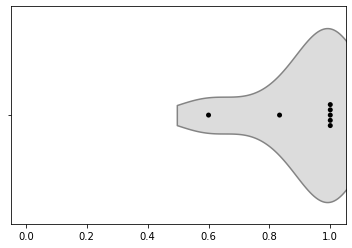

In [214]:
jaccards = [0.8333333333333334,1,1,1,1,1,0.6]

sns.violinplot(jaccards,inner=None,color='gainsboro',cut=1)
sns.swarmplot(jaccards,color='black')
plt.xlim(-0.05,1.05)


In [11]:
# big function to make the relevant matrices (binary, freq, depth)

def matrix_builder_lofreq(df):
    
    df_binary = df[['POS','description']]
    df_binary = df_binary.set_index('POS')
    df_binary = pd.get_dummies(df_binary['description'])
    df_binary = df_binary.reset_index()
    df_binary = df_binary.groupby(['POS']).sum()
    
    names = list(df)
    N = len(list(df))
    mat_binary = [ [ 0 for i in range(N) ] for j in range(N) ]
    
    for i,sample in zip(range(N),list(df_binary)):
        df_subset = df_binary[df_binary[sample]>0]
        mat_binary[i] = list(df_subset.sum())
        #this part gives diagonal as iSNVs not shared..
        mat_binary[i][i] = (df_subset.sum(axis=1)==1).sum()
        #this sets diagonal to 0
        #mat[i][i] = 0
     
    df_freq = df_binary.copy()
    df_freq = df_freq.astype('float')

    for index,row in df.iterrows():
        posit = df['POS'][index]
        sample = df['description'][index]
        freq = df['freq'][index]
        df_freq.at[posit,sample] = freq    
        
    df_depth = df_binary.copy()
    df_depth = df_depth.astype('float')
    
  
    return(df_binary,df_freq)


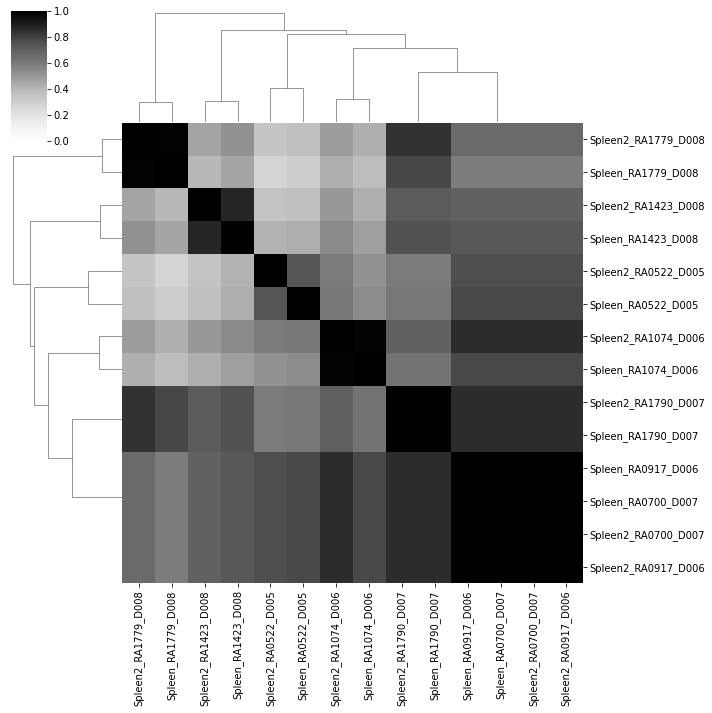

In [14]:
all_bin = matrix_builder_lofreq(lofreq_isnvs_rep)[0]
all_freq = matrix_builder_lofreq(lofreq_isnvs_rep)[1]

sns.clustermap(all_freq.corr(method='spearman'),vmin=0,vmax=1,cmap='Greys')


RA1074
RA0700
RA1779
RA0917
RA1423
RA0522
RA1790


(0.0, 0.12)

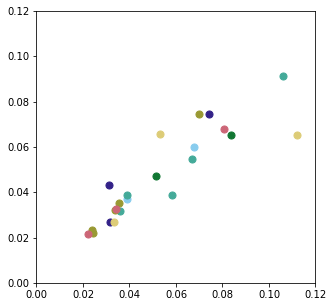

In [213]:
colormap = ['#332288','#88CCEE','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499']

plt.figure(figsize=(5,5))

for animal,i in zip(list(set(lofreq_isnvs_rep['animal_ID'])),range(len(colormap))):
    print(animal)
    df_temp = lofreq_isnvs_rep[lofreq_isnvs_rep['animal_ID']==animal]
    for pos in list(set(df_temp['POS'])):
        df_temp2 = df_temp[df_temp['POS']==pos]
        if len(df_temp2) > 1:
            plt.scatter(df_temp2['freq'].iloc[0],df_temp2['freq'].iloc[1],color=colormap[i],s=50)
plt.ylim(0,.12)
plt.xlim(0,.12)


### <400x depth of coverage genome variants

In [10]:
files = list(isnvs_files_lc['lofreq_vcf'])
ids = list(isnvs_files_lc['description'])
animals = list(isnvs_files_lc['animal_ID'])
cohort = list(isnvs_files_lc['cohort'])
tissue = list(isnvs_files_lc['tissue_sub'])

all_iSNV_list = []
for file,aid,ani,coh,tis in zip(files,ids,animals,cohort,tissue):
    df = pd.read_table(file,sep='\t',skiprows=15)
    df['description'] = aid
    df['animal_ID'] = ani
    df['cohort'] = coh
    df['tissue_sub'] = tis
    all_iSNV_list.append(df)
lofreq_isnvs = pd.concat(all_iSNV_list, ignore_index=True, axis=0)

lofreq_isnvs[['depth','freq','qual','reads']] = lofreq_isnvs['INFO'].str.split(';', 3, expand=True)
lofreq_isnvs = lofreq_isnvs.reset_index(drop=True)

lofreq_isnvs['depth'] = lofreq_isnvs['depth'].str[3:]
lofreq_isnvs['freq'] = lofreq_isnvs['freq'].str[3:]

lofreq_isnvs[["depth", "freq"]] = lofreq_isnvs[["depth", "freq"]].apply(pd.to_numeric)
lofreq_isnvs['variant_reads'] = round(lofreq_isnvs['depth']*lofreq_isnvs['freq'])

lofreq_isnvs['alleles'] = lofreq_isnvs['REF']+lofreq_isnvs['ALT']

lofreq_isnvs.head()


#CHROM   POS ID REF ALT QUAL FILTER  \
0  KU182905.1  4481  .   G   T   69   PASS   
1  KU182905.1  7065  .   C   A   53   PASS   
2  KU182905.1  7668  .   T   C  198   PASS   
3  KU182905.1  7723  .   C   A   62   PASS   
4  KU182905.1  7787  .   A   C   60   PASS   

                                      INFO         description animal_ID  \
0     DP=55;AF=0.054545;SB=2;DP4=40,10,5,0  Kidney_RA1803_D006    RA1803   
1  DP=213;AF=0.014085;SB=16;DP4=91,113,0,7  Kidney_RA1803_D006    RA1803   
2     DP=88;AF=0.090909;SB=8;DP4=43,36,7,1  Kidney_RA1803_D006    RA1803   
3   DP=110;AF=0.027273;SB=24;DP4=50,51,0,9  Kidney_RA1803_D006    RA1803   
4    DP=117;AF=0.025641;SB=0;DP4=41,72,1,3  Kidney_RA1803_D006    RA1803   

  cohort tissue_sub  depth      freq   qual           reads  variant_reads  \
0   D006     Kidney     55  0.054545   SB=2   DP4=40,10,5,0            3.0   
1   D006     Kidney    213  0.014085  SB=16  DP4=91,113,0,7            3.0   
2   D006     Kidney     88  0.090909   SB=8   DP4=43,36,7,1            8.0   
3   D006     Kidney    110  0.027273  SB=24   DP4=50,51,0,9            3.0   
4   D006     Kidney    117  0.025641   SB=0   DP4=41,72,1,3            3.0   

  alleles  
0      GT  
1      CA  
2      TC  
3      CA  
4      AC

In [11]:
lofreq_isnvs = lofreq_isnvs[(lofreq_isnvs['depth']>100)&(lofreq_isnvs['freq']>0.02)&(lofreq_isnvs['variant_reads']>5)]


In [13]:
lofreq_isnvs[lofreq_isnvs['POS']==8565]

#CHROM   POS ID REF ALT QUAL FILTER  \
131  KU182905.1  8565  .   T   A  755   PASS   

                                          INFO            description  \
131  DP=375;AF=0.088000;SB=2;DP4=157,179,16,23  Sex Organ_RA1790_D007   

    animal_ID cohort tissue_sub  depth   freq  qual              reads  \
131    RA1790   D007  Sex Organ    375  0.088  SB=2  DP4=157,179,16,23   

     variant_reads alleles  
131           33.0      TA

In [54]:
lofreq_isnvs[lofreq_isnvs['freq']>0.1]

#CHROM    POS ID REF ALT  QUAL FILTER  \
26   KU182905.1   8072  .   T   C   476   PASS   
32   KU182905.1   5077  .   A   G  1457   PASS   
38   KU182905.1   8726  .   C   T   300   PASS   
41   KU182905.1  11282  .   A   C   493   PASS   
42   KU182905.1   2946  .   A   C  2930   PASS   
82   KU182905.1   7668  .   T   C  1275   PASS   
83   KU182905.1   4531  .   A   C   384   PASS   
84   KU182905.1   7668  .   T   C   569   PASS   
88   KU182905.1   7161  .   C   T  5068   PASS   
89   KU182905.1   7668  .   T   C   391   PASS   
92   KU182905.1  10794  .   G   A   415   PASS   
226  KU182905.1  10144  .   A   G  1078   PASS   
227  KU182905.1  15453  .   A   G   759   PASS   
233  KU182905.1  10243  .   G   A   892   PASS   
254  KU182905.1   1174  .   A   T  1651   PASS   
257  KU182905.1   5742  .   A   G   711   PASS   
261  KU182905.1   7554  .   A   C  1544   PASS   
313  KU182905.1   7668  .   T   C  2768   PASS   
330  KU182905.1   7668  .   T   C  2338   PASS   

                                           INFO                description  \
26     DP=200;AF=0.105000;SB=7;DP4=73,104,13,10   Lymph node 2_RA1803_D006   
32      DP=414;AF=0.137681;SB=2;DP4=44,311,5,53   Lymph node 3_RA1803_D006   
38        DP=104;AF=0.115385;SB=2;DP4=33,55,7,8   Lymph node 3_RA1803_D006   
41       DP=159;AF=0.125786;SB=0;DP4=98,41,15,5   Lymph node 3_RA1803_D006   
42      DP=217;AF=0.433180;SB=1;DP4=59,53,58,47      Sex Organ_RA1803_D006   
82   DP=457;AF=0.113786;SB=12;DP4=100,300,21,35  Adrenal Gland_RA1779_D008   
83      DP=149;AF=0.107383;SB=1;DP4=121,11,15,2   Lymph node 2_RA1779_D008   
84       DP=106;AF=0.198113;SB=8;DP4=48,37,16,5   Lymph node 2_RA1779_D008   
88   DP=893;AF=0.208287;SB=4;DP4=175,506,60,145           Skin_RA1779_D008   
89       DP=156;AF=0.102564;SB=3;DP4=76,62,11,5           Skin_RA1779_D008   
92     DP=102;AF=0.156863;SB=12;DP4=61,20,10,10           Skin_RA1779_D008   
226     DP=135;AF=0.281481;SB=3;DP4=30,62,17,26   Lymph node 2_RA1639_D005   
227     DP=138;AF=0.202899;SB=0;DP4=69,37,19,12   Lymph node 2_RA1639_D005   
233    DP=265;AF=0.135849;SB=0;DP4=56,172,10,27   Lymph node 3_RA1639_D005   
254    DP=367;AF=0.174387;SB=0;DP4=79,219,19,49   Lymph node 1_RA1325_D006   
257     DP=293;AF=0.102389;SB=6;DP4=72,189,5,27   Lymph node 1_RA1325_D006   
261   DP=587;AF=0.110733;SB=1;DP4=265,255,32,35   Lymph node 1_RA1325_D006   
313   DP=456;AF=0.219298;SB=4;DP4=169,175,46,59      Sex Organ_RA1074_D006   
330  DP=691;AF=0.136035;SB=19;DP4=338,255,41,55   Lymph node 2_RA1074_D006   

    animal_ID cohort        tissue_sub  depth      freq   qual  \
26     RA1803   D006  Lymph node (ing)    200  0.105000   SB=7   
32     RA1803   D006  Lymph node (mes)    414  0.137681   SB=2   
38     RA1803   D006  Lymph node (mes)    104  0.115385   SB=2   
41     RA1803   D006  Lymph node (mes)    159  0.125786   SB=0   
42     RA1803   D006         Sex Organ    217  0.433180   SB=1   
82     RA1779   D008     Adrenal Gland    457  0.113786  SB=12   
83     RA1779   D008  Lymph node (ing)    149  0.107383   SB=1   
84     RA1779   D008  Lymph node (ing)    106  0.198113   SB=8   
88     RA1779   D008       Skin (rash)    893  0.208287   SB=4   
89     RA1779   D008       Skin (rash)    156  0.102564   SB=3   
92     RA1779   D008       Skin (rash)    102  0.156863  SB=12   
226    RA1639   D005  Lymph node (ing)    135  0.281481   SB=3   
227    RA1639   D005  Lymph node (ing)    138  0.202899   SB=0   
233    RA1639   D005  Lymph node (mes)    265  0.135849   SB=0   
254    RA1325   D006   Lymph node (ax)    367  0.174387   SB=0   
257    RA1325   D006   Lymph node (ax)    293  0.102389   SB=6   
261    RA1325   D006   Lymph node (ax)    587  0.110733   SB=1   
313    RA1074   D006         Sex Organ    456  0.219298   SB=4   
330    RA1074   D006  Lymph node (ing)    691  0.136035  SB=19   

                  reads  variant_reads alleles  
26     DP4=73,104,13,10           21.0      TC  
32      DP4=44,311,5,53     

In [51]:
lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1779']['POS'].value_counts()

7668     5
4531     5
10343    4
169      3
6890     2
8050     2
18411    2
11282    2
6695     1
7104     1
7974     1
3551     1
12066    1
1856     1
2408     1
4277     1
6386     1
12353    1
16526    1
9129     1
Name: POS, dtype: int64

In [42]:
lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1779']['POS'].value_counts()

7668     5
4531     5
10343    4
169      3
6890     2
8050     2
18411    2
11282    2
6695     1
7104     1
7974     1
3551     1
12066    1
1856     1
2408     1
4277     1
6386     1
12353    1
16526    1
9129     1
Name: POS, dtype: int64

In [43]:
lofreq_isnvs_hc[lofreq_isnvs_hc['POS']==3551]

#CHROM   POS ID REF ALT  QUAL FILTER  \
269  KU182905.1  3551  .   A   G  3582   PASS   

                                           INFO            description  \
269  DP=1074;AF=0.135940;SB=2;DP4=500,422,78,73  Sex Organ_RA1779_D008   

     animal cohort     tissue  depth     freq  qual              reads  \
269  RA1779   D008  Sex Organ   1074  0.13594  SB=2  DP4=500,422,78,73   

     variant_reads alleles  
269          146.0      AG

In [44]:
lofreq_isnvs_hc[lofreq_isnvs_hc['freq']>0.12]

#CHROM    POS ID REF ALT   QUAL FILTER  \
178  KU182905.1   8931  .   A   G   1677   PASS   
180  KU182905.1  11282  .   A   C   1210   PASS   
269  KU182905.1   3551  .   A   G   3582   PASS   
395  KU182905.1   7668  .   T   C   3212   PASS   
418  KU182905.1   5667  .   A   G   6396   PASS   
631  KU182905.1   7668  .   T   C  29974   PASS   
701  KU182905.1   7668  .   T   C  14287   PASS   
924  KU182905.1   8050  .   A   C   1939   PASS   
930  KU182905.1  16526  .   A   C   3603   PASS   
940  KU182905.1   7102  .   T   C  18597   PASS   

                                                INFO  \
178        DP=285;AF=0.217544;SB=9;DP4=109,111,39,25   
180        DP=416;AF=0.120192;SB=5;DP4=216,146,27,25   
269       DP=1074;AF=0.135940;SB=2;DP4=500,422,78,73   
395        DP=901;AF=0.142064;SB=8;DP4=396,373,58,72   
418      DP=1218;AF=0.199507;SB=0;DP4=220,745,55,196   
631  DP=7677;AF=0.154618;SB=17;DP4=3005,3458,517,692   
701  DP=4201;AF=0.137110;SB=16;DP4=1733,1874,251,334   
924        DP=544;AF=0.143382;SB=2;DP4=249,213,47,34   
930       DP=1162;AF=0.127367;SB=2;DP4=641,365,95,61   
940   DP=6123;AF=0.125919;SB=9;DP4=2186,3131,305,497   

                  description  animal cohort            tissue  depth  \
178  Lymph node 1_RA0700_D007  RA0700   D007   Lymph node (ax)    285   
180  Lymph node 1_RA0700_D007  RA0700   D007   Lymph node (ax)    416   
269     Sex Organ_RA1779_D008  RA1779   D008         Sex Organ   1074   
395  Lymph node 1_RA1790_D007  RA1790   D007   Lymph node (ax)    901   
418  Lymph node 2_RA1790_D007  RA1790   D007  Lymph node (ing)   1218   
631  Lymph node 1_RA0917_D006  RA0917   D006   Lymph node (ax)   7677   
701  Lymph node 2_RA0917_D006  RA0917   D006  Lymph node (ing)   4201   
924  Lymph node 1_RA1423_D008  RA1423   D008   Lymph node (ax)    544   
930  Lymph node 1_RA1423_D008  RA1423   D008   Lymph node (ax)   1162   
940  Lymph node 2_RA1423_D008  RA1423   D008  Lymph node (ing)   6123   

         freq   qual                  reads  variant_reads alleles  
178  0.217544   SB=9      DP4=109,111,39,25           62.0      AG  
180  0.120192   SB=5      DP4=216,146,27,25           50.0      AC  
269  0.135940   SB=2      DP4=500,422,78,73          146.0      AG  
395  0.142064   SB=8      DP4=396,373,58,72          128.0      TC  
418  0.199507   SB=0     DP4=220,745,55,196          243.0      AG  
631  0.154618  SB=17  DP4=3005,3458,517,692         1187.0      TC  
701  0.137110  SB=16  DP4=1733,1874,251,334          576.0      TC  
924  0.143382   SB=2      DP4=249,213,47,34           78.0      AC  
930  0.127367   SB=2      DP4=641,365,95,61          148.0      AC  
940  0.125919   SB=9  DP4=2186,3131,305,497          771.0      TC

In [45]:
lofreq_isnvs[lofreq_isnvs['POS']==7668]

#CHROM   POS ID REF ALT  QUAL FILTER  \
13   KU182905.1  7668  .   T   C   199   PASS   
24   KU182905.1  7668  .   T   C   674   PASS   
44   KU182905.1  7668  .   T   C   149   PASS   
70   KU182905.1  7668  .   T   C   404   PASS   
82   KU182905.1  7668  .   T   C  1275   PASS   
84   KU182905.1  7668  .   T   C   569   PASS   
89   KU182905.1  7668  .   T   C   391   PASS   
94   KU182905.1  7668  .   T   C   130   PASS   
109  KU182905.1  7668  .   T   C   389   PASS   
112  KU182905.1  7668  .   T   C   156   PASS   
118  KU182905.1  7668  .   T   C   281   PASS   
130  KU182905.1  7668  .   T   C   632   PASS   
161  KU182905.1  7668  .   T   C   765   PASS   
166  KU182905.1  7668  .   T   C   666   PASS   
174  KU182905.1  7668  .   T   C   150   PASS   
187  KU182905.1  7668  .   T   C   319   PASS   
203  KU182905.1  7668  .   T   C   220   PASS   
214  KU182905.1  7668  .   T   C   132   PASS   
216  KU182905.1  7668  .   T   C   232   PASS   
224  KU182905.1  7668  .   T   C   179   PASS   
232  KU182905.1  7668  .   T   C   327   PASS   
243  KU182905.1  7668  .   T   C   601   PASS   
251  KU182905.1  7668  .   T   C   163   PASS   
262  KU182905.1  7668  .   T   C   597   PASS   
272  KU182905.1  7668  .   T   C   278   PASS   
285  KU182905.1  7668  .   T   C  2752   PASS   
297  KU182905.1  7668  .   T   C   223   PASS   
313  KU182905.1  7668  .   T   C  2768   PASS   
321  KU182905.1  7668  .   T   C   292   PASS   
330  KU182905.1  7668  .   T   C  2338   PASS   
349  KU182905.1  7668  .   T   C   798   PASS   
374  KU182905.1  7668  .   T   C   411   PASS   

                                           INFO                   description  \
13       DP=266;AF=0.037594;SB=9;DP4=161,94,4,7      Lymph node 1_RA1803_D006   
24    DP=487;AF=0.063655;SB=3;DP4=259,197,20,11      Lymph node 2_RA1803_D006   
44      DP=311;AF=0.025723;SB=2;DP4=110,188,5,5         Sex Organ_RA1803_D006   
70      DP=206;AF=0.082524;SB=2;DP4=112,73,13,6            Kidney_RA1779_D008   
82   DP=457;AF=0.113786;SB=12;DP4=100,300,21,35     Adrenal Gland_RA1779_D008   
84       DP=106;AF=0.198113;SB=8;DP4=48,37,16,5      Lymph node 2_RA1779_D008   
89       DP=156;AF=0.102564;SB=3;DP4=76,62,11,5              Skin_RA1779_D008   
94        DP=128;AF=0.046875;SB=0;DP4=75,47,4,2              Skin_RA1779_D008   
109     DP=211;AF=0.080569;SB=0;DP4=105,88,10,7      Lymph node 2_RA0452_D005   
112       DP=111;AF=0.063063;SB=0;DP4=59,45,4,3      Lymph node 3_RA0452_D005   
118       DP=111;AF=0.099099;SB=0;DP4=66,32,7,4            Kidney_RA1790_D007   
130   DP=706;AF=0.043909;SB=0;DP4=326,341,17,17         Sex Organ_RA1790_D007   
161   DP=452;AF=0.073009;SB=1;DP4=242,166,22,13            Kidney_RA1818_D006   
166   DP=465;AF=0.064516;SB=2;DP4=249,181,20,11             Liver_RA1818_D006   
174       DP=138;AF=0.050725;SB=3;DP4=70,60,3,5            Spleen_RA1849_D004   
187     DP=207;AF=0.067633;SB=2;DP4=126,63,12,4             Liver_RA1423_D008   
203      DP=172;AF=0.058140;SB=1;DP4=102,58,8,3              Lung_RA1423_D008   
214       DP=121;AF=0.049587;SB=1;DP4=62,50,4,2            Kidney_RA1639_D005   
216      DP=225;AF=0.048889;SB=0;DP4=128,84,8,5             Liver_RA1639_D005   
224     DP=255;AF=0.035294;SB=3;DP4=122,124,6,3      Lymph node 2_RA1639_D005   
232   DP=355;AF=0.045070;SB=20;DP4=158,180,13,3      Lymph node 3_RA1639_D005   
243   DP=568;AF=0.051056;SB=0;DP4=291,247,16,13            Spleen_RA1325_D006   
251       DP=107;AF=0.065421;SB=1;DP4=62,38,5,2            Kidney_RA1325_D006   
262   DP=597;AF=0.048576;SB=9;DP4=306,256,13,20      Lymph node 1_RA1325_D006   
272     DP=532;AF=0.028195;SB=0;DP4=260,256,7,8      Lymph node 2_RA1325_D006   
285  DP=1311;AF=0.091533;SB=8;DP4=675,508,80,45             Liver_RA1074_D006   
297      DP=278;AF=0.039568;SB=4;DP4=175,85,7,6     Adrenal Gland_RA1074_D006   
313   DP=456;AF=0.219298;SB=4;DP4=169,175,46,59         Sex Organ_RA1074_D006   
321    DP=602;AF=0.026578;SB=0;DP4=359,225

In [46]:
lofreq_isnvs_hc[lofreq_isnvs_hc['POS']==7668]

#CHROM   POS ID REF ALT   QUAL FILTER  \
15    KU182905.1  7668  .   T   C   1716   PASS   
31    KU182905.1  7668  .   T   C    996   PASS   
50    KU182905.1  7668  .   T   C   2687   PASS   
97    KU182905.1  7668  .   T   C  15673   PASS   
153   KU182905.1  7668  .   T   C   2121   PASS   
175   KU182905.1  7668  .   T   C   1031   PASS   
198   KU182905.1  7668  .   T   C   2558   PASS   
230   KU182905.1  7668  .   T   C    886   PASS   
251   KU182905.1  7668  .   T   C   6666   PASS   
277   KU182905.1  7668  .   T   C   1612   PASS   
293   KU182905.1  7668  .   T   C    750   PASS   
314   KU182905.1  7668  .   T   C   2037   PASS   
334   KU182905.1  7668  .   T   C    660   PASS   
349   KU182905.1  7668  .   T   C   1427   PASS   
371   KU182905.1  7668  .   T   C   4352   PASS   
395   KU182905.1  7668  .   T   C   3212   PASS   
420   KU182905.1  7668  .   T   C   4359   PASS   
446   KU182905.1  7668  .   T   C    437   PASS   
466   KU182905.1  7668  .   T   C   1567   PASS   
493   KU182905.1  7668  .   T   C   2048   PASS   
525   KU182905.1  7668  .   T   C   2561   PASS   
554   KU182905.1  7668  .   T   C   2429   PASS   
571   KU182905.1  7668  .   T   C   4702   PASS   
631   KU182905.1  7668  .   T   C  29974   PASS   
701   KU182905.1  7668  .   T   C  14287   PASS   
811   KU182905.1  7668  .   T   C   5861   PASS   
872   KU182905.1  7668  .   T   C   4382   PASS   
923   KU182905.1  7668  .   T   C   1070   PASS   
942   KU182905.1  7668  .   T   C   1947   PASS   
998   KU182905.1  7668  .   T   C  34430   PASS   
1056  KU182905.1  7668  .   T   C   3936   PASS   
1090  KU182905.1  7668  .   T   C   3529   PASS   
1121  KU182905.1  7668  .   T   C   3551   PASS   
1149  KU182905.1  7668  .   T   C   2644   PASS   
1182  KU182905.1  7668  .   T   C   3022   PASS   
1209  KU182905.1  7668  .   T   C   8733   PASS   
1270  KU182905.1  7668  .   T   C  18648   PASS   
1312  KU182905.1  7668  .   T   C   1957   PASS   
1331  KU182905.1  7668  .   T   C   4862   PASS   
1360  KU182905.1  7668  .   T   C   4621   PASS   
1389  KU182905.1  7668  .   T   C   1460   PASS   
1407  KU182905.1  7668  .   T   C   2889   PASS   
1452  KU182905.1  7668  .   T   C  12656   PASS   
1501  KU182905.1  7668  .   T   C   3614   PASS   

                                                  INFO  \
15         DP=1942;AF=0.044284;SB=7;DP4=1003,842,42,48   
31           DP=778;AF=0.060411;SB=8;DP4=359,365,30,19   
50          DP=1544;AF=0.077720;SB=0;DP4=633,778,57,71   
97    DP=10748;AF=0.067827;SB=32;DP4=4424,5564,280,461   
153        DP=1431;AF=0.067086;SB=10;DP4=736,575,68,36   
175         DP=885;AF=0.055367;SB=11;DP4=387,447,30,20   
198       DP=2039;AF=0.059343;SB=14;DP4=794,1115,39,84   
230          DP=837;AF=0.051374;SB=0;DP4=401,389,22,22   
251    DP=2647;AF=0.106158;SB=13;DP4=1040,1314,110,180   
277         DP=1054;AF=0.068311;SB=0;DP4=553,412,47,33   
293          DP=587;AF=0.059625;SB=0;DP4=291,261,18,17   
314         DP=1335;AF=0.069663;SB=2;DP4=591,649,42,52   
334          DP=241;AF=0.112033;SB=0;DP4=103,110,13,15   
349          DP=859;AF=0.074505;SB=3;DP4=397,389,31,37   
371       DP=2401;AF=0.080800;SB=6;DP4=878,1323,69,127   
395          DP=901;AF=0.142064;SB=8;DP4=396,373,58,72   
420        DP=2146;AF=0.088537;SB=8;DP4=999,937,91,106   
446          DP=685;AF=0.033577;SB=1;DP4=327,331,11,14   
466          DP=998;AF=0.071142;SB=2;DP4=450,472,33,41   
493          DP=754;AF=0.112732;SB=2;DP4=331,334,47,41   
525       DP=2940;AF=0.043878;SB=8;DP4=1289,1512,52,80   
554         DP=1466;AF=0.073670;SB=2;DP4=789,545,66,51   
571      DP=2493;AF=0.083835;SB=3;DP4=1072,1202,94,119   
631    DP=7677;AF=0.154618;SB=17;DP4=3005,3458,517,692   
701    DP=4201;AF=0.137110;SB=16;DP4=1733,1874,251,334   
811    DP=3867;AF=0.070080;SB=24;DP4=1693,1885,105,171   
872     DP=3987;AF=0.052671;SB=4;DP4=2100,1598,129,111   
923         DP=1256;AF=0.042994;SB=0;DP4=583,611,29,29   
942       DP=2480;AF=0.040726;SB

In [38]:
lofreq_isnvs[(lofreq_isnvs['animal_ID']=='RA1803')&(lofreq_isnvs['POS']==7668)]

#CHROM   POS ID REF ALT QUAL FILTER  \
13  KU182905.1  7668  .   T   C  199   PASS   
24  KU182905.1  7668  .   T   C  674   PASS   
44  KU182905.1  7668  .   T   C  149   PASS   

                                         INFO               description  \
13     DP=266;AF=0.037594;SB=9;DP4=161,94,4,7  Lymph node 1_RA1803_D006   
24  DP=487;AF=0.063655;SB=3;DP4=259,197,20,11  Lymph node 2_RA1803_D006   
44    DP=311;AF=0.025723;SB=2;DP4=110,188,5,5     Sex Organ_RA1803_D006   

   animal_ID cohort        tissue_sub  depth      freq  qual  \
13    RA1803   D006   Lymph node (ax)    266  0.037594  SB=9   
24    RA1803   D006  Lymph node (ing)    487  0.063655  SB=3   
44    RA1803   D006         Sex Organ    311  0.025723  SB=2   

                reads  variant_reads alleles  
13     DP4=161,94,4,7           10.0      TC  
24  DP4=259,197,20,11           31.0      TC  
44    DP4=110,188,5,5            8.0      TC

In [39]:
lofreq_isnvs[(lofreq_isnvs['animal_ID']=='RA1803')&(lofreq_isnvs['freq']>0.05)]

#CHROM    POS ID REF ALT  QUAL FILTER  \
23  KU182905.1   6231  .   T   C   235   PASS   
24  KU182905.1   7668  .   T   C   674   PASS   
26  KU182905.1   8072  .   T   C   476   PASS   
27  KU182905.1  12064  .   G   A   400   PASS   
29  KU182905.1  13279  .   C   T   173   PASS   
31  KU182905.1   2946  .   A   C   190   PASS   
32  KU182905.1   5077  .   A   G  1457   PASS   
38  KU182905.1   8726  .   C   T   300   PASS   
41  KU182905.1  11282  .   A   C   493   PASS   
42  KU182905.1   2946  .   A   C  2930   PASS   

                                         INFO               description  \
23     DP=189;AF=0.058201;SB=0;DP4=129,49,8,3  Lymph node 2_RA1803_D006   
24  DP=487;AF=0.063655;SB=3;DP4=259,197,20,11  Lymph node 2_RA1803_D006   
26   DP=200;AF=0.105000;SB=7;DP4=73,104,13,10  Lymph node 2_RA1803_D006   
27    DP=224;AF=0.080357;SB=1;DP4=160,44,15,5  Lymph node 2_RA1803_D006   
29      DP=141;AF=0.056738;SB=3;DP4=90,42,5,4  Lymph node 2_RA1803_D006   
31     DP=178;AF=0.050562;SB=4;DP4=31,138,3,6  Lymph node 3_RA1803_D006   
32    DP=414;AF=0.137681;SB=2;DP4=44,311,5,53  Lymph node 3_RA1803_D006   
38      DP=104;AF=0.115385;SB=2;DP4=33,55,7,8  Lymph node 3_RA1803_D006   
41     DP=159;AF=0.125786;SB=0;DP4=98,41,15,5  Lymph node 3_RA1803_D006   
42    DP=217;AF=0.433180;SB=1;DP4=59,53,58,47     Sex Organ_RA1803_D006   

   animal_ID cohort        tissue_sub  depth      freq  qual  \
23    RA1803   D006  Lymph node (ing)    189  0.058201  SB=0   
24    RA1803   D006  Lymph node (ing)    487  0.063655  SB=3   
26    RA1803   D006  Lymph node (ing)    200  0.105000  SB=7   
27    RA1803   D006  Lymph node (ing)    224  0.080357  SB=1   
29    RA1803   D006  Lymph node (ing)    141  0.056738  SB=3   
31    RA1803   D006  Lymph node (mes)    178  0.050562  SB=4   
32    RA1803   D006  Lymph node (mes)    414  0.137681  SB=2   
38    RA1803   D006  Lymph node (mes)    104  0.115385  SB=2   
41    RA1803   D006  Lymph node (mes)    159  0.125786  SB=0   
42    RA1803   D006         Sex Organ    217  0.433180  SB=1   

                reads  variant_reads alleles  
23     DP4=129,49,8,3           11.0      TC  
24  DP4=259,197,20,11           31.0      TC  
26   DP4=73,104,13,10           21.0      TC  
27    DP4=160,44,15,5           18.0      GA  
29      DP4=90,42,5,4            8.0      CT  
31     DP4=31,138,3,6            9.0      AC  
32    DP4=44,311,5,53           57.0      AG  
38      DP4=33,55,7,8           12.0      CT  
41     DP4=98,41,15,5           20.0      AC  
42    DP4=59,53,58,47           94.0      AC

In [40]:
lofreq_isnvs_hc[(lofreq_isnvs_hc['animal']=='RA1803')&(lofreq_isnvs_hc['POS']==11282)]

#CHROM    POS ID REF ALT  QUAL FILTER  \
22    KU182905.1  11282  .   A   C   861   PASS   
1514  KU182905.1  11282  .   A   C  1931   PASS   

                                             INFO  \
22     DP=1065;AF=0.042254;SB=0;DP4=609,409,27,19   
1514  DP=2746;AF=0.038602;SB=1;DP4=1679,959,67,41   

                       description  animal cohort              tissue  depth  \
22              Spleen_RA1803_D006  RA1803   D006              Spleen   1065   
1514  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   2746   

          freq  qual               reads  variant_reads alleles  
22    0.042254  SB=0   DP4=609,409,27,19           45.0      AC  
1514  0.038602  SB=1  DP4=1679,959,67,41          106.0      AC

In [41]:
lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1803']

#CHROM    POS ID REF ALT  QUAL FILTER  \
15    KU182905.1   7668  .   T   C  1716   PASS   
20    KU182905.1  10343  .   C   A   332   PASS   
22    KU182905.1  11282  .   A   C   861   PASS   
31    KU182905.1   7668  .   T   C   996   PASS   
1501  KU182905.1   7668  .   T   C  3614   PASS   
1510  KU182905.1  10343  .   C   A   595   PASS   
1514  KU182905.1  11282  .   A   C  1931   PASS   

                                               INFO  \
15      DP=1942;AF=0.044284;SB=7;DP4=1003,842,42,48   
20         DP=646;AF=0.029412;SB=0;DP4=278,345,9,13   
22       DP=1065;AF=0.042254;SB=0;DP4=609,409,27,19   
31        DP=778;AF=0.060411;SB=8;DP4=359,365,30,19   
1501  DP=3548;AF=0.050169;SB=0;DP4=1267,2097,66,113   
1510     DP=1744;AF=0.021789;SB=0;DP4=759,943,19,22   
1514    DP=2746;AF=0.038602;SB=1;DP4=1679,959,67,41   

                       description  animal cohort              tissue  depth  \
15              Spleen_RA1803_D006  RA1803   D006              Spleen   1942   
20              Spleen_RA1803_D006  RA1803   D006              Spleen    646   
22              Spleen_RA1803_D006  RA1803   D006              Spleen   1065   
31               Liver_RA1803_D006  RA1803   D006               Liver    778   
1501  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   3548   
1510  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   1744   
1514  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   2746   

          freq  qual                 reads  variant_reads alleles  
15    0.044284  SB=7    DP4=1003,842,42,48           86.0      TC  
20    0.029412  SB=0      DP4=278,345,9,13           19.0      CA  
22    0.042254  SB=0     DP4=609,409,27,19           45.0      AC  
31    0.060411  SB=8     DP4=359,365,30,19           47.0      TC  
1501  0.050169  SB=0  DP4=1267,2097,66,113          178.0      TC  
1510  0.021789  SB=0     DP4=759,943,19,22           38.0      CA  
1514  0.038602  SB=1    DP4=1679,959,67,41          106.0      AC

In [42]:
lofreq_isnvs_hc[lofreq_isnvs_hc['freq']>0.05]['tissue'].value_counts()

Lymph node (ax)       19
Spleen                15
Lymph node (ing)      15
Lymph node (mes)       9
Kidney                 4
Whole blood (D006)     4
Whole blood (D008)     4
Sex Organ              2
Skin (nonrash)         2
Whole blood (D007)     2
Liver                  1
Whole blood (D005)     1
Name: tissue, dtype: int64

In [43]:
lofreq_isnvs[lofreq_isnvs['freq']>0.05]['tissue_sub'].value_counts()

Lymph node (ing)      16
Sex Organ              9
Lymph node (mes)       7
Kidney                 5
Adrenal Gland          5
Skin (rash)            3
Liver                  3
Lymph node (ax)        3
Spleen                 2
Whole blood (D006)     2
Skin                   1
Lung                   1
Name: tissue_sub, dtype: int64

### >400x depth of coverage genome variants

#### all variants

In [208]:
files = list(isnvs_files_hc['lofreq_vcf'])
ids = list(isnvs_files_hc['description'])
animals = list(isnvs_files_hc['animal_ID'])
cohort = list(isnvs_files_hc['cohort'])
tissue = list(isnvs_files_hc['tissue_sub'])

all_iSNV_list = []
for file,aid,ani,coh,tis in zip(files,ids,animals,cohort,tissue):
    df = pd.read_table(file,sep='\t',skiprows=15)
    df['description'] = aid
    df['animal'] = ani
    df['cohort'] = coh
    df['tissue'] = tis
    all_iSNV_list.append(df)
lofreq_isnvs_hc = pd.concat(all_iSNV_list, ignore_index=True, axis=0)

lofreq_isnvs_hc[['depth','freq','qual','reads']] = lofreq_isnvs_hc['INFO'].str.split(';', 3, expand=True)
lofreq_isnvs_hc = lofreq_isnvs_hc.reset_index(drop=True)

lofreq_isnvs_hc['depth'] = lofreq_isnvs_hc['depth'].str[3:]
lofreq_isnvs_hc['freq'] = lofreq_isnvs_hc['freq'].str[3:]

lofreq_isnvs_hc[["depth", "freq"]] = lofreq_isnvs_hc[["depth", "freq"]].apply(pd.to_numeric)
lofreq_isnvs_hc['variant_reads'] = round(lofreq_isnvs_hc['depth']*lofreq_isnvs_hc['freq'])

lofreq_isnvs_hc['alleles'] = lofreq_isnvs_hc['REF']+lofreq_isnvs_hc['ALT']

lofreq_isnvs_hc.head()


#CHROM   POS ID REF ALT  QUAL FILTER  \
0  KU182905.1  1351  .   T   C    91   PASS   
1  KU182905.1  1378  .   T   C    62   PASS   
2  KU182905.1  2153  .   C   T    59   PASS   
3  KU182905.1  4422  .   G   A   109   PASS   
4  KU182905.1  4715  .   G   A    59   PASS   

                                         INFO         description  animal  \
0   DP=1394;AF=0.005739;SB=0;DP4=373,1013,2,6  Spleen_RA1803_D006  RA1803   
1    DP=1313;AF=0.004570;SB=6;DP4=494,811,4,2  Spleen_RA1803_D006  RA1803   
2   DP=1681;AF=0.003569;SB=1;DP4=564,1109,1,5  Spleen_RA1803_D006  RA1803   
3     DP=884;AF=0.010181;SB=0;DP4=561,311,7,4  Spleen_RA1803_D006  RA1803   
4  DP=2419;AF=0.002894;SB=2;DP4=1224,1185,6,3  Spleen_RA1803_D006  RA1803   

  cohort  tissue  depth      freq  qual              reads  variant_reads  \
0   D006  Spleen   1394  0.005739  SB=0   DP4=373,1013,2,6            8.0   
1   D006  Spleen   1313  0.004570  SB=6    DP4=494,811,4,2            6.0   
2   D006  Spleen   1681  0.003569  SB=1   DP4=564,1109,1,5            6.0   
3   D006  Spleen    884  0.010181  SB=0    DP4=561,311,7,4            9.0   
4   D006  Spleen   2419  0.002894  SB=2  DP4=1224,1185,6,3            7.0   

  alleles  
0      TC  
1      TC  
2      CT  
3      GA  
4      GA

In [209]:
lofreq_isnvs_hc = lofreq_isnvs_hc[(lofreq_isnvs_hc['depth']>100)&(lofreq_isnvs_hc['freq']>0.02)&(lofreq_isnvs_hc['variant_reads']>5)]


In [28]:
lofreq_isnvs_hc[lofreq_isnvs_hc['freq']>.1]

#CHROM    POS ID REF ALT   QUAL FILTER  \
178   KU182905.1   8931  .   A   G   1677   PASS   
180   KU182905.1  11282  .   A   C   1210   PASS   
251   KU182905.1   7668  .   T   C   6666   PASS   
269   KU182905.1   3551  .   A   G   3582   PASS   
289   KU182905.1   6890  .   A   T   2170   PASS   
296   KU182905.1  10343  .   C   A    613   PASS   
334   KU182905.1   7668  .   T   C    660   PASS   
395   KU182905.1   7668  .   T   C   3212   PASS   
418   KU182905.1   5667  .   A   G   6396   PASS   
493   KU182905.1   7668  .   T   C   2048   PASS   
522   KU182905.1   6870  .   A   T  13104   PASS   
631   KU182905.1   7668  .   T   C  29974   PASS   
701   KU182905.1   7668  .   T   C  14287   PASS   
924   KU182905.1   8050  .   A   C   1939   PASS   
930   KU182905.1  16526  .   A   C   3603   PASS   
940   KU182905.1   7102  .   T   C  18597   PASS   
947   KU182905.1   9651  .   T   C   3107   PASS   
948   KU182905.1   9654  .   T   C   3163   PASS   
990   KU182905.1   7109  .   A   T  49314   PASS   
1312  KU182905.1   7668  .   T   C   1957   PASS   

                                                   INFO  \
178           DP=285;AF=0.217544;SB=9;DP4=109,111,39,25   
180           DP=416;AF=0.120192;SB=5;DP4=216,146,27,25   
251     DP=2647;AF=0.106158;SB=13;DP4=1040,1314,110,180   
269          DP=1074;AF=0.135940;SB=2;DP4=500,422,78,73   
289             DP=831;AF=0.109507;SB=5;DP4=631,99,92,9   
296            DP=241;AF=0.112033;SB=0;DP4=75,133,12,19   
334           DP=241;AF=0.112033;SB=0;DP4=103,110,13,15   
395           DP=901;AF=0.142064;SB=8;DP4=396,373,58,72   
418         DP=1218;AF=0.199507;SB=0;DP4=220,745,55,196   
493           DP=754;AF=0.112732;SB=2;DP4=331,334,47,41   
522        DP=5451;AF=0.103284;SB=5;DP4=4313,543,517,75   
631     DP=7677;AF=0.154618;SB=17;DP4=3005,3458,517,692   
701     DP=4201;AF=0.137110;SB=16;DP4=1733,1874,251,334   
924           DP=544;AF=0.143382;SB=2;DP4=249,213,47,34   
930          DP=1162;AF=0.127367;SB=2;DP4=641,365,95,61   
940      DP=6123;AF=0.125919;SB=9;DP4=2186,3131,305,497   
947          DP=1146;AF=0.113438;SB=1;DP4=469,534,62,77   
948          DP=1122;AF=0.117647;SB=3;DP4=469,512,62,78   
990   DP=32457;AF=0.101981;SB=5;DP4=12820,16198,1530...   
1312          DP=709;AF=0.114245;SB=4;DP4=256,371,38,43   

                       description  animal cohort              tissue  depth  \
178       Lymph node 1_RA0700_D007  RA0700   D007     Lymph node (ax)    285   
180       Lymph node 1_RA0700_D007  RA0700   D007     Lymph node (ax)    416   
251             Spleen_RA1779_D008  RA1779   D008              Spleen   2647   
269          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ   1074   
289       Lymph node 1_RA1779_D008  RA1779   D008     Lymph node (ax)    831   
296       Lymph node 1_RA1779_D008  RA1779   D008     Lymph node (ax)    241   
334             Spleen_RA0522_D005  RA0522   D005              Spleen    241   
395       Lymph node 1_RA1790_D007  RA1790   D007     Lymph node (ax)    901   
418       Lymph node 2_RA1790_D007  RA1790   D007    Lymph node (ing)   1218   
493       Lymph node 2_RA1818_D006  RA1818   D006    Lymph node (ing)    754   
522       Lymph node 3_RA1818_D006  RA1818   D006    Lymph node (mes)   5451   
631       Lymph node 1_RA0917_D006  RA0917   D006     Lymph node (ax)   7677   
701       Lymph node 2_RA0917_D006  RA0917   D006    Lymph node (ing)   4201   
924       Lymph node 1_RA1423_D008  RA1423   D008     Lymph node (ax)    544   
930       Lymph node 1_RA1423_D008  RA1423   D008     Lymph node (ax)   1162   
940       Lymph node 2_RA1423_D008  RA1423   D008    Lymph node (ing)   6123   
947       Lymph node 2_RA1423_D008  RA1423   D008    Lymph node (ing)   1146   
948       Lymph node 2_RA1423_D008  RA1423   D008    Lymph node (ing)   1122   
990       Lymph node 3_RA1423_D008  RA1423   D008    Lymph node (mes)  32457   
1312  Whole blood_D008_RA1779_D008  RA1779   D008  Whole blood (D008)    709 

In [29]:
max(lofreq_isnvs_hc['freq'])

0.217544

In [8]:
lofreq_isnvs_hc['POS'].value_counts()

7668     44
11282    33
10343    24
4531      5
5077      4
         ..
13770     1
12380     1
11425     1
9586      1
18584     1
Name: POS, Length: 111, dtype: int64

(0.0, 0.3)

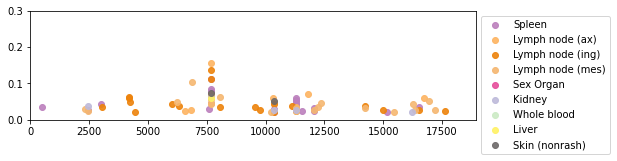

In [19]:
plt.figure(figsize=(8,2))

df_temp = lofreq_isnvs_hc[(lofreq_isnvs_hc['cohort']=='D004')|(lofreq_isnvs_hc['cohort']=='D005')|(lofreq_isnvs_hc['cohort']=='D006')]

cmap_test = ['#BC80BD','#FDB462','#ed830c','#f5b771','#e64e9b','#BEBADA','#CCEBC5','#fff265','#6e6969']

for i,tissue in zip(range(len(cmap_test)),['Spleen','Lymph node (ax)','Lymph node (ing)','Lymph node (mes)','Sex Organ','Kidney','Whole blood','Liver','Skin (nonrash)']):
    plt.scatter(df_temp[df_temp['tissue']==tissue]['POS'],
                df_temp[df_temp['tissue']==tissue]['freq'],label=tissue,alpha=0.9,color=cmap_test[i])
plt.legend(bbox_to_anchor=(1,1))
plt.xlim(0,18959)
plt.ylim(0,0.3)


(0.0, 0.3)

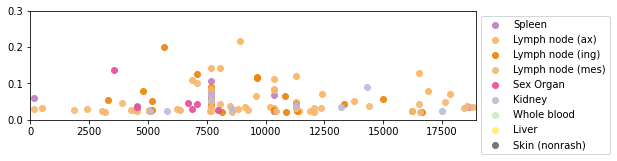

In [20]:
plt.figure(figsize=(8,2))

df_temp = lofreq_isnvs_hc[(lofreq_isnvs_hc['cohort']=='D007')|(lofreq_isnvs_hc['cohort']=='D008')]

cmap_test = ['#BC80BD','#FDB462','#ed830c','#f5b771','#e64e9b','#BEBADA','#CCEBC5','#fff265','#6e6969']

for i,tissue in zip(range(len(cmap_test)),['Spleen','Lymph node (ax)','Lymph node (ing)','Lymph node (mes)','Sex Organ','Kidney','Whole blood','Liver','Skin (nonrash)']):
    plt.scatter(df_temp[df_temp['tissue']==tissue]['POS'],
                df_temp[df_temp['tissue']==tissue]['freq'],label=tissue,alpha=0.9,color=cmap_test[i])
plt.legend(bbox_to_anchor=(1,1))
plt.xlim(0,18959)
plt.ylim(0,0.3)


In [21]:
lofreq_isnvs_hc['description'].value_counts()


Lymph node 2_RA1818_D006        15
Lymph node 3_RA1423_D008        13
Lymph node 1_RA1790_D007        12
Lymph node 3_RA1779_D008        12
Lymph node 2_RA1423_D008         8
Lymph node 3_RA1818_D006         7
Lymph node 2_RA0700_D007         7
Lymph node 3_RA0700_D007         7
Sex Organ_RA1779_D008            7
Whole blood_D008_RA1779_D008     7
Kidney_RA1423_D008               7
Lymph node 2_RA1790_D007         7
Lymph node 1_RA0917_D006         6
Lymph node 2_RA0917_D006         6
Lymph node 1_RA1779_D008         6
Lymph node 3_RA1325_D006         6
Lymph node 3_RA0917_D006         5
Spleen_RA1423_D008               5
Lymph node 1_RA1423_D008         5
Spleen_RA1639_D005               5
Lymph node 3_RA1790_D007         5
Kidney_RA1074_D006               5
Whole blood_D008_RA1423_D008     5
Spleen_RA0452_D005               5
Spleen_RA1779_D008               5
Whole blood_D005_RA1639_D005     5
Spleen_RA0717_D004               5
Whole blood_D006_RA1818_D006     4
Spleen_RA0522_D005  

In [9]:
mult_df = lofreq_isnvs_hc.copy()

for var_pos in list(set(mult_df['POS'])):
    temp_df = mult_df[mult_df['POS']==var_pos]
    anim = len(list(set(temp_df['animal'])))
    if anim == 1:
        print(var_pos)
        print(anim)
        mult_df = mult_df[mult_df['POS']!=var_pos]
        tis = len(list(set(temp_df['description'])))

mult_df

10243
1
7691
1
16909
1
9238
1
13338
1
16929
1
5667
1
6695
1
11820
1
5165
1
5166
1
12341
1
14390
1
9782
1
10304
1
12353
1
10832
1
11350
1
4183
1
17496
1
12380
1
8811
1
15468
1
4205
1
11891
1
3197
1
18562
1
10890
1
14988
1
18584
1
15001
1
11425
1
4258
1
6819
1
5796
1
16551
1
169
1
4277
1
4791
1
6338
1
18631
1
10443
1
17621
1
6870
1
17625
1
8931
1
6890
1
3311
1
6386
1
16653
1
11554
1
2340
1
7974
1
15151
1
17202
1
8502
1
1856
1
3905
1
16712
1
9568
1
4453
1
2408
1
8046
1
9586
1
8565
1
6010
1
4477
1
8573
1
11138
1
14211
1
13188
1
16268
1
18831
1
2458
1
14235
1
9129
1
7603
1
4531
1
9651
1
9654
1
17847
1
2997
1
5052
1
12221
1
7102
1
7104
1
6592
1
5059
1
7109
1
13770
1
10187
1
14298
1
3551
1
7648
1
18911
1
8168
1
3049
1
3050
1
18411
1
16368
1


#CHROM    POS ID REF ALT   QUAL FILTER  \
15    KU182905.1   7668  .   T   C   1716   PASS   
20    KU182905.1  10343  .   C   A    332   PASS   
22    KU182905.1  11282  .   A   C    861   PASS   
31    KU182905.1   7668  .   T   C    996   PASS   
50    KU182905.1   7668  .   T   C   2687   PASS   
...          ...    ... ..  ..  ..    ...    ...   
1452  KU182905.1   7668  .   T   C  12656   PASS   
1463  KU182905.1  11282  .   A   C   4434   PASS   
1501  KU182905.1   7668  .   T   C   3614   PASS   
1510  KU182905.1  10343  .   C   A    595   PASS   
1514  KU182905.1  11282  .   A   C   1931   PASS   

                                                 INFO  \
15        DP=1942;AF=0.044284;SB=7;DP4=1003,842,42,48   
20           DP=646;AF=0.029412;SB=0;DP4=278,345,9,13   
22         DP=1065;AF=0.042254;SB=0;DP4=609,409,27,19   
31          DP=778;AF=0.060411;SB=8;DP4=359,365,30,19   
50         DP=1544;AF=0.077720;SB=0;DP4=633,778,57,71   
...                                               ...   
1452  DP=7899;AF=0.073047;SB=38;DP4=2725,4567,174,415   
1463    DP=6115;AF=0.038757;SB=9;DP4=3563,2308,159,82   
1501    DP=3548;AF=0.050169;SB=0;DP4=1267,2097,66,113   
1510       DP=1744;AF=0.021789;SB=0;DP4=759,943,19,22   
1514      DP=2746;AF=0.038602;SB=1;DP4=1679,959,67,41   

                       description  animal cohort              tissue  depth  \
15              Spleen_RA1803_D006  RA1803   D006              Spleen   1942   
20              Spleen_RA1803_D006  RA1803   D006              Spleen    646   
22              Spleen_RA1803_D006  RA1803   D006              Spleen   1065   
31               Liver_RA1803_D006  RA1803   D006               Liver    778   
50              Spleen_RA0717_D004  RA0717   D004              Spleen   1544   
...                            ...     ...    ...                 ...    ...   
1452  Whole blood_D006_RA1074_D006  RA1074   D006  Whole blood (D006)   7899   
1463  Whole blood_D006_RA1074_D006  RA1074   D006  Whole blood (D006)   6115   
1501  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   3548   
1510  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   1744   
1514  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   2746   

          freq   qual                  reads  variant_reads alleles  
15    0.044284   SB=7     DP4=1003,842,42,48           86.0      TC  
20    0.029412   SB=0       DP4=278,345,9,13           19.0      CA  
22    0.042254   SB=0      DP4=609,409,27,19           45.0      AC  
31    0.060411   SB=8      DP4=359,365,30,19           47.0      TC  
50    0.077720   SB=0      DP4=633,778,57,71          120.0      TC  
...        ...    ...                    ...            ...     ...  
1452  0.073047  SB=38  DP4=2725,4567,174,415          577.0      TC  
1463  0.038757   SB=9   DP4=3563,2308,159,82          237.0      AC  
1501  0.050169   SB=0   DP4=1267,2097,66,113          178.0      TC  
1510  0.021789   SB=0      DP4=759,943,19,22           38.0      CA  
1514  0.038602   SB=1     DP4=1679,959,67,41          106.0      AC  

[126 rows x 18 columns]

In [23]:
mult_df.to_csv(r'gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/shared_variants_all.csv',index=False)


In [93]:
mult_df

#CHROM    POS ID REF ALT   QUAL FILTER  \
15    KU182905.1   7668  .   T   C   1716   PASS   
20    KU182905.1  10343  .   C   A    332   PASS   
22    KU182905.1  11282  .   A   C    861   PASS   
31    KU182905.1   7668  .   T   C    996   PASS   
50    KU182905.1   7668  .   T   C   2687   PASS   
...          ...    ... ..  ..  ..    ...    ...   
1452  KU182905.1   7668  .   T   C  12656   PASS   
1463  KU182905.1  11282  .   A   C   4434   PASS   
1501  KU182905.1   7668  .   T   C   3614   PASS   
1510  KU182905.1  10343  .   C   A    595   PASS   
1514  KU182905.1  11282  .   A   C   1931   PASS   

                                                 INFO  \
15        DP=1942;AF=0.044284;SB=7;DP4=1003,842,42,48   
20           DP=646;AF=0.029412;SB=0;DP4=278,345,9,13   
22         DP=1065;AF=0.042254;SB=0;DP4=609,409,27,19   
31          DP=778;AF=0.060411;SB=8;DP4=359,365,30,19   
50         DP=1544;AF=0.077720;SB=0;DP4=633,778,57,71   
...                                               ...   
1452  DP=7899;AF=0.073047;SB=38;DP4=2725,4567,174,415   
1463    DP=6115;AF=0.038757;SB=9;DP4=3563,2308,159,82   
1501    DP=3548;AF=0.050169;SB=0;DP4=1267,2097,66,113   
1510       DP=1744;AF=0.021789;SB=0;DP4=759,943,19,22   
1514      DP=2746;AF=0.038602;SB=1;DP4=1679,959,67,41   

                       description  animal cohort              tissue  depth  \
15              Spleen_RA1803_D006  RA1803   D006              Spleen   1942   
20              Spleen_RA1803_D006  RA1803   D006              Spleen    646   
22              Spleen_RA1803_D006  RA1803   D006              Spleen   1065   
31               Liver_RA1803_D006  RA1803   D006               Liver    778   
50              Spleen_RA0717_D004  RA0717   D004              Spleen   1544   
...                            ...     ...    ...                 ...    ...   
1452  Whole blood_D006_RA1074_D006  RA1074   D006  Whole blood (D006)   7899   
1463  Whole blood_D006_RA1074_D006  RA1074   D006  Whole blood (D006)   6115   
1501  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   3548   
1510  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   1744   
1514  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   2746   

          freq   qual                  reads  variant_reads alleles  
15    0.044284   SB=7     DP4=1003,842,42,48           86.0      TC  
20    0.029412   SB=0       DP4=278,345,9,13           19.0      CA  
22    0.042254   SB=0      DP4=609,409,27,19           45.0      AC  
31    0.060411   SB=8      DP4=359,365,30,19           47.0      TC  
50    0.077720   SB=0      DP4=633,778,57,71          120.0      TC  
...        ...    ...                    ...            ...     ...  
1452  0.073047  SB=38  DP4=2725,4567,174,415          577.0      TC  
1463  0.038757   SB=9   DP4=3563,2308,159,82          237.0      AC  
1501  0.050169   SB=0   DP4=1267,2097,66,113          178.0      TC  
1510  0.021789   SB=0      DP4=759,943,19,22           38.0      CA  
1514  0.038602   SB=1     DP4=1679,959,67,41          106.0      AC  

[126 rows x 18 columns]

12064
12066
10343
16526
16239
11282
8050
7668
5077
502
6231


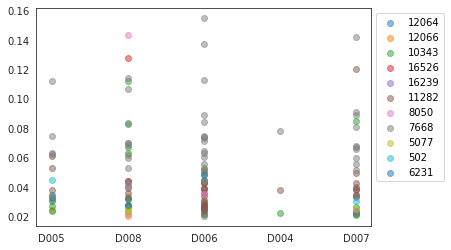

In [100]:
plt.rcParams.update({'text.color': 'black'})

for pos in list(set(mult_df['POS'])):
    print(pos)
    df_temp = mult_df[mult_df['POS']==pos]
    #plt.figure(figsize=(5,5))
    plt.scatter(df_temp['cohort'],df_temp['freq'],label=pos,alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))


#### uncommon variants

In [30]:
sing_df = lofreq_isnvs_hc.copy()

for var_pos in list(set(sing_df['POS'])):
    temp_df = sing_df[sing_df['POS']==var_pos]
    anim = len(list(set(temp_df['animal'])))
    if anim > 1:
        print(var_pos)
        print(anim)
        sing_df = sing_df[sing_df['POS']!=var_pos]
        tis = len(list(set(temp_df['description'])))


11282
12
6231
2
10343
11
16526
4
12064
3
12066
2
16239
3
8050
3
5077
2
7668
13
502
2


In [31]:
sing_df

#CHROM    POS ID REF ALT  QUAL FILTER  \
48    KU182905.1   7603  .   T   G   727   PASS   
56    KU182905.1  11554  .   A   G   701   PASS   
178   KU182905.1   8931  .   A   G  1677   PASS   
186   KU182905.1  16909  .   T   C   605   PASS   
200   KU182905.1   8168  .   A   T   301   PASS   
...          ...    ... ..  ..  ..   ...    ...   
1307  KU182905.1   4531  .   A   C   427   PASS   
1319  KU182905.1  18411  .   A   G   113   PASS   
1398  KU182905.1  18584  .   C   T   110   PASS   
1401  KU182905.1   2997  .   T   C  1522   PASS   
1429  KU182905.1   2458  .   T   G  2434   PASS   

                                                INFO  \
48        DP=1392;AF=0.029454;SB=5;DP4=703,645,26,16   
56        DP=1879;AF=0.022352;SB=5;DP4=845,982,18,29   
178        DP=285;AF=0.217544;SB=9;DP4=109,111,39,25   
186        DP=342;AF=0.078947;SB=1;DP4=180,134,15,13   
200        DP=850;AF=0.021176;SB=4;DP4=345,484,11,10   
...                                              ...   
1307       DP=971;AF=0.025747;SB=18;DP4=792,152,27,0   
1319          DP=191;AF=0.031414;SB=6;DP4=83,102,1,5   
1398          DP=234;AF=0.025641;SB=5;DP4=186,39,4,2   
1401     DP=1652;AF=0.046610;SB=2;DP4=502,1069,28,53   
1429  DP=4846;AF=0.029303;SB=17;DP4=2870,1824,107,44   

                       description  animal cohort              tissue  depth  \
48              Spleen_RA0717_D004  RA0717   D004              Spleen   1392   
56              Spleen_RA0717_D004  RA0717   D004              Spleen   1879   
178       Lymph node 1_RA0700_D007  RA0700   D007     Lymph node (ax)    285   
186       Lymph node 1_RA0700_D007  RA0700   D007     Lymph node (ax)    342   
200       Lymph node 2_RA0700_D007  RA0700   D007    Lymph node (ing)    850   
...                            ...     ...    ...                 ...    ...   
1307  Whole blood_D008_RA1779_D008  RA1779   D008  Whole blood (D008)    971   
1319  Whole blood_D008_RA1779_D008  RA1779   D008  Whole blood (D008)    191   
1398  Whole blood_D008_RA1423_D008  RA1423   D008  Whole blood (D008)    234   
1401  Whole blood_D005_RA1639_D005  RA1639   D005  Whole blood (D005)   1652   
1429  Whole blood_D006_RA1074_D006  RA1074   D006  Whole blood (D006)   4846   

          freq   qual                 reads  variant_reads alleles  
48    0.029454   SB=5     DP4=703,645,26,16           41.0      TG  
56    0.022352   SB=5     DP4=845,982,18,29           42.0      AG  
178   0.217544   SB=9     DP4=109,111,39,25           62.0      AG  
186   0.078947   SB=1     DP4=180,134,15,13           27.0      TC  
200   0.021176   SB=4     DP4=345,484,11,10           18.0      AT  
...        ...    ...                   ...            ...     ...  
1307  0.025747  SB=18      DP4=792,152,27,0           25.0      AC  
1319  0.031414   SB=6        DP4=83,102,1,5            6.0      AG  
1398  0.025641   SB=5        DP4=186,39,4,2            6.0      CT  
1401  0.046610   SB=2    DP4=502,1069,28,53           77.0      TC  
1429  0.029303  SB=17  DP4=2870,1824,107,44          142.0      TG  

[112 rows x 18 columns]

#### number of variants by animal/cohort

In [32]:
sing_df['description'].value_counts()

Lymph node 2_RA1818_D006        10
Lymph node 3_RA1423_D008         9
Lymph node 1_RA1790_D007         8
Lymph node 3_RA1779_D008         8
Lymph node 2_RA1423_D008         7
Sex Organ_RA1779_D008            6
Lymph node 3_RA1818_D006         5
Kidney_RA1423_D008               5
Lymph node 2_RA1790_D007         5
Lymph node 3_RA0700_D007         4
Lymph node 1_RA0917_D006         4
Lymph node 3_RA1325_D006         4
Lymph node 3_RA1790_D007         4
Lymph node 2_RA0917_D006         3
Lymph node 1_RA1779_D008         3
Whole blood_D008_RA1779_D008     3
Lymph node 2_RA0700_D007         3
Lymph node 3_RA0917_D006         3
Spleen_RA0717_D004               2
Lymph node 1_RA0700_D007         2
Spleen_RA1779_D008               2
Spleen_RA1423_D008               1
Lymph node 1_RA1423_D008         1
Lymph node 1_RA1818_D006         1
Spleen_RA1639_D005               1
Spleen_RA0452_D005               1
Spleen2_RA1074_D006              1
Kidney_RA1074_D006               1
Lymph node 3_RA1074_

In [33]:
sing_df['description'].value_counts()

Lymph node 2_RA1818_D006        10
Lymph node 3_RA1423_D008         9
Lymph node 1_RA1790_D007         8
Lymph node 3_RA1779_D008         8
Lymph node 2_RA1423_D008         7
Sex Organ_RA1779_D008            6
Lymph node 3_RA1818_D006         5
Kidney_RA1423_D008               5
Lymph node 2_RA1790_D007         5
Lymph node 3_RA0700_D007         4
Lymph node 1_RA0917_D006         4
Lymph node 3_RA1325_D006         4
Lymph node 3_RA1790_D007         4
Lymph node 2_RA0917_D006         3
Lymph node 1_RA1779_D008         3
Whole blood_D008_RA1779_D008     3
Lymph node 2_RA0700_D007         3
Lymph node 3_RA0917_D006         3
Spleen_RA0717_D004               2
Lymph node 1_RA0700_D007         2
Spleen_RA1779_D008               2
Spleen_RA1423_D008               1
Lymph node 1_RA1423_D008         1
Lymph node 1_RA1818_D006         1
Spleen_RA1639_D005               1
Spleen_RA0452_D005               1
Spleen2_RA1074_D006              1
Kidney_RA1074_D006               1
Lymph node 3_RA1074_

(0.0, 0.5)

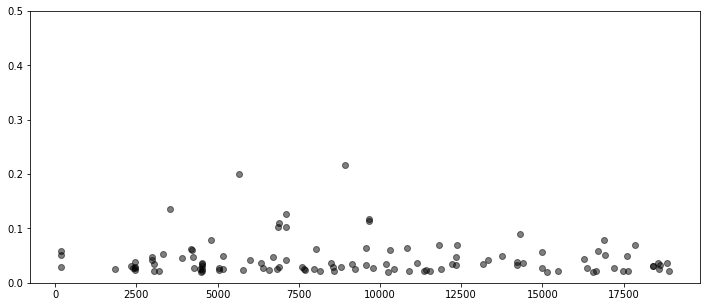

In [34]:
plt.figure(figsize=(12,5))

plt.scatter(sing_df['POS'],sing_df['freq'],color='black',alpha=.5)

plt.ylim(0,0.5)
#plt.xlim(10000,11500)


(0.0, 0.5)

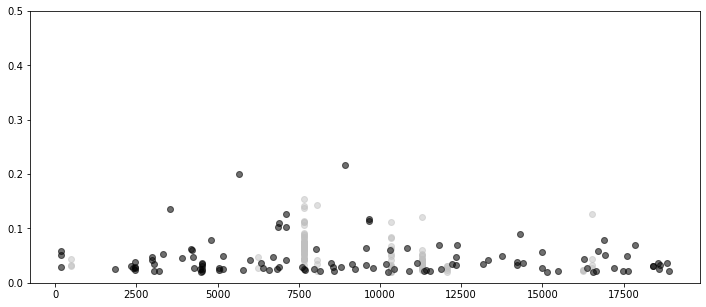

In [35]:
plt.figure(figsize=(12,5))

plt.scatter(lofreq_isnvs_hc['POS'],lofreq_isnvs_hc['freq'],color='silver',alpha=.5)
plt.scatter(sing_df['POS'],sing_df['freq'],color='black',alpha=.5)

plt.ylim(0,0.5)
#plt.xlim(10000,11500)


In [36]:
sing_df[(sing_df['POS']>9000)&(sing_df['POS']<10000)]

#CHROM   POS ID REF ALT  QUAL FILTER  \
295   KU182905.1  9129  .   T   C   301   PASS   
398   KU182905.1  9586  .   A   C   666   PASS   
495   KU182905.1  9568  .   A   G   339   PASS   
705   KU182905.1  9782  .   G   A   470   PASS   
947   KU182905.1  9651  .   T   C  3107   PASS   
948   KU182905.1  9654  .   T   C  3163   PASS   
1006  KU182905.1  9238  .   A   G  5052   PASS   

                                                 INFO  \
295          DP=469;AF=0.034115;SB=2;DP4=326,127,13,3   
398           DP=484;AF=0.064050;SB=0;DP4=99,352,6,27   
495           DP=542;AF=0.033210;SB=1;DP4=86,435,4,17   
705        DP=1432;AF=0.027235;SB=0;DP4=1261,121,46,4   
947        DP=1146;AF=0.113438;SB=1;DP4=469,534,62,77   
948        DP=1122;AF=0.117647;SB=3;DP4=469,512,62,78   
1006  DP=11531;AF=0.025757;SB=1;DP4=6654,4564,184,120   

                   description  animal cohort            tissue  depth  \
295   Lymph node 1_RA1779_D008  RA1779   D008   Lymph node (ax)    469   
398   Lymph node 1_RA1790_D007  RA1790   D007   Lymph node (ax)    484   
495   Lymph node 2_RA1818_D006  RA1818   D006  Lymph node (ing)    542   
705   Lymph node 2_RA0917_D006  RA0917   D006  Lymph node (ing)   1432   
947   Lymph node 2_RA1423_D008  RA1423   D008  Lymph node (ing)   1146   
948   Lymph node 2_RA1423_D008  RA1423   D008  Lymph node (ing)   1122   
1006  Lymph node 3_RA1423_D008  RA1423   D008  Lymph node (mes)  11531   

          freq  qual                  reads  variant_reads alleles  
295   0.034115  SB=2       DP4=326,127,13,3           16.0      TC  
398   0.064050  SB=0        DP4=99,352,6,27           31.0      AC  
495   0.033210  SB=1        DP4=86,435,4,17           18.0      AG  
705   0.027235  SB=0      DP4=1261,121,46,4           39.0      GA  
947   0.113438  SB=1      DP4=469,534,62,77          130.0      TC  
948   0.117647  SB=3      DP4=469,512,62,78          132.0      TC  
1006  0.025757  SB=1  DP4=6654,4564,184,120          297.0      AG

In [16]:
sing_df['POS'].value_counts()

4531     5
2458     4
169      3
2997     2
6890     2
        ..
17847    1
13770    1
12380    1
11425    1
18584    1
Name: POS, Length: 100, dtype: int64

In [17]:
lofreq_isnvs_hc[lofreq_isnvs_hc['POS']==169]

#CHROM  POS ID REF ALT  QUAL FILTER  \
238   KU182905.1  169  .   A   G   569   PASS   
299   KU182905.1  169  .   A   G   149   PASS   
1306  KU182905.1  169  .   A   G   148   PASS   

                                         INFO                   description  \
238   DP=463;AF=0.058315;SB=6;DP4=422,12,27,2            Spleen_RA1779_D008   
299    DP=268;AF=0.029851;SB=2;DP4=238,22,7,1      Lymph node 3_RA1779_D008   
1306   DP=138;AF=0.050725;SB=14;DP4=126,4,6,2  Whole blood_D008_RA1779_D008   

      animal cohort              tissue  depth      freq   qual  \
238   RA1779   D008              Spleen    463  0.058315   SB=6   
299   RA1779   D008    Lymph node (mes)    268  0.029851   SB=2   
1306  RA1779   D008  Whole blood (D008)    138  0.050725  SB=14   

                reads  variant_reads alleles  
238   DP4=422,12,27,2           27.0      AG  
299    DP4=238,22,7,1            8.0      AG  
1306    DP4=126,4,6,2            7.0      AG

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 0.3)

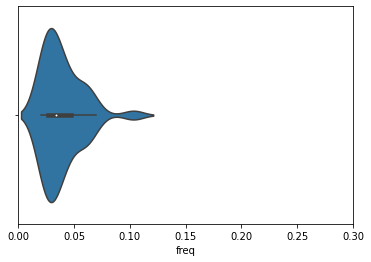

In [18]:
sns.violinplot(sing_df[sing_df['cohort']=='D006']['freq'])
plt.xlim(0,0.3)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 0.3)

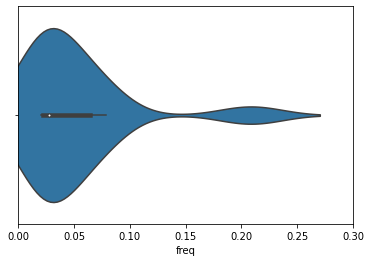

In [19]:
sns.violinplot(sing_df[sing_df['cohort']=='D007']['freq'])
plt.xlim(0,0.3)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 0.3)

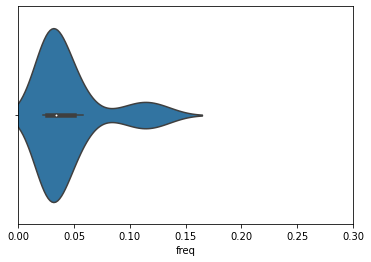

In [20]:
sns.violinplot(sing_df[sing_df['cohort']=='D008']['freq'])
plt.xlim(0,0.3)

In [21]:
sing_df[sing_df['freq']>0.05]['cohort'].value_counts()

D008    12
D007     8
D006     8
Name: cohort, dtype: int64

In [22]:
sing_df['cohort'].value_counts()

D008    46
D006    35
D007    26
D005     3
D004     2
Name: cohort, dtype: int64

In [23]:
sing_df[sing_df['animal']=='RA0700']['POS'].value_counts()

8931     1
16909    1
8168     1
11350    1
16653    1
3197     1
5052     1
11891    1
14390    1
Name: POS, dtype: int64

In [24]:
sing_df[sing_df['animal']=='RA0917']['tissue'].value_counts()

Lymph node (ax)     4
Lymph node (ing)    3
Lymph node (mes)    3
Name: tissue, dtype: int64

In [25]:
lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1818']['description'].value_counts()


Lymph node 2_RA1818_D006        15
Lymph node 3_RA1818_D006         7
Whole blood_D006_RA1818_D006     4
Lymph node 1_RA1818_D006         3
Skin_RA1818_D006                 2
Name: description, dtype: int64

In [26]:
lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1818']['POS'].value_counts()


7668     5
10343    4
11282    3
14211    1
14235    1
12341    1
12221    1
6870     1
2340     1
17625    1
16526    1
14988    1
6592     1
11138    1
9568     1
8050     1
6338     1
4258     1
4205     1
4183     1
3050     1
18911    1
Name: POS, dtype: int64

In [27]:
matrix_builder_lofreq(lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1818'])[0]

NameError: name 'matrix_builder_lofreq' is not defined

In [28]:
shared_df = pd.read_table('gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/shared_variants.csv',sep=',')
shared_df.head()


animal  shared  total  perc shared Unnamed: 4
0  RA1423     4.0    5.0          0.8     spleen
1  RA1423     4.0    5.0          0.8         WB
2  RA1423     2.0    5.0          0.4        LN1
3  RA1423     2.0    5.0          0.4        LN2
4  RA1423     2.0    5.0          0.4     kidney

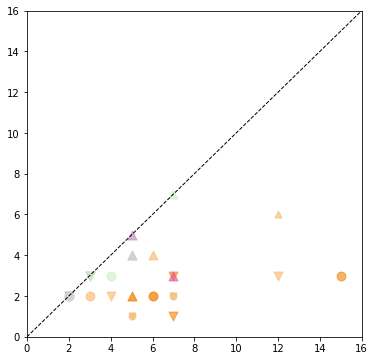

In [29]:
plt.figure(figsize=(6,6))

plt.xlim(0,16)
plt.ylim(0,16)

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)

df_temp = shared_df[shared_df['Unnamed: 4']=='spleen']
df_temp2 = df_temp[(df_temp['animal']=='RA1423')|(df_temp['animal'] == 'RA1779')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#BC80BD',marker='^',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA1790')|(df_temp['animal'] == 'RA0700')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#BC80BD',marker='v',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA0917')|(df_temp['animal'] == 'RA1818')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#BC80BD',marker='o',s=80,alpha=0.6)

df_temp = shared_df[shared_df['Unnamed: 4']=='WB']
df_temp2 = df_temp[(df_temp['animal']=='RA1423')|(df_temp['animal'] == 'RA1779')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#CCEBC5',marker='^',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA1790')|(df_temp['animal'] == 'RA0700')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#CCEBC5',marker='v',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA0917')|(df_temp['animal'] == 'RA1818')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#CCEBC5',marker='o',s=80,alpha=0.6)

df_temp = shared_df[shared_df['Unnamed: 4']=='LN1']
df_temp2 = df_temp[(df_temp['animal']=='RA1423')|(df_temp['animal'] == 'RA1779')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#FDB462',marker='^',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA1790')|(df_temp['animal'] == 'RA0700')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#FDB462',marker='v',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA0917')|(df_temp['animal'] == 'RA1818')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#FDB462',marker='o',s=80,alpha=0.6)
 
df_temp = shared_df[shared_df['Unnamed: 4']=='LN2']
df_temp2 = df_temp[(df_temp['animal']=='RA1423')|(df_temp['animal'] == 'RA1779')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#ed830c',marker='^',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA1790')|(df_temp['animal'] == 'RA0700')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#ed830c',marker='v',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA0917')|(df_temp['animal'] == 'RA1818')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#ed830c',marker='o',s=80,alpha=0.6)

df_temp = shared_df[shared_df['Unnamed: 4']=='LN3']
df_temp2 = df_temp[(df_temp['animal']=='RA1423')|(df_temp['animal'] == 'RA1779')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#f5b771',marker='^',s=50,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA1790')|(df_temp['animal'] == 'RA0700')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#f5b771',marker='v',s=50,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA0917')|(df_temp['animal'] == 'RA1818')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#f5b771',marker='o',s=50,alpha=0.6)

df_temp = shared_df[shared_df['Unnamed: 4']=='Kidney']
df_temp2 = df_temp[(df_temp['animal']=='RA1423')|(df_temp['animal'] == 'RA1779')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#BEBADA',marker='^',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA1790')|(df_temp['animal'] == 'RA0700')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#BEBADA',marker='v',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA0917')|(df_temp['animal'] == 'RA1818')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#BEBADA',marker='o',s=80,alpha=0.6)

df_temp = shared_df[shared_df['Unnamed: 4']=='SO']
df_temp2 = df_temp[(df_temp['animal']=='RA1423')|(df_temp['animal'] == 'RA1779')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#e64e9b',marker='^',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA1790')|(df_temp['animal'] == 'RA0700')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#e64e9b',marker='v',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA0917')|(df_temp['animal'] == 'RA1818')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#e64e9b',marker='o',s=80,alpha=0.6)

df_temp = shared_df[shared_df['Unnamed: 4']=='skin']
df_temp2 = df_temp[(df_temp['animal']=='RA1423')|(df_temp['animal'] == 'RA1779')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#D9D9D9',marker='^',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA1790')|(df_temp['animal'] == 'RA0700')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#D9D9D9',marker='v',s=80,alpha=0.6)
df_temp2 = df_temp[(df_temp['animal']=='RA0917')|(df_temp['animal'] == 'RA1818')]
plt.scatter(df_temp2['total'],df_temp2['shared'],color='#D9D9D9',marker='o',s=80,alpha=0.6)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.1)

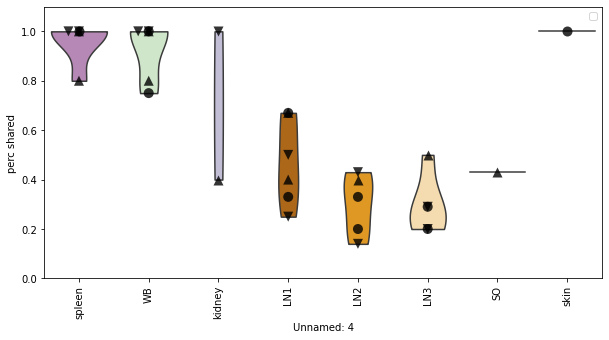

In [30]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['#BC80BD','#FDB462','#ed830c','#f5b771','#e64e9b','#BEBADA','#CCEBC5','#CCEBC5','#CCEBC5']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.violinplot(x='Unnamed: 4',y='perc shared',data=shared_df,cut=0,
                   order=['spleen','WB','kidney','LN1','LN2','LN3','SO','skin'],
                   palette=['#BC80BD','#CCEBC5','#BEBADA','#C56900','#FF9F06','#FFDFA5','#e64e9b','#D9D9D9'],
                   inner=None)
g = sns.swarmplot(x='Unnamed: 4',y='perc shared',data=shared_df[(shared_df['animal']=='RA1423')|(shared_df['animal']=='RA1779')],
                   order=['spleen','WB','kidney','LN1','LN2','LN3','SO','skin'],color='black',s=10,alpha=0.8,marker='^')
g = sns.swarmplot(x='Unnamed: 4',y='perc shared',data=shared_df[(shared_df['animal']=='RA1790')|(shared_df['animal']=='RA0700')],
                   order=['spleen','WB','kidney','LN1','LN2','LN3','SO','skin'],color='black',s=10,alpha=0.8,marker='v')
g = sns.swarmplot(x='Unnamed: 4',y='perc shared',data=shared_df[(shared_df['animal']=='RA0917')|(shared_df['animal']=='RA1818')],
                   order=['spleen','WB','kidney','LN1','LN2','LN3','SO','skin'],color='black',s=10,alpha=0.8,marker='o')

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(0,1.1)




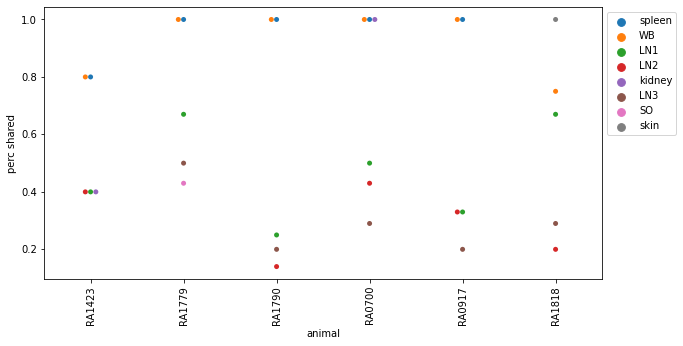

In [31]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['#BC80BD','#FDB462','#ed830c','#f5b771','#e64e9b','#BEBADA','#CCEBC5','#CCEBC5','#CCEBC5']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='animal',y='perc shared',data=shared_df,hue='Unnamed: 4')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1))


In [32]:
sing_df[sing_df['animal']=='RA1423']['tissue'].value_counts()

Lymph node (mes)      9
Lymph node (ing)      7
Kidney                5
Spleen                1
Lymph node (ax)       1
Whole blood (D008)    1
Name: tissue, dtype: int64

In [33]:
lofreq_isnvs_hc['tissue'].replace('Whole blood (D008)', 'Whole blood', inplace=True)
lofreq_isnvs_hc['tissue'].replace('Whole blood (D005)', 'Whole blood', inplace=True)
lofreq_isnvs_hc['tissue'].replace('Whole blood (D006)', 'Whole blood', inplace=True)
lofreq_isnvs_hc['tissue'].replace('Whole blood (D007)', 'Whole blood', inplace=True)


In [34]:
sing_df[sing_df['description']=='Kidney_RA1074_D006']

#CHROM   POS ID REF ALT  QUAL FILTER  \
1136  KU182905.1  2458  .   T   G   630   PASS   

                                           INFO         description  animal  \
1136  DP=856;AF=0.037383;SB=1;DP4=415,398,22,19  Kidney_RA1074_D006  RA1074   

     cohort  tissue  depth      freq  qual              reads  variant_reads  \
1136   D006  Kidney    856  0.037383  SB=1  DP4=415,398,22,19           32.0   

     alleles  
1136      TG

In [35]:
sing_df['description'].value_counts()

Lymph node 2_RA1818_D006        10
Lymph node 3_RA1423_D008         9
Lymph node 1_RA1790_D007         8
Lymph node 3_RA1779_D008         8
Lymph node 2_RA1423_D008         7
Sex Organ_RA1779_D008            6
Lymph node 3_RA1818_D006         5
Kidney_RA1423_D008               5
Lymph node 2_RA1790_D007         5
Lymph node 3_RA0700_D007         4
Lymph node 1_RA0917_D006         4
Lymph node 3_RA1325_D006         4
Lymph node 3_RA1790_D007         4
Lymph node 2_RA0917_D006         3
Lymph node 1_RA1779_D008         3
Whole blood_D008_RA1779_D008     3
Lymph node 2_RA0700_D007         3
Lymph node 3_RA0917_D006         3
Spleen_RA0717_D004               2
Lymph node 1_RA0700_D007         2
Spleen_RA1779_D008               2
Spleen_RA1423_D008               1
Lymph node 1_RA1423_D008         1
Lymph node 1_RA1818_D006         1
Spleen_RA1639_D005               1
Spleen_RA0452_D005               1
Spleen2_RA1074_D006              1
Kidney_RA1074_D006               1
Lymph node 3_RA1074_

In [36]:
sing_df.groupby('description').size()

description
Kidney_RA1074_D006               1
Kidney_RA1423_D008               5
Lymph node 1_RA0700_D007         2
Lymph node 1_RA0917_D006         4
Lymph node 1_RA1423_D008         1
Lymph node 1_RA1779_D008         3
Lymph node 1_RA1790_D007         8
Lymph node 1_RA1818_D006         1
Lymph node 2_RA0700_D007         3
Lymph node 2_RA0917_D006         3
Lymph node 2_RA1423_D008         7
Lymph node 2_RA1790_D007         5
Lymph node 2_RA1818_D006        10
Lymph node 3_RA0700_D007         4
Lymph node 3_RA0917_D006         3
Lymph node 3_RA1074_D006         1
Lymph node 3_RA1325_D006         4
Lymph node 3_RA1423_D008         9
Lymph node 3_RA1779_D008         8
Lymph node 3_RA1790_D007         4
Lymph node 3_RA1818_D006         5
Sex Organ_RA1779_D008            6
Spleen2_RA1074_D006              1
Spleen_RA0452_D005               1
Spleen_RA0717_D004               2
Spleen_RA1423_D008               1
Spleen_RA1639_D005               1
Spleen_RA1779_D008               2
Whole bl

In [37]:
sing_df.groupby('description')['freq'].mean()

description
Kidney_RA1074_D006              0.037383
Kidney_RA1423_D008              0.039754
Lymph node 1_RA0700_D007        0.148246
Lymph node 1_RA0917_D006        0.053706
Lymph node 1_RA1423_D008        0.035126
Lymph node 1_RA1779_D008        0.058432
Lymph node 1_RA1790_D007        0.044735
Lymph node 1_RA1818_D006        0.024328
Lymph node 2_RA0700_D007        0.021614
Lymph node 2_RA0917_D006        0.029807
Lymph node 2_RA1423_D008        0.077582
Lymph node 2_RA1790_D007        0.080952
Lymph node 2_RA1818_D006        0.039780
Lymph node 3_RA0700_D007        0.026465
Lymph node 3_RA0917_D006        0.037034
Lymph node 3_RA1074_D006        0.023947
Lymph node 3_RA1325_D006        0.035662
Lymph node 3_RA1423_D008        0.041047
Lymph node 3_RA1779_D008        0.027803
Lymph node 3_RA1790_D007        0.024723
Lymph node 3_RA1818_D006        0.049297
Sex Organ_RA1779_D008           0.052140
Spleen2_RA1074_D006             0.026998
Spleen_RA0452_D005              0.020725
Sple

In [38]:
all_bin = matrix_builder_lofreq(sing_df)[0]
all_freq = matrix_builder_lofreq(sing_df)[1]

sns.clustermap(all_freq.corr(),vmin=0,vmax=1,cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))


NameError: name 'matrix_builder_lofreq' is not defined

In [39]:
all_bin = matrix_builder_lofreq(lofreq_isnvs_hc[(lofreq_isnvs_hc['tissue']!='Liver')&(lofreq_isnvs_hc['tissue']!='Skin (nonrash)')])[0]
all_freq = matrix_builder_lofreq(lofreq_isnvs_hc)[1]

sns.set(font_scale = 1.5)

fig = sns.clustermap(all_bin.corr(),vmin=0,vmax=1,cmap='Greys')

fig.savefig("corr_tissues.pdf") 



NameError: name 'matrix_builder_lofreq' is not defined

In [107]:
!gsutil -m cp corr_tissues.pdf gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/

Copying file://corr_tissues.pdf [Content-Type=application/pdf]...
/ [1/1 files][ 15.1 KiB/ 15.1 KiB] 100% Done                                    
Operation completed over 1 objects/15.1 KiB.                                     


In [62]:
lofreq_isnvs_hc[lofreq_isnvs_hc['tissue']=='Sex Organ']

#CHROM   POS ID REF ALT  QUAL FILTER  \
269  KU182905.1  3551  .   A   G  3582   PASS   
270  KU182905.1  4531  .   A   C   591   PASS   
274  KU182905.1  6695  .   A   G   712   PASS   
275  KU182905.1  6890  .   A   T   150   PASS   
276  KU182905.1  7104  .   A   G   772   PASS   
277  KU182905.1  7668  .   T   C  1612   PASS   
280  KU182905.1  7974  .   C   T   179   PASS   

                                           INFO            description  \
269  DP=1074;AF=0.135940;SB=2;DP4=500,422,78,73  Sex Organ_RA1779_D008   
270     DP=943;AF=0.033934;SB=0;DP4=859,50,31,1  Sex Organ_RA1779_D008   
274     DP=750;AF=0.046667;SB=0;DP4=83,614,6,39  Sex Organ_RA1779_D008   
275      DP=279;AF=0.028674;SB=0;DP4=185,83,8,3  Sex Organ_RA1779_D008   
276   DP=926;AF=0.042117;SB=2;DP4=556,321,29,13  Sex Organ_RA1779_D008   
277  DP=1054;AF=0.068311;SB=0;DP4=553,412,47,33  Sex Organ_RA1779_D008   
280      DP=392;AF=0.025510;SB=0;DP4=62,320,1,9  Sex Organ_RA1779_D008   

     animal cohort     tissue  depth      freq  qual              reads  \
269  RA1779   D008  Sex Organ   1074  0.135940  SB=2  DP4=500,422,78,73   
270  RA1779   D008  Sex Organ    943  0.033934  SB=0    DP4=859,50,31,1   
274  RA1779   D008  Sex Organ    750  0.046667  SB=0    DP4=83,614,6,39   
275  RA1779   D008  Sex Organ    279  0.028674  SB=0     DP4=185,83,8,3   
276  RA1779   D008  Sex Organ    926  0.042117  SB=2  DP4=556,321,29,13   
277  RA1779   D008  Sex Organ   1054  0.068311  SB=0  DP4=553,412,47,33   
280  RA1779   D008  Sex Organ    392  0.025510  SB=0     DP4=62,320,1,9   

     variant_reads alleles  
269          146.0      AG  
270           32.0      AC  
274           35.0      AG  
275            8.0      AT  
276           39.0      AG  
277           72.0      TC  
280           10.0      CT

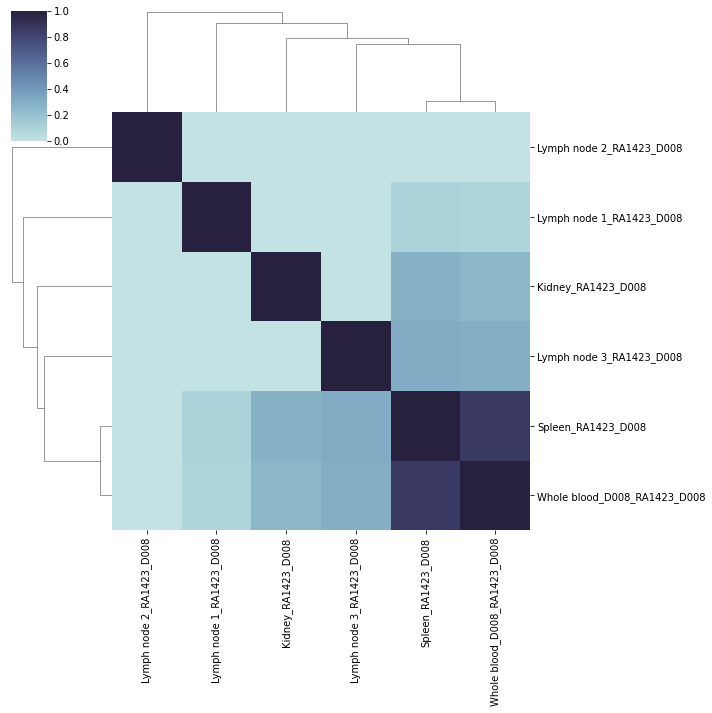

In [24]:
all_bin = matrix_builder_lofreq(lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1423'])[0]
all_freq = matrix_builder_lofreq(lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1423'])[1]

sns.clustermap(all_freq.corr(),vmin=0,vmax=1,cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))


In [75]:
all_bin = matrix_builder_lofreq(lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1818'])[0]
all_freq = matrix_builder_lofreq(lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1818'])[1]

sns.clustermap(all_freq.corr(),vmin=0,vmax=1,cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))


NameError: name 'matrix_builder_lofreq' is not defined

In [76]:
sing_df[sing_df['animal']=='RA1779']


#CHROM    POS ID REF ALT  QUAL FILTER  \
238   KU182905.1    169  .   A   G   569   PASS   
240   KU182905.1   4531  .   A   C  2350   PASS   
269   KU182905.1   3551  .   A   G  3582   PASS   
270   KU182905.1   4531  .   A   C   591   PASS   
274   KU182905.1   6695  .   A   G   712   PASS   
275   KU182905.1   6890  .   A   T   150   PASS   
276   KU182905.1   7104  .   A   G   772   PASS   
280   KU182905.1   7974  .   C   T   179   PASS   
285   KU182905.1   4531  .   A   C   507   PASS   
289   KU182905.1   6890  .   A   T  2170   PASS   
295   KU182905.1   9129  .   T   C   301   PASS   
299   KU182905.1    169  .   A   G   149   PASS   
301   KU182905.1   1856  .   G   A   989   PASS   
302   KU182905.1   2408  .   T   G   361   PASS   
304   KU182905.1   4277  .   G   A   270   PASS   
305   KU182905.1   4531  .   A   C   651   PASS   
312   KU182905.1   6386  .   T   G  1290   PASS   
325   KU182905.1  12353  .   A   C   602   PASS   
331   KU182905.1  18411  .   A   G   236   PASS   
1306  KU182905.1    169  .   A   G   148   PASS   
1307  KU182905.1   4531  .   A   C   427   PASS   
1319  KU182905.1  18411  .   A   G   113   PASS   

                                              INFO  \
238        DP=463;AF=0.058315;SB=6;DP4=422,12,27,2   
240   DP=3585;AF=0.035983;SB=1;DP4=2836,615,107,25   
269     DP=1074;AF=0.135940;SB=2;DP4=500,422,78,73   
270        DP=943;AF=0.033934;SB=0;DP4=859,50,31,1   
274        DP=750;AF=0.046667;SB=0;DP4=83,614,6,39   
275         DP=279;AF=0.028674;SB=0;DP4=185,83,8,3   
276      DP=926;AF=0.042117;SB=2;DP4=556,321,29,13   
280         DP=392;AF=0.025510;SB=0;DP4=62,320,1,9   
285       DP=884;AF=0.031674;SB=0;DP4=736,115,28,4   
289        DP=831;AF=0.109507;SB=5;DP4=631,99,92,9   
295       DP=469;AF=0.034115;SB=2;DP4=326,127,13,3   
299         DP=268;AF=0.029851;SB=2;DP4=238,22,7,1   
301     DP=2394;AF=0.025480;SB=5;DP4=2036,290,62,5   
302       DP=723;AF=0.027663;SB=2;DP4=304,398,7,14   
304       DP=549;AF=0.027322;SB=0;DP4=350,180,13,5   
305     DP=1847;AF=0.022198;SB=1;DP4=1542,262,35,7   
312   DP=2776;AF=0.026657;SB=5;DP4=1252,1437,34,51   
325      DP=1036;AF=0.031853;SB=1;DP4=296,703,9,27   
331       DP=414;AF=0.031401;SB=7;DP4=179,222,3,10   
1306        DP=138;AF=0.050725;SB=14;DP4=126,4,6,2   
1307     DP=971;AF=0.025747;SB=18;DP4=792,152,27,0   
1319        DP=191;AF=0.031414;SB=6;DP4=83,102,1,5   

                       description  animal cohort              tissue  depth  \
238             Spleen_RA1779_D008  RA1779   D008              Spleen    463   
240             Spleen_RA1779_D008  RA1779   D008              Spleen   3585   
269          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ   1074   
270          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ    943   
274          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ    750   
275          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ    279   
276          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ    926   
280          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ    392   
285       Lymph node 1_RA1779_D008  RA1779   D008     Lymph node (ax)    884   
289       Lymph node 1_RA1779_D008  RA1779   D008     Lymph node (ax)    831   
295       Lymph node 1_RA1779_D008  RA1779   D008     Lymph node (ax)    469   
299       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)    268   
301       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)   2394   
302       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)    723   
304       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)    549   
305       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)   1847   
312       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)   2776   
325       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)   1036   
331       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)    

In [77]:
lofreq_isnvs[(lofreq_isnvs['animal_ID']=='RA1803')&(lofreq_isnvs['POS']==10343)]


NameError: name 'lofreq_isnvs' is not defined

In [78]:
lofreq_isnvs_hc[lofreq_isnvs_hc['animal']=='RA1803']


#CHROM    POS ID REF ALT  QUAL FILTER  \
15    KU182905.1   7668  .   T   C  1716   PASS   
20    KU182905.1  10343  .   C   A   332   PASS   
22    KU182905.1  11282  .   A   C   861   PASS   
31    KU182905.1   7668  .   T   C   996   PASS   
1501  KU182905.1   7668  .   T   C  3614   PASS   
1510  KU182905.1  10343  .   C   A   595   PASS   
1514  KU182905.1  11282  .   A   C  1931   PASS   

                                               INFO  \
15      DP=1942;AF=0.044284;SB=7;DP4=1003,842,42,48   
20         DP=646;AF=0.029412;SB=0;DP4=278,345,9,13   
22       DP=1065;AF=0.042254;SB=0;DP4=609,409,27,19   
31        DP=778;AF=0.060411;SB=8;DP4=359,365,30,19   
1501  DP=3548;AF=0.050169;SB=0;DP4=1267,2097,66,113   
1510     DP=1744;AF=0.021789;SB=0;DP4=759,943,19,22   
1514    DP=2746;AF=0.038602;SB=1;DP4=1679,959,67,41   

                       description  animal cohort              tissue  depth  \
15              Spleen_RA1803_D006  RA1803   D006              Spleen   1942   
20              Spleen_RA1803_D006  RA1803   D006              Spleen    646   
22              Spleen_RA1803_D006  RA1803   D006              Spleen   1065   
31               Liver_RA1803_D006  RA1803   D006               Liver    778   
1501  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   3548   
1510  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   1744   
1514  Whole blood_D006_RA1803_D006  RA1803   D006  Whole blood (D006)   2746   

          freq  qual                 reads  variant_reads alleles  
15    0.044284  SB=7    DP4=1003,842,42,48           86.0      TC  
20    0.029412  SB=0      DP4=278,345,9,13           19.0      CA  
22    0.042254  SB=0     DP4=609,409,27,19           45.0      AC  
31    0.060411  SB=8     DP4=359,365,30,19           47.0      TC  
1501  0.050169  SB=0  DP4=1267,2097,66,113          178.0      TC  
1510  0.021789  SB=0     DP4=759,943,19,22           38.0      CA  
1514  0.038602  SB=1    DP4=1679,959,67,41          106.0      AC

In [79]:
sing_df[sing_df['freq']>0.1]


#CHROM   POS ID REF ALT   QUAL FILTER  \
178  KU182905.1  8931  .   A   G   1677   PASS   
269  KU182905.1  3551  .   A   G   3582   PASS   
289  KU182905.1  6890  .   A   T   2170   PASS   
418  KU182905.1  5667  .   A   G   6396   PASS   
522  KU182905.1  6870  .   A   T  13104   PASS   
940  KU182905.1  7102  .   T   C  18597   PASS   
947  KU182905.1  9651  .   T   C   3107   PASS   
948  KU182905.1  9654  .   T   C   3163   PASS   
990  KU182905.1  7109  .   A   T  49314   PASS   

                                                  INFO  \
178          DP=285;AF=0.217544;SB=9;DP4=109,111,39,25   
269         DP=1074;AF=0.135940;SB=2;DP4=500,422,78,73   
289            DP=831;AF=0.109507;SB=5;DP4=631,99,92,9   
418        DP=1218;AF=0.199507;SB=0;DP4=220,745,55,196   
522       DP=5451;AF=0.103284;SB=5;DP4=4313,543,517,75   
940     DP=6123;AF=0.125919;SB=9;DP4=2186,3131,305,497   
947         DP=1146;AF=0.113438;SB=1;DP4=469,534,62,77   
948         DP=1122;AF=0.117647;SB=3;DP4=469,512,62,78   
990  DP=32457;AF=0.101981;SB=5;DP4=12820,16198,1530...   

                  description  animal cohort            tissue  depth  \
178  Lymph node 1_RA0700_D007  RA0700   D007   Lymph node (ax)    285   
269     Sex Organ_RA1779_D008  RA1779   D008         Sex Organ   1074   
289  Lymph node 1_RA1779_D008  RA1779   D008   Lymph node (ax)    831   
418  Lymph node 2_RA1790_D007  RA1790   D007  Lymph node (ing)   1218   
522  Lymph node 3_RA1818_D006  RA1818   D006  Lymph node (mes)   5451   
940  Lymph node 2_RA1423_D008  RA1423   D008  Lymph node (ing)   6123   
947  Lymph node 2_RA1423_D008  RA1423   D008  Lymph node (ing)   1146   
948  Lymph node 2_RA1423_D008  RA1423   D008  Lymph node (ing)   1122   
990  Lymph node 3_RA1423_D008  RA1423   D008  Lymph node (mes)  32457   

         freq  qual                      reads  variant_reads alleles  
178  0.217544  SB=9          DP4=109,111,39,25           62.0      AG  
269  0.135940  SB=2          DP4=500,422,78,73          146.0      AG  
289  0.109507  SB=5            DP4=631,99,92,9           91.0      AT  
418  0.199507  SB=0         DP4=220,745,55,196          243.0      AG  
522  0.103284  SB=5        DP4=4313,543,517,75          563.0      AT  
940  0.125919  SB=9      DP4=2186,3131,305,497          771.0      TC  
947  0.113438  SB=1          DP4=469,534,62,77          130.0      TC  
948  0.117647  SB=3          DP4=469,512,62,78          132.0      TC  
990  0.101981  SB=5  DP4=12820,16198,1530,1858         3310.0      AT

In [80]:
sing_df[sing_df['animal']=='RA1779']['description'].value_counts()


Lymph node 3_RA1779_D008        8
Sex Organ_RA1779_D008           6
Lymph node 1_RA1779_D008        3
Whole blood_D008_RA1779_D008    3
Spleen_RA1779_D008              2
Name: description, dtype: int64

In [81]:
all_bin = matrix_builder_lofreq(sing_df[sing_df['animal']=='RA1779'])[0]
all_freq = matrix_builder_lofreq(sing_df[sing_df['animal']=='RA1779'])[1]

sns.clustermap(all_freq.corr(),vmin=0,vmax=1,cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))


NameError: name 'matrix_builder_lofreq' is not defined

In [82]:
all_bin = matrix_builder_lofreq(sing_df[sing_df['animal']=='RA0700'])[0]
all_freq = matrix_builder_lofreq(sing_df[sing_df['animal']=='RA0700'])[1]

sns.clustermap(all_freq.corr(),vmin=0,vmax=1,cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))


NameError: name 'matrix_builder_lofreq' is not defined

In [83]:
sing_df['alleles'].value_counts()


AG    36
TC    24
CT    12
GA    11
AC    10
TG     8
AT     7
TA     2
GT     2
Name: alleles, dtype: int64

In [84]:
sing_df[sing_df['cohort']=='D004']['alleles'].value_counts()


TG    1
AG    1
Name: alleles, dtype: int64

In [85]:
sing_df[sing_df['cohort']=='D005']['alleles'].value_counts()


TC    2
AG    1
Name: alleles, dtype: int64

In [86]:
sing_df[(sing_df['cohort']=='D006')&(sing_df['alleles']=='TC')]

#CHROM    POS ID REF ALT  QUAL FILTER  \
463   KU182905.1   6592  .   T   C   653   PASS   
484   KU182905.1   4183  .   T   C   324   PASS   
485   KU182905.1   4205  .   T   C   344   PASS   
486   KU182905.1   4258  .   T   C   367   PASS   
499   KU182905.1  11138  .   T   C   364   PASS   
503   KU182905.1  14988  .   T   C   198   PASS   
623   KU182905.1   6819  .   T   C  4148   PASS   
652   KU182905.1  10304  .   T   C  7275   PASS   
665   KU182905.1  11820  .   T   C  5955   PASS   
1107  KU182905.1  17202  .   T   C  1250   PASS   

                                                INFO  \
463       DP=1562;AF=0.024328;SB=3;DP4=375,1147,7,31   
484          DP=242;AF=0.061983;SB=0;DP4=115,111,8,8   
485          DP=265;AF=0.060377;SB=2;DP4=143,105,8,8   
486        DP=383;AF=0.046997;SB=13;DP4=241,120,8,11   
499         DP=552;AF=0.036232;SB=6;DP4=139,389,9,15   
503          DP=412;AF=0.026699;SB=2;DP4=202,199,4,7   
623    DP=9377;AF=0.025914;SB=1;DP4=8022,1105,220,28   
652   DP=5855;AF=0.060120;SB=7;DP4=1899,3591,138,225   
665   DP=4032;AF=0.069692;SB=6;DP4=2293,1451,187,101   
1107    DP=2674;AF=0.026926;SB=17;DP4=951,1641,19,61   

                   description  animal cohort            tissue  depth  \
463   Lymph node 1_RA1818_D006  RA1818   D006   Lymph node (ax)   1562   
484   Lymph node 2_RA1818_D006  RA1818   D006  Lymph node (ing)    242   
485   Lymph node 2_RA1818_D006  RA1818   D006  Lymph node (ing)    265   
486   Lymph node 2_RA1818_D006  RA1818   D006  Lymph node (ing)    383   
499   Lymph node 2_RA1818_D006  RA1818   D006  Lymph node (ing)    552   
503   Lymph node 2_RA1818_D006  RA1818   D006  Lymph node (ing)    412   
623   Lymph node 1_RA0917_D006  RA0917   D006   Lymph node (ax)   9377   
652   Lymph node 1_RA0917_D006  RA0917   D006   Lymph node (ax)   5855   
665   Lymph node 1_RA0917_D006  RA0917   D006   Lymph node (ax)   4032   
1107  Lymph node 3_RA1325_D006  RA1325   D006  Lymph node (mes)   2674   

          freq   qual                  reads  variant_reads alleles  
463   0.024328   SB=3      DP4=375,1147,7,31           38.0      TC  
484   0.061983   SB=0        DP4=115,111,8,8           15.0      TC  
485   0.060377   SB=2        DP4=143,105,8,8           16.0      TC  
486   0.046997  SB=13       DP4=241,120,8,11           18.0      TC  
499   0.036232   SB=6       DP4=139,389,9,15           20.0      TC  
503   0.026699   SB=2        DP4=202,199,4,7           11.0      TC  
623   0.025914   SB=1   DP4=8022,1105,220,28          243.0      TC  
652   0.060120   SB=7  DP4=1899,3591,138,225          352.0      TC  
665   0.069692   SB=6  DP4=2293,1451,187,101          281.0      TC  
1107  0.026926  SB=17     DP4=951,1641,19,61           72.0      TC

In [87]:
sing_df[sing_df['animal']=='RA0917']

#CHROM    POS ID REF ALT   QUAL FILTER  \
623  KU182905.1   6819  .   T   C   4148   PASS   
652  KU182905.1  10304  .   T   C   7275   PASS   
665  KU182905.1  11820  .   T   C   5955   PASS   
683  KU182905.1  16712  .   A   T  15247   PASS   
689  KU182905.1   4477  .   A   G    998   PASS   
694  KU182905.1   6010  .   C   T   1878   PASS   
705  KU182905.1   9782  .   G   A    470   PASS   
754  KU182905.1   8046  .   G   T  13849   PASS   
777  KU182905.1  15468  .   A   C   6239   PASS   
780  KU182905.1  16368  .   C   T  10382   PASS   

                                                  INFO  \
623      DP=9377;AF=0.025914;SB=1;DP4=8022,1105,220,28   
652     DP=5855;AF=0.060120;SB=7;DP4=1899,3591,138,225   
665     DP=4032;AF=0.069692;SB=6;DP4=2293,1451,187,101   
683   DP=12488;AF=0.059097;SB=14;DP4=3808,7917,275,485   
689        DP=3062;AF=0.020248;SB=5;DP4=2080,916,49,15   
694        DP=2313;AF=0.041937;SB=5;DP4=975,1234,40,63   
705         DP=1432;AF=0.027235;SB=0;DP4=1261,121,46,4   
754    DP=10618;AF=0.062535;SB=0;DP4=5469,4434,397,315   
777  DP=17736;AF=0.021651;SB=10;DP4=10311,6999,229,185   
780  DP=22923;AF=0.026916;SB=14;DP4=11737,10530,309...   

                  description  animal cohort            tissue  depth  \
623  Lymph node 1_RA0917_D006  RA0917   D006   Lymph node (ax)   9377   
652  Lymph node 1_RA0917_D006  RA0917   D006   Lymph node (ax)   5855   
665  Lymph node 1_RA0917_D006  RA0917   D006   Lymph node (ax)   4032   
683  Lymph node 1_RA0917_D006  RA0917   D006   Lymph node (ax)  12488   
689  Lymph node 2_RA0917_D006  RA0917   D006  Lymph node (ing)   3062   
694  Lymph node 2_RA0917_D006  RA0917   D006  Lymph node (ing)   2313   
705  Lymph node 2_RA0917_D006  RA0917   D006  Lymph node (ing)   1432   
754  Lymph node 3_RA0917_D006  RA0917   D006  Lymph node (mes)  10618   
777  Lymph node 3_RA0917_D006  RA0917   D006  Lymph node (mes)  17736   
780  Lymph node 3_RA0917_D006  RA0917   D006  Lymph node (mes)  22923   

         freq   qual                    reads  variant_reads alleles  
623  0.025914   SB=1     DP4=8022,1105,220,28          243.0      TC  
652  0.060120   SB=7    DP4=1899,3591,138,225          352.0      TC  
665  0.069692   SB=6    DP4=2293,1451,187,101          281.0      TC  
683  0.059097  SB=14    DP4=3808,7917,275,485          738.0      AT  
689  0.020248   SB=5       DP4=2080,916,49,15           62.0      AG  
694  0.041937   SB=5       DP4=975,1234,40,63           97.0      CT  
705  0.027235   SB=0        DP4=1261,121,46,4           39.0      GA  
754  0.062535   SB=0    DP4=5469,4434,397,315          664.0      GT  
777  0.021651  SB=10   DP4=10311,6999,229,185          384.0      AC  
780  0.026916  SB=14  DP4=11737,10530,309,329          617.0      CT

RA1074
RA1325
RA1818
RA0917


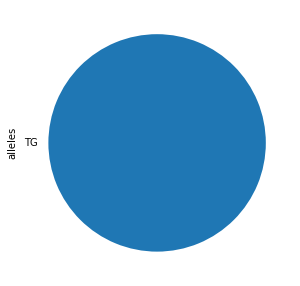

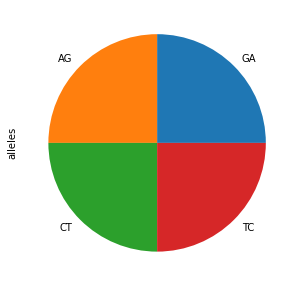

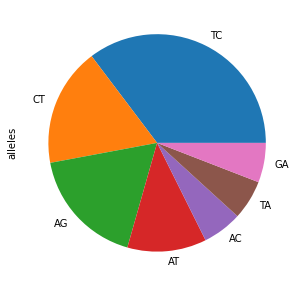

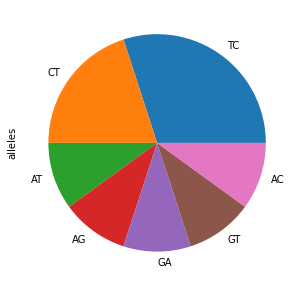

In [88]:
for animal in list(set(sing_df[sing_df['cohort']=='D006']['animal'])):
    print(animal)
    plt.figure(figsize=(5,5))
    df_temp = sing_df[sing_df['animal']==animal]
    df_temp['alleles'].value_counts().plot.pie()
    
# correlate w viral load / pathology? 
# what to resequence
# did they measure monocytes in another manuscript?
# what findings are strengthened by more data?
# 


In [89]:
sing_df[sing_df['cohort']=='D006']['alleles'].value_counts()


TC    10
CT     6
AG     5
TG     4
AT     3
GA     3
AC     2
TA     1
GT     1
Name: alleles, dtype: int64

RA0700
RA1790


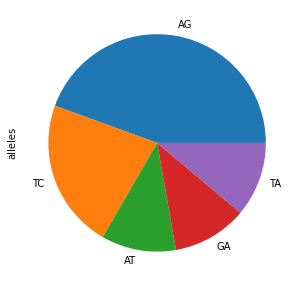

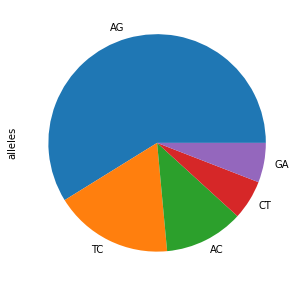

In [90]:
for animal in list(set(sing_df[sing_df['cohort']=='D007']['animal'])):
    print(animal)
    plt.figure(figsize=(5,5))
    df_temp = sing_df[sing_df['animal']==animal]
    df_temp['alleles'].value_counts().plot.pie()
 

In [91]:
sing_df[(sing_df['cohort']=='D007')&(sing_df['alleles']=='AG')]


#CHROM    POS ID REF ALT  QUAL FILTER  \
178  KU182905.1   8931  .   A   G  1677   PASS   
219  KU182905.1  16653  .   A   G  1046   PASS   
225  KU182905.1   5052  .   A   G   307   PASS   
233  KU182905.1  14390  .   A   G   416   PASS   
391  KU182905.1   4453  .   A   G   250   PASS   
392  KU182905.1   5059  .   A   G   374   PASS   
404  KU182905.1  12380  .   A   G   482   PASS   
407  KU182905.1  17847  .   A   G   670   PASS   
415  KU182905.1   4791  .   A   G  7442   PASS   
418  KU182905.1   5667  .   A   G  6396   PASS   
424  KU182905.1  10832  .   A   G  3407   PASS   
425  KU182905.1  10890  .   A   G  1073   PASS   
447  KU182905.1   8573  .   A   G   137   PASS   
454  KU182905.1  16551  .   A   G   557   PASS   

                                               INFO               description  \
178       DP=285;AF=0.217544;SB=9;DP4=109,111,39,25  Lymph node 1_RA0700_D007   
219   DP=2894;AF=0.021424;SB=11;DP4=1194,1622,19,43  Lymph node 2_RA0700_D007   
225        DP=776;AF=0.023196;SB=3;DP4=237,519,8,12  Lymph node 3_RA0700_D007   
233        DP=634;AF=0.036278;SB=0;DP4=169,439,6,19  Lymph node 3_RA0700_D007   
391        DP=547;AF=0.025594;SB=0;DP4=369,161,10,4  Lymph node 1_RA1790_D007   
392       DP=764;AF=0.027487;SB=17;DP4=288,451,15,8  Lymph node 1_RA1790_D007   
404       DP=314;AF=0.070064;SB=3;DP4=152,135,17,10  Lymph node 1_RA1790_D007   
407        DP=446;AF=0.069507;SB=4;DP4=257,158,22,9  Lymph node 1_RA1790_D007   
415  DP=4263;AF=0.078818;SB=2;DP4=1704,2194,165,197  Lymph node 2_RA1790_D007   
418     DP=1218;AF=0.199507;SB=0;DP4=220,745,55,196  Lymph node 2_RA1790_D007   
424     DP=2528;AF=0.063687;SB=8;DP4=950,1408,77,90  Lymph node 2_RA1790_D007   
425    DP=3077;AF=0.021124;SB=12;DP4=828,2174,26,41  Lymph node 2_RA1790_D007   
447         DP=382;AF=0.020942;SB=3;DP4=194,180,3,5  Lymph node 3_RA1790_D007   
454      DP=1693;AF=0.020083;SB=3;DP4=1182,473,29,8  Lymph node 3_RA1790_D007   

     animal cohort            tissue  depth      freq   qual  \
178  RA0700   D007   Lymph node (ax)    285  0.217544   SB=9   
219  RA0700   D007  Lymph node (ing)   2894  0.021424  SB=11   
225  RA0700   D007  Lymph node (mes)    776  0.023196   SB=3   
233  RA0700   D007  Lymph node (mes)    634  0.036278   SB=0   
391  RA1790   D007   Lymph node (ax)    547  0.025594   SB=0   
392  RA1790   D007   Lymph node (ax)    764  0.027487  SB=17   
404  RA1790   D007   Lymph node (ax)    314  0.070064   SB=3   
407  RA1790   D007   Lymph node (ax)    446  0.069507   SB=4   
415  RA1790   D007  Lymph node (ing)   4263  0.078818   SB=2   
418  RA1790   D007  Lymph node (ing)   1218  0.199507   SB=0   
424  RA1790   D007  Lymph node (ing)   2528  0.063687   SB=8   
425  RA1790   D007  Lymph node (ing)   3077  0.021124  SB=12   
447  RA1790   D007  Lymph node (mes)    382  0.020942   SB=3   
454  RA1790   D007  Lymph node (mes)   1693  0.020083   SB=3   

                     reads  variant_reads alleles  
178      DP4=109,111,39,25           62.0      AG  
219    DP4=1194,1622,19,43           62.0      AG  
225       DP4=237,519,8,12           18.0      AG  
233       DP4=169,439,6,19           23.0      AG  
391       DP4=369,161,10,4           14.0      AG  
392       DP4=288,451,15,8           21.0      AG  
404      DP4=152,135,17,10           22.0      AG  
407       DP4=257,158,22,9           31.0      AG  
415  DP4=1704,2194,165,197          336.0      AG  
418     DP4=220,745,55,196          243.0      AG  
424     DP4=950,1408,77,90          161.0      AG  
425     DP4=828,2174,26,41           65.0      AG  
447        DP4=194,180,3,5            8.0      AG  
454      DP4=1182,473,29,8           34.0      AG

RA1779
RA1423


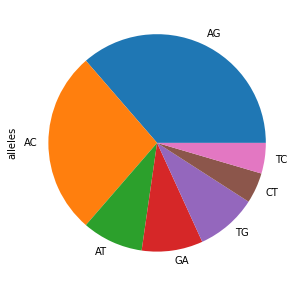

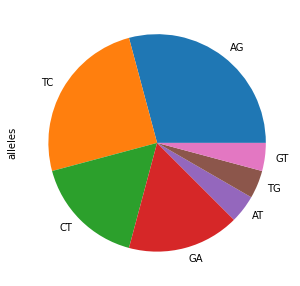

In [92]:
for animal in list(set(sing_df[sing_df['cohort']=='D008']['animal'])):
    print(animal)
    plt.figure(figsize=(5,5))
    df_temp = sing_df[sing_df['animal']==animal]
    df_temp['alleles'].value_counts().plot.pie()
 

In [93]:
sing_df[sing_df['cohort']=='D007']['alleles'].value_counts()


AG    14
TC     5
GA     2
AC     2
AT     1
TA     1
CT     1
Name: alleles, dtype: int64

In [94]:
sing_df[(sing_df['cohort']=='D008')&(sing_df['alleles']=='AG')]


#CHROM    POS ID REF ALT  QUAL FILTER  \
238   KU182905.1    169  .   A   G   569   PASS   
269   KU182905.1   3551  .   A   G  3582   PASS   
274   KU182905.1   6695  .   A   G   712   PASS   
276   KU182905.1   7104  .   A   G   772   PASS   
299   KU182905.1    169  .   A   G   149   PASS   
331   KU182905.1  18411  .   A   G   236   PASS   
894   KU182905.1  13188  .   A   G   214   PASS   
905   KU182905.1  17496  .   A   G   280   PASS   
925   KU182905.1  10187  .   A   G   606   PASS   
932   KU182905.1   3311  .   A   G  2103   PASS   
997   KU182905.1   7648  .   A   G  7654   PASS   
1006  KU182905.1   9238  .   A   G  5052   PASS   
1012  KU182905.1  10443  .   A   G  3922   PASS   
1306  KU182905.1    169  .   A   G   148   PASS   
1319  KU182905.1  18411  .   A   G   113   PASS   

                                                  INFO  \
238            DP=463;AF=0.058315;SB=6;DP4=422,12,27,2   
269         DP=1074;AF=0.135940;SB=2;DP4=500,422,78,73   
274            DP=750;AF=0.046667;SB=0;DP4=83,614,6,39   
276          DP=926;AF=0.042117;SB=2;DP4=556,321,29,13   
299             DP=268;AF=0.029851;SB=2;DP4=238,22,7,1   
331           DP=414;AF=0.031401;SB=7;DP4=179,222,3,10   
894             DP=312;AF=0.035256;SB=6;DP4=201,97,7,7   
905           DP=709;AF=0.022567;SB=0;DP4=373,311,11,9   
925         DP=911;AF=0.035126;SB=16;DP4=342,530,21,14   
932        DP=1913;AF=0.053319;SB=3;DP4=671,1133,44,63   
997   DP=18595;AF=0.024469;SB=17;DP4=8113,9998,235,232   
1006   DP=11531;AF=0.025757;SB=1;DP4=6654,4564,184,120   
1012    DP=9563;AF=0.024574;SB=17;DP4=6290,3028,179,60   
1306            DP=138;AF=0.050725;SB=14;DP4=126,4,6,2   
1319            DP=191;AF=0.031414;SB=6;DP4=83,102,1,5   

                       description  animal cohort              tissue  depth  \
238             Spleen_RA1779_D008  RA1779   D008              Spleen    463   
269          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ   1074   
274          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ    750   
276          Sex Organ_RA1779_D008  RA1779   D008           Sex Organ    926   
299       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)    268   
331       Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)    414   
894             Kidney_RA1423_D008  RA1423   D008              Kidney    312   
905             Kidney_RA1423_D008  RA1423   D008              Kidney    709   
925       Lymph node 1_RA1423_D008  RA1423   D008     Lymph node (ax)    911   
932       Lymph node 2_RA1423_D008  RA1423   D008    Lymph node (ing)   1913   
997       Lymph node 3_RA1423_D008  RA1423   D008    Lymph node (mes)  18595   
1006      Lymph node 3_RA1423_D008  RA1423   D008    Lymph node (mes)  11531   
1012      Lymph node 3_RA1423_D008  RA1423   D008    Lymph node (mes)   9563   
1306  Whole blood_D008_RA1779_D008  RA1779   D008  Whole blood (D008)    138   
1319  Whole blood_D008_RA1779_D008  RA1779   D008  Whole blood (D008)    191   

          freq   qual                  reads  variant_reads alleles  
238   0.058315   SB=6        DP4=422,12,27,2           27.0      AG  
269   0.135940   SB=2      DP4=500,422,78,73          146.0      AG  
274   0.046667   SB=0        DP4=83,614,6,39           35.0      AG  
276   0.042117   SB=2      DP4=556,321,29,13           39.0      AG  
299   0.029851   SB=2         DP4=238,22,7,1            8.0      AG  
331   0.031401   SB=7       DP4=179,222,3,10           13.0      AG  
894   0.035256   SB=6         DP4=201,97,7,7           11.0      AG  
905   0.022567   SB=0       DP4=373,311,11,9           16.0      AG  
925   0.035126  SB=16      DP4=342,530,21,14           32.0      AG  
932   0.053319   SB=3     DP4=671,1133,44,63          102.0      AG  
997   0.024469  SB=17  DP4=8113,9998,235,232          455.0      AG  
1006  0.025757   SB=1  DP4=6654,4564,184,120          297.0      AG  
1012  0.024574  SB=17   DP4=6290,3028,179,60          235.0      AG  
130

In [95]:
sing_df[sing_df['cohort']=='D008']['tissue'].value_counts()


Lymph node (mes)      17
Lymph node (ing)       7
Sex Organ              6
Kidney                 5
Lymph node (ax)        4
Whole blood (D008)     4
Spleen                 3
Name: tissue, dtype: int64

In [96]:
sing_df['tissue'].value_counts()

Lymph node (mes)      38
Lymph node (ing)      28
Lymph node (ax)       19
Spleen                 8
Sex Organ              6
Kidney                 6
Whole blood (D008)     4
Whole blood (D006)     2
Whole blood (D005)     1
Name: tissue, dtype: int64

In [97]:
sing_df[sing_df['tissue']=='Spleen']


#CHROM    POS ID REF ALT  QUAL FILTER  \
48    KU182905.1   7603  .   T   G   727   PASS   
56    KU182905.1  11554  .   A   G   701   PASS   
238   KU182905.1    169  .   A   G   569   PASS   
240   KU182905.1   4531  .   A   C  2350   PASS   
359   KU182905.1  15151  .   A   G   138   PASS   
844   KU182905.1  18631  .   T   C   867   PASS   
1045  KU182905.1   2997  .   T   C  1894   PASS   
1110  KU182905.1   2458  .   T   G   441   PASS   

                                              INFO          description  \
48      DP=1392;AF=0.029454;SB=5;DP4=703,645,26,16   Spleen_RA0717_D004   
56      DP=1879;AF=0.022352;SB=5;DP4=845,982,18,29   Spleen_RA0717_D004   
238        DP=463;AF=0.058315;SB=6;DP4=422,12,27,2   Spleen_RA1779_D008   
240   DP=3585;AF=0.035983;SB=1;DP4=2836,615,107,25   Spleen_RA1779_D008   
359        DP=386;AF=0.020725;SB=0;DP4=172,206,4,4   Spleen_RA0452_D005   
844   DP=1428;AF=0.033613;SB=21;DP4=1185,191,37,15   Spleen_RA1423_D008   
1045   DP=2290;AF=0.042795;SB=2;DP4=819,1362,43,63   Spleen_RA1639_D005   
1110     DP=926;AF=0.026998;SB=0;DP4=534,365,17,10  Spleen2_RA1074_D006   

      animal cohort  tissue  depth      freq   qual                reads  \
48    RA0717   D004  Spleen   1392  0.029454   SB=5    DP4=703,645,26,16   
56    RA0717   D004  Spleen   1879  0.022352   SB=5    DP4=845,982,18,29   
238   RA1779   D008  Spleen    463  0.058315   SB=6      DP4=422,12,27,2   
240   RA1779   D008  Spleen   3585  0.035983   SB=1  DP4=2836,615,107,25   
359   RA0452   D005  Spleen    386  0.020725   SB=0      DP4=172,206,4,4   
844   RA1423   D008  Spleen   1428  0.033613  SB=21   DP4=1185,191,37,15   
1045  RA1639   D005  Spleen   2290  0.042795   SB=2   DP4=819,1362,43,63   
1110  RA1074   D006  Spleen    926  0.026998   SB=0    DP4=534,365,17,10   

      variant_reads alleles  
48             41.0      TG  
56             42.0      AG  
238            27.0      AG  
240           129.0      AC  
359             8.0      AG  
844            48.0      TC  
1045           98.0      TC  
1110           25.0      TG

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'D003'),
  Text(1, 0, 'D004'),
  Text(2, 0, 'D005'),
  Text(3, 0, 'D006'),
  Text(4, 0, 'D007'),
  Text(5, 0, 'D008'),
  Text(6, 0, 'D-30'),
  Text(7, 0, 'NTC')])

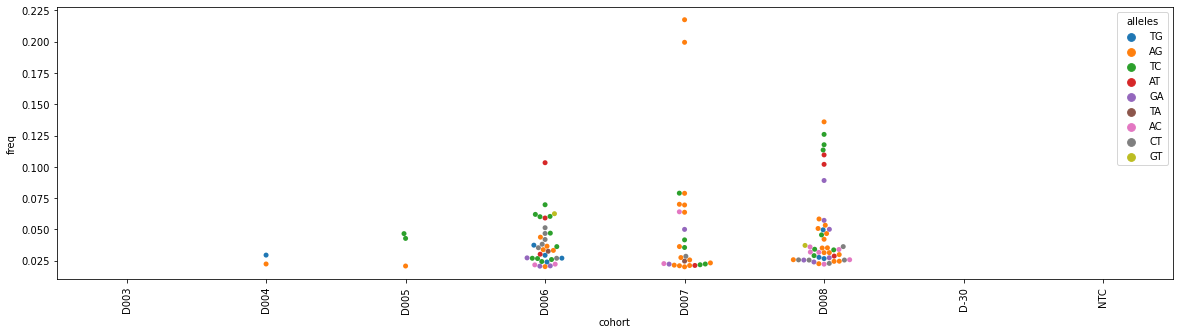

In [98]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 5)
#cmap_test = ['red','red','grey','black','red','grey','grey','red','black']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=sing_df,hue='alleles')
plt.xticks(rotation=90)


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Spleen'),
  Text(1, 0, 'Lymph node (ax)'),
  Text(2, 0, 'Lymph node (ing)'),
  Text(3, 0, 'Lymph node (mes)'),
  Text(4, 0, 'Sex Organ'),
  Text(5, 0, 'Kidney'),
  Text(6, 0, 'Whole blood (D006)'),
  Text(7, 0, 'Whole blood (D008)'),
  Text(8, 0, 'Whole blood (D005)')])

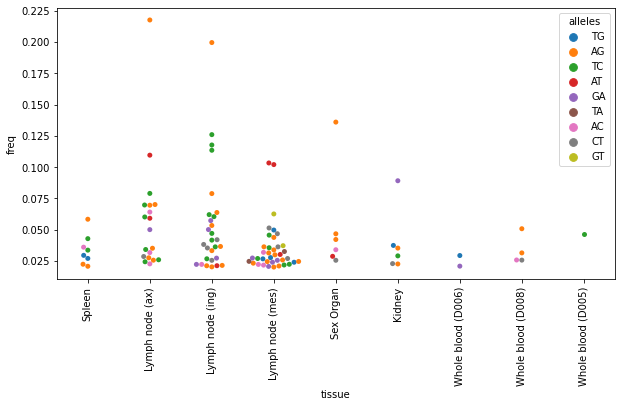

In [99]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['#BC80BD','#FDB462','#ed830c','#f5b771','#e64e9b','#BEBADA','#CCEBC5','#CCEBC5','#CCEBC5']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='tissue',y='freq',data=sing_df,hue='alleles')
plt.xticks(rotation=90)


In [40]:
# download to annotate

sing_df.to_csv(r'gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/emergent_variants_all.csv',index=False)

# upload annotated vcf and scrub interesting datafields

sing_df = pd.read_table('gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/emergent_variants_all_annotated.csv',sep=',')
sing_df['type'].replace('syonymous', 'synonymous', inplace=True)
sing_df['tissue'].replace('Whole blood (D008)', 'Whole blood', inplace=True)
sing_df['tissue'].replace('Whole blood (D005)', 'Whole blood', inplace=True)
sing_df['tissue'].replace('Whole blood (D006)', 'Whole blood', inplace=True)
sing_df = sing_df.iloc[:112]
sing_df['POS'] = sing_df['POS'].astype(float)
sing_df.head()


#CHROM     POS gene gene_transcript gene_note           type ID REF  \
0  KU182905.1   169.0  UTR              NP  NP 5'UTR      noncoding  .   A   
1  KU182905.1   169.0  UTR              NP  NP 5'UTR      noncoding  .   A   
2  KU182905.1   169.0  UTR              NP  NP 5'UTR      noncoding  .   A   
3  KU182905.1  1856.0   NP              NP       NaN  nonsynonymous  .   G   
4  KU182905.1  2340.0   NP              NP       NaN  nonsynonymous  .   A   

  ALT  QUAL  ...                   description  animal cohort  \
0   G   569  ...            Spleen_RA1779_D008  RA1779   D008   
1   G   149  ...      Lymph node 3_RA1779_D008  RA1779   D008   
2   G   148  ...  Whole blood_D008_RA1779_D008  RA1779   D008   
3   A   989  ...      Lymph node 3_RA1779_D008  RA1779   D008   
4   T  2907  ...      Lymph node 3_RA1818_D006  RA1818   D006   

             tissue depth      freq   qual                reads variant_reads  \
0            Spleen   463  0.058315   SB=6      DP4=422,12,27,2            27   
1  Lymph node (mes)   268  0.029851   SB=2       DP4=238,22,7,1             8   
2       Whole blood   138  0.050725  SB=14        DP4=126,4,6,2             7   
3  Lymph node (mes)  2394  0.025480   SB=5    DP4=2036,290,62,5            61   
4  Lymph node (mes)  5438  0.030158  SB=17  DP4=910,4355,42,130           164   

  alleles  
0      AG  
1      AG  
2      AG  
3      GA  
4      AT  

[5 rows x 22 columns]

D005
D008
D007
D006
D004


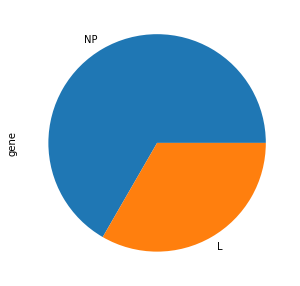

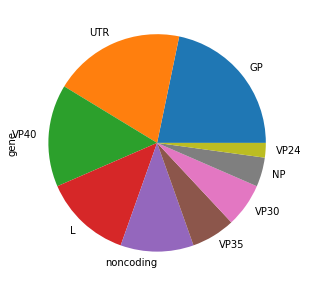

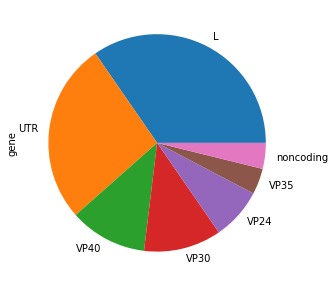

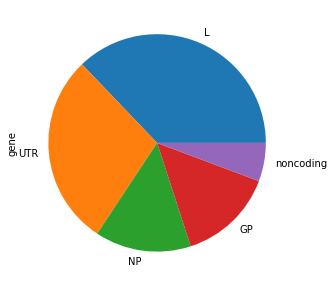

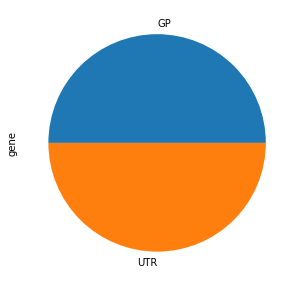

In [101]:
for tissue in list(set(sing_df['cohort'])):
    print(tissue)
    plt.figure(figsize=(5,5))
    df_temp = sing_df[sing_df['cohort']==tissue]
    df_temp['gene'].value_counts().plot.pie()
 

In [102]:
sing_df.groupby(['animal','gene']).size().unstack()

gene     GP    L   NP  UTR  VP24  VP30  VP35  VP40  noncoding
animal                                                       
RA0452  NaN  1.0  NaN  NaN   NaN   NaN   NaN   NaN        NaN
RA0700  NaN  4.0  NaN  2.0   NaN   1.0   1.0   1.0        NaN
RA0717  1.0  NaN  NaN  1.0   NaN   NaN   NaN   NaN        NaN
RA0917  2.0  4.0  NaN  3.0   NaN   NaN   NaN   NaN        1.0
RA1074  NaN  NaN  4.0  NaN   NaN   NaN   NaN   NaN        NaN
RA1325  NaN  3.0  NaN  1.0   NaN   NaN   NaN   NaN        NaN
RA1423  4.0  5.0  NaN  5.0   1.0   2.0   2.0   2.0        3.0
RA1639  NaN  NaN  2.0  NaN   NaN   NaN   NaN   NaN        NaN
RA1779  6.0  1.0  2.0  4.0   NaN   1.0   1.0   5.0        2.0
RA1790  NaN  5.0  NaN  5.0   2.0   2.0   NaN   2.0        1.0
RA1818  3.0  6.0  1.0  6.0   NaN   NaN   NaN   NaN        1.0

In [103]:
sing_df.fillna(0)

#CHROM      POS       gene gene_transcript gene_note           type  \
0    KU182905.1    169.0        UTR              NP  NP 5'UTR      noncoding   
1    KU182905.1    169.0        UTR              NP  NP 5'UTR      noncoding   
2    KU182905.1    169.0        UTR              NP  NP 5'UTR      noncoding   
3    KU182905.1   1856.0         NP              NP         0  nonsynonymous   
4    KU182905.1   2340.0         NP              NP         0  nonsynonymous   
..          ...      ...        ...             ...       ...            ...   
107  KU182905.1  18562.0  noncoding               0   trailer      noncoding   
108  KU182905.1  18584.0  noncoding               0   trailer      noncoding   
109  KU182905.1  18631.0  noncoding               0   trailer      noncoding   
110  KU182905.1  18831.0  noncoding               0   trailer      noncoding   
111  KU182905.1  18911.0  noncoding               0   trailer      noncoding   

    ID REF ALT  QUAL  ...                   description  animal cohort  \
0    .   A   G   569  ...            Spleen_RA1779_D008  RA1779   D008   
1    .   A   G   149  ...      Lymph node 3_RA1779_D008  RA1779   D008   
2    .   A   G   148  ...  Whole blood_D008_RA1779_D008  RA1779   D008   
3    .   G   A   989  ...      Lymph node 3_RA1779_D008  RA1779   D008   
4    .   A   T  2907  ...      Lymph node 3_RA1818_D006  RA1818   D006   
..  ..  ..  ..   ...  ...                           ...     ...    ...   
107  .   G   T  3765  ...      Lymph node 3_RA1423_D008  RA1423   D008   
108  .   C   T   110  ...  Whole blood_D008_RA1423_D008  RA1423   D008   
109  .   T   C   867  ...            Spleen_RA1423_D008  RA1423   D008   
110  .   T   C   136  ...      Lymph node 3_RA1790_D007  RA1790   D007   
111  .   G   A   104  ...  Whole blood_D006_RA1818_D006  RA1818   D006   

               tissue depth      freq   qual                 reads  \
0              Spleen   463  0.058315   SB=6       DP4=422,12,27,2   
1    Lymph node (mes)   268  0.029851   SB=2        DP4=238,22,7,1   
2         Whole blood   138  0.050725  SB=14         DP4=126,4,6,2   
3    Lymph node (mes)  2394  0.025480   SB=5     DP4=2036,290,62,5   
4    Lymph node (mes)  5438  0.030158  SB=17   DP4=910,4355,42,130   
..                ...   ...       ...    ...                   ...   
107  Lymph node (mes)  5756  0.037179  SB=39  DP4=4431,1092,160,71   
108       Whole blood   234  0.025641   SB=5        DP4=186,39,4,2   
109            Spleen  1428  0.033613  SB=21    DP4=1185,191,37,15   
110  Lymph node (mes)   197  0.035533   SB=0         DP4=0,190,0,7   
111       Whole blood   288  0.020833   SB=0         DP4=0,282,0,6   

    variant_reads alleles  
0              27      AG  
1               8      AG  
2               7      AG  
3              61      GA  
4             164      AT  
..            ...     ...  
107           214      GT  
108             6      CT  
109            48      TC  
110             7      TC  
111             6      GA  

[112 rows x 22 columns]

In [104]:
sing_df.groupby(['animal','gene']).size().unstack()

gene     GP    L   NP  UTR  VP24  VP30  VP35  VP40  noncoding
animal                                                       
RA0452  NaN  1.0  NaN  NaN   NaN   NaN   NaN   NaN        NaN
RA0700  NaN  4.0  NaN  2.0   NaN   1.0   1.0   1.0        NaN
RA0717  1.0  NaN  NaN  1.0   NaN   NaN   NaN   NaN        NaN
RA0917  2.0  4.0  NaN  3.0   NaN   NaN   NaN   NaN        1.0
RA1074  NaN  NaN  4.0  NaN   NaN   NaN   NaN   NaN        NaN
RA1325  NaN  3.0  NaN  1.0   NaN   NaN   NaN   NaN        NaN
RA1423  4.0  5.0  NaN  5.0   1.0   2.0   2.0   2.0        3.0
RA1639  NaN  NaN  2.0  NaN   NaN   NaN   NaN   NaN        NaN
RA1779  6.0  1.0  2.0  4.0   NaN   1.0   1.0   5.0        2.0
RA1790  NaN  5.0  NaN  5.0   2.0   2.0   NaN   2.0        1.0
RA1818  3.0  6.0  1.0  6.0   NaN   NaN   NaN   NaN        1.0

In [105]:
sing_df.groupby(['animal','gene']).size().unstack().div(sing_df.groupby(['animal','gene']).size().unstack().sum(axis=1), axis=0)


gene          GP         L        NP       UTR      VP24      VP30      VP35  \
animal                                                                         
RA0452       NaN  1.000000       NaN       NaN       NaN       NaN       NaN   
RA0700       NaN  0.444444       NaN  0.222222       NaN  0.111111  0.111111   
RA0717  0.500000       NaN       NaN  0.500000       NaN       NaN       NaN   
RA0917  0.200000  0.400000       NaN  0.300000       NaN       NaN       NaN   
RA1074       NaN       NaN  1.000000       NaN       NaN       NaN       NaN   
RA1325       NaN  0.750000       NaN  0.250000       NaN       NaN       NaN   
RA1423  0.166667  0.208333       NaN  0.208333  0.041667  0.083333  0.083333   
RA1639       NaN       NaN  1.000000       NaN       NaN       NaN       NaN   
RA1779  0.272727  0.045455  0.090909  0.181818       NaN  0.045455  0.045455   
RA1790       NaN  0.294118       NaN  0.294118  0.117647  0.117647       NaN   
RA1818  0.176471  0.352941  0.058824  0.352941       NaN       NaN       NaN   

gene        VP40  noncoding  
animal                       
RA0452       NaN        NaN  
RA0700  0.111111        NaN  
RA0717       NaN        NaN  
RA0917       NaN   0.100000  
RA1074       NaN        NaN  
RA1325       NaN        NaN  
RA1423  0.083333   0.125000  
RA1639       NaN        NaN  
RA1779  0.227273   0.090909  
RA1790  0.117647   0.058824  
RA1818       NaN   0.058824

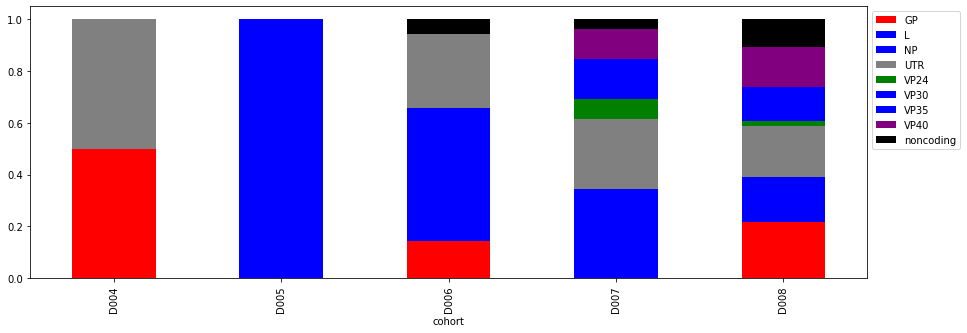

In [106]:
cmap_test = ['red','blue','blue','grey','green','blue','blue','purple','black']

sing_df.groupby(['cohort','gene']).size().unstack().div(sing_df.groupby(['cohort','gene']).size().unstack().sum(axis=1), axis=0).plot(kind='bar',
        stacked=True,figsize=(15,5),color=['red','blue','blue','grey','green','blue','blue','purple','black'])
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


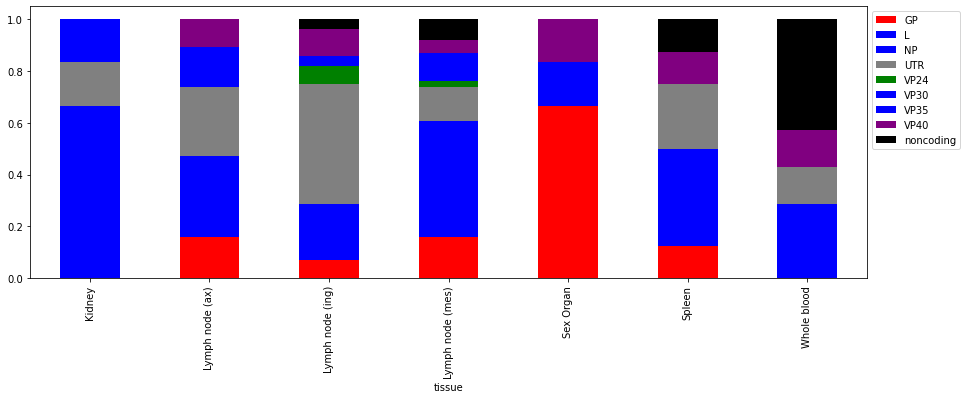

In [107]:
sing_df.groupby(['tissue','gene']).size().unstack().div(sing_df.groupby(['tissue','gene']).size().unstack().sum(axis=1), axis=0).plot(kind='bar',
        stacked=True,figsize=(15,5),color=['red','blue','blue','grey','green','blue','blue','purple','black'])
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


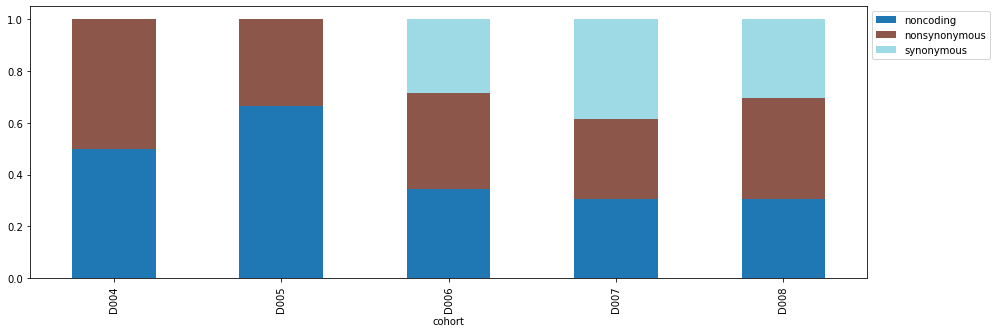

In [108]:
sing_df.groupby(['cohort','type']).size().unstack().div(sing_df.groupby(['cohort','type']).size().unstack().sum(axis=1), axis=0).plot(kind='bar',
        stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


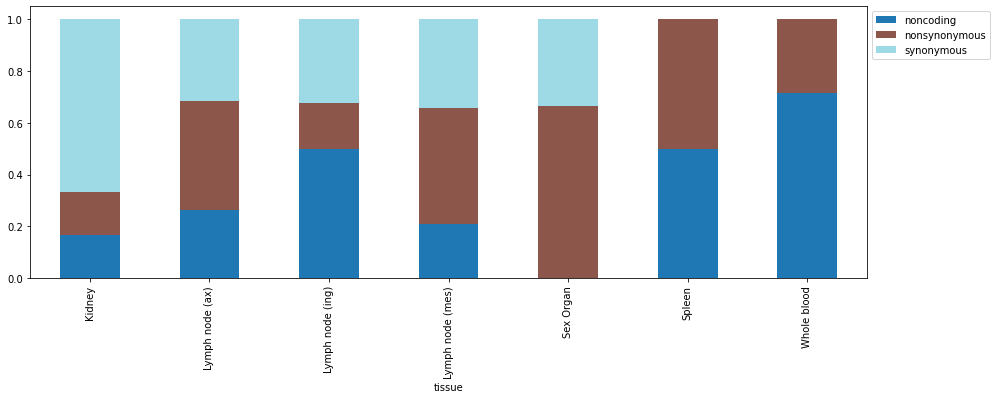

In [109]:
sing_df.groupby(['tissue','type']).size().unstack().div(sing_df.groupby(['tissue','type']).size().unstack().sum(axis=1), axis=0).plot(kind='bar',
        stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


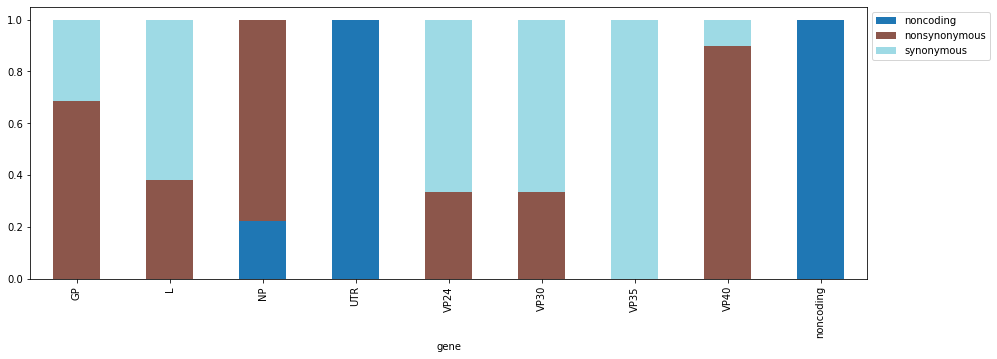

In [110]:
sing_df.groupby(['gene','type']).size().unstack().div(sing_df.groupby(['gene','type']).size().unstack().sum(axis=1), axis=0).plot(kind='bar',
        stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


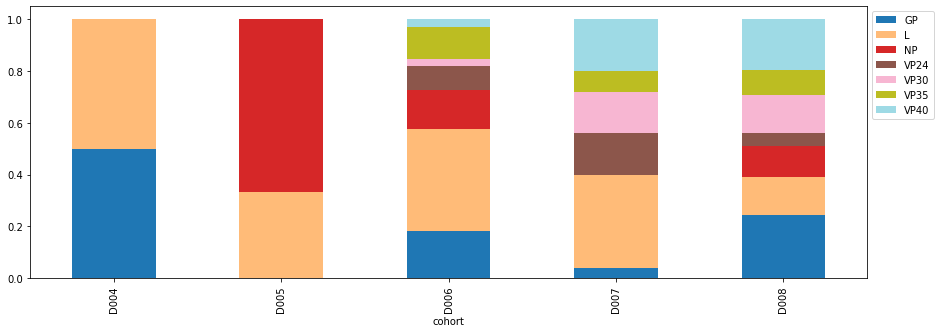

In [111]:
sing_df.groupby(['cohort','gene_transcript']).size().unstack().div(sing_df.groupby(['cohort','gene_transcript']).size().unstack().sum(axis=1), axis=0).plot(kind='bar',
        stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


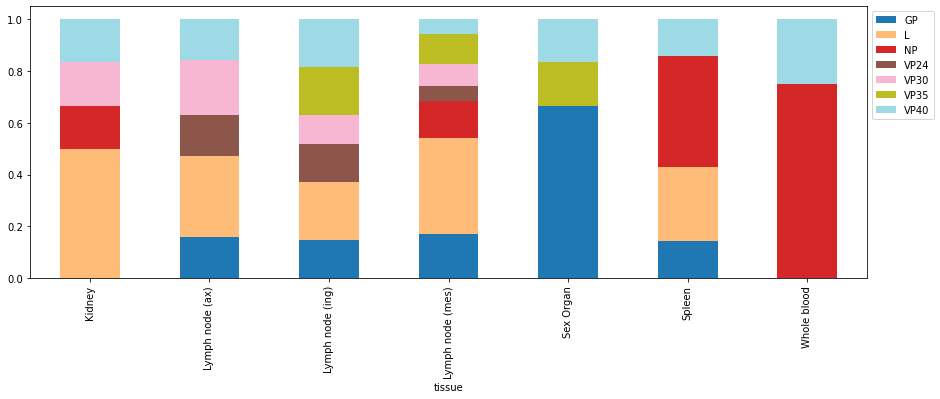

In [112]:
sing_df.groupby(['tissue','gene_transcript']).size().unstack().div(sing_df.groupby(['tissue','gene_transcript']).size().unstack().sum(axis=1), axis=0).plot(kind='bar',
        stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


In [113]:
sing_df[sing_df['gene_transcript']=='NP']

#CHROM     POS gene gene_transcript gene_note           type ID REF  \
0   KU182905.1   169.0  UTR              NP  NP 5'UTR      noncoding  .   A   
1   KU182905.1   169.0  UTR              NP  NP 5'UTR      noncoding  .   A   
2   KU182905.1   169.0  UTR              NP  NP 5'UTR      noncoding  .   A   
3   KU182905.1  1856.0   NP              NP       NaN  nonsynonymous  .   G   
4   KU182905.1  2340.0   NP              NP       NaN  nonsynonymous  .   A   
5   KU182905.1  2408.0   NP              NP       NaN  nonsynonymous  .   T   
6   KU182905.1  2458.0   NP              NP       NaN  nonsynonymous  .   T   
7   KU182905.1  2458.0   NP              NP       NaN  nonsynonymous  .   T   
8   KU182905.1  2458.0   NP              NP       NaN  nonsynonymous  .   T   
9   KU182905.1  2458.0   NP              NP       NaN  nonsynonymous  .   T   
10  KU182905.1  2997.0   NP              NP  NP 3'UTR      noncoding  .   T   
11  KU182905.1  2997.0   NP              NP  NP 3'UTR      noncoding  .   T   

   ALT  QUAL  ...                   description  animal cohort  \
0    G   569  ...            Spleen_RA1779_D008  RA1779   D008   
1    G   149  ...      Lymph node 3_RA1779_D008  RA1779   D008   
2    G   148  ...  Whole blood_D008_RA1779_D008  RA1779   D008   
3    A   989  ...      Lymph node 3_RA1779_D008  RA1779   D008   
4    T  2907  ...      Lymph node 3_RA1818_D006  RA1818   D006   
5    G   361  ...      Lymph node 3_RA1779_D008  RA1779   D008   
6    G   441  ...           Spleen2_RA1074_D006  RA1074   D006   
7    G   630  ...            Kidney_RA1074_D006  RA1074   D006   
8    G   960  ...      Lymph node 3_RA1074_D006  RA1074   D006   
9    G  2434  ...  Whole blood_D006_RA1074_D006  RA1074   D006   
10   C  1894  ...            Spleen_RA1639_D005  RA1639   D005   
11   C  1522  ...  Whole blood_D005_RA1639_D005  RA1639   D005   

              tissue depth      freq   qual                 reads  \
0             Spleen   463  0.058315   SB=6       DP4=422,12,27,2   
1   Lymph node (mes)   268  0.029851   SB=2        DP4=238,22,7,1   
2        Whole blood   138  0.050725  SB=14         DP4=126,4,6,2   
3   Lymph node (mes)  2394  0.025480   SB=5     DP4=2036,290,62,5   
4   Lymph node (mes)  5438  0.030158  SB=17   DP4=910,4355,42,130   
5   Lymph node (mes)   723  0.027663   SB=2      DP4=304,398,7,14   
6             Spleen   926  0.026998   SB=0     DP4=534,365,17,10   
7             Kidney   856  0.037383   SB=1     DP4=415,398,22,19   
8   Lymph node (mes)  2422  0.023947   SB=0    DP4=518,1840,14,50   
9        Whole blood  4846  0.029303  SB=17  DP4=2870,1824,107,44   
10            Spleen  2290  0.042795   SB=2    DP4=819,1362,43,63   
11       Whole blood  1652  0.046610   SB=2    DP4=502,1069,28,53   

   variant_reads alleles  
0             27      AG  
1              8      AG  
2              7      AG  
3             61      GA  
4            164      AT  
5             20      TG  
6             25      TG  
7             32      TG  
8             58      TG  
9            142      TG  
10            98      TC  
11            77      TC  

[12 rows x 22 columns]

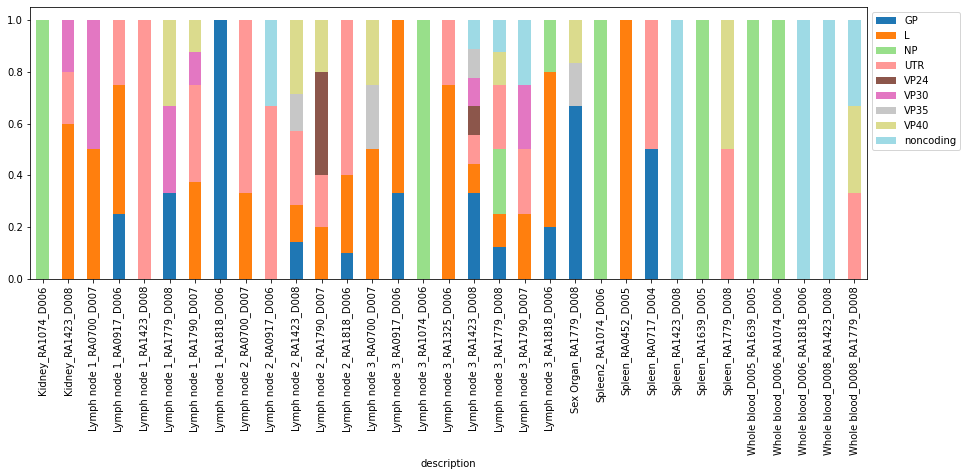

In [114]:
sing_df.groupby(['description','gene']).size().unstack().div(sing_df.groupby(['description','gene']).size().unstack().sum(axis=1), axis=0).plot(kind='bar',
        stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'D008'),
  Text(1, 0, 'D006'),
  Text(2, 0, 'D005'),
  Text(3, 0, 'D007'),
  Text(4, 0, 'D004')])

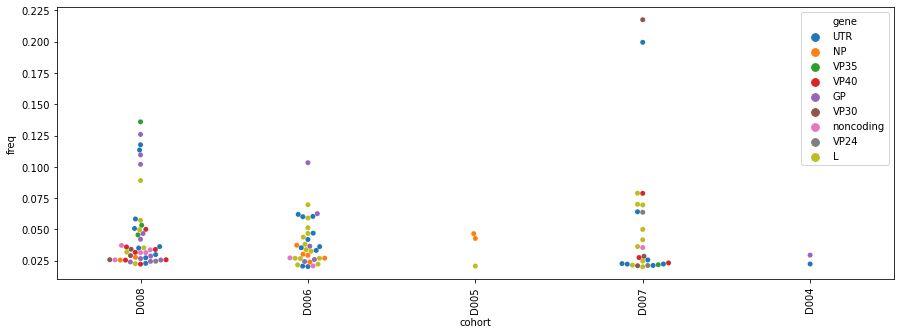

In [115]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 5)

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='cohort',y='freq',data=sing_df,hue='gene')
plt.xticks(rotation=90)


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Spleen_RA1779_D008'),
  Text(1, 0, 'Lymph node 3_RA1779_D008'),
  Text(2, 0, 'Whole blood_D008_RA1779_D008'),
  Text(3, 0, 'Lymph node 3_RA1818_D006'),
  Text(4, 0, 'Spleen2_RA1074_D006'),
  Text(5, 0, 'Kidney_RA1074_D006'),
  Text(6, 0, 'Lymph node 3_RA1074_D006'),
  Text(7, 0, 'Whole blood_D006_RA1074_D006'),
  Text(8, 0, 'Spleen_RA1639_D005'),
  Text(9, 0, 'Whole blood_D005_RA1639_D005'),
  Text(10, 0, 'Lymph node 3_RA1790_D007'),
  Text(11, 0, 'Lymph node 2_RA1818_D006'),
  Text(12, 0, 'Lymph node 3_RA0700_D007'),
  Text(13, 0, 'Lymph node 2_RA1423_D008'),
  Text(14, 0, 'Sex Organ_RA1779_D008'),
  Text(15, 0, 'Lymph node 3_RA1423_D008'),
  Text(16, 0, 'Lymph node 1_RA1790_D007'),
  Text(17, 0, 'Lymph node 2_RA0917_D006'),
  Text(18, 0, 'Lymph node 1_RA1779_D008'),
  Text(19, 0, 'Lymph node 2_RA1790_D007'),
  Text(20, 0, 

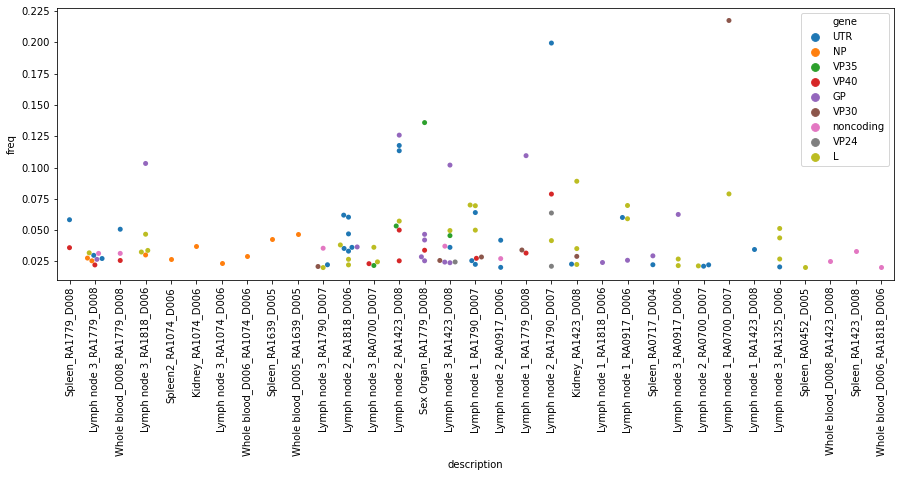

In [116]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 5)

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='description',y='freq',data=sing_df,hue='gene')
plt.xticks(rotation=90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'RA1779'),
  Text(1, 0, 'RA1818'),
  Text(2, 0, 'RA1074'),
  Text(3, 0, 'RA1639'),
  Text(4, 0, 'RA1790'),
  Text(5, 0, 'RA0700'),
  Text(6, 0, 'RA1423'),
  Text(7, 0, 'RA0917'),
  Text(8, 0, 'RA0717'),
  Text(9, 0, 'RA1325'),
  Text(10, 0, 'RA0452')])

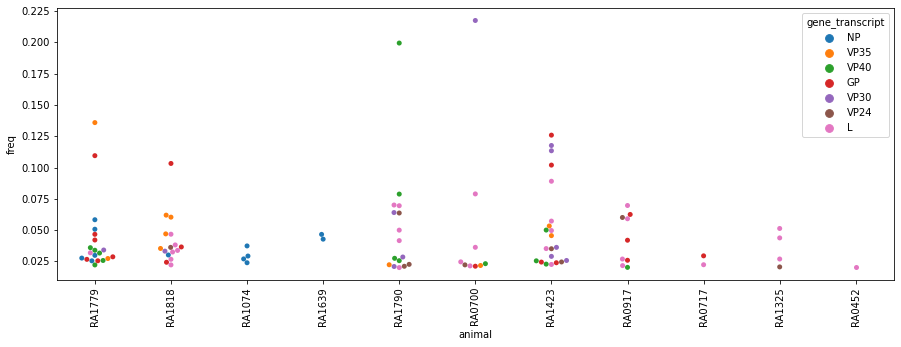

In [117]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 5)

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='animal',y='freq',data=sing_df,hue='gene_transcript')
plt.xticks(rotation=90)


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Spleen_RA1779_D008'),
  Text(1, 0, 'Lymph node 3_RA1779_D008'),
  Text(2, 0, 'Whole blood_D008_RA1779_D008'),
  Text(3, 0, 'Lymph node 3_RA1818_D006'),
  Text(4, 0, 'Spleen2_RA1074_D006'),
  Text(5, 0, 'Kidney_RA1074_D006'),
  Text(6, 0, 'Lymph node 3_RA1074_D006'),
  Text(7, 0, 'Whole blood_D006_RA1074_D006'),
  Text(8, 0, 'Spleen_RA1639_D005'),
  Text(9, 0, 'Whole blood_D005_RA1639_D005'),
  Text(10, 0, 'Lymph node 3_RA1790_D007'),
  Text(11, 0, 'Lymph node 2_RA1818_D006'),
  Text(12, 0, 'Lymph node 3_RA0700_D007'),
  Text(13, 0, 'Lymph node 2_RA1423_D008'),
  Text(14, 0, 'Sex Organ_RA1779_D008'),
  Text(15, 0, 'Lymph node 3_RA1423_D008'),
  Text(16, 0, 'Lymph node 1_RA1790_D007'),
  Text(17, 0, 'Lymph node 2_RA0917_D006'),
  Text(18, 0, 'Lymph node 1_RA1779_D008'),
  Text(19, 0, 'Lymph node 2_RA1790_D007'),
  Text(20, 0, 

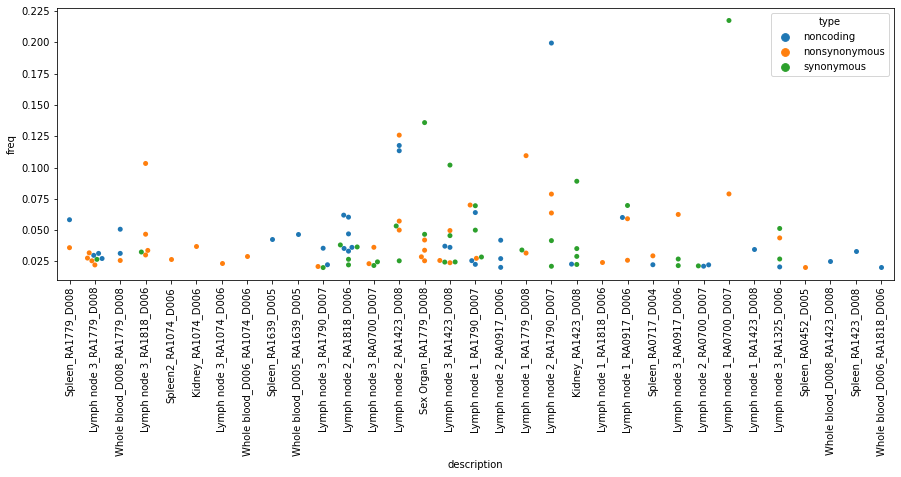

In [118]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 5)

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='description',y='freq',data=sing_df,hue='type')
plt.xticks(rotation=90)


In [119]:
sing_df[sing_df['animal']=='RA1779']['POS'].value_counts()

4531.0     5
169.0      3
6890.0     2
18411.0    2
1856.0     1
2408.0     1
3551.0     1
4277.0     1
6386.0     1
6695.0     1
7104.0     1
7974.0     1
9129.0     1
12353.0    1
Name: POS, dtype: int64

In [120]:
sing_df[(sing_df['animal']=='RA1779')&(sing_df['freq']>0.05)]

#CHROM     POS  gene gene_transcript gene_note           type ID REF  \
0   KU182905.1   169.0   UTR              NP  NP 5'UTR      noncoding  .   A   
2   KU182905.1   169.0   UTR              NP  NP 5'UTR      noncoding  .   A   
16  KU182905.1  3551.0  VP35            VP35       NaN     synonymous  .   A   
44  KU182905.1  6890.0    GP              GP       NaN  nonsynonymous  .   A   

   ALT  QUAL  ...                   description  animal cohort  \
0    G   569  ...            Spleen_RA1779_D008  RA1779   D008   
2    G   148  ...  Whole blood_D008_RA1779_D008  RA1779   D008   
16   G  3582  ...         Sex Organ_RA1779_D008  RA1779   D008   
44   T  2170  ...      Lymph node 1_RA1779_D008  RA1779   D008   

             tissue depth      freq   qual              reads variant_reads  \
0            Spleen   463  0.058315   SB=6    DP4=422,12,27,2            27   
2       Whole blood   138  0.050725  SB=14      DP4=126,4,6,2             7   
16        Sex Organ  1074  0.135940   SB=2  DP4=500,422,78,73           146   
44  Lymph node (ax)   831  0.109507   SB=5    DP4=631,99,92,9            91   

   alleles  
0       AG  
2       AG  
16      AG  
44      AT  

[4 rows x 22 columns]

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 [Text(0, 0, '169.0'),
  Text(1, 0, '1856.0'),
  Text(2, 0, '2340.0'),
  Text(3, 0, '2408.0'),
  Text(4, 0, '2458.0'),
  Text(5, 0, '2997.0'),
  Text(6, 0, '3049.0'),
  Text(7, 0, '3050.0'),
  Text(8, 0, '3197.0'),
  Text(9, 0, '3311.0'),
  Text(10, 0, '3551.0'),
  Text(11, 0, '3905.0'),
  Text(12, 0, '4183.0'),
  Text(13, 0, '4205.0'),
  Text(14, 0, '4258.0'),
  Text(15, 0, '4277.0'),
  Text(16, 0, '4453.0'),
  Text(17, 0, '4477.0'),
  Text(18, 0, '4531.0'),
  Text(19, 0, '4791.0'),
  Text(20, 0, '5052.0'),
  Text(21, 0, '5059.0'),
  Text(22, 

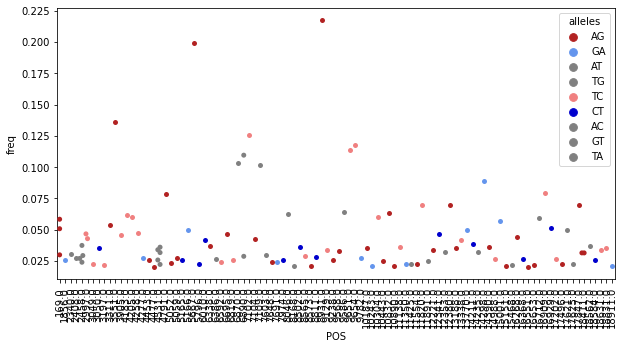

In [121]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['firebrick','cornflowerblue','grey','grey','lightcoral','mediumblue','grey','grey','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='POS',y='freq',data=sing_df,hue='alleles',palette=cmap_test)
plt.xticks(rotation=90)


(array([0, 1, 2]),
 [Text(0, 0, 'noncoding'),
  Text(1, 0, 'nonsynonymous'),
  Text(2, 0, 'synonymous')])

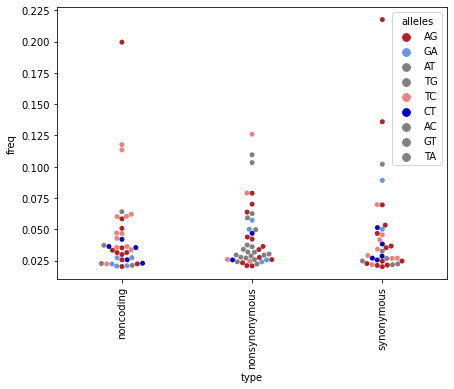

In [122]:
fig,ax = plt.subplots()
fig.set_size_inches(7, 5)
cmap_test = ['firebrick','cornflowerblue','grey','grey','lightcoral','mediumblue','grey','grey','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='type',y='freq',data=sing_df,hue='alleles',palette=cmap_test)
plt.xticks(rotation=90)


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Spleen'),
  Text(1, 0, 'Lymph node (mes)'),
  Text(2, 0, 'Whole blood'),
  Text(3, 0, 'Kidney'),
  Text(4, 0, 'Lymph node (ing)'),
  Text(5, 0, 'Sex Organ'),
  Text(6, 0, 'Lymph node (ax)')])

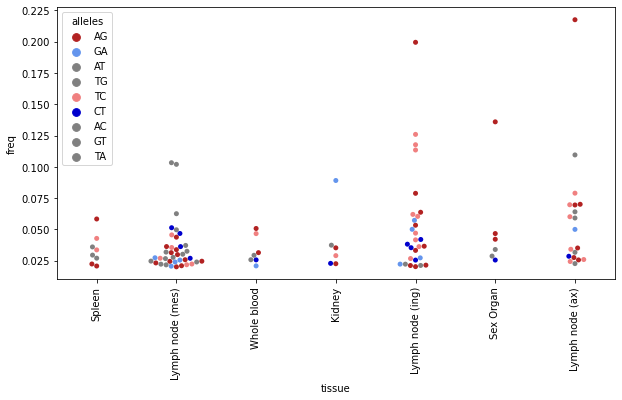

In [123]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['firebrick','cornflowerblue','grey','grey','lightcoral','mediumblue','grey','grey','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='tissue',y='freq',data=sing_df,hue='alleles',palette=cmap_test)
plt.xticks(rotation=90)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'D003'),
  Text(1, 0, 'D004'),
  Text(2, 0, 'D005'),
  Text(3, 0, 'D006'),
  Text(4, 0, 'D007'),
  Text(5, 0, 'D008'),
  Text(6, 0, 'D-30'),
  Text(7, 0, 'NTC')])

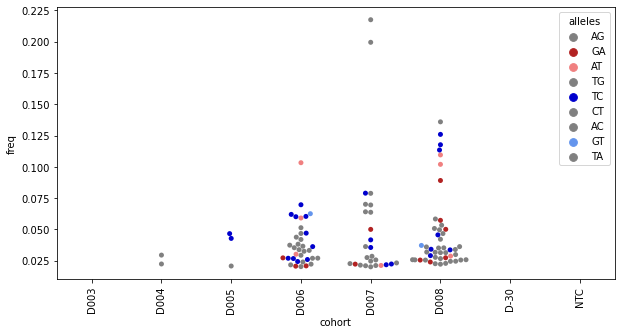

In [124]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['grey','firebrick','lightcoral','grey','mediumblue','grey','grey','cornflowerblue','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=sing_df,hue='alleles',palette=cmap_test)
plt.xticks(rotation=90)


In [125]:
sing_df[sing_df['cohort']=='D008'].drop_duplicates('POS')['alleles'].value_counts()

AG    12
TC     7
GA     6
CT     5
TG     3
AC     2
AT     2
GT     1
Name: alleles, dtype: int64

In [90]:
sing_df[sing_df['cohort']=='D007'].drop_duplicates('POS')['alleles'].value_counts()

AG    14
TC     5
AC     2
GA     2
AT     1
CT     1
TA     1
Name: alleles, dtype: int64

In [91]:
sing_df[sing_df['cohort']=='D006'].drop_duplicates('POS')['alleles'].value_counts()

TC    10
CT     6
AG     5
AT     3
GA     3
AC     2
TG     1
GT     1
TA     1
Name: alleles, dtype: int64

In [92]:
sing_df[sing_df['cohort']=='D005'].drop_duplicates('POS')['alleles'].value_counts()

TC    1
AG    1
Name: alleles, dtype: int64

In [93]:
sing_df[sing_df['animal']=='RA1325'].drop_duplicates('POS')['alleles'].value_counts()

GA    1
AG    1
CT    1
TC    1
Name: alleles, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'D003'),
  Text(1, 0, 'D004'),
  Text(2, 0, 'D005'),
  Text(3, 0, 'D006'),
  Text(4, 0, 'D007'),
  Text(5, 0, 'D008'),
  Text(6, 0, 'D-30'),
  Text(7, 0, 'NTC')])

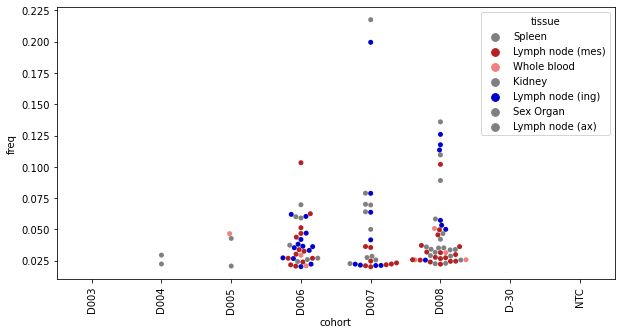

In [94]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['grey','firebrick','lightcoral','grey','mediumblue','grey','grey','cornflowerblue','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=sing_df,hue='tissue',palette=cmap_test)
plt.xticks(rotation=90)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'D003'),
  Text(1, 0, 'D004'),
  Text(2, 0, 'D005'),
  Text(3, 0, 'D006'),
  Text(4, 0, 'D007'),
  Text(5, 0, 'D008'),
  Text(6, 0, 'D-30'),
  Text(7, 0, 'NTC')])

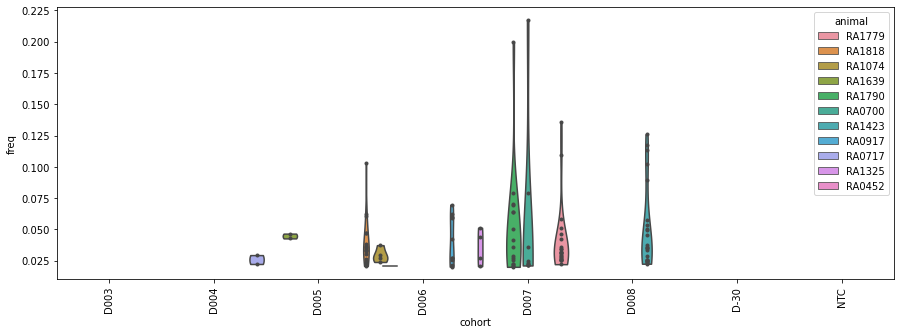

In [95]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 5)
cmap_test = ['grey','firebrick','lightcoral','grey','mediumblue','grey','grey','cornflowerblue','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.violinplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=sing_df,hue='animal',width=1.5,cut=0,scale='area',inner='point')
plt.xticks(rotation=90)


In [96]:
df_numvars = sing_df.groupby(['animal','tissue']).size().unstack()
df_numvars['Skin'] = len(df_numvars)*[np.nan]
df_numvars['Whole blood (D007)'] = len(df_numvars)*[np.nan]
df_numvars['Skin']['RA1818'] = 0
df_numvars['Spleen']['RA0917'] = 0
df_numvars['Whole blood (D006)']['RA0917'] = 0
df_numvars['Spleen']['RA0700'] = 0
df_numvars['Kidney']['RA0700'] = 0
df_numvars['Whole blood (D007)']['RA0700'] = 0
df_numvars['Spleen']['RA1790'] = 0
df_numvars['Whole blood (D007)']['RA1790'] = 0
df_numvars.loc['RA1803'] = 11*[np.nan] 
df_numvars.loc['RA0522'] = 11*[np.nan] 
df_numvars['Spleen']['RA0522'] = 0
df_numvars['Spleen']['RA1803'] = 0
df_numvars['Liver'] = len(df_numvars)*[np.nan]
df_numvars['Liver']['RA1803'] = 0
df_numvars['Whole blood (D006)']['RA1803'] = 0

df_numvars


KeyError: 'Whole blood (D006)'

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['grey','firebrick','lightcoral','grey','mediumblue','grey','grey','cornflowerblue','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.boxplot(data=df_numvars.T,order=['RA0717','RA0522','RA0452','RA1639','RA1803','RA1074','RA1325','RA0917','RA1818','RA0700','RA1790','RA1779','RA1423'],color='gainsboro')
g = sns.swarmplot(data=df_numvars.T,order=['RA0717','RA0522','RA0452','RA1639','RA1803','RA1074','RA1325','RA0917','RA1818','RA0700','RA1790','RA1779','RA1423'],s=8)
plt.xticks(rotation=90)
#plt.ylim(0,11)


In [ ]:
sing_df.groupby['animal']['tissue'].value_counts()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'D003'),
  Text(1, 0, 'D004'),
  Text(2, 0, 'D005'),
  Text(3, 0, 'D006'),
  Text(4, 0, 'D007'),
  Text(5, 0, 'D008'),
  Text(6, 0, 'D-30'),
  Text(7, 0, 'NTC')])

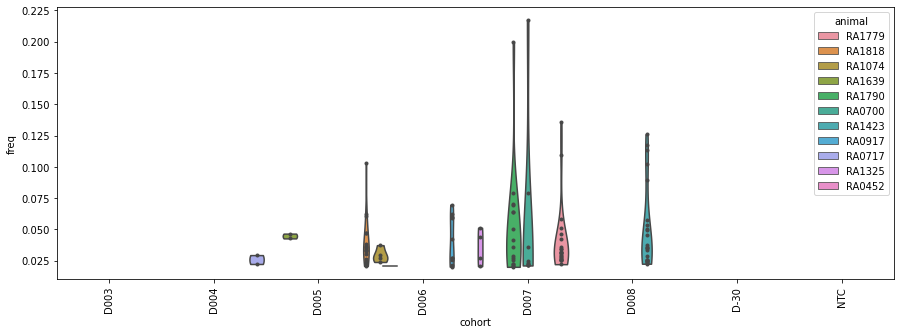

In [112]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 5)
cmap_test = ['grey','firebrick','lightcoral','grey','mediumblue','grey','grey','cornflowerblue','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.violinplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=sing_df,hue='animal',width=1.5,cut=0,scale='area',inner='point')
plt.xticks(rotation=90)


In [113]:
len(sing_df[(sing_df['freq']>0.05)&(sing_df['tissue']=='Whole blood')])/len(sing_df[sing_df['tissue']=='Whole blood'])


0.14285714285714285

In [114]:
len(sing_df[(sing_df['freq']>0.05)&(sing_df['tissue']=='Lymph node (mes)')])/len(sing_df[sing_df['tissue']=='Lymph node (mes)'])


0.10526315789473684

In [115]:
len(sing_df[(sing_df['freq']>0.05)&(sing_df['tissue']=='Lymph node (ing)')])/len(sing_df[sing_df['tissue']=='Lymph node (ing)'])


0.39285714285714285

In [116]:
len(sing_df[(sing_df['freq']>0.05)&(sing_df['tissue']=='Lymph node (ax)')])/len(sing_df[sing_df['tissue']=='Lymph node (ax)'])


0.47368421052631576

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 23.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(0.0, 0.3)

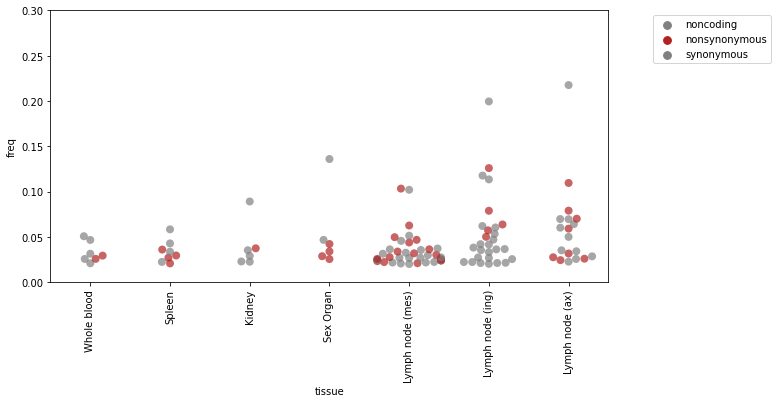

In [119]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['grey','firebrick','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='tissue',y='freq',order=['Whole blood','Spleen','Kidney','Sex Organ','Lymph node (mes)','Lymph node (ing)','Lymph node (ax)'],data=sing_df,hue='type',palette=cmap_test,alpha=0.7,s=8)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.3,1))
plt.ylim(0,0.3)


In [38]:
vars_count = []
vars_non = []
vars_adar = []
vars_nonadar = []
vars_transit = []
vars_transvers = []

for i in range(18959):
    low = i
    high = i+300
    df_temp = sing_df[(sing_df['POS']>low)&(sing_df['POS']<high)]
    df_temp.drop_duplicates(subset ="POS",keep = False, inplace = True)
    #df_temp2 = df_temp[df_temp['type']=='nonsynonymous']
    vars_count.append(len(df_temp))
    #vars_non.append(len(df_temp2))
    df_temp3 = df_temp[(df_temp['alleles']=='AG')|(df_temp['alleles']=='TC')]
    df_temp4 = df_temp[(df_temp['alleles']=='CT')|(df_temp['alleles']=='GA')]
    transvers = len(df_temp) - (len(df_temp3) + len(df_temp4))
    vars_adar.append(len(df_temp3))
    vars_nonadar.append(len(df_temp4))
    vars_transvers.append(transvers)
    vars_transit.append(len(df_temp3) + len(df_temp4))
    

(0.0, 5.0)

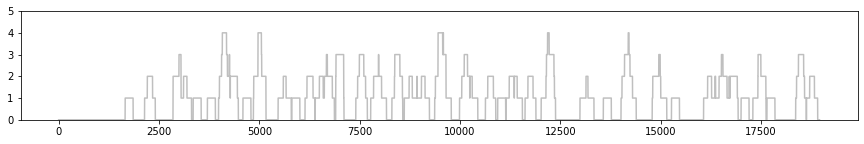

In [104]:
plt.figure(figsize=(15,2))

plt.plot(range(18959),vars_count,color='grey',alpha=0.5)

#plt.xlim(0,19000)
plt.ylim(0,5)


ValueError: x and y must have same first dimension, but have shapes (18959,) and (0,)

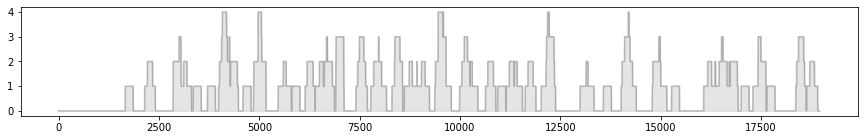

In [105]:
plt.figure(figsize=(15,2))

plt.plot(range(18959),vars_count,color='grey',alpha=0.5)
plt.fill_between(range(18959),vars_count,color='grey',alpha=0.2)

plt.plot(range(18959),vars_non,color='firebrick',alpha=0.5)
plt.fill_between(range(18959),vars_non,color='firebrick',alpha=0.2)

plt.axvline(x=470,color='grey',alpha=0.9)
plt.axvline(x=2689,color='grey',alpha=0.9)

plt.axvline(x=3129,color='grey',alpha=0.9)
plt.axvline(x=4151,color='grey',alpha=0.9)

plt.axvline(x=4479,color='grey',alpha=0.9)
plt.axvline(x=5459,color='grey',alpha=0.9)

plt.axvline(x=6039,color='grey',alpha=0.9)
plt.axvline(x=8068,color='grey',alpha=0.9)

plt.axvline(x=8509,color='grey',alpha=0.9)
plt.axvline(x=9375,color='grey',alpha=0.9)

plt.axvline(x=10345,color='grey',alpha=0.9)
plt.axvline(x=11100,color='grey',alpha=0.9)

plt.axvline(x=11581,color='grey',alpha=0.9)
plt.axvline(x=18219,color='grey',alpha=0.9)

#plt.xlim(0,19000)
plt.ylim(0,7)


In [97]:
[if y>0 x/y*6 else 0 for x in vars_adar for y in vars_nonadar]

SyntaxError: invalid syntax (608860296.py, line 1)

In [34]:
sing_df['alleles'].value_counts()

AG    36
TC    24
CT    12
GA    11
AC    10
TG     8
AT     7
TA     2
GT     2
Name: alleles, dtype: int64

(0.0, 6.0)

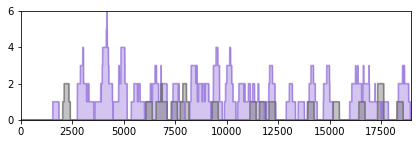

In [179]:
plt.figure(figsize=(7,2))

plt.plot(range(18959),vars_transit,color='mediumpurple',alpha=0.7)
plt.fill_between(range(18959),vars_transit,color='mediumpurple',alpha=0.4)

plt.plot(range(18959),vars_transvers,color='dimgrey',alpha=0.7)
plt.fill_between(range(18959),vars_transvers,color='dimgrey',alpha=0.4)

plt.xlim(0,18959)
plt.ylim(0,6)


(0.0, 18959.0)

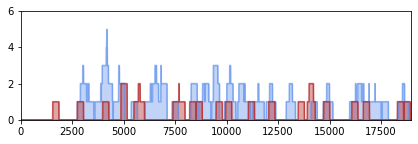

In [180]:
plt.figure(figsize=(7,2))

plt.plot(range(18959),vars_adar,color='cornflowerblue',alpha=0.7)
plt.fill_between(range(18959),vars_adar,color='cornflowerblue',alpha=0.4)

plt.plot(range(18959),vars_nonadar,color='firebrick',alpha=0.7)
plt.fill_between(range(18959),vars_nonadar,color='firebrick',alpha=0.4)


plt.ylim(0,6)
plt.xlim(0,18959)


In [122]:
sing_df[sing_df['animal']=='RA1779']['alleles'].value_counts()

AG    8
AC    6
GA    2
TG    2
AT    2
CT    1
TC    1
Name: alleles, dtype: int64

In [130]:
sing_df['alleles'].value_counts()

AG    36
TC    24
CT    12
GA    11
AC    10
TG     8
AT     7
GT     2
TA     2
Name: alleles, dtype: int64

In [129]:
sing_df.groupby(['alleles','type']).size().unstack().reindex(['AG','TC','CT','AC','TG','AT','GT','TA'])

type     noncoding  nonsynonymous  synonymous
alleles                                      
AG            11.0           12.0        13.0
TC            12.0            4.0         8.0

array([<AxesSubplot:ylabel='RA0452'>, <AxesSubplot:ylabel='RA0700'>,
       <AxesSubplot:ylabel='RA0717'>, <AxesSubplot:ylabel='RA0917'>,
       <AxesSubplot:ylabel='RA1074'>, <AxesSubplot:ylabel='RA1325'>,
       <AxesSubplot:ylabel='RA1423'>, <AxesSubplot:ylabel='RA1639'>,
       <AxesSubplot:ylabel='RA1779'>, <AxesSubplot:ylabel='RA1790'>,
       <AxesSubplot:ylabel='RA1818'>], dtype=object)

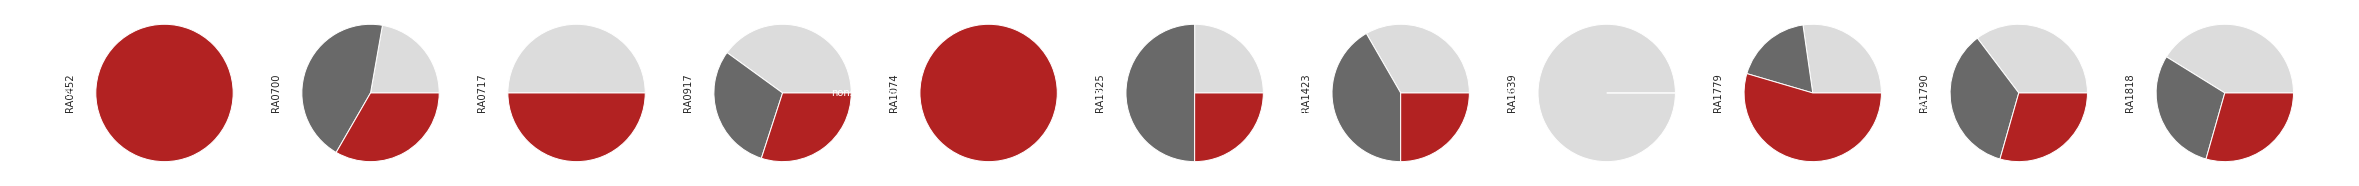

In [92]:
cmap_alleles = ['gainsboro','dimgrey','firebrick']
plt.rcParams.update({'text.color': 'white'})

sing_df.groupby(['type','animal']).size().unstack().reindex(['noncoding','synonymous','nonsynonymous']).plot(kind='pie',
        subplots=True,figsize=(40,5),colors=cmap_alleles,legend=False)
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


array([<AxesSubplot:ylabel='D004'>, <AxesSubplot:ylabel='D005'>,
       <AxesSubplot:ylabel='D006'>, <AxesSubplot:ylabel='D007'>,
       <AxesSubplot:ylabel='D008'>], dtype=object)

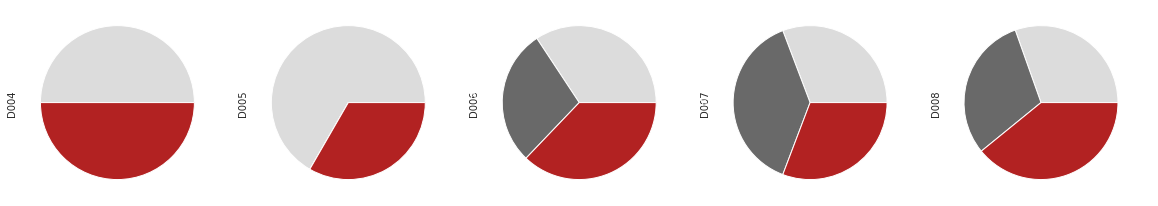

In [54]:
cmap_alleles = ['gainsboro','dimgrey','firebrick']
plt.rcParams.update({'text.color': 'white'})

sing_df.groupby(['type','cohort']).size().unstack().reindex(['noncoding','synonymous','nonsynonymous']).plot(kind='pie',
        subplots=True,figsize=(20,5),colors=cmap_alleles,legend=False)

#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


array([<AxesSubplot:ylabel='Kidney'>,
       <AxesSubplot:ylabel='Lymph node (ax)'>,
       <AxesSubplot:ylabel='Lymph node (ing)'>,
       <AxesSubplot:ylabel='Lymph node (mes)'>,
       <AxesSubplot:ylabel='Sex Organ'>, <AxesSubplot:ylabel='Spleen'>,
       <AxesSubplot:ylabel='Whole blood'>], dtype=object)

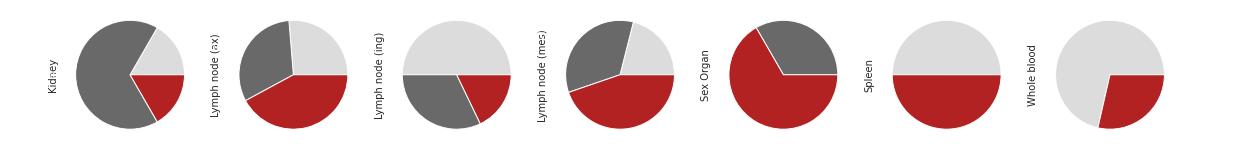

In [55]:
plt.rcParams.update({'text.color': 'white'})

sing_df.groupby(['type','tissue']).size().unstack().reindex(['noncoding','synonymous','nonsynonymous']).plot(kind='pie',
        subplots=True,figsize=(20,5),colors=cmap_alleles,legend=False)
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


<AxesSubplot:xlabel='animal'>

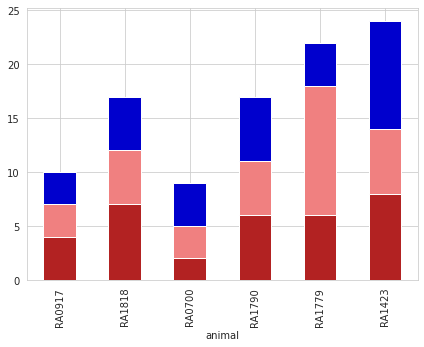

In [39]:
cmap_alleles = ['firebrick','lightcoral','mediumblue','cornflowerblue','grey','grey','grey','grey','grey']

sing_df.groupby(['type','animal']).size().unstack().T.reindex(['RA0917','RA1818','RA0700','RA1790','RA1779','RA1423']).plot(kind='bar',
        stacked=True,figsize=(7,5),legend=False,color=cmap_alleles)
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


<AxesSubplot:xlabel='animal'>

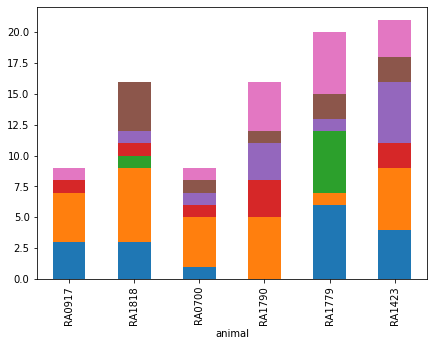

In [41]:
cmap_alleles = ['firebrick','lightcoral','mediumblue','cornflowerblue','grey','grey','grey','grey','grey']

sing_df.groupby(['gene_transcript','animal']).size().unstack().T.reindex(['RA0917','RA1818','RA0700','RA1790','RA1779','RA1423']).plot(kind='bar',
        stacked=True,figsize=(7,5),legend=False)
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


array([<AxesSubplot:ylabel='noncoding'>,
       <AxesSubplot:ylabel='nonsynonymous'>,
       <AxesSubplot:ylabel='synonymous'>], dtype=object)

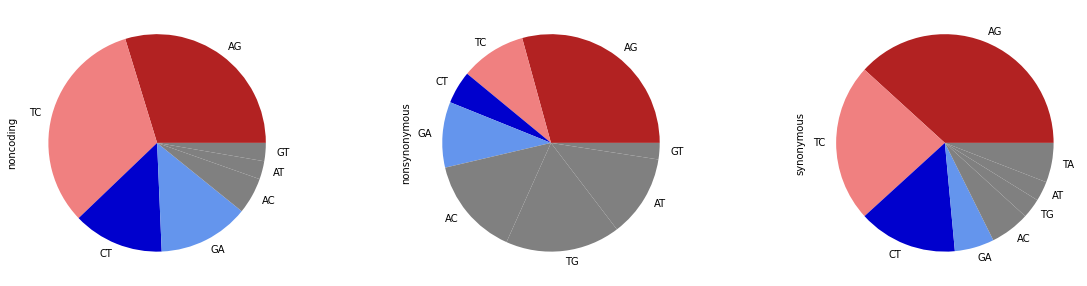

In [135]:
cmap_alleles = ['firebrick','lightcoral','mediumblue','cornflowerblue','grey','grey','grey','grey','grey']

sing_df.groupby(['alleles','type']).size().unstack().reindex(['AG','TC','CT','GA','AC','TG','AT','GT','TA']).plot(kind='pie',
        subplots=True,figsize=(20,5),colors=cmap_alleles,legend=False)
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


<AxesSubplot:xlabel='animal'>

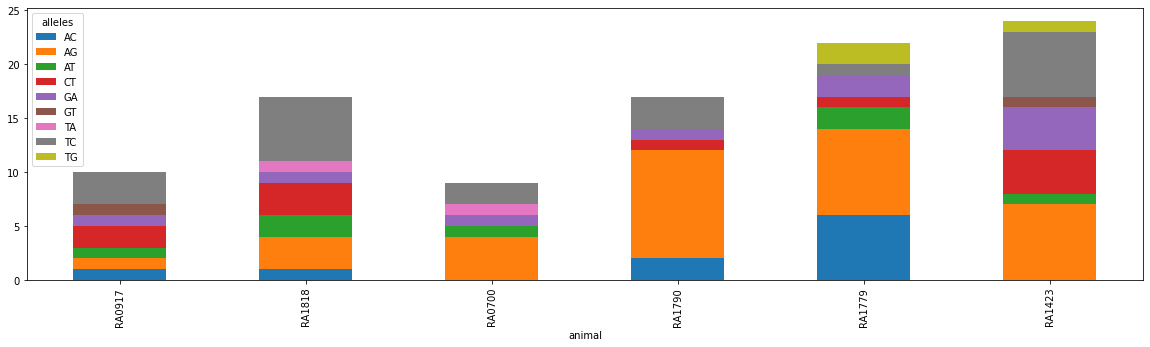

In [42]:
cmap_alleles = ['firebrick','lightcoral','mediumblue','cornflowerblue','grey','grey','grey','grey','grey']

sing_df.groupby(['animal','alleles']).size().unstack().reindex(['RA0917','RA1818','RA0700','RA1790','RA1779','RA1423']).plot(kind='bar',
        stacked=True,figsize=(20,5))
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


<AxesSubplot:xlabel='animal'>

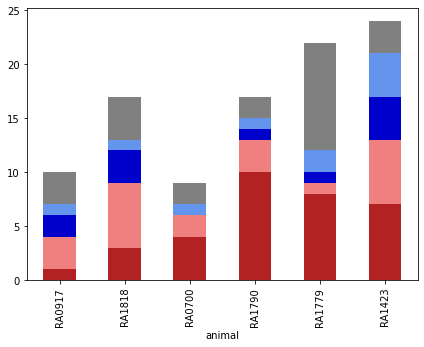

In [43]:
cmap_alleles = ['firebrick','lightcoral','mediumblue','cornflowerblue','grey','grey','grey','grey','grey']

sing_df.groupby(['alleles','animal']).size().unstack().reindex(['AG','TC','CT','GA','AC','TG','AT','GT','TA']).T.reindex(['RA0917','RA1818','RA0700','RA1790','RA1779','RA1423']).plot(kind='bar',
        stacked=True,figsize=(7,5),legend=False,color=cmap_alleles)
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


<AxesSubplot:xlabel='tissue'>

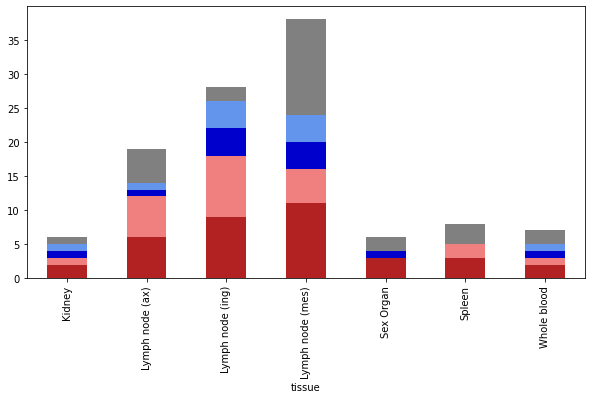

In [44]:
cmap_alleles = ['firebrick','lightcoral','mediumblue','cornflowerblue','grey','grey','grey','grey','grey']

sing_df.groupby(['alleles','tissue']).size().unstack().reindex(['AG','TC','CT','GA','AC','TG','AT','GT','TA']).T.plot(kind='bar',
        stacked=True,figsize=(10,5),legend=False,color=cmap_alleles)
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


(0.0, 18959.0)

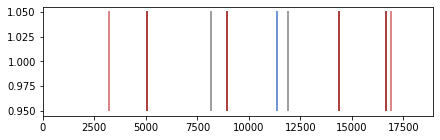

In [197]:
plt.figure(figsize=(7,2))

df_temp = sing_df[sing_df['animal']=='RA0700']

plt.scatter(df_temp['POS'],[1]*len(df_temp['freq']),color='grey',marker='|',s=10000)
plt.scatter(df_temp[df_temp['alleles']=='AG']['POS'],
            [1]*len(df_temp[df_temp['alleles']=='AG']),color='firebrick',marker='|',s=10000)
plt.scatter(df_temp[df_temp['alleles']=='TC']['POS'],
            [1]*len(df_temp[df_temp['alleles']=='TC']),color='lightcoral',marker='|',s=10000)
plt.scatter(df_temp[df_temp['alleles']=='CT']['POS'],
            [1]*len(df_temp[df_temp['alleles']=='CT']),color='mediumblue',marker='|',s=10000)
plt.scatter(df_temp[df_temp['alleles']=='GA']['POS'],
            [1]*len(df_temp[df_temp['alleles']=='GA']),color='cornflowerblue',marker='|',s=10000)

plt.xlim(0,18959)


(0.0, 18959.0)

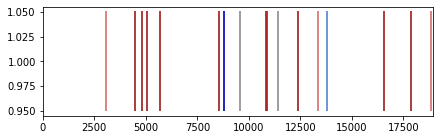

In [196]:
plt.figure(figsize=(7,2))

df_temp = sing_df[sing_df['animal']=='RA1790']

plt.scatter(df_temp['POS'],[1]*len(df_temp['freq']),color='grey',marker='|',s=10000)
plt.scatter(df_temp[df_temp['alleles']=='AG']['POS'],
            [1]*len(df_temp[df_temp['alleles']=='AG']),color='firebrick',marker='|',s=10000)
plt.scatter(df_temp[df_temp['alleles']=='TC']['POS'],
            [1]*len(df_temp[df_temp['alleles']=='TC']),color='lightcoral',marker='|',s=10000)
plt.scatter(df_temp[df_temp['alleles']=='CT']['POS'],
            [1]*len(df_temp[df_temp['alleles']=='CT']),color='mediumblue',marker='|',s=10000)
plt.scatter(df_temp[df_temp['alleles']=='GA']['POS'],
            [1]*len(df_temp[df_temp['alleles']=='GA']),color='cornflowerblue',marker='|',s=10000)

plt.xlim(0,18959)


(0.0, 0.2)

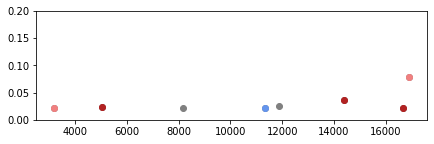

In [175]:
plt.figure(figsize=(7,2))

df_temp = sing_df[sing_df['animal']=='RA0700']

plt.scatter(df_temp['POS'],df_temp['freq'],color='grey')
plt.scatter(df_temp[df_temp['alleles']=='AG']['POS'],
            df_temp[df_temp['alleles']=='AG']['freq'],color='firebrick')
plt.scatter(df_temp[df_temp['alleles']=='TC']['POS'],
            df_temp[df_temp['alleles']=='TC']['freq'],color='lightcoral')
plt.scatter(df_temp[df_temp['alleles']=='CT']['POS'],
            df_temp[df_temp['alleles']=='CT']['freq'],color='mediumblue')
plt.scatter(df_temp[df_temp['alleles']=='GA']['POS'],
            df_temp[df_temp['alleles']=='GA']['freq'],color='cornflowerblue')

plt.ylim(0,.2)


In [138]:
sing_df['tissue'].value_counts()

Lymph node (mes)    38
Lymph node (ing)    28
Lymph node (ax)     19
Spleen               8
Whole blood          7
Kidney               6
Sex Organ            6
Name: tissue, dtype: int64

array([<AxesSubplot:ylabel='Kidney'>,
       <AxesSubplot:ylabel='Lymph node (ax)'>,
       <AxesSubplot:ylabel='Lymph node (ing)'>,
       <AxesSubplot:ylabel='Lymph node (mes)'>,
       <AxesSubplot:ylabel='Sex Organ'>, <AxesSubplot:ylabel='Spleen'>,
       <AxesSubplot:ylabel='Whole blood'>], dtype=object)

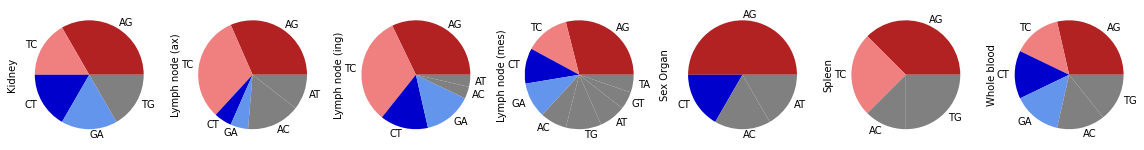

In [137]:
cmap_alleles = ['firebrick','lightcoral','mediumblue','cornflowerblue','grey','grey','grey','grey','grey']

sing_df.groupby(['alleles','tissue']).size().unstack().reindex(['AG','TC','CT','GA','AC','TG','AT','GT','TA']).plot(kind='pie',
        subplots=True,figsize=(20,5),colors=cmap_alleles,legend=False)
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


array([<AxesSubplot:ylabel='RA0452'>, <AxesSubplot:ylabel='RA0700'>,
       <AxesSubplot:ylabel='RA0717'>, <AxesSubplot:ylabel='RA0917'>,
       <AxesSubplot:ylabel='RA1074'>, <AxesSubplot:ylabel='RA1325'>,
       <AxesSubplot:ylabel='RA1423'>, <AxesSubplot:ylabel='RA1639'>,
       <AxesSubplot:ylabel='RA1779'>, <AxesSubplot:ylabel='RA1790'>,
       <AxesSubplot:ylabel='RA1818'>], dtype=object)

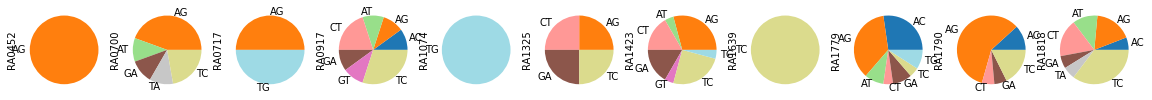

In [46]:
sing_df.groupby(['alleles','animal']).size().unstack().plot(kind='pie',
        subplots=True,figsize=(20,5),colormap="tab20",legend=False)
#plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


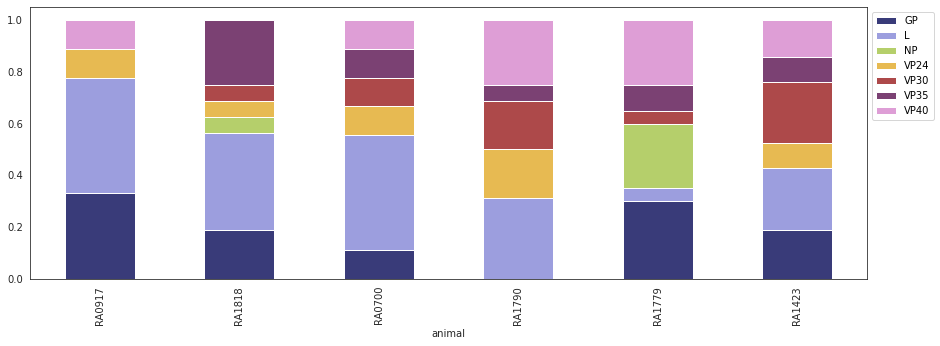

In [86]:
plt.rcParams.update({'text.color': 'black'})

sing_df.groupby(['animal','gene_transcript']).size().unstack().div(sing_df.groupby(['animal','gene_transcript']).size().unstack().sum(axis=1), 
        axis=0).reindex(['RA0917','RA1818','RA0700','RA1790','RA1779','RA1423']).plot(kind='bar',
        stacked=True,figsize=(15,5),colormap="tab20b")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


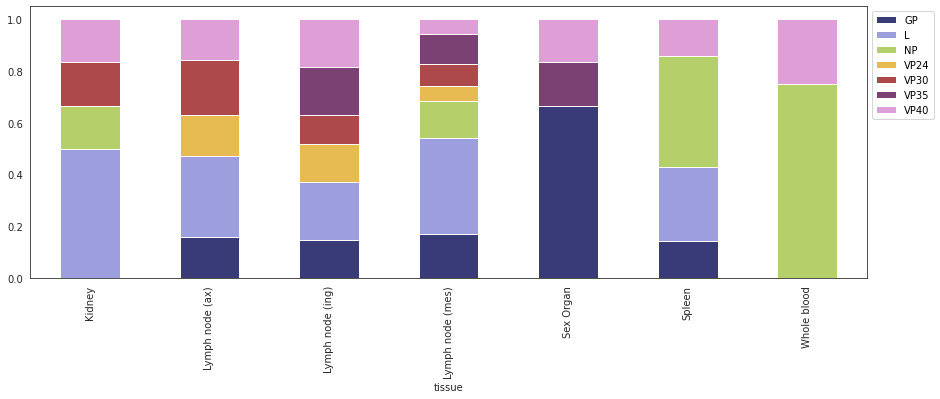

In [88]:
plt.rcParams.update({'text.color': 'black'})

sing_df.groupby(['tissue','gene_transcript']).size().unstack().div(sing_df.groupby(['tissue','gene_transcript']).size().unstack().sum(axis=1), 
        axis=0).plot(kind='bar',
        stacked=True,figsize=(15,5),colormap="tab20b")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')


### basic seq stats

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 5)

g = sns.violinplot(x=metrics[metrics['assembly_length_unambiguous']>18011]['assembly_mean_coverage'],cut=0,inner='point',saturation=0.5)
#plt.xscale('log')
plt.axvline(x=100,color='red')
#plt.xlim(0.1,10000)

In [ ]:
plt.hist(metrics[metrics['assembly_length_unambiguous']>18011]['assembly_mean_coverage'],bins=160,range=(0,16000))
#plt.xlim(1000,16000)
#plt.ylim(0,20)
plt.yscale('log')
plt.xscale('log')

In [76]:
len(metrics[metrics['assembly_length_unambiguous']>18011])

NameError: name 'metrics' is not defined

## variant validation

In [4]:
response = fapi.get_entities_tsv(funding,workspace,"viral_validation",model="flexible")
validation_set = pd.read_csv(StringIO(response.text),sep="\t", index_col="entity:viral_validation_id")
validation_set.head()

ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [ ]:
files = list(validation_set['lofreq_vcf'])
samples = list(validation_set.index)

all_iSNV_list = []
for file,sample in zip(files,samples):
    df = pd.read_table(file,sep='\t',skiprows=15)
    df['sample'] = sample
    all_iSNV_list.append(df)
validation_isnvs = pd.concat(all_iSNV_list, ignore_index=True, axis=0)

validation_isnvs[['depth','freq','qual','reads']] = validation_isnvs['INFO'].str.split(';', 3, expand=True)
validation_isnvs = validation_isnvs.reset_index(drop=True)

validation_isnvs['depth'] = validation_isnvs['depth'].str[3:]
validation_isnvs['freq'] = validation_isnvs['freq'].str[3:]

validation_isnvs[["depth", "freq"]] = validation_isnvs[["depth", "freq"]].apply(pd.to_numeric)
validation_isnvs['variant_reads'] = round(validation_isnvs['depth']*validation_isnvs['freq'])

validation_isnvs['alleles'] = validation_isnvs['REF']+validation_isnvs['ALT']

validation_isnvs.head()

In [ ]:
validation_isnvs['sample'].value_counts()

In [ ]:
validation_isnvs[(validation_isnvs['depth']>100)&(validation_isnvs['freq']>0.02)&(validation_isnvs['freq']<0.98)&(validation_isnvs['variant_reads']>5)]['sample'].value_counts()


In [ ]:
df_temp = validation_isnvs[validation_isnvs['sample']=='A0234_validation']
df_temp['alleles'].value_counts().plot.pie(figsize=(10, 10))


In [ ]:
df_temp = validation_isnvs[validation_isnvs['sample']=='A0164_validation']
df_temp['alleles'].value_counts().plot.pie(figsize=(10, 10))

In [ ]:
df_temp = validation_isnvs[validation_isnvs['sample']=='A0029_validation']
df_temp['alleles'].value_counts().plot.pie(figsize=(10, 10))

In [ ]:
df_temp = validation_isnvs[validation_isnvs['sample']=='A0071_validation']
df_temp['alleles'].value_counts().plot.pie(figsize=(10, 10))

In [ ]:
df_temp = validation_isnvs[validation_isnvs['sample']=='A0051_validation']
df_temp['alleles'].value_counts().plot.pie(figsize=(10, 10))

In [ ]:
df_temp = validation_isnvs[validation_isnvs['sample']=='A0149_validation']
df_temp['alleles'].value_counts().plot.pie(figsize=(10, 10))

In [ ]:
validation_isnvs[validation_isnvs['sample']=='A0164_validation']

In [ ]:
isnvs_set_final[isnvs_set_final['A_ID']=='A0164']

## annotation -- done locally for now

In [14]:
files = list(isnvs_files['lofreq_vcf'])
ids = list(isnvs_files['A_identifier'])
animals = list(isnvs_files['animal_ID'])
cohort = list(isnvs_files['cohort'])
description = list(isnvs_files['description'])
tissue = list(isnvs_files['tissue'])

all_iSNV_list = []
for file,aid,ani,coh,desc,tis in zip(files,ids,animals,cohort,description,tissue):
    df = pd.read_table(file,sep='\t',skiprows=15)
    df['A_ID'] = aid
    df['animal'] = ani
    df['cohort'] = coh
    df['description'] = desc
    df['tissue'] = tis
    all_iSNV_list.append(df)
lofreq_isnvs = pd.concat(all_iSNV_list, ignore_index=True, axis=0)

lofreq_isnvs[['depth','freq','qual','reads']] = lofreq_isnvs['INFO'].str.split(';', 3, expand=True)
lofreq_isnvs = lofreq_isnvs.reset_index(drop=True)

lofreq_isnvs['depth'] = lofreq_isnvs['depth'].str[3:]
lofreq_isnvs['freq'] = lofreq_isnvs['freq'].str[3:]

lofreq_isnvs[["depth", "freq"]] = lofreq_isnvs[["depth", "freq"]].apply(pd.to_numeric)
lofreq_isnvs['variant_reads'] = round(lofreq_isnvs['depth']*lofreq_isnvs['freq'])

lofreq_isnvs['alleles'] = lofreq_isnvs['REF']+lofreq_isnvs['ALT']

# integrating annotations from previous df...
lofreq_isnvs = pd.concat([lofreq_isnvs,mut_info],axis=1)

lofreq_isnvs['REF']+lofreq_isnvs['ALT']

lofreq_isnvs.head()

#CHROM   POS ID REF ALT QUAL FILTER  \
0  KU182905.1  1351  .   T   C   91   PASS   
1  KU182905.1  1378  .   T   C   62   PASS   
2  KU182905.1  2153  .   C   T   59   PASS   
3  KU182905.1  4422  .   G   A  109   PASS   
4  KU182905.1  4715  .   G   A   59   PASS   

                                         INFO   A_ID  animal  ...      freq  \
0   DP=1394;AF=0.005739;SB=0;DP4=373,1013,2,6  A0001  RA1803  ...  0.005739   
1    DP=1313;AF=0.004570;SB=6;DP4=494,811,4,2  A0001  RA1803  ...  0.004570   
2   DP=1681;AF=0.003569;SB=1;DP4=564,1109,1,5  A0001  RA1803  ...  0.003569   
3     DP=884;AF=0.010181;SB=0;DP4=561,311,7,4  A0001  RA1803  ...  0.010181   
4  DP=2419;AF=0.002894;SB=2;DP4=1224,1185,6,3  A0001  RA1803  ...  0.002894   

   qual              reads  variant_reads  alleles               eff_type  \
0  SB=0   DP4=373,1013,2,6            8.0       TC     synonymous_variant   
1  SB=6    DP4=494,811,4,2            6.0       TC     synonymous_variant   
2  SB=1   DP4=564,1109,1,5            6.0       CT     synonymous_variant   
3  SB=0    DP4=561,311,7,4            9.0       GA  upstream_gene_variant   
4  SB=2  DP4=1224,1185,6,3            7.0       GA     synonymous_variant   

  eff_gene       eff_protein      n_mut       aa_mut  
0       NP    DF49_53415gpNP   c.882T>C  p.Ala294Ala  
1       NP    DF49_53415gpNP   c.909T>C  p.Ser303Ser  
2       NP    DF49_53415gpNP  c.1684C>T  p.Leu562Leu  
3     VP40  DF49_53415gpVP40   c.-57G>A               
4     VP40  DF49_53415gpVP40   c.237G>A   p.Val79Val  

[5 rows x 24 columns]

In [17]:
# upload annotated vcf and scrub interesting datafields

df = pd.read_table('gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/ebov_annot_isnvs.vcf',sep='\t',skiprows=20)
df.head()


#CHROM   POS ID REF ALT   QUAL FILTER  \
0  KU182905.1  1351  .   T   C   91.0   PASS   
1  KU182905.1  1378  .   T   C   62.0   PASS   
2  KU182905.1  2153  .   C   T   59.0   PASS   
3  KU182905.1  4422  .   G   A  109.0   PASS   
4  KU182905.1  4715  .   G   A   59.0   PASS   

                                                INFO  
0  DP=1394;AF=0.005739;SB=0;DP4=373,1013,2,6;ANN=...  
1  DP=1313;AF=0.004570;SB=6;DP4=494,811,4,2;ANN=C...  
2  DP=1681;AF=0.003569;SB=1;DP4=564,1109,1,5;ANN=...  
3  DP=884;AF=0.010181;SB=0;DP4=561,311,7,4;ANN=A|...  
4  DP=2419;AF=0.002894;SB=2;DP4=1224,1185,6,3;ANN...

In [18]:
# extracts the annotation info from the mess in 'info'

df[['x','eff_type','x','eff_gene','x','x','eff_protein','x','x','n_mut','aa_mut','x']]=df['INFO'].str.split('|', 11, expand=True)
mut_info = df[['eff_type','eff_gene','eff_protein','n_mut','aa_mut']]


In [19]:
mut_info

eff_type eff_gene       eff_protein      n_mut  \
0          synonymous_variant       NP    DF49_53415gpNP   c.882T>C   
1          synonymous_variant       NP    DF49_53415gpNP   c.909T>C   
2          synonymous_variant       NP    DF49_53415gpNP  c.1684C>T   
3       upstream_gene_variant     VP40  DF49_53415gpVP40   c.-57G>A   
4          synonymous_variant     VP40  DF49_53415gpVP40   c.237G>A   
...                       ...      ...               ...        ...   
3188         missense_variant        L     DF49_53415gpL  c.4946A>C   
3189       synonymous_variant        L     DF49_53415gpL  c.5307T>G   
3190         missense_variant        L     DF49_53415gpL  c.5813A>G   
3191  downstream_gene_variant        L     DF49_53415gpL  c.*365C>T   
3192  downstream_gene_variant        L     DF49_53415gpL  c.*692G>A   

            aa_mut  
0      p.Ala294Ala  
1      p.Ser303Ser  
2      p.Leu562Leu  
3                   
4       p.Val79Val  
...            ...  
3188  p.Asn1649Thr  
3189  p.Ser1769Ser  
3190  p.Lys1938Arg  
3191                
3192                

[3193 rows x 5 columns]

## constructing a workable dataframe

In [20]:
files = list(isnvs_files['lofreq_vcf'])
ids = list(isnvs_files['A_identifier'])
animals = list(isnvs_files['animal_ID'])
cohort = list(isnvs_files['cohort'])
description = list(isnvs_files['description'])
tissue = list(isnvs_files['tissue'])

all_iSNV_list = []
for file,aid,ani,coh,desc,tis in zip(files,ids,animals,cohort,description,tissue):
    df = pd.read_table(file,sep='\t',skiprows=15)
    df['A_ID'] = aid
    df['animal'] = ani
    df['cohort'] = coh
    df['description'] = desc
    df['tissue'] = tis
    all_iSNV_list.append(df)
lofreq_isnvs = pd.concat(all_iSNV_list, ignore_index=True, axis=0)

lofreq_isnvs[['depth','freq','qual','reads']] = lofreq_isnvs['INFO'].str.split(';', 3, expand=True)
lofreq_isnvs = lofreq_isnvs.reset_index(drop=True)

lofreq_isnvs['depth'] = lofreq_isnvs['depth'].str[3:]
lofreq_isnvs['freq'] = lofreq_isnvs['freq'].str[3:]

lofreq_isnvs[["depth", "freq"]] = lofreq_isnvs[["depth", "freq"]].apply(pd.to_numeric)
lofreq_isnvs['variant_reads'] = round(lofreq_isnvs['depth']*lofreq_isnvs['freq'])

lofreq_isnvs['alleles'] = lofreq_isnvs['REF']+lofreq_isnvs['ALT']

# integrating annotations from previous df...
lofreq_isnvs = pd.concat([lofreq_isnvs,mut_info],axis=1)

lofreq_isnvs['REF']+lofreq_isnvs['ALT']

lofreq_isnvs.head()

#CHROM   POS ID REF ALT QUAL FILTER  \
0  KU182905.1  1351  .   T   C   91   PASS   
1  KU182905.1  1378  .   T   C   62   PASS   
2  KU182905.1  2153  .   C   T   59   PASS   
3  KU182905.1  4422  .   G   A  109   PASS   
4  KU182905.1  4715  .   G   A   59   PASS   

                                         INFO   A_ID  animal  ...      freq  \
0   DP=1394;AF=0.005739;SB=0;DP4=373,1013,2,6  A0001  RA1803  ...  0.005739   
1    DP=1313;AF=0.004570;SB=6;DP4=494,811,4,2  A0001  RA1803  ...  0.004570   
2   DP=1681;AF=0.003569;SB=1;DP4=564,1109,1,5  A0001  RA1803  ...  0.003569   
3     DP=884;AF=0.010181;SB=0;DP4=561,311,7,4  A0001  RA1803  ...  0.010181   
4  DP=2419;AF=0.002894;SB=2;DP4=1224,1185,6,3  A0001  RA1803  ...  0.002894   

   qual              reads  variant_reads  alleles               eff_type  \
0  SB=0   DP4=373,1013,2,6            8.0       TC     synonymous_variant   
1  SB=6    DP4=494,811,4,2            6.0       TC     synonymous_variant   
2  SB=1   DP4=564,1109,1,5            6.0       CT     synonymous_variant   
3  SB=0    DP4=561,311,7,4            9.0       GA  upstream_gene_variant   
4  SB=2  DP4=1224,1185,6,3            7.0       GA     synonymous_variant   

  eff_gene       eff_protein      n_mut       aa_mut  
0       NP    DF49_53415gpNP   c.882T>C  p.Ala294Ala  
1       NP    DF49_53415gpNP   c.909T>C  p.Ser303Ser  
2       NP    DF49_53415gpNP  c.1684C>T  p.Leu562Leu  
3     VP40  DF49_53415gpVP40   c.-57G>A               
4     VP40  DF49_53415gpVP40   c.237G>A   p.Val79Val  

[5 rows x 24 columns]

## prelim exploration

In [21]:
# check a few stats -- samples that have variants (and how many)

lofreq_isnvs['description'].value_counts()

Spleen2_RA0700_D007         220
Spleen2_RA1790_D007         117
Spleen2_RA1779_D008         109
Spleen2_RA1423_D008         106
Lymph node 1_RA0917_D006     92
                           ... 
Lung_RA1639_D005              2
Kidney_RA1639_D005            2
Liver_RA1818_D006             2
Liver_RA1639_D005             2
Spleen_RA1834_D003            1
Name: description, Length: 97, dtype: int64

Text(0, 0.5, 'number of variants')

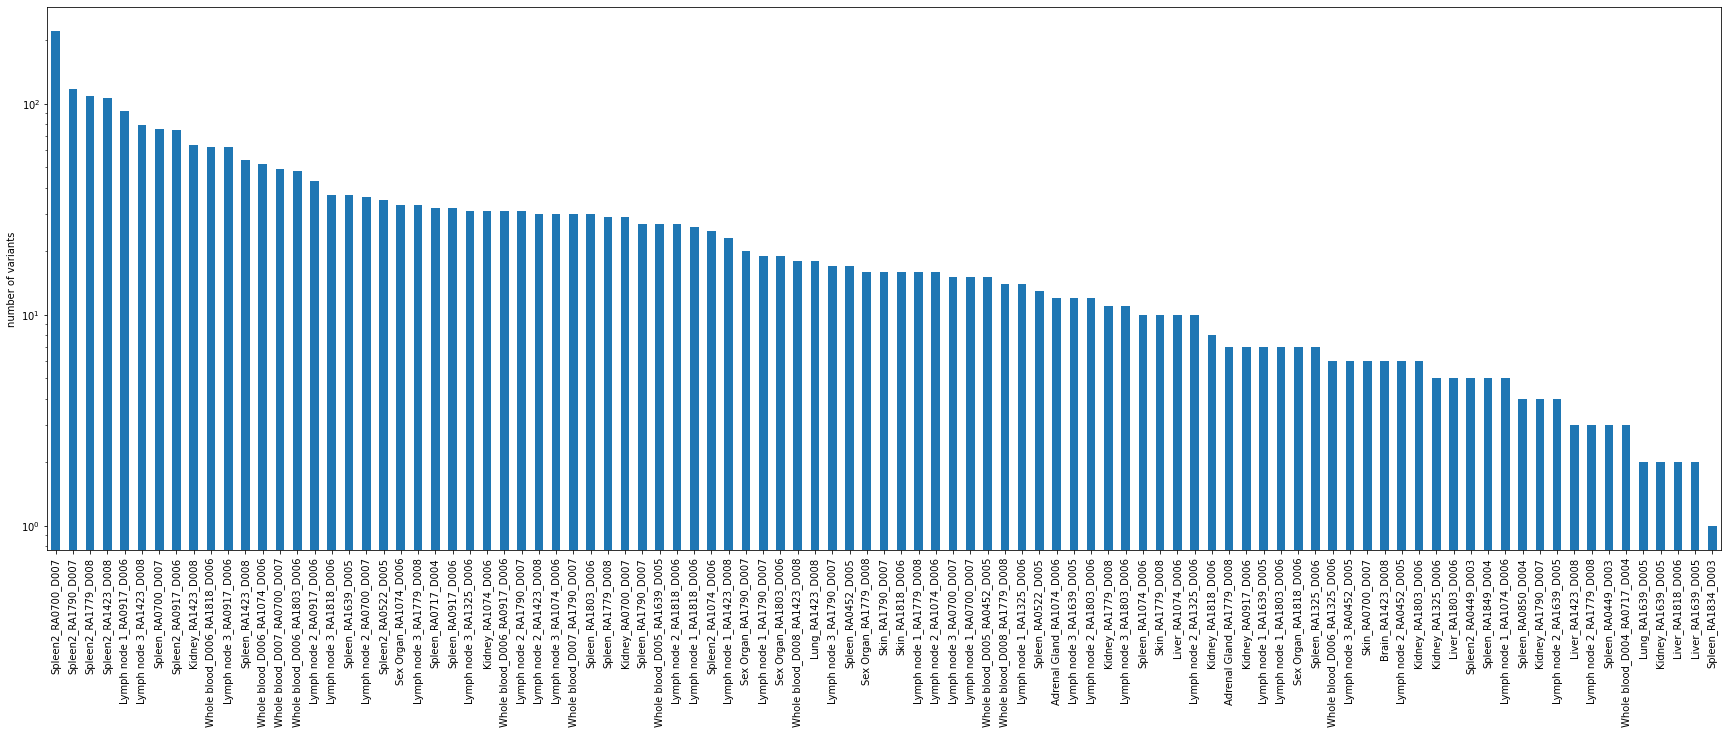

In [22]:
pd.DataFrame(lofreq_isnvs['description'].value_counts()).plot.bar(figsize=(30, 10),legend=False)
plt.yscale('log')
plt.ylabel('number of variants')

In [23]:
# 141 samples where iSNVs were detected
# many with a bunch of iSNVs!

In [24]:
# rough check for highly overlapping variants

lofreq_isnvs['POS'].value_counts()[:10]

7668     101
11282     64
10343     54
16526     53
8050      46
4715      44
16239     39
5077      29
12066     29
7787      28
Name: POS, dtype: int64

Text(0, 0.5, 'number of variants')

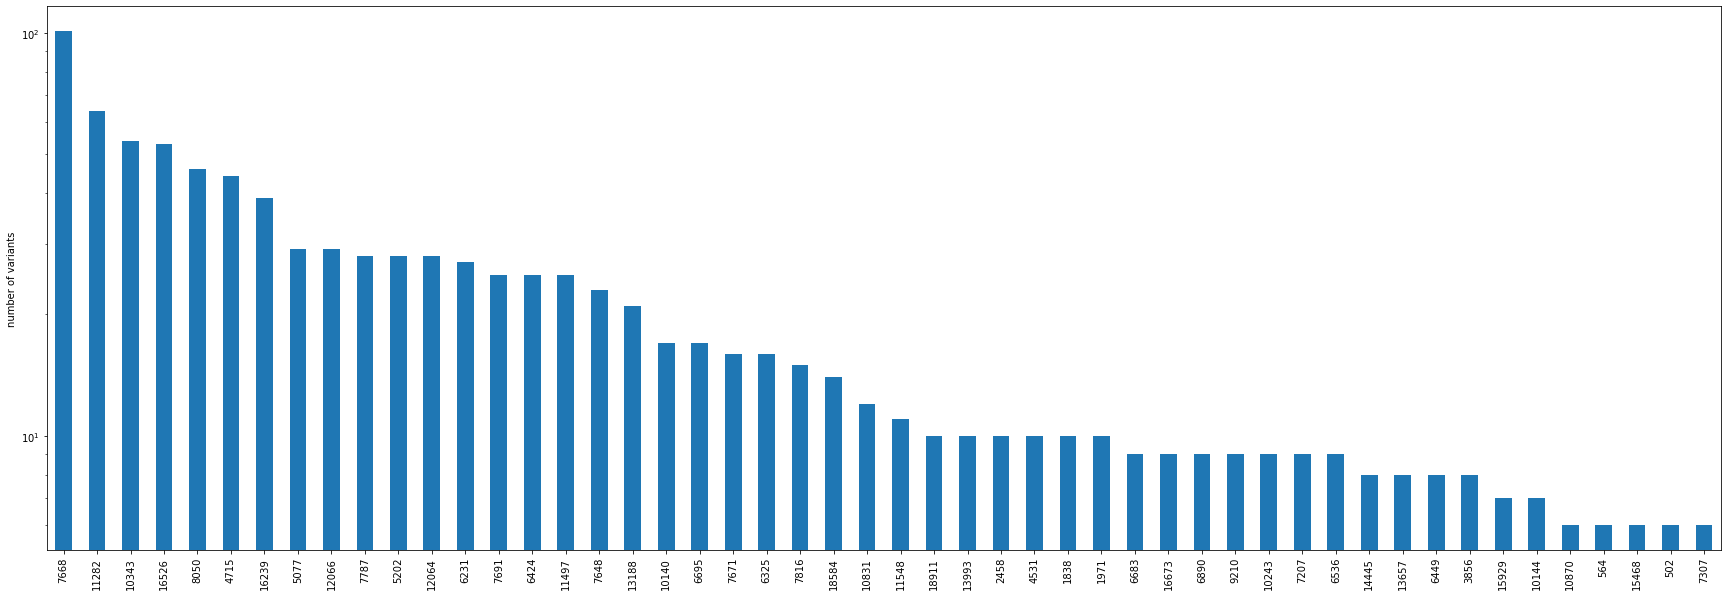

In [25]:
pd.DataFrame(lofreq_isnvs['POS'].value_counts()[:50]).plot.bar(figsize=(30, 10),legend=False)
plt.yscale('log')
plt.ylabel('number of variants')

In [26]:
# lots of shared muts!
## T7668G is that GP TC adaptation Aaron mentioned

In [27]:
# common and NS in L gene
lofreq_isnvs[lofreq_isnvs['POS']==16526].head()

#CHROM    POS ID REF ALT  QUAL FILTER  \
27   KU182905.1  16526  .   A   C   273   PASS   
89   KU182905.1  16526  .   A   C    99   PASS   
121  KU182905.1  16526  .   A   C   339   PASS   
191  KU182905.1  16526  .   A   C  3003   PASS   
371  KU182905.1  16526  .   A   C  2613   PASS   

                                                 INFO   A_ID  animal  ...  \
27         DP=2051;AF=0.010726;SB=1;DP4=1451,577,17,5  A0001  RA1803  ...   
89           DP=446;AF=0.015695;SB=15;DP4=272,166,8,0  A0012  RA1803  ...   
121      DP=2762;AF=0.009413;SB=1;DP4=1684,1050,15,11  A0029  RA0717  ...   
191    DP=15160;AF=0.014314;SB=6;DP4=9704,5230,153,68  A0043  RA0700  ...   
371  DP=14637;AF=0.012776;SB=27;DP4=9108,5270,132,115  A0043  RA0700  ...   

         freq   qual                  reads  variant_reads  alleles  \
27   0.010726   SB=1      DP4=1451,577,17,5           22.0       AC   
89   0.015695  SB=15        DP4=272,166,8,0            7.0       AC   
121  0.009413   SB=1    DP4=1684,1050,15,11           26.0       AC   
191  0.014314   SB=6   DP4=9704,5230,153,68          217.0       AC   
371  0.012776  SB=27  DP4=9108,5270,132,115          187.0       AC   

               eff_type eff_gene    eff_protein      n_mut        aa_mut  
27     missense_variant        L  DF49_53415gpL  c.4946A>C  p.Asn1649Thr  
89     missense_variant        L  DF49_53415gpL  c.4946A>C  p.Asn1649Thr  
121    missense_variant        L  DF49_53415gpL  c.4946A>C  p.Asn1649Thr  
191  synonymous_variant        L  DF49_53415gpL  c.4080T>C  p.Tyr1360Tyr  
371    missense_variant        L  DF49_53415gpL  c.4237C>A  p.Leu1413Ile  

[5 rows x 24 columns]

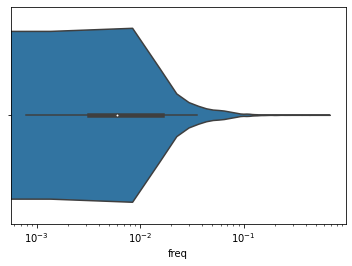

In [28]:
# rough idea of frequency dist -- looks like avg. of 2-3% but mostly >1% 

sns.violinplot(x=lofreq_isnvs['freq'],figsize=(30, 10))
plt.xscale('log')

In [ ]:
lofreq_isnvs['freq'].plot.hist(bins=50,figsize=(30, 10))


In [ ]:
lofreq_isnvs['freq'].plot.hist(bins=120,figsize=(30, 10))
plt.xlim(0,0.5)
plt.axvline(x=0.01,color='red')

In [ ]:
# number of variants <1% frequency
len(lofreq_isnvs[(lofreq_isnvs['freq']<0.01)|(lofreq_isnvs['freq']>0.99)])

In [ ]:
# number of variants >1% frequency
len(lofreq_isnvs[(lofreq_isnvs['freq']>0.01)&(lofreq_isnvs['freq']<0.99)])

In [ ]:
# number of variants >3% frequency
len(lofreq_isnvs[(lofreq_isnvs['freq']>0.03)&(lofreq_isnvs['freq']<0.97)])

In [ ]:
# number of variants with >10% frequency
len(lofreq_isnvs[(lofreq_isnvs['freq']>0.1)&(lofreq_isnvs['freq']<0.9)])

In [ ]:
# number of variants with >20% frequency
len(lofreq_isnvs[(lofreq_isnvs['freq']>0.2)&(lofreq_isnvs['freq']<0.8)])

## filtering -- at >2% freq for now

In [29]:
# using cutoffs defined in covid autopsy data
isnvs_set_final = lofreq_isnvs[(lofreq_isnvs['freq']>0.02)&(lofreq_isnvs['freq']<0.98)]
isnvs_set_final = isnvs_set_final[isnvs_set_final['variant_reads']>5]
isnvs_set_final = isnvs_set_final[isnvs_set_final['depth']>100]

# and getting rid of some useless columns
isnvs_set_final = isnvs_set_final[['description','A_ID','animal','cohort','tissue','POS','depth','variant_reads','freq','alleles','eff_type','eff_gene','eff_protein','aa_mut']]

# saving csv to file
isnvs_set_final.to_csv(r'gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/210507_all_viral_variants.csv',index=False,header=True)


In [30]:
len(isnvs_set_final)

372

In [31]:
isnvs_set_final

description   A_ID  animal cohort       tissue    POS  \
15              Spleen_RA1803_D006  A0001  RA1803   D006       Spleen   7668   
20              Spleen_RA1803_D006  A0001  RA1803   D006       Spleen  10343   
22              Spleen_RA1803_D006  A0001  RA1803   D006       Spleen  11282   
37               Liver_RA1803_D006  A0003  RA1803   D006        Liver   7668   
47        Lymph node 1_RA1803_D006  A0008  RA1803   D006   Lymph node   6695   
...                            ...    ...     ...    ...          ...    ...   
2526  Whole blood_D006_RA1325_D006  A0370  RA1325   D006  Whole blood  11282   
2527  Whole blood_D006_RA1325_D006  A0370  RA1325   D006  Whole blood  16526   
2551  Whole blood_D006_RA1803_D006  A0375  RA1803   D006  Whole blood   7668   
2560  Whole blood_D006_RA1803_D006  A0375  RA1803   D006  Whole blood  10343   
2564  Whole blood_D006_RA1803_D006  A0375  RA1803   D006  Whole blood  11282   

       depth  variant_reads      freq alleles               eff_type eff_gene  \
15    1942.0           86.0  0.044284      TC              stop_lost       GP   
20     646.0           19.0  0.029412      CA  upstream_gene_variant     VP24   
22    1065.0           45.0  0.042254      AC  upstream_gene_variant        L   
37     778.0           47.0  0.060411      TC              stop_lost       GP   
47     265.0            6.0  0.022642      AG     synonymous_variant     SsGP   
...      ...            ...       ...     ...                    ...      ...   
2526   180.0           11.0  0.061111      AC  upstream_gene_variant        L   
2527   287.0           10.0  0.034843      AC  upstream_gene_variant        L   
2551  3548.0          178.0  0.050169      TC     synonymous_variant       NP   
2560  1744.0           38.0  0.021789      CA     synonymous_variant     VP35   
2564  2746.0          106.0  0.038602      AC     synonymous_variant     VP35   

           eff_protein            aa_mut  
15      DF49_53415gpGP  p.Ter544Glnext*?  
20    DF49_53415gpVP24                    
22       DF49_53415gpL                    
37      DF49_53415gpGP  p.Ter544Glnext*?  
47    DF49_53415gpSsGP       p.Arg219Arg  
...                ...               ...  
2526     DF49_53415gpL                    
2527     DF49_53415gpL                    
2551    DF49_53415gpNP       p.Leu585Leu  
2560  DF49_53415gpVP35        p.Thr62Thr  
2564  DF49_53415gpVP35       p.Ile102Ile  

[372 rows x 14 columns]

In [32]:
len(list(set(isnvs_set_final['POS'])))

161

In [33]:
isnvs_set_final[(isnvs_set_final['eff_type']=='missense_variant')|(isnvs_set_final['eff_type']=='stop_lost')|(isnvs_set_final['eff_type']=='stop_gained')]['eff_gene'].value_counts()


L       64
GP      47
VP40    24
SsGP    20
NP      12
VP24     7
VP30     4
VP35     3
sGP      3
Name: eff_gene, dtype: int64

In [34]:
isnvs_set_final['POS'].value_counts()[:30]

7668     83
11282    48
10343    28
4531      9
5077      6
2458      6
16526     6
8050      5
169       4
16239     4
12064     4
502       3
6231      3
12066     3
2997      3
4624      2
7648      2
18411     2
6890      2
10243     2
18631     2
8565      2
2946      2
7657      2
4715      2
6695      2
5166      1
10187     1
12221     1
3311      1
Name: POS, dtype: int64

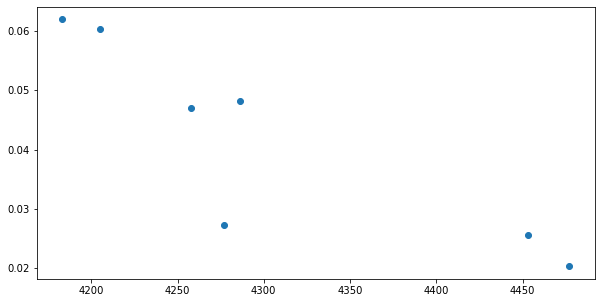

In [38]:
lower = 4151
upper = 4479

plt.figure(figsize=(10,5))

plt.scatter(isnvs_set_final[(isnvs_set_final['POS']>lower)&(isnvs_set_final['POS']<upper)]['POS'],isnvs_set_final[(isnvs_set_final['POS']>lower)&(isnvs_set_final['POS']<upper)]['freq'])
            

In [39]:
isnvs_set_final[(isnvs_set_final['eff_type']=='upstream_gene_variant')&(isnvs_set_final['eff_gene']=='VP40')]


description   A_ID  animal cohort      tissue    POS  \
809        Spleen2_RA0522_D005  A0113  RA0522   D005     Spleen2  16526   
1062  Lymph node 3_RA1790_D007  A0150  RA1790   D007  Lymph node   7668   
1209          Skin_RA1818_D006  A0168  RA1818   D006        Skin   7668   
1447  Lymph node 2_RA0917_D006  A0191  RA0917   D006  Lymph node   9782   

       depth  variant_reads      freq alleles               eff_type eff_gene  \
809    557.0           15.0  0.026930      AC  upstream_gene_variant     VP40   
1062   685.0           23.0  0.033577      TC  upstream_gene_variant     VP40   
1209  1466.0          108.0  0.073670      TC  upstream_gene_variant     VP40   
1447  1432.0           39.0  0.027235      GA  upstream_gene_variant     VP40   

           eff_protein aa_mut  
809   DF49_53415gpVP40         
1062  DF49_53415gpVP40         
1209  DF49_53415gpVP40         
1447  DF49_53415gpVP40

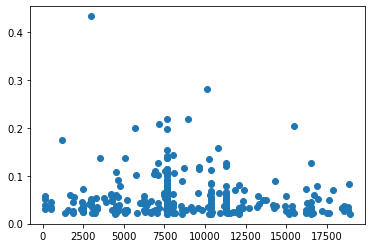

In [40]:


plt.scatter(isnvs_set_final['POS'],isnvs_set_final['freq'])

In [41]:
isnvs_set_final[["cohort", "eff_type"]].groupby("cohort").count()


eff_type
cohort          
D004           6
D005          41
D006         150
D007          68
D008         107

In [42]:
isnvs_set_final[isnvs_set_final['eff_type']=='upstream_gene_variant']['eff_gene'].value_counts()

L       15
VP24    14
VP35     6
SsGP     4
VP30     4
VP40     4
NP       2
Name: eff_gene, dtype: int64

In [43]:
isnvs_set_final[isnvs_set_final['POS']==10343]

description   A_ID  animal cohort       tissue    POS  \
20              Spleen_RA1803_D006  A0001  RA1803   D006       Spleen  10343   
113             Spleen_RA0717_D004  A0029  RA0717   D004       Spleen  10343   
482       Lymph node 2_RA0700_D007  A0051  RA0700   D007   Lymph node  10343   
540             Spleen_RA1779_D008  A0071  RA1779   D008       Spleen  10343   
608            Spleen2_RA1779_D008  A0071  RA1779   D008      Spleen2  10343   
708       Lymph node 1_RA1779_D008  A0078  RA1779   D008   Lymph node  10343   
736       Lymph node 3_RA1779_D008  A0080  RA1779   D008   Lymph node  10343   
824             Spleen_RA0452_D005  A0127  RA0452   D005       Spleen  10343   
860             Spleen_RA1790_D007  A0141  RA1790   D007       Spleen  10343   
920            Spleen2_RA1790_D007  A0141  RA1790   D007      Spleen2  10343   
1015      Lymph node 1_RA1790_D007  A0148  RA1790   D007   Lymph node  10343   
1125      Lymph node 1_RA1818_D006  A0162  RA1818   D006   Lymph node  10343   
1153      Lymph node 2_RA1818_D006  A0163  RA1818   D006   Lymph node  10343   
1212              Skin_RA1818_D006  A0168  RA1818   D006         Skin  10343   
1451      Lymph node 2_RA0917_D006  A0191  RA0917   D006   Lymph node  10343   
1564            Spleen_RA1423_D008  A0197  RA1423   D008       Spleen  10343   
1634           Spleen2_RA1423_D008  A0197  RA1423   D008      Spleen2  10343   
1783      Lymph node 1_RA1423_D008  A0204  RA1423   D008   Lymph node  10343   
1939            Spleen_RA1639_D005  A0211  RA1639   D005       Spleen  10343   
1974      Lymph node 3_RA1639_D005  A0220  RA1639   D005   Lymph node  10343   
2103            Kidney_RA1074_D006    NaN  RA1074   D006       Kidney  10343   
2245  Whole blood_D007_RA0700_D007  A0306  RA0700   D007  Whole blood  10343   
2310  Whole blood_D006_RA1818_D006  A0309  RA1818   D006  Whole blood  10343   
2341  Whole blood_D008_RA1779_D008  A0312  RA1779   D008  Whole blood  10343   
2366  Whole blood_D007_RA1790_D007  A0315  RA1790   D007  Whole blood  10343   
2418  Whole blood_D008_RA1423_D008  A0321  RA1423   D008  Whole blood  10343   
2456  Whole blood_D005_RA1639_D005  A0348  RA1639   D005  Whole blood  10343   
2560  Whole blood_D006_RA1803_D006  A0375  RA1803   D006  Whole blood  10343   

       depth  variant_reads      freq alleles                 eff_type  \
20     646.0           19.0  0.029412      CA    upstream_gene_variant   
113    728.0           16.0  0.021978      CA    upstream_gene_variant   
482    998.0           26.0  0.026052      CA         missense_variant   
540   1505.0          101.0  0.067110      CA         missense_variant   
608   1265.0           69.0  0.054545      CA    upstream_gene_variant   
708    241.0           27.0  0.112033      CA                stop_lost   
736    765.0           63.0  0.082353      CA         missense_variant   
824    297.0            8.0  0.026936      CA         missense_variant   
860   1434.0           32.0  0.022315      CA         missense_variant   
920   1347.0           29.0  0.021529      CA    upstream_gene_variant   
1015   296.0           25.0  0.084459      CA         missense_variant   
1125   328.0           16.0  0.048780      CA       synonymous_variant   
1153   354.0           15.0  0.042373      CA       synonymous_variant   
1212   248.0           13.0  0.052419      CA         missense_variant   
1451  2431.0           49.0  0.020156      CA       synonymous_variant   
1564  2020.0           48.0  0.023762      CA         missense_variant   
1634  2324.0           54.0  0.023236      CA       synonymous_variant   
1783   378.0           12.0  0.031746      CA  downstream_gene_variant   
1939  1553.0           37.0  0.023825      CA         missense_variant   
1974   164.0            6.0  0.036585      CA         missense_variant   
2103   358.0            9.0  0.025140      CA       synonymous_variant   
2245  3515.0           76.0  0.021622      CA    upstream_gene_variant   


In [44]:
isnvs_set_final[isnvs_set_final['eff_type']=='downstream_gene_variant']['eff_gene'].value_counts()

L    21
Name: eff_gene, dtype: int64

In [45]:
isnvs_set_final['A_ID'].value_counts()


A0163    15
A0206    13
A0148    12
A0080    12
A0197    11
         ..
A0213     1
A0212     1
A0003     1
A0169     1
A0154     1
Name: A_ID, Length: 72, dtype: int64

In [46]:
isnvs_set_final[(isnvs_set_final['eff_gene']=='VP35')&(isnvs_set_final['freq']>0.1)&(isnvs_set_final['freq']<0.9)]


description   A_ID  animal cohort      tissue   POS  \
77       Sex Organ_RA1803_D006  A0012  RA1803   D006   Sex Organ  2946   
536         Spleen_RA1779_D008  A0071  RA1779   D008      Spleen  7668   
1443  Lymph node 2_RA0917_D006  A0191  RA0917   D006  Lymph node  7668   
2001  Lymph node 1_RA1325_D006  A0232  RA1325   D006  Lymph node  7554   

       depth  variant_reads      freq alleles               eff_type eff_gene  \
77     217.0           94.0  0.433180      AC  upstream_gene_variant     VP35   
536   2647.0          281.0  0.106158      TC       missense_variant     VP35   
1443  4201.0          576.0  0.137110      TC  upstream_gene_variant     VP35   
2001   587.0           65.0  0.110733      AC       missense_variant     VP35   

           eff_protein       aa_mut  
77    DF49_53415gpVP35               
536   DF49_53415gpVP35  p.Ser310Gly  
1443  DF49_53415gpVP35               
2001  DF49_53415gpVP35   p.Asp76Gly

In [47]:
isnvs_set_final[isnvs_set_final['eff_gene']=='VP35']['POS'].value_counts()


7668     6
11282    3
2946     2
10343    2
2866     1
8168     1
11891    1
17621    1
7554     1
2458     1
18584    1
Name: POS, dtype: int64

In [48]:
isnvs_set_final[isnvs_set_final['POS']==2946]


description   A_ID  animal cohort      tissue   POS  depth  \
66  Lymph node 3_RA1803_D006  A0010  RA1803   D006  Lymph node  2946  178.0   
77     Sex Organ_RA1803_D006  A0012  RA1803   D006   Sex Organ  2946  217.0   

    variant_reads      freq alleles               eff_type eff_gene  \
66            9.0  0.050562      AC  upstream_gene_variant     VP35   
77           94.0  0.433180      AC  upstream_gene_variant     VP35   

         eff_protein aa_mut  
66  DF49_53415gpVP35         
77  DF49_53415gpVP35

In [49]:
isnvs_set_final['A_ID'].value_counts()[:20]


A0163    15
A0206    13
A0148    12
A0080    12
A0197    11
A0071    10
A0009     9
A0205     8
A0113     8
A0077     7
A0164     7
A0220     7
A0149     7
A0312     7
A0198     7
A0052     7
A0051     7
A0141     6
A0147     6
A0191     6
Name: A_ID, dtype: int64

In [50]:
isnvs_set_final['POS'].value_counts()


7668     83
11282    48
10343    28
4531      9
5077      6
         ..
11745     1
4286      1
2455      1
7489      1
18584     1
Name: POS, Length: 161, dtype: int64

In [51]:
isnvs_set_final[isnvs_set_final['freq']>0.2]

description   A_ID  animal cohort      tissue    POS  \
77       Sex Organ_RA1803_D006  A0012  RA1803   D006   Sex Organ   2946   
457   Lymph node 1_RA0700_D007  A0050  RA0700   D007  Lymph node   8931   
749           Skin_RA1779_D008  A0083  RA1779   D008        Skin   7161   
1966  Lymph node 2_RA1639_D005  A0219  RA1639   D005  Lymph node  10144   
1967  Lymph node 2_RA1639_D005  A0219  RA1639   D005  Lymph node  15453   
2150     Sex Organ_RA1074_D006    NaN  RA1074   D006   Sex Organ   7668   

      depth  variant_reads      freq alleles               eff_type eff_gene  \
77    217.0           94.0  0.433180      AC  upstream_gene_variant     VP35   
457   285.0           62.0  0.217544      AG       missense_variant     VP40   
749   893.0          186.0  0.208287      CT     synonymous_variant     SsGP   
1966  135.0           38.0  0.281481      AG  upstream_gene_variant     VP24   
1967  138.0           28.0  0.202899      AG  upstream_gene_variant     VP24   
2150  456.0          100.0  0.219298      TC     synonymous_variant        L   

           eff_protein        aa_mut  
77    DF49_53415gpVP35                
457   DF49_53415gpVP40    p.Ala55Ser  
749   DF49_53415gpSsGP   p.Thr284Thr  
1966  DF49_53415gpVP24                
1967  DF49_53415gpVP24                
2150     DF49_53415gpL  p.Thr1453Thr

In [52]:
isnvs_set_final[isnvs_set_final['POS']==16526]

description   A_ID  animal cohort       tissue    POS  \
744       Lymph node 3_RA1779_D008  A0080  RA1779   D008   Lymph node  16526   
776             Spleen_RA0522_D005  A0113  RA0522   D005       Spleen  16526   
809            Spleen2_RA0522_D005  A0113  RA0522   D005      Spleen2  16526   
1160      Lymph node 2_RA1818_D006  A0163  RA1818   D006   Lymph node  16526   
1787      Lymph node 1_RA1423_D008  A0204  RA1423   D008   Lymph node  16526   
2527  Whole blood_D006_RA1325_D006  A0370  RA1325   D006  Whole blood  16526   

       depth  variant_reads      freq alleles                 eff_type  \
744   2730.0          120.0  0.043956      AC         missense_variant   
776    571.0           19.0  0.033275      AC       synonymous_variant   
809    557.0           15.0  0.026930      AC    upstream_gene_variant   
1160  1549.0           42.0  0.027114      AC       synonymous_variant   
1787  1162.0          148.0  0.127367      AC  downstream_gene_variant   
2527   287.0           10.0  0.034843      AC    upstream_gene_variant   

     eff_gene       eff_protein       aa_mut  
744        NP    DF49_53415gpNP  p.Ser471Gly  
776        GP    DF49_53415gpGP  p.Pro423Pro  
809      VP40  DF49_53415gpVP40               
1160       NP    DF49_53415gpNP  p.Pro499Pro  
1787        L     DF49_53415gpL               
2527        L     DF49_53415gpL

In [53]:
isnvs_set_final['alleles'].value_counts()


TC    126
AC     78
AG     54
GA     35
CA     32
CT     21
TG     12
AT      8
TA      3
GT      3
Name: alleles, dtype: int64

In [54]:
isnvs_set_final['eff_gene'].value_counts()


L       137
GP       60
VP40     49
NP       36
SsGP     31
VP24     24
VP35     20
VP30     11
sGP       4
Name: eff_gene, dtype: int64

In [55]:
isnvs_set_final['eff_type'].value_counts()


missense_variant           160
synonymous_variant         118
upstream_gene_variant       49
downstream_gene_variant     21
stop_lost                   20
stop_gained                  4
Name: eff_type, dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


(5.702114366533178, 500)

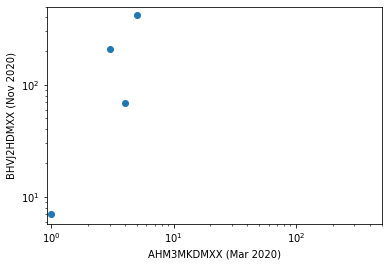

In [56]:
x_cov = [9608,2460,51,243]
y_cov = [10180,2132,49,234]

x_var = [3,5,1,4]
y_var = [208,423,7,69]

plt.scatter(x_var,y_var)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('AHM3MKDMXX (Mar 2020)')
plt.ylabel('BHVJ2HDMXX (Nov 2020)')

plt.xlim(0,500)
plt.ylim(0,500)


In [57]:
len(isnvs_set_final[isnvs_set_final['description']=='Spleen_RA0522_D005'])

4

In [58]:
len(isnvs_set_final[isnvs_set_final['description']=='Spleen2_RA0522_D005'])

4

In [59]:
isnvs_set_final[(isnvs_set_final['freq']>.15)&(isnvs_set_final['animal']=='RA1803')][['POS','tissue','depth','variant_reads','freq']]

POS     tissue  depth  variant_reads     freq
77  2946  Sex Organ  217.0           94.0  0.43318

In [60]:
isnvs_set_final['A_ID'].value_counts()

A0163    15
A0206    13
A0148    12
A0080    12
A0197    11
         ..
A0213     1
A0212     1
A0003     1
A0169     1
A0154     1
Name: A_ID, Length: 72, dtype: int64

In [61]:
lofreq_isnvs[(lofreq_isnvs['POS']==10343)&(lofreq_isnvs['animal']=='RA1803')][['A_ID','tissue','depth','variant_reads','freq']]

A_ID       tissue   depth  variant_reads      freq
20    A0001       Spleen   646.0           19.0  0.029412
44    A0007    Sex Organ    27.0            3.0  0.111111
75    A0010   Lymph node    96.0           15.0  0.156250
84    A0012    Sex Organ    94.0           42.0  0.446809
2560  A0375  Whole blood  1744.0           38.0  0.021789

In [62]:
lofreq_isnvs[(lofreq_isnvs['POS']==9426)&(lofreq_isnvs['animal']=='RA1423')]

#CHROM   POS ID REF ALT  QUAL FILTER  \
1907  KU182905.1  9426  .   T   C  1607   PASS   

                                       INFO   A_ID  animal  ...      freq  \
1907  DP=71;AF=0.676056;SB=16;DP4=4,16,1,50  A0207  RA1423  ...  0.676056   

       qual          reads  variant_reads  alleles            eff_type  \
1907  SB=16  DP4=4,16,1,50           48.0       TC  synonymous_variant   

     eff_gene       eff_protein     n_mut       aa_mut  
1907     VP24  DF49_53415gpVP24  c.448C>T  p.Leu150Leu  

[1 rows x 24 columns]

In [63]:
isnvs_set_final[(isnvs_set_final['freq']>0.1)&(isnvs_set_final['eff_gene']=='GP')]['alleles'].value_counts()


TC    2
CA    1
GA    1
Name: alleles, dtype: int64

In [64]:
isnvs_set_final['eff_gene'].value_counts()

L       137
GP       60
VP40     49
NP       36
SsGP     31
VP24     24
VP35     20
VP30     11
sGP       4
Name: eff_gene, dtype: int64

In [65]:
isnvs_set_final[(isnvs_set_final['freq']>0.2)&(isnvs_set_final['freq']<0.8)]

description   A_ID  animal cohort      tissue    POS  \
77       Sex Organ_RA1803_D006  A0012  RA1803   D006   Sex Organ   2946   
457   Lymph node 1_RA0700_D007  A0050  RA0700   D007  Lymph node   8931   
749           Skin_RA1779_D008  A0083  RA1779   D008        Skin   7161   
1966  Lymph node 2_RA1639_D005  A0219  RA1639   D005  Lymph node  10144   
1967  Lymph node 2_RA1639_D005  A0219  RA1639   D005  Lymph node  15453   
2150     Sex Organ_RA1074_D006    NaN  RA1074   D006   Sex Organ   7668   

      depth  variant_reads      freq alleles               eff_type eff_gene  \
77    217.0           94.0  0.433180      AC  upstream_gene_variant     VP35   
457   285.0           62.0  0.217544      AG       missense_variant     VP40   
749   893.0          186.0  0.208287      CT     synonymous_variant     SsGP   
1966  135.0           38.0  0.281481      AG  upstream_gene_variant     VP24   
1967  138.0           28.0  0.202899      AG  upstream_gene_variant     VP24   
2150  456.0          100.0  0.219298      TC     synonymous_variant        L   

           eff_protein        aa_mut  
77    DF49_53415gpVP35                
457   DF49_53415gpVP40    p.Ala55Ser  
749   DF49_53415gpSsGP   p.Thr284Thr  
1966  DF49_53415gpVP24                
1967  DF49_53415gpVP24                
2150     DF49_53415gpL  p.Thr1453Thr

In [66]:
isnvs_set_final[(isnvs_set_final['POS']>14000)&(isnvs_set_final['POS']<15000)]

description   A_ID  animal cohort      tissue    POS  \
512   Lymph node 3_RA0700_D007  A0052  RA0700   D007  Lymph node  14390   
1003     Sex Organ_RA1790_D007  A0147  RA1790   D007   Sex Organ  14944   
1157  Lymph node 2_RA1818_D006  A0163  RA1818   D006  Lymph node  14211   
1158  Lymph node 2_RA1818_D006  A0163  RA1818   D006  Lymph node  14988   
1195  Lymph node 3_RA1818_D006  A0164  RA1818   D006  Lymph node  14235   
1744        Kidney_RA1423_D008  A0198  RA1423   D008      Kidney  14298   

       depth  variant_reads      freq alleles            eff_type eff_gene  \
512    634.0           23.0  0.036278      AG    missense_variant     VP40   
1003   224.0            8.0  0.035714      TC    missense_variant        L   
1157   786.0           30.0  0.038168      CT           stop_lost       GP   
1158   412.0           11.0  0.026699      TC  synonymous_variant        L   
1195  2491.0           81.0  0.032517      TA    missense_variant       GP   
1744  1830.0          163.0  0.089071      GA    missense_variant        L   

           eff_protein            aa_mut  
512   DF49_53415gpVP40       p.Ala113Val  
1003     DF49_53415gpL       p.Lys955Asn  
1157    DF49_53415gpGP  p.Ter544Glnext*?  
1158     DF49_53415gpL      p.Tyr1815Tyr  
1195    DF49_53415gpGP       p.Ile407Asn  
1744     DF49_53415gpL       p.Lys255Thr

In [67]:
isnvs_set_final[isnvs_set_final['POS']==16526]

description   A_ID  animal cohort       tissue    POS  \
744       Lymph node 3_RA1779_D008  A0080  RA1779   D008   Lymph node  16526   
776             Spleen_RA0522_D005  A0113  RA0522   D005       Spleen  16526   
809            Spleen2_RA0522_D005  A0113  RA0522   D005      Spleen2  16526   
1160      Lymph node 2_RA1818_D006  A0163  RA1818   D006   Lymph node  16526   
1787      Lymph node 1_RA1423_D008  A0204  RA1423   D008   Lymph node  16526   
2527  Whole blood_D006_RA1325_D006  A0370  RA1325   D006  Whole blood  16526   

       depth  variant_reads      freq alleles                 eff_type  \
744   2730.0          120.0  0.043956      AC         missense_variant   
776    571.0           19.0  0.033275      AC       synonymous_variant   
809    557.0           15.0  0.026930      AC    upstream_gene_variant   
1160  1549.0           42.0  0.027114      AC       synonymous_variant   
1787  1162.0          148.0  0.127367      AC  downstream_gene_variant   
2527   287.0           10.0  0.034843      AC    upstream_gene_variant   

     eff_gene       eff_protein       aa_mut  
744        NP    DF49_53415gpNP  p.Ser471Gly  
776        GP    DF49_53415gpGP  p.Pro423Pro  
809      VP40  DF49_53415gpVP40               
1160       NP    DF49_53415gpNP  p.Pro499Pro  
1787        L     DF49_53415gpL               
2527        L     DF49_53415gpL

In [68]:
isnvs_set_final[isnvs_set_final['POS']==12066]

description   A_ID  animal cohort      tissue    POS  \
710   Lymph node 1_RA1779_D008  A0078  RA1779   D008  Lymph node  12066   
826         Spleen_RA0452_D005  A0127  RA0452   D005      Spleen  12066   
2219     Sex Organ_RA1074_D006    NaN  RA1074   D006   Sex Organ  12066   

      depth  variant_reads      freq alleles            eff_type eff_gene  \
710   441.0            9.0  0.020408      TC         stop_gained        L   
826   545.0           13.0  0.023853      TC  synonymous_variant        L   
2219  302.0           10.0  0.033113      TC    missense_variant     VP40   

           eff_protein        aa_mut  
710      DF49_53415gpL     p.Glu728*  
826      DF49_53415gpL  p.Leu1948Leu  
2219  DF49_53415gpVP40   p.Thr242Ala

In [69]:
isnvs_set_final[(isnvs_set_final['POS']>9375)&(isnvs_set_final['POS']<10345)]

description   A_ID  animal cohort       tissue    POS  \
20              Spleen_RA1803_D006  A0001  RA1803   D006       Spleen  10343   
113             Spleen_RA0717_D004  A0029  RA0717   D004       Spleen  10343   
482       Lymph node 2_RA0700_D007  A0051  RA0700   D007   Lymph node  10343   
540             Spleen_RA1779_D008  A0071  RA1779   D008       Spleen  10343   
608            Spleen2_RA1779_D008  A0071  RA1779   D008      Spleen2  10343   
708       Lymph node 1_RA1779_D008  A0078  RA1779   D008   Lymph node  10343   
736       Lymph node 3_RA1779_D008  A0080  RA1779   D008   Lymph node  10343   
824             Spleen_RA0452_D005  A0127  RA0452   D005       Spleen  10343   
860             Spleen_RA1790_D007  A0141  RA1790   D007       Spleen  10343   
920            Spleen2_RA1790_D007  A0141  RA1790   D007      Spleen2  10343   
1014      Lymph node 1_RA1790_D007  A0148  RA1790   D007   Lymph node   9586   
1015      Lymph node 1_RA1790_D007  A0148  RA1790   D007   Lymph node  10343   
1125      Lymph node 1_RA1818_D006  A0162  RA1818   D006   Lymph node  10343   
1150      Lymph node 2_RA1818_D006  A0163  RA1818   D006   Lymph node   9568   
1153      Lymph node 2_RA1818_D006  A0163  RA1818   D006   Lymph node  10343   
1212              Skin_RA1818_D006  A0168  RA1818   D006         Skin  10343   
1394      Lymph node 1_RA0917_D006  A0190  RA0917   D006   Lymph node  10304   
1447      Lymph node 2_RA0917_D006  A0191  RA0917   D006   Lymph node   9782   
1451      Lymph node 2_RA0917_D006  A0191  RA0917   D006   Lymph node  10343   
1564            Spleen_RA1423_D008  A0197  RA1423   D008       Spleen  10343   
1634           Spleen2_RA1423_D008  A0197  RA1423   D008      Spleen2  10343   
1782      Lymph node 1_RA1423_D008  A0204  RA1423   D008   Lymph node  10187   
1783      Lymph node 1_RA1423_D008  A0204  RA1423   D008   Lymph node  10343   
1804      Lymph node 2_RA1423_D008  A0205  RA1423   D008   Lymph node   9651   
1805      Lymph node 2_RA1423_D008  A0205  RA1423   D008   Lymph node   9654   
1939            Spleen_RA1639_D005  A0211  RA1639   D005       Spleen  10343   
1966      Lymph node 2_RA1639_D005  A0219  RA1639   D005   Lymph node  10144   
1973      Lymph node 3_RA1639_D005  A0220  RA1639   D005   Lymph node  10243   
1974      Lymph node 3_RA1639_D005  A0220  RA1639   D005   Lymph node  10343   
2032      Lymph node 3_RA1325_D006  A0234  RA1325   D006   Lymph node  10243   
2103            Kidney_RA1074_D006    NaN  RA1074   D006       Kidney  10343   
2245  Whole blood_D007_RA0700_D007  A0306  RA0700   D007  Whole blood  10343   
2310  Whole blood_D006_RA1818_D006  A0309  RA1818   D006  Whole blood  10343   
2341  Whole blood_D008_RA1779_D008  A0312  RA1779   D008  Whole blood  10343   
2366  Whole blood_D007_RA1790_D007  A0315  RA1790   D007  Whole blood  10343   
2418  Whole blood_D008_RA1423_D008  A0321  RA1423   D008  Whole blood  10343   
2456  Whole blood_D005_RA1639_D005  A0348  RA1639   D005  Whole blood  10343   
2560  Whole blood_D006_RA1803_D006  A0375  RA1803   D006  Whole blood  10343   

       depth  variant_reads      freq alleles                 eff_type  \
20     646.0           19.0  0.029412      CA    upstream_gene_variant   
113    728.0           16.0  0.021978      CA    upstream_gene_variant   
482    998.0           26.0  0.026052      CA         missense_variant   
540   1505.0          101.0  0.067110      CA         missense_variant   
608   1265.0           69.0  0.054545      CA    upstream_gene_variant   
708    241.0           27.0  0.112033      CA                stop_lost   
736    765.0           63.0  0.082353      CA         missense_variant   
824    297.0            8.0  0.026936      CA         missense_variant   
860   1434.0           32.0  0.022315      CA         missense_variant   
920   1347.0           29.0  0.021529      CA    upstream_gene_variant   
1014   484.0           31.0  0.064050      AC         missense_variant   
1015   296.0  

In [70]:
isnvs_set_final[(isnvs_set_final['POS']>9375)&(isnvs_set_final['POS']<10345)]

description   A_ID  animal cohort       tissue    POS  \
20              Spleen_RA1803_D006  A0001  RA1803   D006       Spleen  10343   
113             Spleen_RA0717_D004  A0029  RA0717   D004       Spleen  10343   
482       Lymph node 2_RA0700_D007  A0051  RA0700   D007   Lymph node  10343   
540             Spleen_RA1779_D008  A0071  RA1779   D008       Spleen  10343   
608            Spleen2_RA1779_D008  A0071  RA1779   D008      Spleen2  10343   
708       Lymph node 1_RA1779_D008  A0078  RA1779   D008   Lymph node  10343   
736       Lymph node 3_RA1779_D008  A0080  RA1779   D008   Lymph node  10343   
824             Spleen_RA0452_D005  A0127  RA0452   D005       Spleen  10343   
860             Spleen_RA1790_D007  A0141  RA1790   D007       Spleen  10343   
920            Spleen2_RA1790_D007  A0141  RA1790   D007      Spleen2  10343   
1014      Lymph node 1_RA1790_D007  A0148  RA1790   D007   Lymph node   9586   
1015      Lymph node 1_RA1790_D007  A0148  RA1790   D007   Lymph node  10343   
1125      Lymph node 1_RA1818_D006  A0162  RA1818   D006   Lymph node  10343   
1150      Lymph node 2_RA1818_D006  A0163  RA1818   D006   Lymph node   9568   
1153      Lymph node 2_RA1818_D006  A0163  RA1818   D006   Lymph node  10343   
1212              Skin_RA1818_D006  A0168  RA1818   D006         Skin  10343   
1394      Lymph node 1_RA0917_D006  A0190  RA0917   D006   Lymph node  10304   
1447      Lymph node 2_RA0917_D006  A0191  RA0917   D006   Lymph node   9782   
1451      Lymph node 2_RA0917_D006  A0191  RA0917   D006   Lymph node  10343   
1564            Spleen_RA1423_D008  A0197  RA1423   D008       Spleen  10343   
1634           Spleen2_RA1423_D008  A0197  RA1423   D008      Spleen2  10343   
1782      Lymph node 1_RA1423_D008  A0204  RA1423   D008   Lymph node  10187   
1783      Lymph node 1_RA1423_D008  A0204  RA1423   D008   Lymph node  10343   
1804      Lymph node 2_RA1423_D008  A0205  RA1423   D008   Lymph node   9651   
1805      Lymph node 2_RA1423_D008  A0205  RA1423   D008   Lymph node   9654   
1939            Spleen_RA1639_D005  A0211  RA1639   D005       Spleen  10343   
1966      Lymph node 2_RA1639_D005  A0219  RA1639   D005   Lymph node  10144   
1973      Lymph node 3_RA1639_D005  A0220  RA1639   D005   Lymph node  10243   
1974      Lymph node 3_RA1639_D005  A0220  RA1639   D005   Lymph node  10343   
2032      Lymph node 3_RA1325_D006  A0234  RA1325   D006   Lymph node  10243   
2103            Kidney_RA1074_D006    NaN  RA1074   D006       Kidney  10343   
2245  Whole blood_D007_RA0700_D007  A0306  RA0700   D007  Whole blood  10343   
2310  Whole blood_D006_RA1818_D006  A0309  RA1818   D006  Whole blood  10343   
2341  Whole blood_D008_RA1779_D008  A0312  RA1779   D008  Whole blood  10343   
2366  Whole blood_D007_RA1790_D007  A0315  RA1790   D007  Whole blood  10343   
2418  Whole blood_D008_RA1423_D008  A0321  RA1423   D008  Whole blood  10343   
2456  Whole blood_D005_RA1639_D005  A0348  RA1639   D005  Whole blood  10343   
2560  Whole blood_D006_RA1803_D006  A0375  RA1803   D006  Whole blood  10343   

       depth  variant_reads      freq alleles                 eff_type  \
20     646.0           19.0  0.029412      CA    upstream_gene_variant   
113    728.0           16.0  0.021978      CA    upstream_gene_variant   
482    998.0           26.0  0.026052      CA         missense_variant   
540   1505.0          101.0  0.067110      CA         missense_variant   
608   1265.0           69.0  0.054545      CA    upstream_gene_variant   
708    241.0           27.0  0.112033      CA                stop_lost   
736    765.0           63.0  0.082353      CA         missense_variant   
824    297.0            8.0  0.026936      CA         missense_variant   
860   1434.0           32.0  0.022315      CA         missense_variant   
920   1347.0           29.0  0.021529      CA    upstream_gene_variant   
1014   484.0           31.0  0.064050      AC         missense_variant   
1015   296.0  

In [71]:
isnvs_set_final[isnvs_set_final['tissue']=='Sex Organ']

description   A_ID  animal cohort     tissue    POS   depth  \
77    Sex Organ_RA1803_D006  A0012  RA1803   D006  Sex Organ   2946   217.0   
78    Sex Organ_RA1803_D006  A0012  RA1803   D006  Sex Organ   4715   432.0   
79    Sex Organ_RA1803_D006  A0012  RA1803   D006  Sex Organ   7668   311.0   
85    Sex Organ_RA1803_D006  A0012  RA1803   D006  Sex Organ  12678   182.0   
86    Sex Organ_RA1803_D006  A0012  RA1803   D006  Sex Organ  15344   216.0   
681   Sex Organ_RA1779_D008  A0077  RA1779   D008  Sex Organ   3551  1074.0   
682   Sex Organ_RA1779_D008  A0077  RA1779   D008  Sex Organ   4531   943.0   
686   Sex Organ_RA1779_D008  A0077  RA1779   D008  Sex Organ   6695   750.0   
687   Sex Organ_RA1779_D008  A0077  RA1779   D008  Sex Organ   6890   279.0   
688   Sex Organ_RA1779_D008  A0077  RA1779   D008  Sex Organ   7104   926.0   
689   Sex Organ_RA1779_D008  A0077  RA1779   D008  Sex Organ   7668  1054.0   
692   Sex Organ_RA1779_D008  A0077  RA1779   D008  Sex Organ   7974   392.0   
994   Sex Organ_RA1790_D007  A0147  RA1790   D007  Sex Organ   2455   496.0   
996   Sex Organ_RA1790_D007  A0147  RA1790   D007  Sex Organ   4286   436.0   
1000  Sex Organ_RA1790_D007  A0147  RA1790   D007  Sex Organ   7668   706.0   
1001  Sex Organ_RA1790_D007  A0147  RA1790   D007  Sex Organ   8565   375.0   
1002  Sex Organ_RA1790_D007  A0147  RA1790   D007  Sex Organ  11745   320.0   
1003  Sex Organ_RA1790_D007  A0147  RA1790   D007  Sex Organ  14944   224.0   
1104  Sex Organ_RA1818_D006  A0161  RA1818   D006  Sex Organ   1844   512.0   
1106  Sex Organ_RA1818_D006  A0161  RA1818   D006  Sex Organ   1958   558.0   
1107  Sex Organ_RA1818_D006  A0161  RA1818   D006  Sex Organ   3748   226.0   
2138  Sex Organ_RA1074_D006    NaN  RA1074   D006  Sex Organ   1561   293.0   
2139  Sex Organ_RA1074_D006    NaN  RA1074   D006  Sex Organ   1838   357.0   
2149  Sex Organ_RA1074_D006    NaN  RA1074   D006  Sex Organ   7657   498.0   
2150  Sex Organ_RA1074_D006    NaN  RA1074   D006  Sex Organ   7668   456.0   
2155  Sex Organ_RA1074_D006    NaN  RA1074   D006  Sex Organ  18857   120.0   
2216  Sex Organ_RA1074_D006    NaN  RA1074   D006  Sex Organ   7668   744.0   
2218  Sex Organ_RA1074_D006    NaN  RA1074   D006  Sex Organ  11282   101.0   
2219  Sex Organ_RA1074_D006    NaN  RA1074   D006  Sex Organ  12066   302.0   

      variant_reads      freq alleles               eff_type eff_gene  \
77             94.0  0.433180      AC  upstream_gene_variant     VP35   
78             17.0  0.039352      GA     synonymous_variant     VP40   
79              8.0  0.025723      TC              stop_lost       GP   
85              6.0  0.032967      TC     synonymous_variant        L   
86              6.0  0.027778      TC       missense_variant        L   
681           146.0  0.135940      AG       missense_variant        L   
682            32.0  0.033934      AC       missense_variant        L   
686            35.0  0.046667      AG       missense_variant        L   
687             8.0  0.028674      AT     synonymous_variant        L   
688            39.0  0.042117      AG       missense_variant        L   
689            72.0  0.068311      TC       missense_variant        L   
692            10.0  0.025510      CT       missense_variant        L   
994            36.0  0.072581      TC     synonymous_variant        L   
996            21.0  0.048165      AG       missense_variant        L   
1000           31.0  0.043909      TC       missense_variant        L   
1001           33.0  0.088000      TA     synonymous_variant        L   
1002            8.0  0.025000      CT       missense_variant        L   
1003            8.0  0.035714      TC       missense_variant        L   
1104           11.0  0.021484      GT  upstream_gene_variant     VP30   
1106           31.0  0.055556      CT       missense_variant     VP24   
1107           12.0  0.053097      CT     synonymous_variant     VP24   
2138            8.0  0.027304      CT  

In [72]:
isnvs_set_final['tissue'].value_counts()

Lymph node       188
Spleen            46
Whole blood       38
Sex Organ         29
Spleen2           25
Kidney            21
Adrenal Gland      7
Skin               7
Liver              6
Lung               5
Name: tissue, dtype: int64

In [73]:
isnvs_set_final[(isnvs_set_final['POS']>12070)&(isnvs_set_final['POS']<12500)]

description   A_ID  animal cohort      tissue    POS  \
740   Lymph node 3_RA1779_D008  A0080  RA1779   D008  Lymph node  12353   
1020  Lymph node 1_RA1790_D007  A0148  RA1790   D007  Lymph node  12380   
1192  Lymph node 3_RA1818_D006  A0164  RA1818   D006  Lymph node  12221   
1193  Lymph node 3_RA1818_D006  A0164  RA1818   D006  Lymph node  12341   

       depth  variant_reads      freq alleles          eff_type eff_gene  \
740   1036.0           33.0  0.031853      AC       stop_gained       GP   
1020   314.0           22.0  0.070064      AG  missense_variant        L   
1192  1539.0           52.0  0.033788      AG  missense_variant     SsGP   
1193  1840.0           86.0  0.046739      CT         stop_lost       GP   

           eff_protein            aa_mut  
740     DF49_53415gpGP         p.Gln646*  
1020     DF49_53415gpL      p.Asp1685Tyr  
1192  DF49_53415gpSsGP       p.Ile129Thr  
1193    DF49_53415gpGP  p.Ter544Glnext*?

In [74]:

isnvs_set_final[(isnvs_set_final['POS']>6039)&(isnvs_set_final['POS']<8068)]['POS'].value_counts()


7668    83
8050     5
6231     3
7657     2
6890     2
7648     2
6695     2
7532     1
7531     1
7528     1
7504     1
7102     1
7017     1
7554     1
6324     1
6454     1
7691     1
7109     1
6870     1
8046     1
6819     1
6338     1
6592     1
7489     1
7479     1
7473     1
7161     1
6386     1
7974     1
7104     1
7603     1
7957     1
7142     1
Name: POS, dtype: int64

In [75]:

isnvs_set_final[(isnvs_set_final['POS']>5900)&(isnvs_set_final['POS']<8306)&(isnvs_set_final['freq']>0.1)&(isnvs_set_final['freq']<0.9)]['alleles'].value_counts()


TC    14
AT     3
AC     2
CT     1
Name: alleles, dtype: int64

In [76]:
temp[temp['eff_type']=='stop_gained']['description'].value_counts()

NameError: name 'temp' is not defined

In [77]:
isnvs_set_final['eff_type'].value_counts()

missense_variant           160
synonymous_variant         118
upstream_gene_variant       49
downstream_gene_variant     21
stop_lost                   20
stop_gained                  4
Name: eff_type, dtype: int64

(0.0, 20000.0)

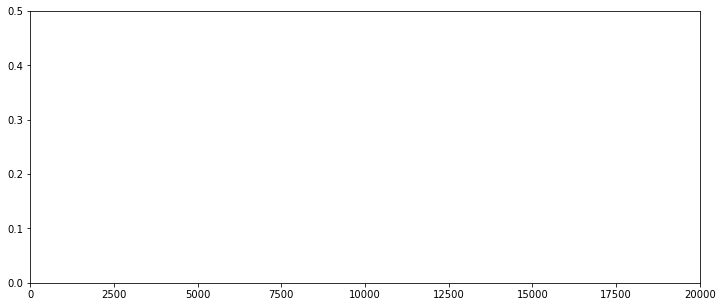

In [78]:
d3_df  = isnvs_set_final[isnvs_set_final['cohort']=='D003']

plt.figure(figsize=(12,5))

temp_syn = d3_df[(d3_df['eff_type']=='synonymous_variant')|(d3_df['eff_type']=='upstream_gene_variant')|(d3_df['eff_type']=='downstream_gene_variant')]
temp_nonsyn = d3_df[(d3_df['eff_type']=='missense_variant')|(d3_df['eff_type']=='stop_lost')|(d3_df['eff_type']=='stop_gained')]

plt.scatter(temp_nonsyn['POS'],temp_nonsyn['freq'],color='red',alpha=.5,label='nonsynonymous')
plt.scatter(temp_syn['POS'],temp_syn['freq'],color='black',alpha=.5,label='synonymous & noncoding')

plt.ylim(0,0.5)
plt.xlim(0,20000)


(0.0, 20000.0)

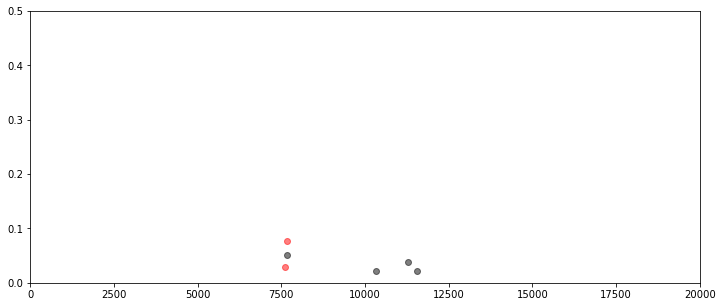

In [79]:
d3_df  = isnvs_set_final[isnvs_set_final['cohort']=='D004']

plt.figure(figsize=(12,5))

temp_syn = d3_df[(d3_df['eff_type']=='synonymous_variant')|(d3_df['eff_type']=='upstream_gene_variant')|(d3_df['eff_type']=='downstream_gene_variant')]
temp_nonsyn = d3_df[(d3_df['eff_type']=='missense_variant')|(d3_df['eff_type']=='stop_lost')|(d3_df['eff_type']=='stop_gained')]

plt.scatter(temp_nonsyn['POS'],temp_nonsyn['freq'],color='red',alpha=.5,label='nonsynonymous')
plt.scatter(temp_syn['POS'],temp_syn['freq'],color='black',alpha=.5,label='synonymous & noncoding')

plt.ylim(0,0.5)
plt.xlim(0,20000)

(0.0, 20000.0)

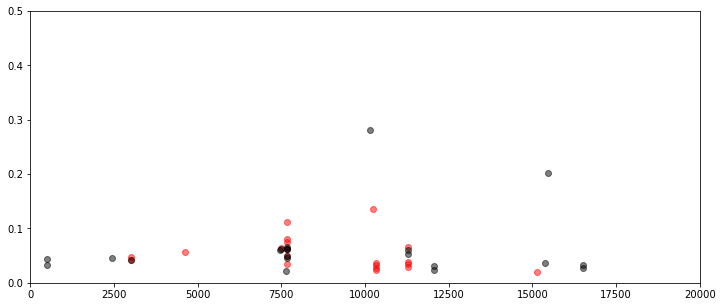

In [80]:
d3_df  = isnvs_set_final[isnvs_set_final['cohort']=='D005']

plt.figure(figsize=(12,5))

temp_syn = d3_df[(d3_df['eff_type']=='synonymous_variant')|(d3_df['eff_type']=='upstream_gene_variant')|(d3_df['eff_type']=='downstream_gene_variant')]
temp_nonsyn = d3_df[(d3_df['eff_type']=='missense_variant')|(d3_df['eff_type']=='stop_lost')|(d3_df['eff_type']=='stop_gained')]

plt.scatter(temp_nonsyn['POS'],temp_nonsyn['freq'],color='red',alpha=.5,label='nonsynonymous')
plt.scatter(temp_syn['POS'],temp_syn['freq'],color='black',alpha=.5,label='synonymous & noncoding')

plt.ylim(0,0.5)
plt.xlim(0,20000)

(0.0, 20000.0)

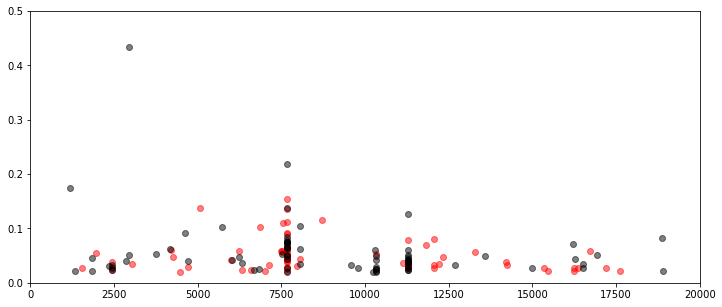

In [81]:
d3_df  = isnvs_set_final[isnvs_set_final['cohort']=='D006']

plt.figure(figsize=(12,5))

temp_syn = d3_df[(d3_df['eff_type']=='synonymous_variant')|(d3_df['eff_type']=='upstream_gene_variant')|(d3_df['eff_type']=='downstream_gene_variant')]
temp_nonsyn = d3_df[(d3_df['eff_type']=='missense_variant')|(d3_df['eff_type']=='stop_lost')|(d3_df['eff_type']=='stop_gained')]

plt.scatter(temp_nonsyn['POS'],temp_nonsyn['freq'],color='red',alpha=.5,label='nonsynonymous')
plt.scatter(temp_syn['POS'],temp_syn['freq'],color='black',alpha=.5,label='synonymous & noncoding')

plt.ylim(0,0.5)
plt.xlim(0,20000)

(0.0, 20000.0)

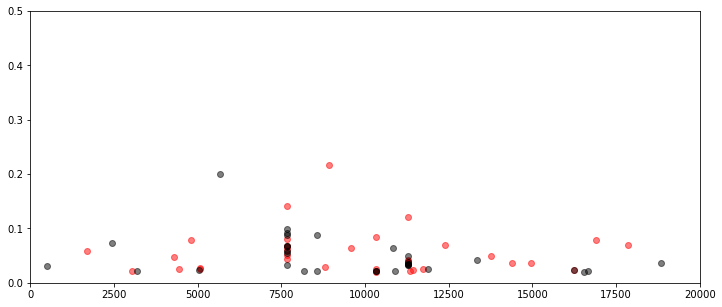

In [82]:
d3_df  = isnvs_set_final[isnvs_set_final['cohort']=='D007']

plt.figure(figsize=(12,5))

temp_syn = d3_df[(d3_df['eff_type']=='synonymous_variant')|(d3_df['eff_type']=='upstream_gene_variant')|(d3_df['eff_type']=='downstream_gene_variant')]
temp_nonsyn = d3_df[(d3_df['eff_type']=='missense_variant')|(d3_df['eff_type']=='stop_lost')|(d3_df['eff_type']=='stop_gained')]

plt.scatter(temp_nonsyn['POS'],temp_nonsyn['freq'],color='red',alpha=.5,label='nonsynonymous')
plt.scatter(temp_syn['POS'],temp_syn['freq'],color='black',alpha=.5,label='synonymous & noncoding')

plt.ylim(0,0.5)
plt.xlim(0,20000)

(0.0, 20000.0)

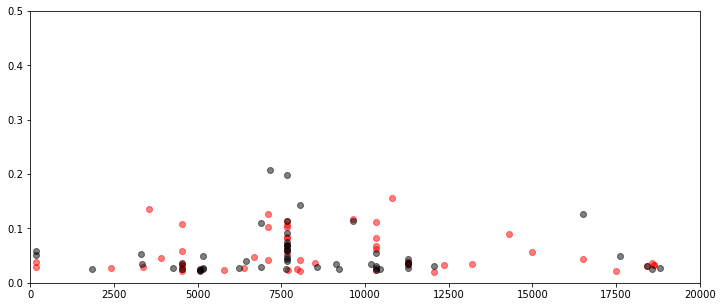

In [83]:
d3_df  = isnvs_set_final[isnvs_set_final['cohort']=='D008']

plt.figure(figsize=(12,5))

temp_syn = d3_df[(d3_df['eff_type']=='synonymous_variant')|(d3_df['eff_type']=='upstream_gene_variant')|(d3_df['eff_type']=='downstream_gene_variant')]
temp_nonsyn = d3_df[(d3_df['eff_type']=='missense_variant')|(d3_df['eff_type']=='stop_lost')|(d3_df['eff_type']=='stop_gained')]

plt.scatter(temp_nonsyn['POS'],temp_nonsyn['freq'],color='red',alpha=.5,label='nonsynonymous')
plt.scatter(temp_syn['POS'],temp_syn['freq'],color='black',alpha=.5,label='synonymous & noncoding')

plt.ylim(0,0.5)
plt.xlim(0,20000)

(0.0, 0.5)

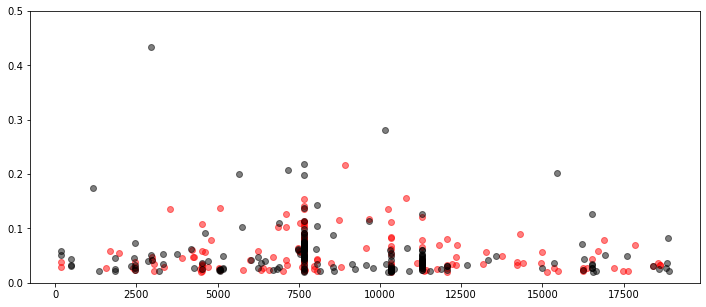

In [84]:

plt.figure(figsize=(12,5))

temp_syn = isnvs_set_final[(isnvs_set_final['eff_type']=='synonymous_variant')|(isnvs_set_final['eff_type']=='upstream_gene_variant')|(isnvs_set_final['eff_type']=='downstream_gene_variant')]
temp_nonsyn = isnvs_set_final[(isnvs_set_final['eff_type']=='missense_variant')|(isnvs_set_final['eff_type']=='stop_lost')|(isnvs_set_final['eff_type']=='stop_gained')]

plt.scatter(temp_nonsyn['POS'],temp_nonsyn['freq'],color='red',alpha=.5,label='nonsynonymous')
plt.scatter(temp_syn['POS'],temp_syn['freq'],color='black',alpha=.5,label='synonymous & noncoding')

plt.ylim(0,0.5)
#plt.xlim(10000,11500)


In [85]:
isnvs_set_final_nogp = isnvs_set_final[(isnvs_set_final['eff_gene']!='GP')&(isnvs_set_final['eff_gene']!='SsGP')&(isnvs_set_final['eff_gene']!='sGP')]


In [86]:
isnvs_set_final['tissue'].value_counts()

Lymph node       188
Spleen            46
Whole blood       38
Sex Organ         29
Spleen2           25
Kidney            21
Adrenal Gland      7
Skin               7
Liver              6
Lung               5
Name: tissue, dtype: int64

In [87]:
isnvs_set_final[isnvs_set_final['tissue']=='D003']['eff_gene'].value_counts()

Series([], Name: eff_gene, dtype: int64)

In [88]:
isnvs_set_final[isnvs_set_final['cohort']=='D004']['eff_gene'].value_counts()

GP      2
VP24    2
L       2
Name: eff_gene, dtype: int64

In [89]:
isnvs_set_final[isnvs_set_final['cohort']=='D005']['eff_gene'].value_counts()

L       11
GP       9
VP40     7
SsGP     6
VP24     3
VP30     2
NP       2
VP35     1
Name: eff_gene, dtype: int64

In [90]:
isnvs_set_final[isnvs_set_final['cohort']=='D006']['eff_gene'].value_counts()

L       40
GP      31
VP40    20
SsGP    17
NP      16
VP24    13
VP35    10
VP30     3
Name: eff_gene, dtype: int64

In [91]:
isnvs_set_final[isnvs_set_final['cohort']=='D007']['eff_gene'].value_counts()

L       39
VP40     8
GP       6
NP       6
VP24     3
VP30     3
VP35     2
SsGP     1
Name: eff_gene, dtype: int64

In [92]:
isnvs_set_final[isnvs_set_final['eff_gene']=='VP40']['tissue'].value_counts()


Lymph node       28
Sex Organ         4
Spleen2           4
Spleen            4
Adrenal Gland     3
Whole blood       3
Kidney            2
Skin              1
Name: tissue, dtype: int64

In [93]:
isnvs_set_final[(isnvs_set_final['eff_gene']=='VP30')|(isnvs_set_final['eff_gene']=='VP35')|(isnvs_set_final['eff_gene']=='NP')|(isnvs_set_final['eff_gene']=='L')]['tissue'].value_counts()



Lymph node       101
Whole blood       25
Spleen            23
Sex Organ         20
Spleen2           17
Kidney            11
Adrenal Gland      2
Skin               2
Liver              2
Lung               1
Name: tissue, dtype: int64

In [94]:
isnvs_set_final[(isnvs_set_final['eff_gene']=='GP')|(isnvs_set_final['eff_gene']=='SsGP')|(isnvs_set_final['eff_gene']=='sGP')]['tissue'].value_counts()


Lymph node       49
Spleen           13
Kidney            8
Whole blood       7
Liver             4
Skin              4
Sex Organ         3
Spleen2           3
Lung              2
Adrenal Gland     2
Name: tissue, dtype: int64

In [95]:
isnvs_set_final[isnvs_set_final['eff_gene']=='VP24']['tissue'].value_counts()


Lymph node     10
Spleen          6
Whole blood     3
Sex Organ       2
Lung            2
Spleen2         1
Name: tissue, dtype: int64

In [96]:
isnvs_set_final[isnvs_set_final['cohort']=='D008']['eff_gene'].value_counts()

L       45
VP40    14
GP      12
NP      12
VP35     7
SsGP     7
sGP      4
VP30     3
VP24     3
Name: eff_gene, dtype: int64

In [97]:
isnvs_set_final[(isnvs_set_final['cohort']=='D008')&(isnvs_set_final['eff_gene']=='VP40')]

description   A_ID  animal cohort       tissue    POS  \
569            Spleen2_RA1779_D008  A0071  RA1779   D008      Spleen2   4531   
612            Spleen2_RA1779_D008  A0071  RA1779   D008      Spleen2  11282   
705       Lymph node 1_RA1779_D008  A0078  RA1779   D008   Lymph node   7668   
714       Lymph node 3_RA1779_D008  A0080  RA1779   D008   Lymph node    169   
733       Lymph node 3_RA1779_D008  A0080  RA1779   D008   Lymph node   8050   
746       Lymph node 3_RA1779_D008  A0080  RA1779   D008   Lymph node  18411   
1804      Lymph node 2_RA1423_D008  A0205  RA1423   D008   Lymph node   9651   
1805      Lymph node 2_RA1423_D008  A0205  RA1423   D008   Lymph node   9654   
1855      Lymph node 3_RA1423_D008  A0206  RA1423   D008   Lymph node   7668   
1863      Lymph node 3_RA1423_D008  A0206  RA1423   D008   Lymph node   9238   
1869      Lymph node 3_RA1423_D008  A0206  RA1423   D008   Lymph node  10443   
1871      Lymph node 3_RA1423_D008  A0206  RA1423   D008   Lymph node  11282   
1891      Lymph node 3_RA1423_D008  A0206  RA1423   D008   Lymph node  18562   
2345  Whole blood_D008_RA1779_D008  A0312  RA1779   D008  Whole blood  18411   

        depth  variant_reads      freq alleles            eff_type eff_gene  \
569    2765.0           88.0  0.031826      AC    missense_variant     VP40   
612    1933.0           75.0  0.038800      AC    missense_variant     VP40   
705     587.0           35.0  0.059625      TC  synonymous_variant     VP40   
714     268.0            8.0  0.029851      AG    missense_variant     VP40   
733     650.0           27.0  0.041538      AC    missense_variant     VP40   
746     414.0           13.0  0.031401      AG  synonymous_variant     VP40   
1804   1146.0          130.0  0.113438      TC  synonymous_variant     VP40   
1805   1122.0          132.0  0.117647      TC    missense_variant     VP40   
1855  18279.0         1529.0  0.083648      TC    missense_variant     VP40   
1863  11531.0          297.0  0.025757      AG  synonymous_variant     VP40   
1869   9563.0          235.0  0.024574      AG  synonymous_variant     VP40   
1871  10439.0          342.0  0.032762      AC    missense_variant     VP40   
1891   5756.0          214.0  0.037179      GT    missense_variant     VP40   
2345    191.0            6.0  0.031414      AG    missense_variant     VP40   

           eff_protein       aa_mut  
569   DF49_53415gpVP40  p.Thr242Ala  
612   DF49_53415gpVP40   p.Asn49Lys  
705   DF49_53415gpVP40   p.Val79Val  
714   DF49_53415gpVP40   p.Tyr18Ser  
733   DF49_53415gpVP40  p.Asn200Ser  
746   DF49_53415gpVP40  p.Phe125Phe  
1804  DF49_53415gpVP40   p.Val79Val  
1805  DF49_53415gpVP40   p.Asn80Asp  
1855  DF49_53415gpVP40  p.Asn200Ser  
1863  DF49_53415gpVP40  p.Leu289Leu  
1869  DF49_53415gpVP40   p.Gly35Gly  
1871  DF49_53415gpVP40  p.Asn200Ser  
1891  DF49_53415gpVP40  p.Asn200Ser  
2345  DF49_53415gpVP40  p.Asn200Ser

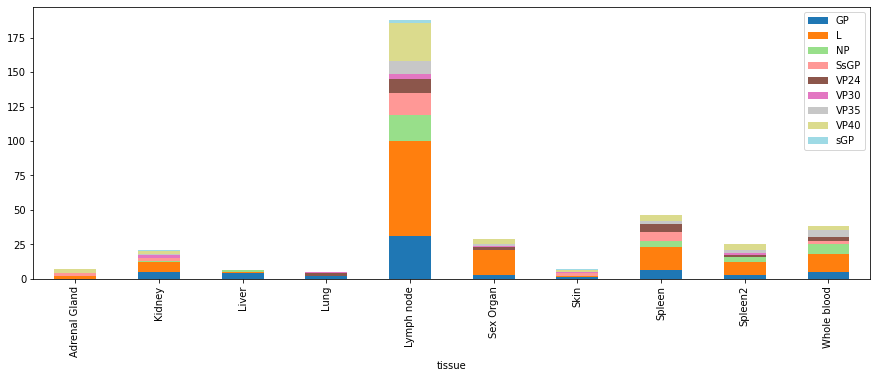

In [98]:
isnvs_set_final.groupby(['tissue','eff_gene']).size().unstack().plot(kind='bar',stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))


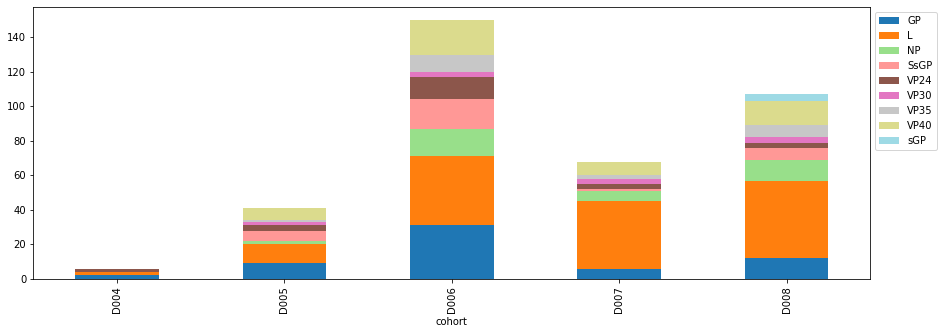

In [99]:
isnvs_set_final.groupby(['cohort','eff_gene']).size().unstack().plot(kind='bar',stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))


In [100]:
for coh in list(set(isnvs_set_final['cohort'])):
    print(coh)
    print(isnvs_set_final[isnvs_set_final['cohort']==coh]['eff_gene'].value_counts())
    

D005
L       11
GP       9
VP40     7
SsGP     6
VP24     3
VP30     2
NP       2
VP35     1
Name: eff_gene, dtype: int64
D007
L       39
VP40     8
GP       6
NP       6
VP24     3
VP30     3
VP35     2
SsGP     1
Name: eff_gene, dtype: int64
D006
L       40
GP      31
VP40    20
SsGP    17
NP      16
VP24    13
VP35    10
VP30     3
Name: eff_gene, dtype: int64
D008
L       45
VP40    14
GP      12
NP      12
VP35     7
SsGP     7
sGP      4
VP30     3
VP24     3
Name: eff_gene, dtype: int64
D004
GP      2
VP24    2
L       2
Name: eff_gene, dtype: int64


In [101]:
nonsyn_tot = []
tots = []
cohs = []
tis = []
hfs = []

for samp in list(set(isnvs_set_final['A_ID'])):
    df_temp = isnvs_set_final[isnvs_set_final['A_ID'] == samp]
    print(df_temp['cohort'].iloc[0])
    print(df_temp['tissue'].iloc[0])
    tot = len(df_temp)
    print(tot)
    hf = len(df_temp[(df_temp['freq']>0.1)&(df_temp['freq']<0.9)])
    nonsyn = len(df_temp[df_temp['eff_type']=='missense_variant'])
    nonsyn_tot.append(nonsyn/tot)
    tots.append(tot)
    cohs.append(df_temp['cohort'].iloc[0])
    tis.append(df_temp['tissue'].iloc[0])
    hfs.append(hf)


IndexError: single positional indexer is out-of-bounds

In [102]:
df_test = pd.DataFrame(tots)
df_test['nonsyn'] = nonsyn_tot
df_test['tissues'] = tis
df_test['cohort'] = cohs
df_test['hf'] = hfs


In [103]:
df_test

Empty DataFrame
Columns: [nonsyn, tissues, cohort, hf]
Index: []

In [104]:
isnvs_set_final[(isnvs_set_final['freq']>0.1)&(isnvs_set_final['freq']<0.9)]

description   A_ID  animal cohort         tissue  \
61        Lymph node 2_RA1803_D006  A0009  RA1803   D006     Lymph node   
67        Lymph node 3_RA1803_D006  A0010  RA1803   D006     Lymph node   
73        Lymph node 3_RA1803_D006  A0010  RA1803   D006     Lymph node   
76        Lymph node 3_RA1803_D006  A0010  RA1803   D006     Lymph node   
77           Sex Organ_RA1803_D006  A0012  RA1803   D006      Sex Organ   
457       Lymph node 1_RA0700_D007  A0050  RA0700   D007     Lymph node   
459       Lymph node 1_RA0700_D007  A0050  RA0700   D007     Lymph node   
536             Spleen_RA1779_D008  A0071  RA1779   D008         Spleen   
678      Adrenal Gland_RA1779_D008  A0074  RA1779   D008  Adrenal Gland   
681          Sex Organ_RA1779_D008  A0077  RA1779   D008      Sex Organ   
701       Lymph node 1_RA1779_D008  A0078  RA1779   D008     Lymph node   
708       Lymph node 1_RA1779_D008  A0078  RA1779   D008     Lymph node   
711       Lymph node 2_RA1779_D008  A0079  RA1779   D008     Lymph node   
712       Lymph node 2_RA1779_D008  A0079  RA1779   D008     Lymph node   
749               Skin_RA1779_D008  A0083  RA1779   D008           Skin   
750               Skin_RA1779_D008  A0083  RA1779   D008           Skin   
753               Skin_RA1779_D008  A0083  RA1779   D008           Skin   
768             Spleen_RA0522_D005  A0113  RA0522   D005         Spleen   
1011      Lymph node 1_RA1790_D007  A0148  RA1790   D007     Lymph node   
1034      Lymph node 2_RA1790_D007  A0149  RA1790   D007     Lymph node   
1148      Lymph node 2_RA1818_D006  A0163  RA1818   D006     Lymph node   
1177      Lymph node 3_RA1818_D006  A0164  RA1818   D006     Lymph node   
1373      Lymph node 1_RA0917_D006  A0190  RA0917   D006     Lymph node   
1443      Lymph node 2_RA0917_D006  A0191  RA0917   D006     Lymph node   
1781      Lymph node 1_RA1423_D008  A0204  RA1423   D008     Lymph node   
1787      Lymph node 1_RA1423_D008  A0204  RA1423   D008     Lymph node   
1797      Lymph node 2_RA1423_D008  A0205  RA1423   D008     Lymph node   
1804      Lymph node 2_RA1423_D008  A0205  RA1423   D008     Lymph node   
1805      Lymph node 2_RA1423_D008  A0205  RA1423   D008     Lymph node   
1847      Lymph node 3_RA1423_D008  A0206  RA1423   D008     Lymph node   
1966      Lymph node 2_RA1639_D005  A0219  RA1639   D005     Lymph node   
1967      Lymph node 2_RA1639_D005  A0219  RA1639   D005     Lymph node   
1973      Lymph node 3_RA1639_D005  A0220  RA1639   D005     Lymph node   
1994      Lymph node 1_RA1325_D006  A0232  RA1325   D006     Lymph node   
1997      Lymph node 1_RA1325_D006  A0232  RA1325   D006     Lymph node   
2001      Lymph node 1_RA1325_D006  A0232  RA1325   D006     Lymph node   
2150         Sex Organ_RA1074_D006    NaN  RA1074   D006      Sex Organ   
2167      Lymph node 2_RA1074_D006    NaN  RA1074   D006     Lymph node   
2338  Whole blood_D008_RA1779_D008  A0312  RA1779   D008    Whole blood   

        POS    depth  variant_reads      freq alleles  \
61     8072    200.0           21.0  0.105000      TC   
67     5077    414.0           57.0  0.137681      AG   
73     8726    104.0           12.0  0.115385      CT   
76    11282    159.0           20.0  0.125786      AC   
77     2946    217.0           94.0  0.433180      AC   
457    8931    285.0           62.0  0.217544      AG   
459   11282    416.0           50.0  0.120192      AC   
536    7668   2647.0          281.0  0.106158      TC   
678    7668    457.0           52.0  0.113786      TC   
681    3551   1074.0          146.0  0.135940      AG   
701    6890    831.0           91.0  0.109507      AT   
708   10343    241.0           27.0  0.112033      CA   
711    4531    149.0           16.0  0.107383      AC   
712    7668    106.0           21.0  0.198113      TC   
749    7161    893.0          186.0  0.208287      CT   
750    7668    156.0           16.0  0.102564      TC   
753   10794    102.0           16.0  0.156863      GA

In [105]:
df_test[[0,'tissues']].boxplot(by='tissues',grid=False, rot=90, fontsize=10)


KeyError: '[0] not in index'

ValueError: not enough values to unpack (expected 2, got 0)

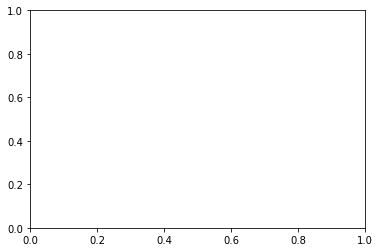

In [106]:
df_test[['nonsyn','tissues']].boxplot(by='tissues',grid=False, rot=90, fontsize=10)


In [107]:
df_test[[0,'cohort']].boxplot(by='cohort',grid=False, rot=90, fontsize=10)


KeyError: '[0] not in index'

ValueError: not enough values to unpack (expected 2, got 0)

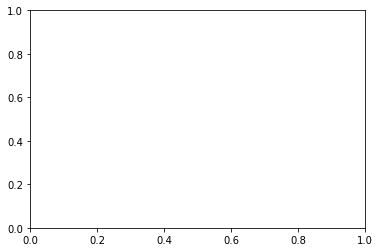

In [108]:
df_test[['nonsyn','cohort']].boxplot(by='cohort',grid=False, rot=90, fontsize=10)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


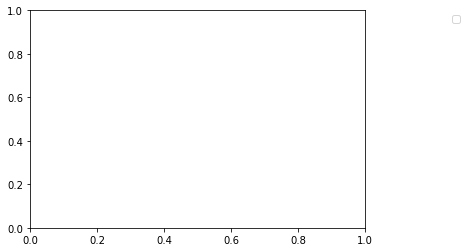

In [109]:
for tis in list(set(df_test['tissues'])):
    print(tis)
    df_temp = df_test[df_test['tissues']==tis]
    plt.scatter(df_temp[0],df_temp['hf'],label=tis,alpha=0.5)
plt.legend(bbox_to_anchor=(1.3,1))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


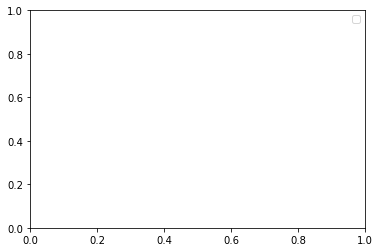

In [110]:
for coh in list(set(df_test['cohort'])):
    print(coh)
    df_temp = df_test[df_test['cohort']==coh]
    plt.scatter(df_temp[0],df_temp['hf'],label=coh,alpha=0.5)
plt.legend()


In [111]:
for coh in list(set(isnvs_set_final['tissue'])):
    print(coh)
    df_temp = isnvs_set_final[isnvs_set_final['tissue']==coh]
    for samp in list(set(df_temp['A_ID'])):
        print(samp)
        df_temp2 = df_temp[df_temp['A_ID']==samp]
        var = len(df_temp2)
        var_nonsyn = len(df_temp2[df_temp2['eff_type']=='missense_variant'])
        print(var)
        print(var_nonsyn)
        


Lymph node
nan
0
0
A0232
6
4
A0050
4
3
A0149
7
1
A0220
7
4
A0009
9
4
A0136
2
1
A0148
12
10
A0163
15
5
A0190
6
4
A0052
7
3
A0080
12
6
A0219
3
1
A0010
4
2
A0164
7
3
A0162
3
2
A0204
5
0
A0233
3
2
A0135
4
2
A0008
3
0
A0205
8
3
A0051
7
3
A0078
6
1
A0150
5
1
A0079
2
1
A0191
6
1
A0192
5
2
A0206
13
6
A0234
6
3
Skin
A0083
3
1
A0154
1
1
A0084
1
0
A0168
2
1
Adrenal Gland
nan
0
0
A0074
2
2
Liver
nan
0
0
A0213
1
0
A0003
1
0
A0199
1
1
A0157
1
0
Spleen2
nan
0
0
A0043
2
0
A0141
3
0
A0183
2
1
A0113
4
1
A0197
6
1
A0071
5
3
Spleen
nan
0
0
A0029
5
1
A0169
1
0
A0043
2
2
A0225
3
3
A0211
5
2
A0141
3
2
A0127
5
3
A0183
2
0
A0071
5
3
A0197
5
2
A0001
3
0
A0113
4
1
Sex Organ
nan
0
0
A0077
7
6
A0012
5
1
A0161
3
1
A0147
6
4
Lung
A0207
5
1
Whole blood
A0315
3
1
A0306
3
1
A0348
5
3
A0321
5
0
A0365
3
1
A0312
7
3
A0370
3
0
A0309
4
1
A0375
3
0
A0318
2
0
Kidney
nan
0
0
A0226
1
0
A0184
1
1
A0212
1
1
A0156
1
0
A0142
1
0
A0044
2
1
A0198
7
5
A0072
2
2


In [112]:
for coh in list(set(isnvs_set_final['cohort'])):
    print(coh)
    df_temp = isnvs_set_final[isnvs_set_final['cohort']==coh]
    for samp in list(set(df_temp['animal'])):
        print(samp)
        df_temp2 = df_temp[df_temp['animal']==samp]
        var = len(df_temp2)
        var_nonsyn = len(df_temp2[df_temp2['eff_type']=='missense_variant'])
        print(var)
        print(var_nonsyn)
        


D005
RA0522
8
2
RA1639
22
11
RA0452
11
6
D007
RA1790
41
20
RA0700
27
13
D006
RA1325
22
12
RA1818
36
13
RA1803
28
7
RA1074
40
19
RA0917
24
9
D008
RA1779
52
28
RA1423
55
19
D004
RA1849
1
0
RA0717
5
1


In [113]:
for coh in list(set(isnvs_set_final['cohort'])):
    print(coh)
    df_temp = isnvs_set_final[isnvs_set_final['cohort']==coh]
    for samp in list(set(df_temp['A_ID'])):
        print(samp)
        df_temp2 = df_temp[df_temp['A_ID']==samp]
        var = len(df_temp2)
        var_nonsyn = len(df_temp2[df_temp2['eff_type']=='missense_variant'])
        print(var)
        print(var_nonsyn)
        


D005
A0213
1
0
A0211
5
2
A0348
5
3
A0127
5
3
A0135
4
2
A0220
7
4
A0136
2
1
A0113
8
2
A0212
1
1
A0219
3
1
D007
A0051
7
3
A0315
3
1
A0050
4
3
A0043
4
2
A0306
3
1
A0141
6
2
A0149
7
1
A0147
6
4
A0150
5
1
A0142
1
0
A0044
2
1
A0148
12
10
A0154
1
1
A0052
7
3
D006
nan
0
0
A0232
6
4
A0225
3
3
A0012
5
1
A0161
3
1
A0168
2
1
A0009
9
4
A0157
1
0
A0163
15
5
A0190
6
4
A0375
3
0
A0010
4
2
A0164
7
3
A0162
3
2
A0226
1
0
A0233
3
2
A0156
1
0
A0008
3
0
A0318
2
0
A0183
4
1
A0184
1
1
A0365
3
1
A0001
3
0
A0191
6
1
A0192
5
2
A0003
1
0
A0234
6
3
A0370
3
0
A0309
4
1
D008
A0205
8
3
A0080
12
6
A0199
1
1
A0204
5
0
A0206
13
6
A0077
7
6
A0207
5
1
A0084
1
0
A0321
5
0
A0078
6
1
A0074
2
2
A0197
11
3
A0083
3
1
A0198
7
5
A0312
7
3
A0071
10
6
A0072
2
2
A0079
2
1
D004
A0029
5
1
A0169
1
0


In [114]:
len(isnvs_set_final_nogp[isnvs_set_final_nogp['cohort']=='D003'])


0

In [115]:
len(isnvs_set_final_nogp[(isnvs_set_final_nogp['cohort']=='D003')&(isnvs_set_final_nogp['eff_type']=='missense_variant')])
    

0

In [116]:
len(isnvs_set_final_nogp[isnvs_set_final_nogp['cohort']=='D004'])


4

In [117]:
len(isnvs_set_final_nogp[(isnvs_set_final_nogp['cohort']=='D004')&(isnvs_set_final_nogp['eff_type']=='missense_variant')])


0

In [118]:
len(isnvs_set_final_nogp[isnvs_set_final_nogp['cohort']=='D005'])


26

In [119]:
len(isnvs_set_final_nogp[(isnvs_set_final_nogp['cohort']=='D005')&(isnvs_set_final_nogp['eff_type']=='missense_variant')])


9

In [120]:
len(isnvs_set_final_nogp[isnvs_set_final_nogp['cohort']=='D006'])


102

In [121]:
len(isnvs_set_final_nogp[(isnvs_set_final_nogp['cohort']=='D006')&(isnvs_set_final_nogp['eff_type']=='missense_variant')])



37

In [122]:
len(isnvs_set_final_nogp[isnvs_set_final_nogp['cohort']=='D007'])


61

In [123]:
len(isnvs_set_final_nogp[(isnvs_set_final_nogp['cohort']=='D007')&(isnvs_set_final_nogp['eff_type']=='missense_variant')])


29

In [124]:
len(isnvs_set_final_nogp[isnvs_set_final_nogp['cohort']=='D008'])


84

In [125]:
len(isnvs_set_final_nogp[(isnvs_set_final_nogp['cohort']=='D008')&(isnvs_set_final_nogp['eff_type']=='missense_variant')])


37

In [126]:
isnvs_set_final_nogp[(isnvs_set_final_nogp['cohort']=='D008')&(isnvs_set_final_nogp['eff_type']=='missense_variant')]['eff_gene'].value_counts()


L       22
VP40     9
NP       4
VP35     1
VP24     1
Name: eff_gene, dtype: int64

(0.0, 0.25)

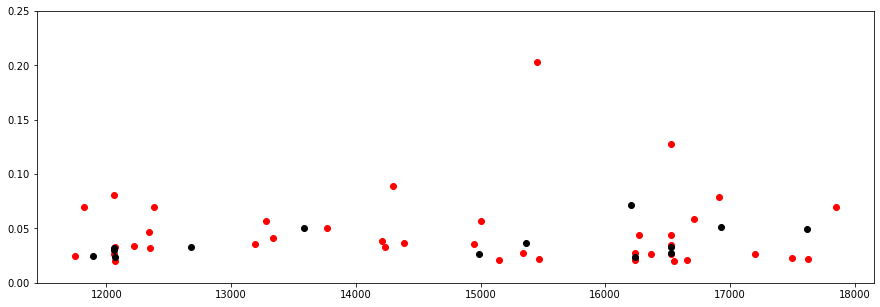

In [127]:

plt.figure(figsize=(15,5))

temp_syn = isnvs_set_final[(isnvs_set_final['POS']>11581)&(isnvs_set_final['POS']<18219)&(isnvs_set_final['eff_type']=='synonymous_variant')]
temp_nonsyn = isnvs_set_final[(isnvs_set_final['POS']>11581)&(isnvs_set_final['POS']<18219)&(isnvs_set_final['eff_type']!='synonymous_variant')]

plt.scatter(temp_nonsyn['POS'],temp_nonsyn['freq'],color='red')
plt.scatter(temp_syn['POS'],temp_syn['freq'],color='black')

plt.ylim(0,0.25)
#plt.xlim(11500,12500)


(0.0, 0.25)

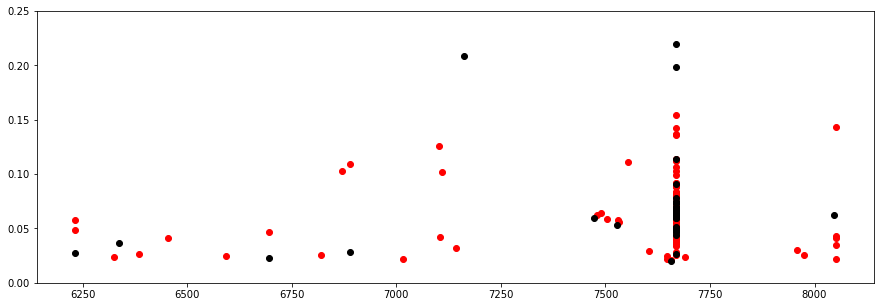

In [128]:
plt.figure(figsize=(15,5))

temp_syn = isnvs_set_final[(isnvs_set_final['POS']>6039)&(isnvs_set_final['POS']<8069)&(isnvs_set_final['eff_type']=='synonymous_variant')]
temp_nonsyn = isnvs_set_final[(isnvs_set_final['POS']>6039)&(isnvs_set_final['POS']<8069)&(isnvs_set_final['eff_type']!='synonymous_variant')]

plt.scatter(temp_nonsyn['POS'],temp_nonsyn['freq'],color='red')
plt.scatter(temp_syn['POS'],temp_syn['freq'],color='black')

plt.ylim(0,0.25)
#plt.xlim(11500,12500)

In [129]:
temp = isnvs_set_final[(isnvs_set_final['POS']>9885)&(isnvs_set_final['POS']<11496)]

In [130]:
plt.figure(figsize=(15,5))

for animal,clr in zip(list(set(temp['animal'])),range(len(cmap_temp))):
    plt.scatter(temp[temp['animal']==animal]['POS'],temp[temp['animal']==animal]['freq'],label=animal,color=cmap_temp[clr])
plt.legend(bbox_to_anchor=(1,1))


NameError: name 'cmap_temp' is not defined

<Figure size 1080x360 with 0 Axes>

In [131]:
plt.figure(figsize=(15,5))

cohorts = ['D003','D004','D005','D006','D007','D008']

for coh,clr in zip(cohorts,range(len(cmap_temp))):
    plt.scatter(temp[temp['cohort']==coh]['POS'],temp[temp['cohort']==coh]['freq'],label=coh,color=cmap_temp[clr],alpha=0.7)
plt.legend(bbox_to_anchor=(1,1))


NameError: name 'cmap_temp' is not defined

<Figure size 1080x360 with 0 Axes>

In [132]:
plt.figure(figsize=(15,5))
temp = temp[(temp['tissue']!='Spleen2')&(temp['tissue']!='Spleen')] 

for tissue,clr in zip(list(set(temp['tissue'])),range(len(cmap_temp))):
    plt.scatter(temp[temp['tissue']==tissue]['POS'],temp[temp['tissue']==tissue]['freq'],label=tissue,color=cmap_temp[clr])
plt.legend(bbox_to_anchor=(1,1))


NameError: name 'cmap_temp' is not defined

<Figure size 1080x360 with 0 Axes>

In [133]:
isnvs_set_final[isnvs_set_final['POS']==10343]

description   A_ID  animal cohort       tissue    POS  \
20              Spleen_RA1803_D006  A0001  RA1803   D006       Spleen  10343   
113             Spleen_RA0717_D004  A0029  RA0717   D004       Spleen  10343   
482       Lymph node 2_RA0700_D007  A0051  RA0700   D007   Lymph node  10343   
540             Spleen_RA1779_D008  A0071  RA1779   D008       Spleen  10343   
608            Spleen2_RA1779_D008  A0071  RA1779   D008      Spleen2  10343   
708       Lymph node 1_RA1779_D008  A0078  RA1779   D008   Lymph node  10343   
736       Lymph node 3_RA1779_D008  A0080  RA1779   D008   Lymph node  10343   
824             Spleen_RA0452_D005  A0127  RA0452   D005       Spleen  10343   
860             Spleen_RA1790_D007  A0141  RA1790   D007       Spleen  10343   
920            Spleen2_RA1790_D007  A0141  RA1790   D007      Spleen2  10343   
1015      Lymph node 1_RA1790_D007  A0148  RA1790   D007   Lymph node  10343   
1125      Lymph node 1_RA1818_D006  A0162  RA1818   D006   Lymph node  10343   
1153      Lymph node 2_RA1818_D006  A0163  RA1818   D006   Lymph node  10343   
1212              Skin_RA1818_D006  A0168  RA1818   D006         Skin  10343   
1451      Lymph node 2_RA0917_D006  A0191  RA0917   D006   Lymph node  10343   
1564            Spleen_RA1423_D008  A0197  RA1423   D008       Spleen  10343   
1634           Spleen2_RA1423_D008  A0197  RA1423   D008      Spleen2  10343   
1783      Lymph node 1_RA1423_D008  A0204  RA1423   D008   Lymph node  10343   
1939            Spleen_RA1639_D005  A0211  RA1639   D005       Spleen  10343   
1974      Lymph node 3_RA1639_D005  A0220  RA1639   D005   Lymph node  10343   
2103            Kidney_RA1074_D006    NaN  RA1074   D006       Kidney  10343   
2245  Whole blood_D007_RA0700_D007  A0306  RA0700   D007  Whole blood  10343   
2310  Whole blood_D006_RA1818_D006  A0309  RA1818   D006  Whole blood  10343   
2341  Whole blood_D008_RA1779_D008  A0312  RA1779   D008  Whole blood  10343   
2366  Whole blood_D007_RA1790_D007  A0315  RA1790   D007  Whole blood  10343   
2418  Whole blood_D008_RA1423_D008  A0321  RA1423   D008  Whole blood  10343   
2456  Whole blood_D005_RA1639_D005  A0348  RA1639   D005  Whole blood  10343   
2560  Whole blood_D006_RA1803_D006  A0375  RA1803   D006  Whole blood  10343   

       depth  variant_reads      freq alleles                 eff_type  \
20     646.0           19.0  0.029412      CA    upstream_gene_variant   
113    728.0           16.0  0.021978      CA    upstream_gene_variant   
482    998.0           26.0  0.026052      CA         missense_variant   
540   1505.0          101.0  0.067110      CA         missense_variant   
608   1265.0           69.0  0.054545      CA    upstream_gene_variant   
708    241.0           27.0  0.112033      CA                stop_lost   
736    765.0           63.0  0.082353      CA         missense_variant   
824    297.0            8.0  0.026936      CA         missense_variant   
860   1434.0           32.0  0.022315      CA         missense_variant   
920   1347.0           29.0  0.021529      CA    upstream_gene_variant   
1015   296.0           25.0  0.084459      CA         missense_variant   
1125   328.0           16.0  0.048780      CA       synonymous_variant   
1153   354.0           15.0  0.042373      CA       synonymous_variant   
1212   248.0           13.0  0.052419      CA         missense_variant   
1451  2431.0           49.0  0.020156      CA       synonymous_variant   
1564  2020.0           48.0  0.023762      CA         missense_variant   
1634  2324.0           54.0  0.023236      CA       synonymous_variant   
1783   378.0           12.0  0.031746      CA  downstream_gene_variant   
1939  1553.0           37.0  0.023825      CA         missense_variant   
1974   164.0            6.0  0.036585      CA         missense_variant   
2103   358.0            9.0  0.025140      CA       synonymous_variant   
2245  3515.0           76.0  0.021622      CA    upstream_gene_variant   


In [134]:
isnvs_set_final[(isnvs_set_final['POS']>7100)&(isnvs_set_final['POS']<7300)&(isnvs_set_final['tissue']=='Sex Organ')]

description   A_ID  animal cohort     tissue   POS  depth  \
688  Sex Organ_RA1779_D008  A0077  RA1779   D008  Sex Organ  7104  926.0   

     variant_reads      freq alleles          eff_type eff_gene  \
688           39.0  0.042117      AG  missense_variant        L   

       eff_protein        aa_mut  
688  DF49_53415gpL  p.Asn1649Thr

In [135]:
isnvs_set_final[(isnvs_set_final['POS']>11581)&(isnvs_set_final['POS']<18219)]['POS'].value_counts()[:30]

16526    6
12064    4
16239    4
12066    3
13581    1
14298    1
12341    1
14235    1
11820    1
16712    1
15468    1
16368    1
13188    1
17496    1
17625    1
15001    1
17621    1
15453    1
15366    1
16268    1
16929    1
17202    1
12221    1
14211    1
14988    1
16551    1
13279    1
12678    1
15344    1
16909    1
Name: POS, dtype: int64

In [136]:
isnvs_set_final[isnvs_set_final['POS']==14719]

Empty DataFrame
Columns: [description, A_ID, animal, cohort, tissue, POS, depth, variant_reads, freq, alleles, eff_type, eff_gene, eff_protein, aa_mut]
Index: []

In [137]:
isnvs_set_final[(isnvs_set_final['POS']>14500)&(isnvs_set_final['POS']<15000)&(isnvs_set_final['tissue']!='Spleen2')]

description   A_ID  animal cohort      tissue    POS  \
1003     Sex Organ_RA1790_D007  A0147  RA1790   D007   Sex Organ  14944   
1158  Lymph node 2_RA1818_D006  A0163  RA1818   D006  Lymph node  14988   

      depth  variant_reads      freq alleles            eff_type eff_gene  \
1003  224.0            8.0  0.035714      TC    missense_variant        L   
1158  412.0           11.0  0.026699      TC  synonymous_variant        L   

        eff_protein        aa_mut  
1003  DF49_53415gpL   p.Lys955Asn  
1158  DF49_53415gpL  p.Tyr1815Tyr

(17500.0, 18500.0)

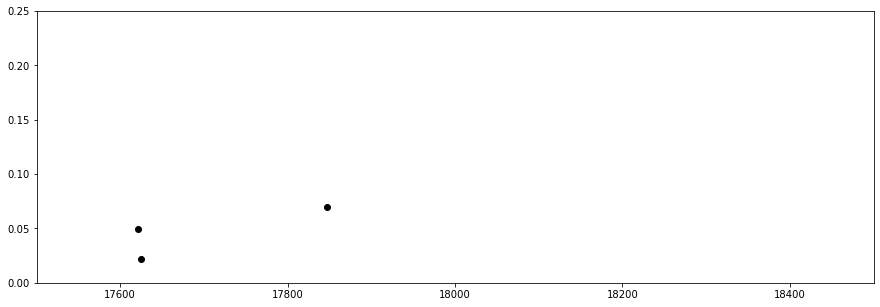

In [138]:

plt.figure(figsize=(15,5))

temp = isnvs_set_final[(isnvs_set_final['POS']>11581)&(isnvs_set_final['POS']<18219)]

plt.scatter(temp['POS'],temp['freq'],color='black')
plt.ylim(0,0.25)
plt.xlim(17500,18500)


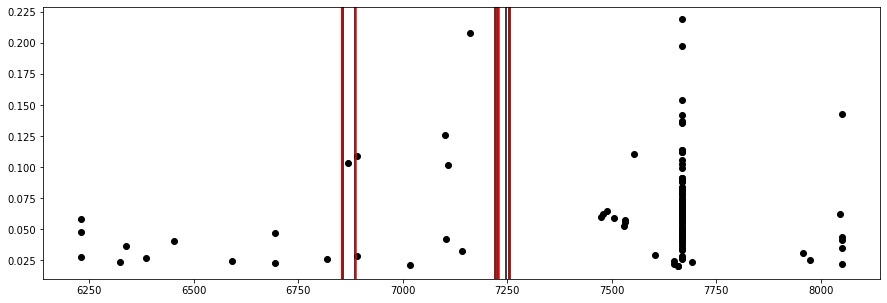

In [139]:
plt.figure(figsize=(15,5))

gp_only = isnvs_set_final[(isnvs_set_final['POS']>6039)&(isnvs_set_final['POS']<8068)]

plt.scatter(gp_only['POS'],gp_only['freq'],color='black')

plt.axvline(x=6854,color='black')
plt.axvline(x=6857,color='black')
plt.axvline(x=6885,color='black')

plt.axvline(x=7221,color='black')
plt.axvline(x=7222,color='black')
plt.axvline(x=7228,color='black')
plt.axvline(x=7247,color='black')
plt.axvline(x=7255,color='black')
plt.axvline(x=7256,color='black')

plt.axvline(x=6855,color='red')
plt.axvline(x=6888,color='red')
plt.axvline(x=7224,color='red')
plt.axvline(x=7230,color='red')
plt.axvline(x=7257,color='red')

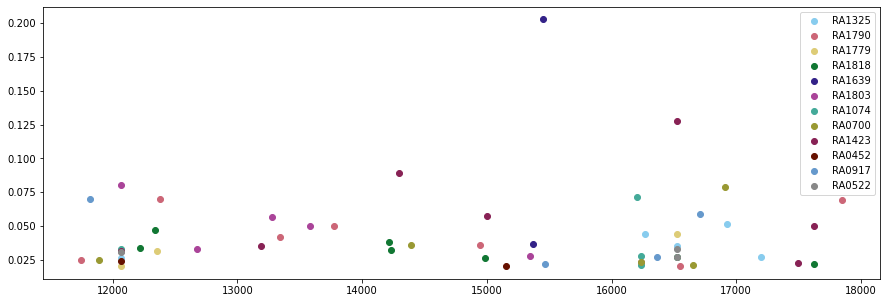

In [140]:
cmap_temp = ['#88CCEE','#CC6677','#DDCC77','#117733','#332288','#AA4499','#44AA99','#999933','#882255','#661100','#6699CC','#888888']

plt.figure(figsize=(15,5))

isnvs_set_final['POS'] = isnvs_set_final['POS'].astype(float)

gp_only = isnvs_set_final[(isnvs_set_final['POS']>11581)&(isnvs_set_final['POS']<18219)]

for animal,clr in zip(list(set(gp_only['animal'])),range(len(cmap_temp))):
    plt.scatter(gp_only[gp_only['animal']==animal]['POS'],gp_only[gp_only['animal']==animal]['freq'],label=animal,color=cmap_temp[clr])
plt.legend(bbox_to_anchor=(1,1))

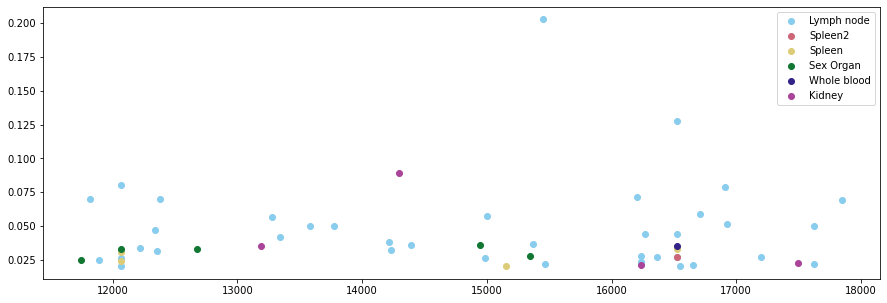

In [141]:
plt.figure(figsize=(15,5))

for tissue,clr in zip(list(set(gp_only['tissue'])),range(len(cmap_temp))):
    plt.scatter(gp_only[gp_only['tissue']==tissue]['POS'],gp_only[gp_only['tissue']==tissue]['freq'],label=tissue,color=cmap_temp[clr])
plt.legend(bbox_to_anchor=(1,1))

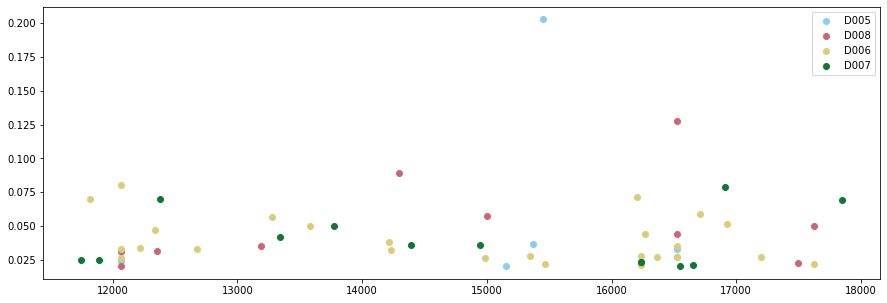

In [142]:
plt.figure(figsize=(15,5))

for coh,clr in zip(list(set(gp_only['cohort'])),range(len(cmap_temp))):
    plt.scatter(gp_only[gp_only['cohort']==coh]['POS'],gp_only[gp_only['cohort']==coh]['freq'],label=coh,color=cmap_temp[clr])
plt.legend()

In [143]:
isnvs_set_final[isnvs_set_final['POS']==7668]['eff_type'].value_counts()

missense_variant           32
synonymous_variant         28
stop_lost                   9
upstream_gene_variant       9
downstream_gene_variant     5
Name: eff_type, dtype: int64

In [144]:
isnvs_set_final[isnvs_set_final['eff_type']=='stop_lost']['POS'].value_counts()

7668.0     9
11282.0    2
10343.0    1
4531.0     1
10794.0    1
4205.0     1
14211.0    1
12341.0    1
4477.0     1
7691.0     1
1561.0     1
Name: POS, dtype: int64

In [145]:
isnvs_set_final = isnvs_set_final[isnvs_set_final['tissue']!='PBMC']

Text(0, 0.5, 'number of variants')

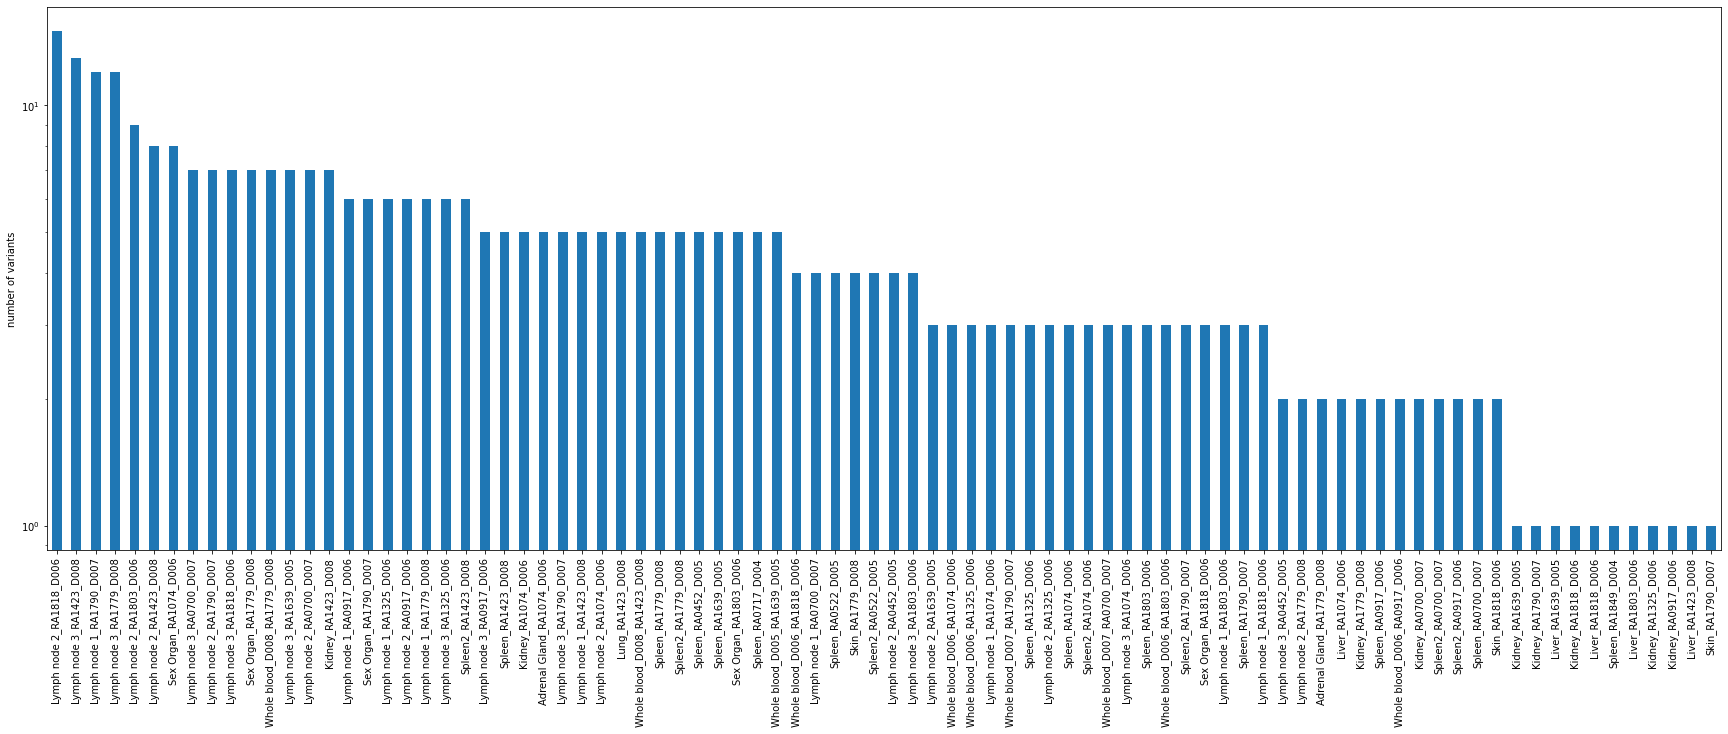

In [146]:
# see if this filtering changes things much -- not really 

pd.DataFrame(isnvs_set_final['description'].value_counts()).plot.bar(figsize=(30, 10),legend=False)
plt.yscale('log')
plt.ylabel('number of variants')

In [147]:
temp = isnvs_set_final[isnvs_set_final['depth']>1000]
temp['A_ID'].value_counts()

A0206    13
A0197    11
A0205     8
A0071     8
A0164     7
A0149     6
A0190     6
A0234     6
A0191     6
A0141     6
A0080     6
A0051     5
A0192     5
A0183     4
A0029     4
A0043     4
A0198     4
A0211     4
A0315     3
A0306     3
A0348     3
A0365     3
A0309     3
A0375     3
A0204     2
A0163     2
A0318     2
A0321     2
A0077     2
A0001     2
A0168     1
A0162     1
A0150     1
A0044     1
Name: A_ID, dtype: int64

## exporting table

In [148]:
#download file to workspace
concat_isnvs.to_csv(r'gs://fc-0abda69f-0aed-4d4c-8f5b-482e69f4b703/EBOV_lofreq_isnvs.csv',index=False)


NameError: name 'concat_isnvs' is not defined

# analysis

## high-frequency variants

In [ ]:
ns_over5 = isnvs_set_final[(isnvs_set_final['eff_type']=='missense_variant')&(isnvs_set_final['freq']>0.05)&(isnvs_set_final['freq']<0.95)]
ns_over10 = isnvs_set_final[(isnvs_set_final['eff_type']=='missense_variant')&(isnvs_set_final['freq']>0.1)&(isnvs_set_final['freq']<0.9)]


In [ ]:
ns_over5_mg = ns_over5[(ns_over5['eff_gene']=='L')|(ns_over5['eff_gene']=='NP')|(ns_over5['eff_gene']=='VP30')|(ns_over5['eff_gene']=='VP35')]
ns_over10_mg = ns_over10[(ns_over10['eff_gene']=='L')|(ns_over10['eff_gene']=='NP')|(ns_over10['eff_gene']=='VP30')|(ns_over10['eff_gene']=='VP35')]


In [ ]:
ns_over5_mg.to_csv(r'gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/MG_NS_over5.csv',index=False)
ns_over10_mg.to_csv(r'gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/MG_NS_over10.csv',index=False)


In [ ]:
isnvs_set_final[(isnvs_set_final['eff_type']=='missense_variant')&(isnvs_set_final['eff_type']=='missense_variant')]

In [ ]:
df_temp = isnvs_set_final
df_temp['POS'] = df_temp['POS'].astype(str)

In [ ]:
df_temp = df_temp[df_temp['eff_type']=='missense_variant']

In [ ]:
df_temp[df_temp['eff_gene']=='NP'].groupby(['POS','description']).size().unstack().plot(kind='bar',stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')

In [ ]:
isnvs_set_final[isnvs_set_final['POS']==17879]

In [ ]:
isnvs_set_final[isnvs_set_final['POS']==17884].groupby(['tissue','animal']).size().unstack().plot(kind='bar',stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')

In [ ]:
high_freq_ns = isnvs_set_final[(isnvs_set_final['freq']>0.1) & (isnvs_set_final['freq']<0.9) & (isnvs_set_final['eff_type']=='missense_variant')]
high_freq_ns.head()

In [ ]:

high_freq_ns.groupby('eff_gene').size().plot(kind='bar',figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('number of variants')
#plt.yscale('log')


In [ ]:
isnvs_set_final[(isnvs_set_final['freq']>0.1) & (isnvs_set_final['freq']<0.9) & (isnvs_set_final['eff_type']=='missense_variant')]['eff_gene'].value_counts()

In [ ]:
high_freq_ns_l = high_freq_ns[high_freq_ns['eff_gene']=='L']
high_freq_ns_l['POS'] = high_freq_ns_l['POS'].astype(str)

In [ ]:
high_freq_ns_l['POS']

In [ ]:
high_freq_ns_l

In [ ]:
high_freq_ns_l.groupby(['POS','description']).size().unstack().plot(kind='bar',stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')

In [ ]:
isnvs_set_final[(isnvs_set_final['freq']>0.1) & (isnvs_set_final['freq']<0.9) & (isnvs_set_final['eff_type']=='missense_variant')& (isnvs_set_final['eff_gene']=='L')]

In [ ]:
isnvs_set_final[(isnvs_set_final['freq']>0.1) & (isnvs_set_final['freq']<0.9) & (isnvs_set_final['eff_type']=='missense_variant')& (isnvs_set_final['eff_gene']=='NP')]

In [ ]:
isnvs_set_final[(isnvs_set_final['freq']>0.1) & (isnvs_set_final['freq']<0.9) & (isnvs_set_final['eff_type']=='missense_variant')& (isnvs_set_final['eff_gene']=='VP30')]

In [ ]:
isnvs_set_final[(isnvs_set_final['freq']>0.1) & (isnvs_set_final['freq']<0.9) & (isnvs_set_final['eff_type']=='missense_variant')& (isnvs_set_final['eff_gene']=='VP35')]

In [ ]:
isnvs_set_final[(isnvs_set_final['freq']>0.2) & (isnvs_set_final['freq']<0.8)]['eff_gene'].value_counts()

In [ ]:
isnvs_set_final[(isnvs_set_final['freq']>0.2) & (isnvs_set_final['freq']<0.8)& (isnvs_set_final['eff_gene']=='GP')]['tissue'].value_counts()


In [ ]:
# synonymous

fig,ax = plt.subplots()
fig.set_size_inches(20, 8)

g = sns.swarmplot(x='freq',data=isnvs_set_final)
g = sns.swarmplot(x='freq',data=isnvs_set_final[isnvs_set_final['eff_type']=='missense_variant'],color='red')

plt.xticks(rotation=90)
plt.axvline(x=0.02,color='red')

In [ ]:
# nonsynonymous

fig,ax = plt.subplots()
fig.set_size_inches(20, 8)

g = sns.swarmplot(x='freq',data=isnvs_set_final[isnvs_set_final['eff_type']=='missense_variant'])
plt.xticks(rotation=90)


## common variants

In [149]:
for animal in set(list(isnvs_set_final['animal'])):
    print(animal)
    print(isnvs_set_final[(isnvs_set_final['animal']==animal)&(isnvs_set_final['freq']>0.1)]['eff_gene'].value_counts())
    

RA1325
L       2
VP35    1
Name: eff_gene, dtype: int64
RA1790
L    2
Name: eff_gene, dtype: int64
RA1779
L       6
GP      2
VP35    1
SsGP    1
sGP     1
Name: eff_gene, dtype: int64
RA1818
GP      1
VP24    1
Name: eff_gene, dtype: int64
RA1639
VP24    2
L       1
Name: eff_gene, dtype: int64
RA1803
VP30    2
VP40    1
L       1
VP35    1
Name: eff_gene, dtype: int64
RA1074
L       1
SsGP    1
Name: eff_gene, dtype: int64
RA0700
VP40    1
VP30    1
Name: eff_gene, dtype: int64
RA1849
Series([], Name: eff_gene, dtype: int64)
RA1423
L       3
VP40    2
NP      1
Name: eff_gene, dtype: int64
RA0452
Series([], Name: eff_gene, dtype: int64)
RA0917
GP      1
VP35    1
Name: eff_gene, dtype: int64
RA0522
VP40    1
Name: eff_gene, dtype: int64
RA0717
Series([], Name: eff_gene, dtype: int64)


(0.0, 5000.0)

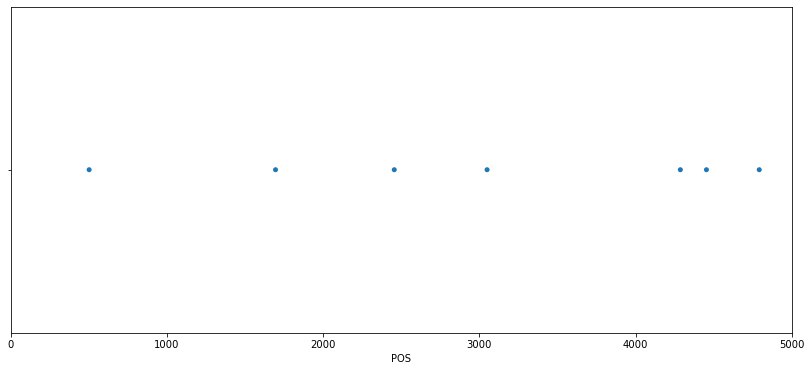

In [150]:
fig,ax = plt.subplots()
fig.set_size_inches(14, 6)

g = sns.swarmplot(x='POS',data=isnvs_set_final[isnvs_set_final['animal']=='RA1790'])
plt.xlim(0,5000)
#plt.xticks(rotation=90)

In [151]:
isnvs_set_final[(isnvs_set_final['POS']>7300)&(isnvs_set_final['POS']<8000)]['POS'].value_counts()

7668.0    83
7648.0     2
7657.0     2
7957.0     1
7603.0     1
7974.0     1
7473.0     1
7479.0     1
7489.0     1
7691.0     1
7554.0     1
7504.0     1
7528.0     1
7531.0     1
7532.0     1
Name: POS, dtype: int64

In [152]:
isnvs_set_final[isnvs_set_final['POS']==7437]

Empty DataFrame
Columns: [description, A_ID, animal, cohort, tissue, POS, depth, variant_reads, freq, alleles, eff_type, eff_gene, eff_protein, aa_mut]
Index: []

(6039.0, 8069.0)

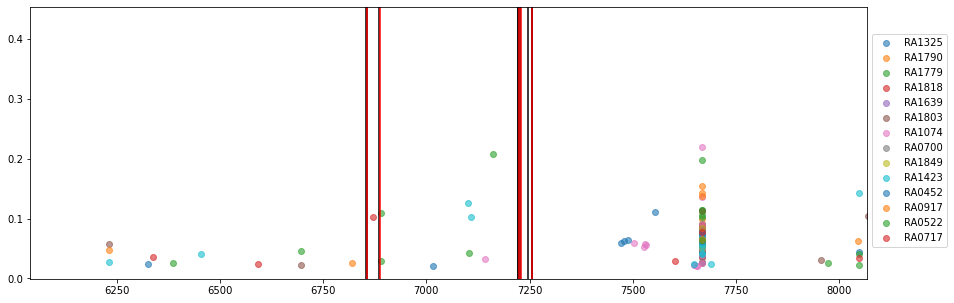

In [153]:
plt.figure(figsize=(15,5))

for animal in set(list(isnvs_set_final['animal'])):
    plt.scatter(isnvs_set_final[isnvs_set_final['animal']==animal]['POS'],isnvs_set_final[isnvs_set_final['animal']==animal]['freq'],label=animal,alpha=0.6)

    
plt.axvline(x=6854,color='black')
plt.axvline(x=6857,color='black')
plt.axvline(x=6885,color='black')

plt.axvline(x=7221,color='black')
plt.axvline(x=7222,color='black')
plt.axvline(x=7228,color='black')
plt.axvline(x=7247,color='black')
plt.axvline(x=7255,color='black')
plt.axvline(x=7256,color='black')

plt.axvline(x=6855,color='red')
plt.axvline(x=6888,color='red')
plt.axvline(x=7224,color='red')
plt.axvline(x=7230,color='red')
plt.axvline(x=7257,color='red')


plt.legend(bbox_to_anchor=(1,.1))
plt.xlim(6039,8069)

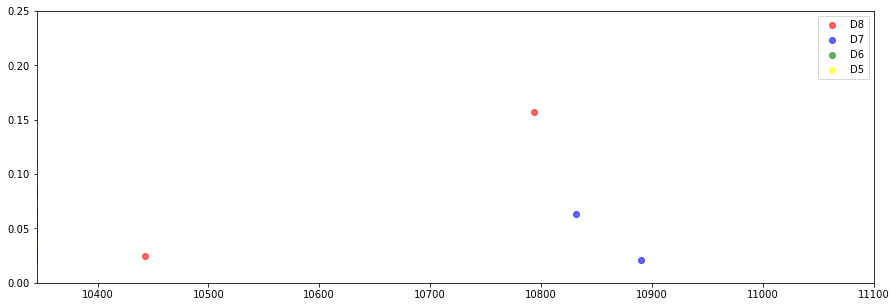

In [154]:
plt.figure(figsize=(15,5))

plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1779']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1779']['freq'],color='red',label='D8',alpha=0.6)
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1423']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1423']['freq'],color='red',label=None,alpha=0.6)

plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1790']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1790']['freq'],color='blue',label='D7',alpha=0.6)
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA0700']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA0700']['freq'],color='blue',label=None,alpha=0.6)

plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1803']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1803']['freq'],color='green',label='D6',alpha=0.6)
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1818']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1818']['freq'],color='green',label=None,alpha=0.6)
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1325']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1325']['freq'],color='green',label=None,alpha=0.6)
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1074']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1074']['freq'],color='green',label=None,alpha=0.6)
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA0917']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA0917']['freq'],color='green',label=None,alpha=0.6)

plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA0522']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA0522']['freq'],color='yellow',label='D5',alpha=0.6)
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA0452']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA0452']['freq'],color='yellow',label=None,alpha=0.6)
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1639']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1639']['freq'],color='yellow',label=None,alpha=0.6)

plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1803']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1803']['freq'])
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1834']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1834']['freq'])

plt.xlim(10345,11100)
plt.ylim(0,.25)
plt.legend()

(0.0, 0.25)

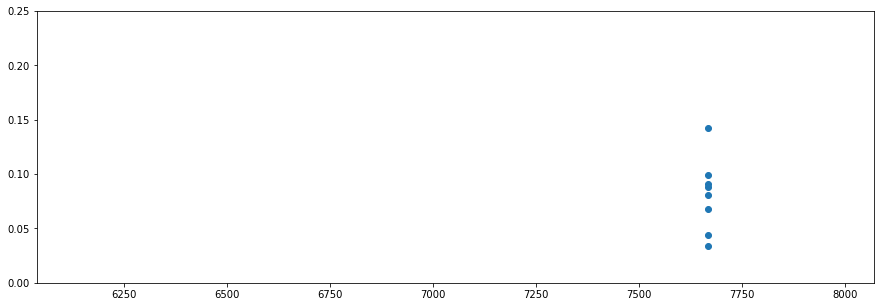

In [155]:
plt.figure(figsize=(15,5))
plt.scatter(isnvs_set_final[isnvs_set_final['animal']=='RA1790']['POS'],isnvs_set_final[isnvs_set_final['animal']=='RA1790']['freq'])

plt.xlim(6039,8069)
plt.ylim(0,.25)

(array([6000., 6250., 6500., 6750., 7000., 7250., 7500., 7750., 8000.,
        8250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

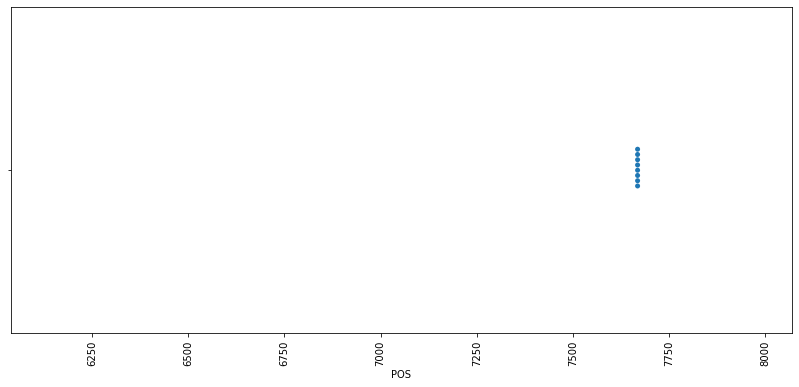

In [156]:
fig,ax = plt.subplots()
fig.set_size_inches(14, 6)

g = sns.swarmplot(x='POS',data=isnvs_set_final[isnvs_set_final['animal']=='RA1790'],hue='eff_type')
plt.xlim(6039,8069)
plt.xticks(rotation=90)

(array([6000., 6250., 6500., 6750., 7000., 7250., 7500., 7750., 8000.,
        8250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

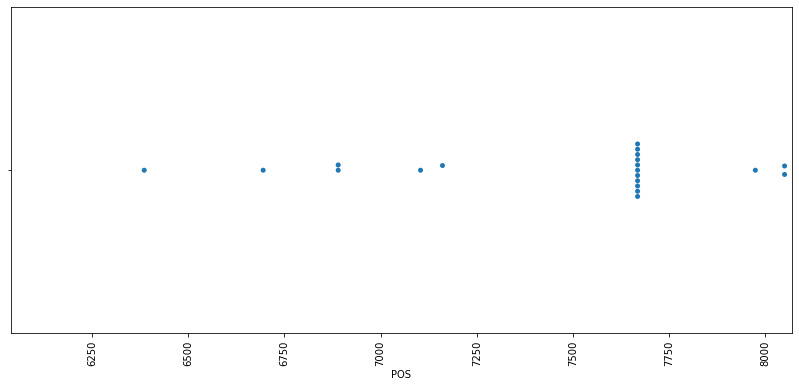

In [157]:
fig,ax = plt.subplots()
fig.set_size_inches(14, 6)

g = sns.swarmplot(x='POS',data=isnvs_set_final[isnvs_set_final['animal']=='RA1779'],hue='eff_type')
plt.xlim(6039,8069)
plt.xticks(rotation=90)

In [158]:
isnvs_set_final[isnvs_set_final['POS']==11282]

description   A_ID  animal cohort       tissue  \
22              Spleen_RA1803_D006  A0001  RA1803   D006       Spleen   
76        Lymph node 3_RA1803_D006  A0010  RA1803   D006   Lymph node   
114             Spleen_RA0717_D004  A0029  RA0717   D004       Spleen   
174             Spleen_RA0700_D007  A0043  RA0700   D007       Spleen   
311            Spleen2_RA0700_D007  A0043  RA0700   D007      Spleen2   
440             Kidney_RA0700_D007  A0044  RA0700   D007       Kidney   
459       Lymph node 1_RA0700_D007  A0050  RA0700   D007   Lymph node   
486       Lymph node 2_RA0700_D007  A0051  RA0700   D007   Lymph node   
510       Lymph node 3_RA0700_D007  A0052  RA0700   D007   Lymph node   
541             Spleen_RA1779_D008  A0071  RA1779   D008       Spleen   
612            Spleen2_RA1779_D008  A0071  RA1779   D008      Spleen2   
772             Spleen_RA0522_D005  A0113  RA0522   D005       Spleen   
797            Spleen2_RA0522_D005  A0113  RA0522   D005      Spleen2   
825             Spleen_RA0452_D005  A0127  RA0452   D005       Spleen   
862             Spleen_RA1790_D007  A0141  RA1790   D007       Spleen   
927            Spleen2_RA1790_D007  A0141  RA1790   D007      Spleen2   
1016      Lymph node 1_RA1790_D007  A0148  RA1790   D007   Lymph node   
1155      Lymph node 2_RA1818_D006  A0163  RA1818   D006   Lymph node   
1188      Lymph node 3_RA1818_D006  A0164  RA1818   D006   Lymph node   
1245            Spleen_RA0917_D006  A0183  RA0917   D006       Spleen   
1297           Spleen2_RA0917_D006  A0183  RA0917   D006      Spleen2   
1404      Lymph node 1_RA0917_D006  A0190  RA0917   D006   Lymph node   
1452      Lymph node 2_RA0917_D006  A0191  RA0917   D006   Lymph node   
1505      Lymph node 3_RA0917_D006  A0192  RA0917   D006   Lymph node   
1567            Spleen_RA1423_D008  A0197  RA1423   D008       Spleen   
1639           Spleen2_RA1423_D008  A0197  RA1423   D008      Spleen2   
1871      Lymph node 3_RA1423_D008  A0206  RA1423   D008   Lymph node   
1941            Spleen_RA1639_D005  A0211  RA1639   D005       Spleen   
1975      Lymph node 3_RA1639_D005  A0220  RA1639   D005   Lymph node   
1985            Spleen_RA1325_D006  A0225  RA1325   D006       Spleen   
2004      Lymph node 1_RA1325_D006  A0232  RA1325   D006   Lymph node   
2056            Spleen_RA1074_D006    NaN  RA1074   D006      Spleen2   
2076           Spleen2_RA1074_D006    NaN  RA1074   D006       Spleen   
2106            Kidney_RA1074_D006    NaN  RA1074   D006       Kidney   
2159      Lymph node 1_RA1074_D006    NaN  RA1074   D006   Lymph node   
2172      Lymph node 2_RA1074_D006    NaN  RA1074   D006   Lymph node   
2198      Lymph node 3_RA1074_D006    NaN  RA1074   D006   Lymph node   
2218         Sex Organ_RA1074_D006    NaN  RA1074   D006    Sex Organ   
2250  Whole blood_D007_RA0700_D007  A0306  RA0700   D007  Whole blood   
2313  Whole blood_D006_RA1818_D006  A0309  RA1818   D006  Whole blood   
2342  Whole blood_D008_RA1779_D008  A0312  RA1779   D008  Whole blood   
2369  Whole blood_D007_RA1790_D007  A0315  RA1790   D007  Whole blood   
2396  Whole blood_D006_RA0917_D006  A0318  RA0917   D006  Whole blood   
2419  Whole blood_D008_RA1423_D008  A0321  RA1423   D008  Whole blood   
2457  Whole blood_D005_RA1639_D005  A0348  RA1639   D005  Whole blood   
2507  Whole blood_D006_RA1074_D006  A0365  RA1074   D006  Whole blood   
2526  Whole blood_D006_RA1325_D006  A0370  RA1325   D006  Whole blood   
2564  Whole blood_D006_RA1803_D006  A0375  RA1803   D006  Whole blood   

          POS    depth  variant_reads      freq alleles  \
22    11282.0   1065.0           45.0  0.042254      AC   
76    11282.0    159.0           20.0  0.125786      AC   
114   11282.0   1207.0           46.0  0.038111      AC   
174   11282.0   8617.0          334.0  0.038761      AC   
311   11282.0   8816.0          328.0  0.037205      AC   
440   11282.0    227.0            9.0  0.039648      AC   
459   11282.0    416.0          

13
11282.0
11
10343.0
14
7668.0


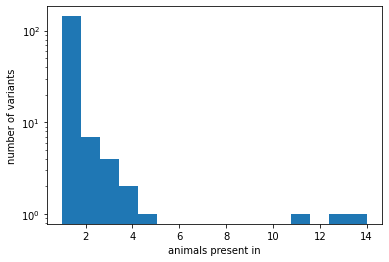

In [159]:
pos_samps = []
for pos in list(set(isnvs_set_final['POS'])):
    pos_samps.append(len(list(set(isnvs_set_final[isnvs_set_final['POS']==pos]['animal']))))
    #print(list(set(isnvs_set_final[isnvs_set_final['POS']==pos]['animal'])))
    if len(list(set(isnvs_set_final[isnvs_set_final['POS']==pos]['animal']))) > 5:
        print(len(list(set(isnvs_set_final[isnvs_set_final['POS']==pos]['animal']))))
        print(pos)
    
plt.hist(pos_samps,bins=16)
plt.ylabel('number of variants')
plt.xlabel('animals present in')
plt.yscale('log')

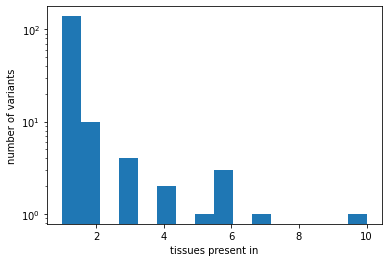

In [160]:
pos_samps = []
for pos in list(set(isnvs_set_final['POS'])):
    pos_samps.append(len(list(set(isnvs_set_final[isnvs_set_final['POS']==pos]['tissue']))))
    #print(list(set(isnvs_set_final[isnvs_set_final['POS']==pos]['animal'])))
    
plt.hist(pos_samps,bins=16)
plt.ylabel('number of variants')
plt.xlabel('tissues present in')
plt.yscale('log')

### tissue-specific variants

In [161]:
plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

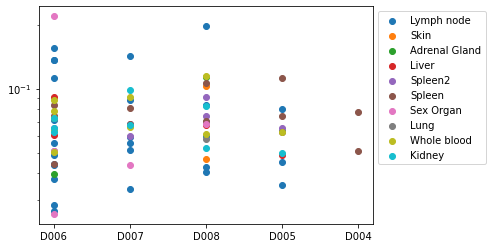

In [162]:
for tissue in list(set(isnvs_set_final[isnvs_set_final['POS']==7668]['tissue'])):
    temp = isnvs_set_final[(isnvs_set_final['POS']==7668)&(isnvs_set_final['tissue']==tissue)]
    plt.scatter(temp['cohort'],temp['freq'],label=tissue,cmap='tab20c')
plt.legend(bbox_to_anchor=(1,1))
plt.yscale('log')

                

In [163]:
isnvs_set_final['POS'].value_counts()

7668.0     83
11282.0    48
10343.0    28
4531.0      9
5077.0      6
           ..
11745.0     1
4286.0      1
2455.0      1
7489.0      1
18584.0     1
Name: POS, Length: 161, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


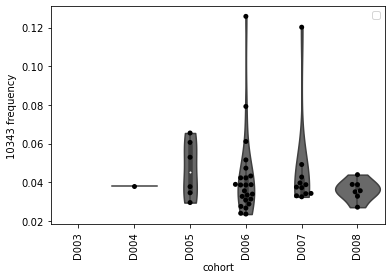

In [164]:
fig,ax = plt.subplots()
fig.set_size_inches(6, 4)

g = sns.violinplot(x='cohort',y='freq',data=isnvs_set_final[isnvs_set_final['POS']==11282],color='dimgrey',order=['D003','D004','D005','D006','D007','D008'],cut=0)
g = sns.swarmplot(x='cohort',y='freq',data=isnvs_set_final[isnvs_set_final['POS']==11282],color='black',order=['D003','D004','D005','D006','D007','D008'],)
plt.xticks(rotation=90)
plt.ylabel('10343 frequency')
plt.legend(bbox_to_anchor=(1,1))


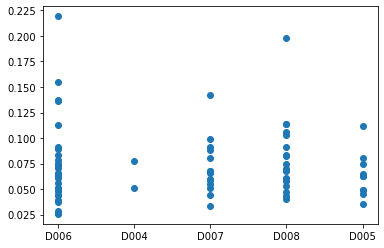

In [165]:

plt.scatter(isnvs_set_final[isnvs_set_final['POS']==7668]['cohort'],isnvs_set_final[isnvs_set_final['POS']==7668]['freq'])


In [166]:
isnvs_set_final['POS'].value_counts()

7668.0     83
11282.0    48
10343.0    28
4531.0      9
5077.0      6
           ..
11745.0     1
4286.0      1
2455.0      1
7489.0      1
18584.0     1
Name: POS, Length: 161, dtype: int64

In [167]:
tissue_specific_vars = pd.DataFrame()
tissue = []
number_occurring = []
var_type = []

for pos in list(set(isnvs_set_final['POS'])):
    number_samps = len(isnvs_set_final[isnvs_set_final['POS']==pos])
    tissues = list(set(isnvs_set_final[isnvs_set_final['POS']==pos]['tissue']))
    eff_type = list(set(isnvs_set_final[isnvs_set_final['POS']==pos]['eff_type']))
    if (len(tissues)==1):
        tissue.append(tissues[0])
        number_occurring.append(number_samps)
        var_type.append(eff_type[0])

tissue_specific_vars['tissue']=tissue
tissue_specific_vars['number_animals']=number_occurring
tissue_specific_vars['variant type']=var_type

tissue_specific_vars.head()

tissue  number_animals        variant type
0  Lymph node               2    missense_variant
1  Lymph node               1  synonymous_variant
2  Lymph node               1           stop_lost
3  Lymph node               1    missense_variant
4  Lymph node               2    missense_variant

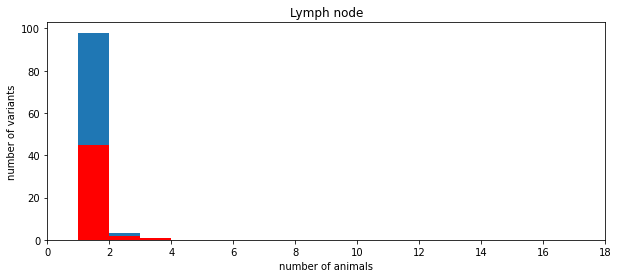

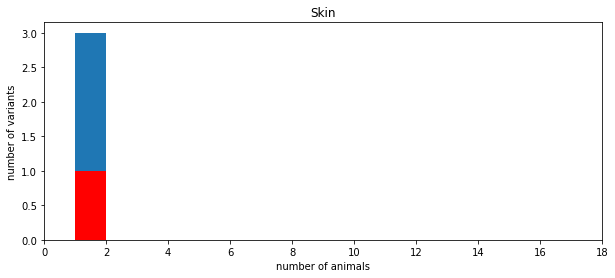

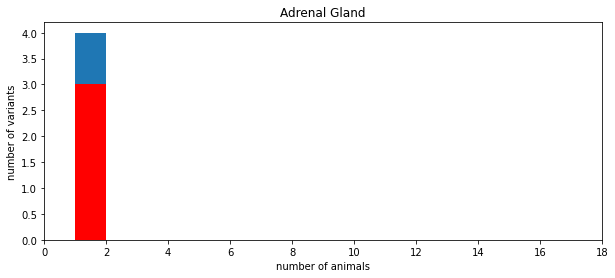

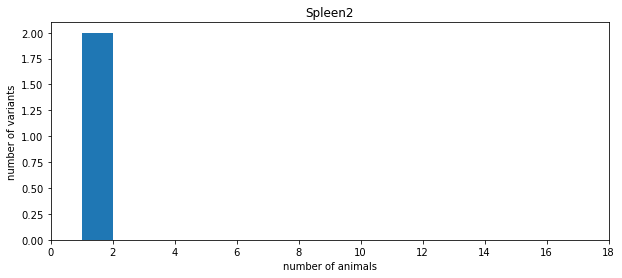

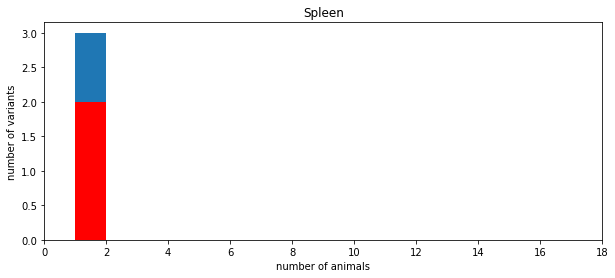

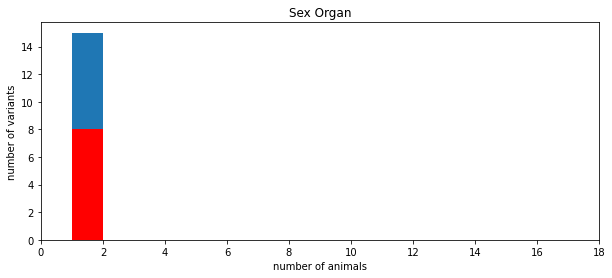

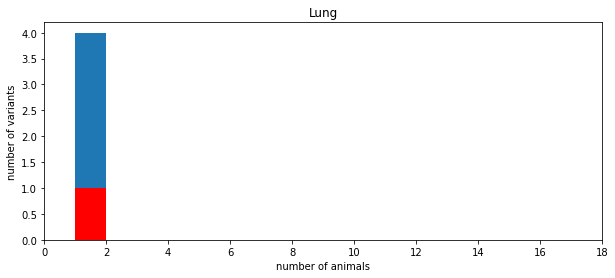

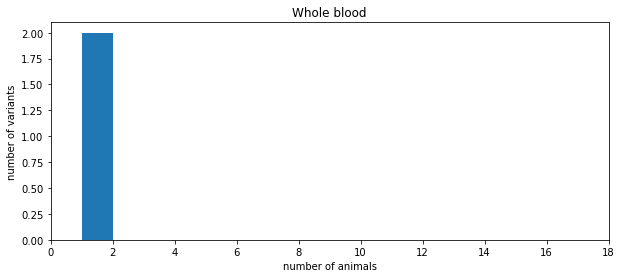

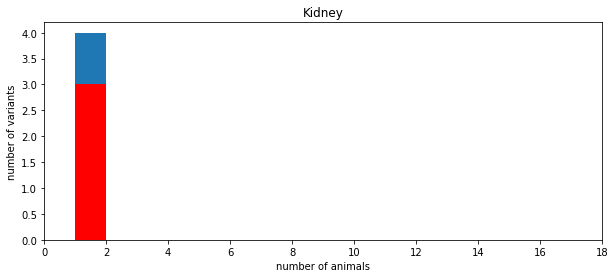

In [168]:
for tissue in list(set(tissue_specific_vars['tissue'])):
    df = tissue_specific_vars[tissue_specific_vars['tissue']==tissue]
    nonsyn_df = tissue_specific_vars[(tissue_specific_vars['tissue']==tissue)&(tissue_specific_vars['variant type']=='missense_variant')]
    
    plt.figure(figsize=(10,4))
    plt.hist(df['number_animals'],bins=18,range=(0,18))
    plt.hist(nonsyn_df['number_animals'],bins=18,range=(0,18),color='red')
    plt.xlabel('number of animals')
    plt.ylabel('number of variants')
    plt.xlim(0,18)
    #plt.ylim(0,500)
    #plt.yscale('log')
    plt.title(tissue)


## general variant features

In [ ]:
isnvs_set_final['alleles'].value_counts().plot.pie(figsize=(10, 10))


In [ ]:
isnvs_set_final['eff_type'].value_counts().plot.pie(figsize=(10, 10))


In [ ]:
isnvs_set_final['eff_gene'].value_counts().plot.pie(figsize=(10, 10))


## differences over time/tissues

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 24.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 41.3% of the points cannot be placed; y

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'GP'),
  Text(1, 0, 'VP24'),
  Text(2, 0, 'L'),
  Text(3, 0, 'SsGP'),
  Text(4, 0, 'NP'),
  Text(5, 0, 'VP35'),
  Text(6, 0, 'VP30'),
  Text(7, 0, 'VP40'),
  Text(8, 0, 'sGP')])

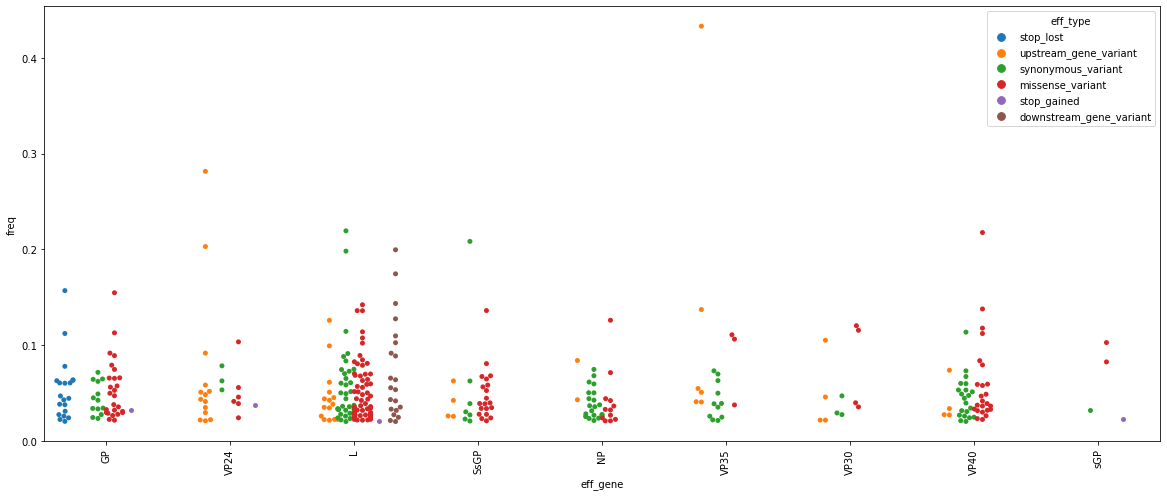

In [169]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 8)

g = sns.swarmplot(x='eff_gene',y='freq',data=isnvs_set_final,hue='eff_type',dodge=True)
plt.xticks(rotation=90)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 45.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 54.5% of the points c

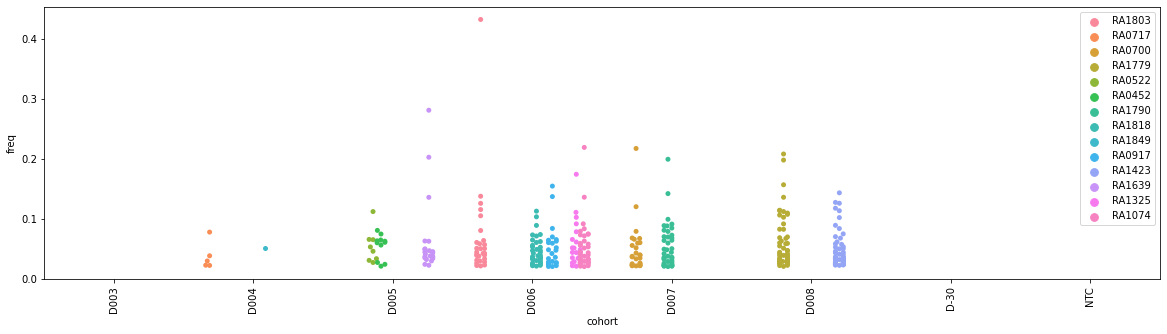

In [170]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 5)

g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='animal',dodge=True)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1))

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'D003'),
  Text(1, 0, 'D004'),
  Text(2, 0, 'D005'),
  Text(3, 0, 'D006'),
  Text(4, 0, 'D007'),
  Text(5, 0, 'D008'),
  Text(6, 0, 'D-30'),
  Text(7, 0, 'NTC')])

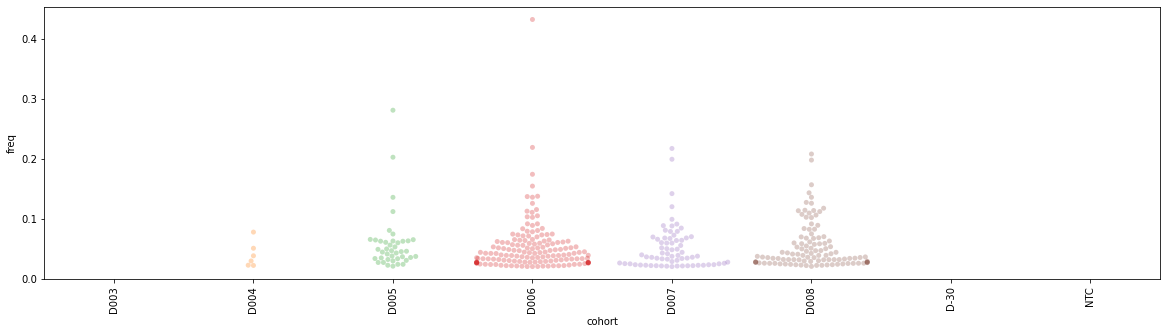

In [171]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 5)

g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,alpha=0.3)
plt.xticks(rotation=90)


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


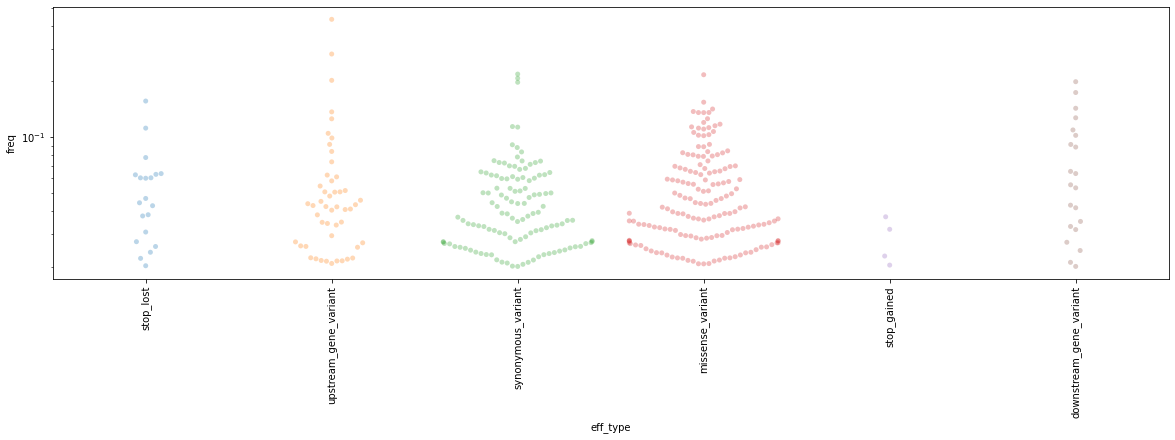

In [172]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 5)

g = sns.swarmplot(x='eff_type',y='freq',data=isnvs_set_final,alpha=0.3)
plt.xticks(rotation=90)
plt.yscale('log')


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'D003'),
  Text(1, 0, 'D004'),
  Text(2, 0, 'D005'),
  Text(3, 0, 'D006'),
  Text(4, 0, 'D007'),
  Text(5, 0, 'D008'),
  Text(6, 0, 'D-30'),
  Text(7, 0, 'NTC')])

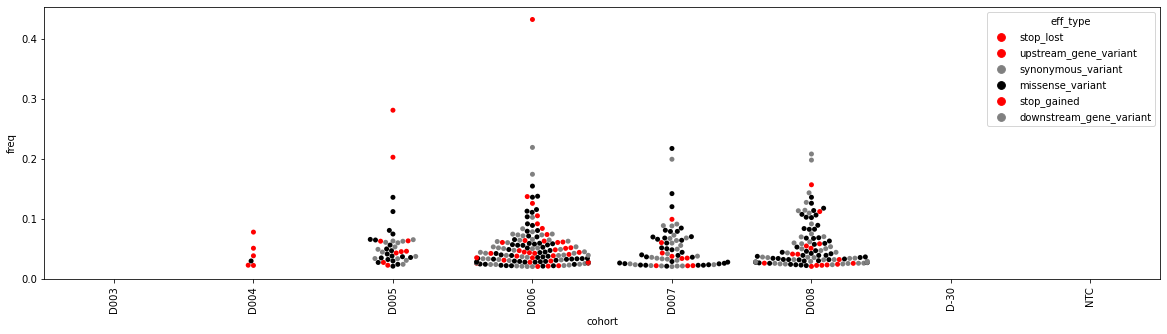

In [173]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 5)
cmap_test = ['red','red','grey','black','red','grey','grey','red','black']

g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
plt.xticks(rotation=90)


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'D003'),
  Text(1, 0, 'D004'),
  Text(2, 0, 'D005'),
  Text(3, 0, 'D006'),
  Text(4, 0, 'D007'),
  Text(5, 0, 'D008'),
  Text(6, 0, 'D-30'),
  Text(7, 0, 'NTC')])

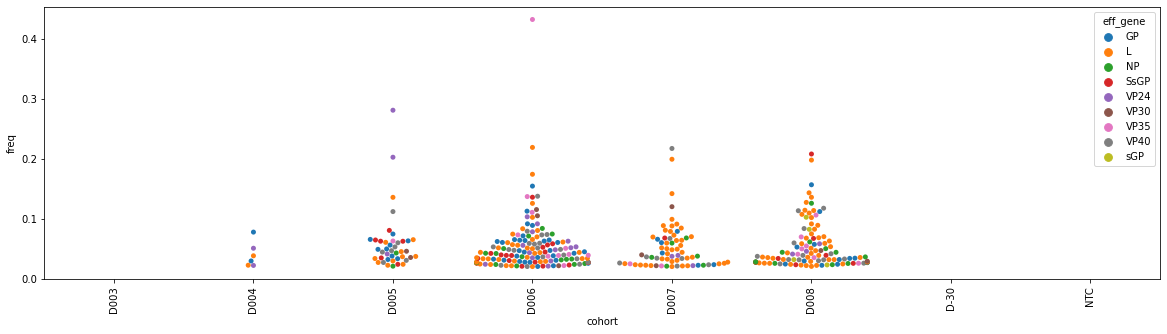

In [174]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 5)

g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],hue_order=['GP','L','NP','SsGP','VP24','VP30','VP35','VP40','sGP'],data=isnvs_set_final,hue='eff_gene',cmap='tab20')
plt.xticks(rotation=90)


In [175]:
isnvs_set_final[isnvs_set_final['POS']=='10144']

Empty DataFrame
Columns: [description, A_ID, animal, cohort, tissue, POS, depth, variant_reads, freq, alleles, eff_type, eff_gene, eff_protein, aa_mut]
Index: []

In [176]:
isnvs_set_final[isnvs_set_final['freq']>0.2]

description   A_ID  animal cohort      tissue      POS  \
77       Sex Organ_RA1803_D006  A0012  RA1803   D006   Sex Organ   2946.0   
457   Lymph node 1_RA0700_D007  A0050  RA0700   D007  Lymph node   8931.0   
749           Skin_RA1779_D008  A0083  RA1779   D008        Skin   7161.0   
1966  Lymph node 2_RA1639_D005  A0219  RA1639   D005  Lymph node  10144.0   
1967  Lymph node 2_RA1639_D005  A0219  RA1639   D005  Lymph node  15453.0   
2150     Sex Organ_RA1074_D006    NaN  RA1074   D006   Sex Organ   7668.0   

      depth  variant_reads      freq alleles               eff_type eff_gene  \
77    217.0           94.0  0.433180      AC  upstream_gene_variant     VP35   
457   285.0           62.0  0.217544      AG       missense_variant     VP40   
749   893.0          186.0  0.208287      CT     synonymous_variant     SsGP   
1966  135.0           38.0  0.281481      AG  upstream_gene_variant     VP24   
1967  138.0           28.0  0.202899      AG  upstream_gene_variant     VP24   
2150  456.0          100.0  0.219298      TC     synonymous_variant        L   

           eff_protein        aa_mut  
77    DF49_53415gpVP35                
457   DF49_53415gpVP40    p.Ala55Ser  
749   DF49_53415gpSsGP   p.Thr284Thr  
1966  DF49_53415gpVP24                
1967  DF49_53415gpVP24                
2150     DF49_53415gpL  p.Thr1453Thr

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 25.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 27.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 20.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; y

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'GP'),
  Text(1, 0, 'VP24'),
  Text(2, 0, 'L'),
  Text(3, 0, 'SsGP'),
  Text(4, 0, 'NP'),
  Text(5, 0, 'VP35'),
  Text(6, 0, 'VP30'),
  Text(7, 0, 'VP40'),
  Text(8, 0, 'sGP')])

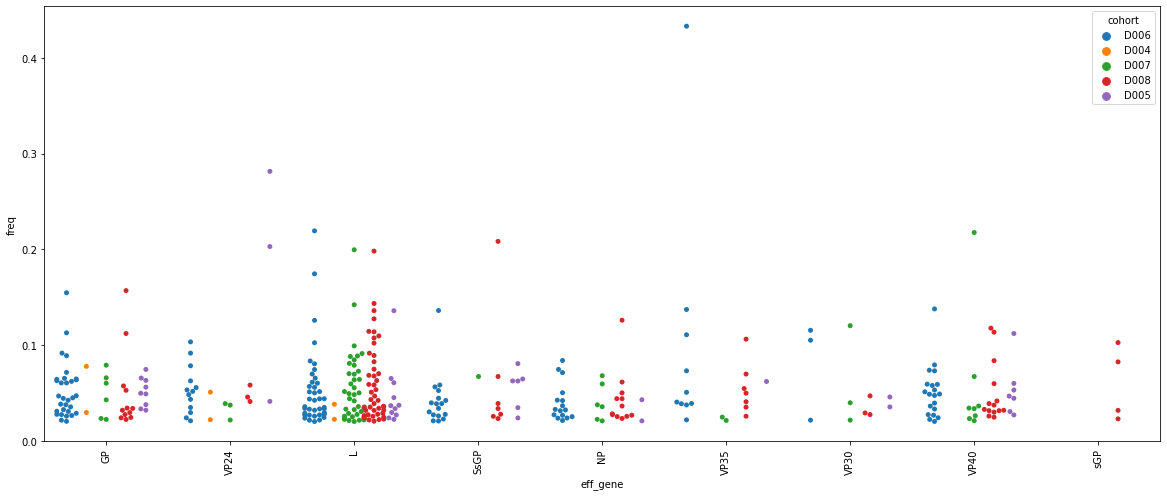

In [177]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 8)

g = sns.swarmplot(x='eff_gene',y='freq',data=isnvs_set_final,hue='cohort',dodge=True)
plt.xticks(rotation=90)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 34.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; y

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'GP'),
  Text(1, 0, 'VP24'),
  Text(2, 0, 'L'),
  Text(3, 0, 'SsGP'),
  Text(4, 0, 'NP'),
  Text(5, 0, 'VP35'),
  Text(6, 0, 'VP30'),
  Text(7, 0, 'VP40'),
  Text(8, 0, 'sGP')])

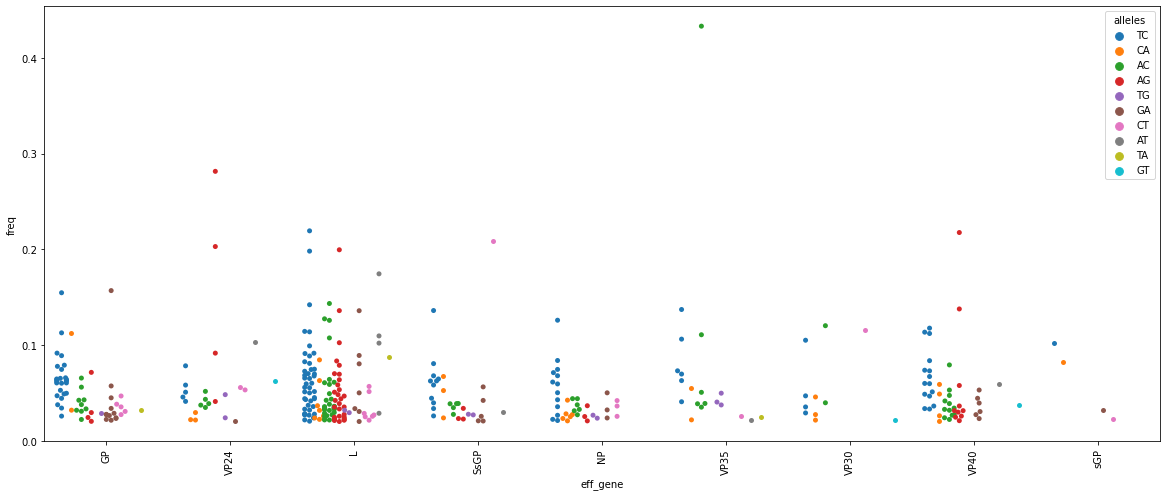

In [178]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 8)

g = sns.swarmplot(x='eff_gene',y='freq',data=isnvs_set_final,hue='alleles',dodge=True)
plt.xticks(rotation=90)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


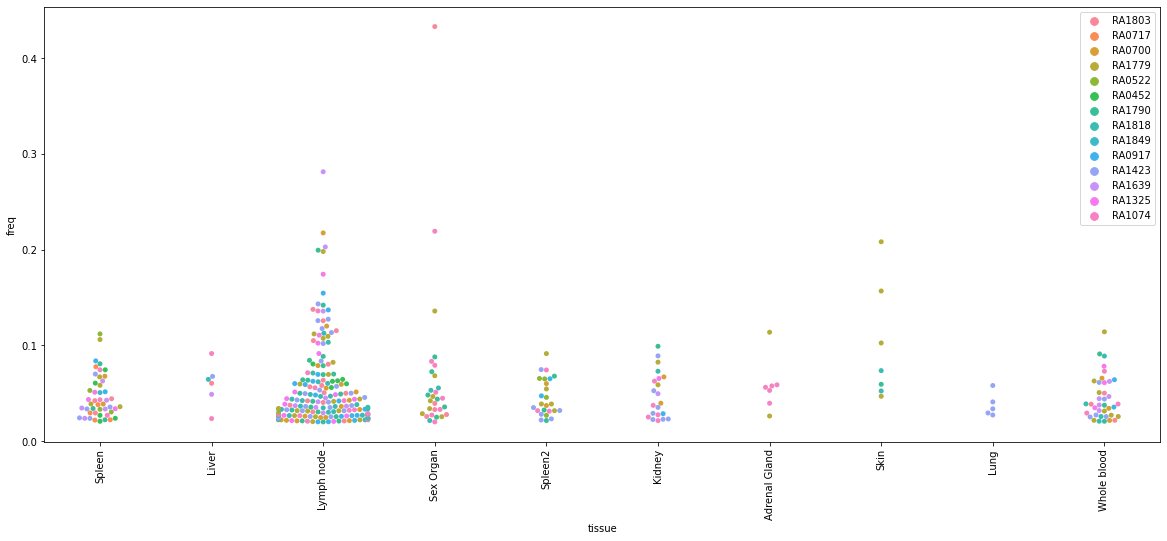

In [179]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 8)

g = sns.swarmplot(x='tissue',y='freq',data=isnvs_set_final,hue='animal')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1))
#plt.yscale('log')

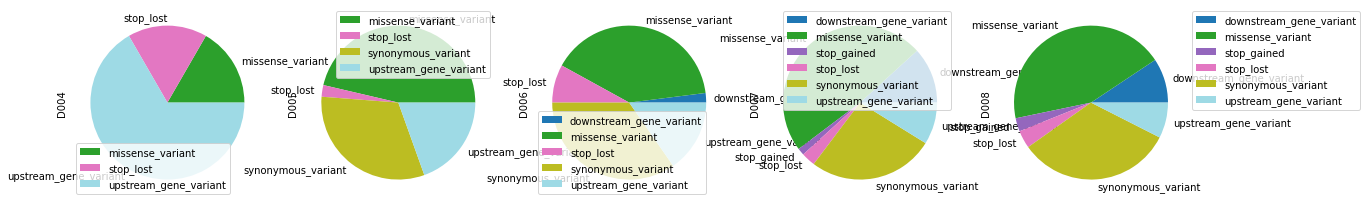

In [180]:
plt.rcParams.update({'text.color': 'black'})

isnvs_set_final.groupby(['eff_type', 'cohort']).size().unstack().plot(kind='pie', stacked=True,figsize=(20,20),cmap="tab20",legend=True,subplots=True)
plt.legend(bbox_to_anchor=(1,1))
#plt.ylabel('number of variants')
#plt.yscale('log')

In [181]:
nonsyn_temp = isnvs_set_final[(isnvs_set_final['eff_type']=='missense_variant')|(isnvs_set_final['eff_type']=='stop_gained')|(isnvs_set_final['eff_type']=='stop_lost')]
syn_temp = isnvs_set_final[(isnvs_set_final['eff_type']=='synonymous_variant')|(isnvs_set_final['eff_type']=='downstream_gene_variant')|(isnvs_set_final['eff_type']=='upstream_gene_variant')]
                              

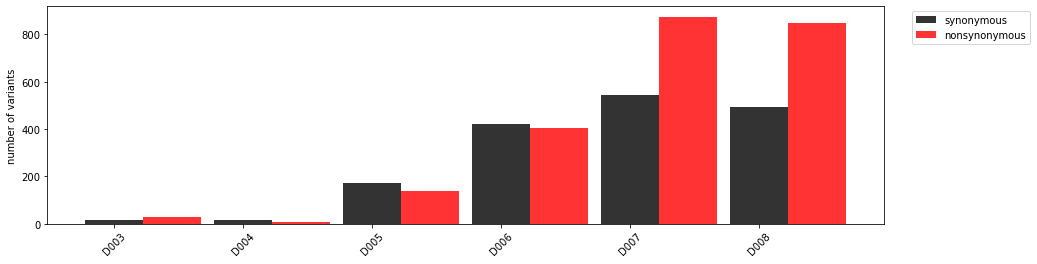

In [182]:
cmap_5 = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
labels = ['D003','D004','D005','D006','D007','D008']

plt.figure(figsize=(15,4))
plt.rcParams.update({'font.size': 10})

plt.bar(np.arange(6),[17,14,171,423,543,495],alpha=0.8,label='synonymous',width = 0.45,color='black')
plt.bar(np.arange(6)+0.45,[27,9,137,405,875,850],alpha=0.8,label='nonsynonymous',width = 0.45,color='red')

#plt.yscale('log')
plt.ylabel('number of variants')
plt.xticks(rotation = 45)
plt.xticks(np.arange(6), labels)
plt.legend()
plt.legend(bbox_to_anchor=(1.18,1))
#plt.ylim(0,3000)

In [183]:
isnvs_set_final[(isnvs_set_final['cohort']=='D007')|(isnvs_set_final['cohort']=='D008')&(isnvs_set_final['eff_type']=='missense_variant')]['tissue'].value_counts()


Lymph node       59
Sex Organ        12
Spleen           10
Kidney           10
Spleen2           9
Whole blood       9
Adrenal Gland     2
Skin              2
Liver             1
Lung              1
Name: tissue, dtype: int64

In [184]:
isnvs_set_final[(isnvs_set_final['cohort']=='D007')|(isnvs_set_final['cohort']=='D008')&(isnvs_set_final['eff_type']=='synonymous_variant')]['tissue'].value_counts()


Lymph node     56
Whole blood    12
Spleen         10
Spleen2         9
Sex Organ       7
Kidney          4
Skin            3
Lung            2
Name: tissue, dtype: int64

In [185]:
isnvs_set_final[(isnvs_set_final['cohort']=='D007')|(isnvs_set_final['cohort']=='D008')&(isnvs_set_final['eff_type']=='missense_variant')]['eff_gene'].value_counts()


L       61
VP40    17
NP      10
GP       9
SsGP     6
VP24     4
VP30     3
VP35     3
sGP      2
Name: eff_gene, dtype: int64

In [186]:
isnvs_set_final[(isnvs_set_final['cohort']=='D007')|(isnvs_set_final['cohort']=='D008')&(isnvs_set_final['eff_type']=='synonymous_variant')]['eff_gene'].value_counts()


L       48
NP      14
VP40    13
GP      10
VP30     6
VP35     6
VP24     3
SsGP     2
sGP      1
Name: eff_gene, dtype: int64

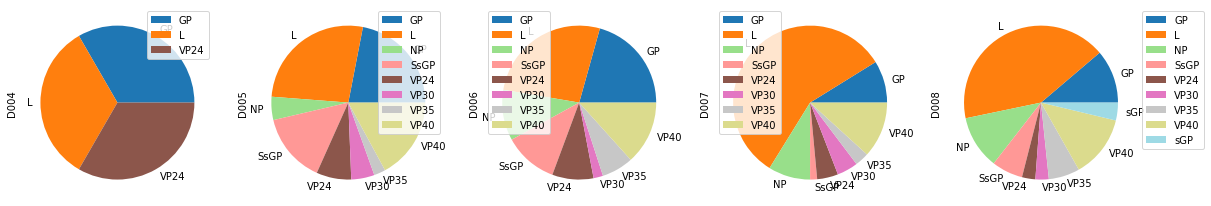

In [187]:
plt.rcParams.update({'text.color': 'black'})

isnvs_set_final.groupby(['eff_gene', 'cohort']).size().unstack().plot(kind='pie', stacked=True,figsize=(20,20),cmap="tab20",subplots=True)
plt.legend(bbox_to_anchor=(1,1))
#plt.ylabel('number of variants')
#plt.yscale('log')

Text(0, 0.5, 'number of variants')

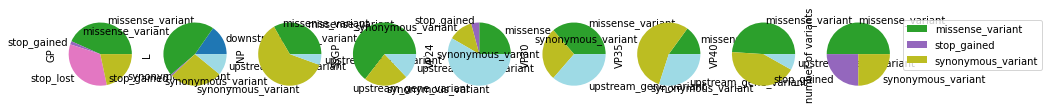

In [188]:
isnvs_set_final.groupby(['eff_type', 'eff_gene']).size().unstack().plot(kind='pie', subplots=True,figsize=(15,5),legend=False,colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('number of variants')
#plt.yscale('log')

Text(0, 0.5, 'number of variants')

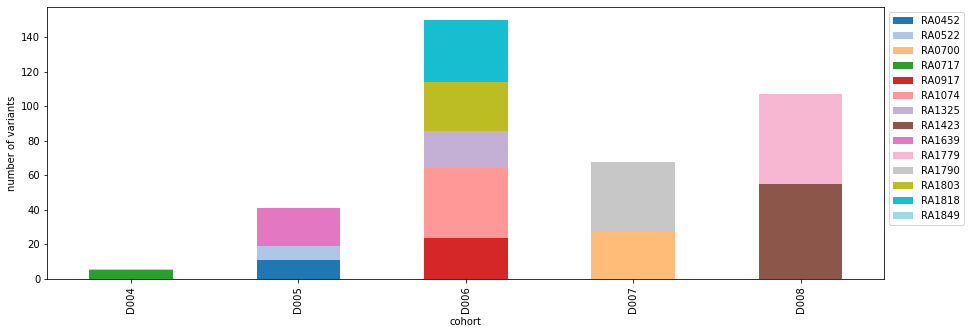

In [189]:
isnvs_set_final.groupby(['cohort', 'animal']).size().unstack().plot(kind='bar', stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('number of variants')
#plt.yscale('log')


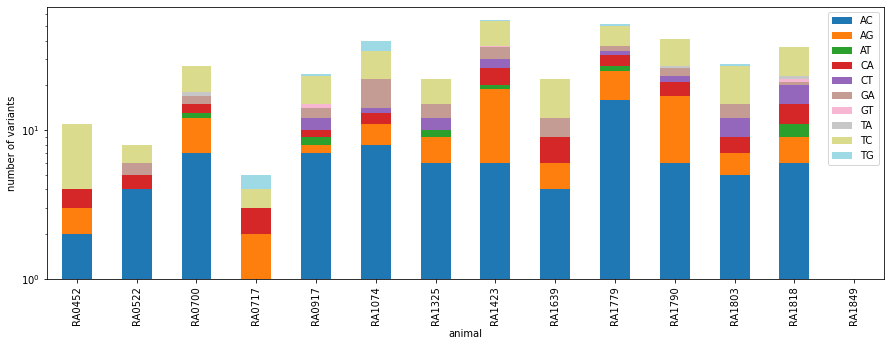

In [190]:
isnvs_set_final.groupby(['animal', 'alleles']).size().unstack().plot(kind='bar', stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('number of variants')
plt.yscale('log')


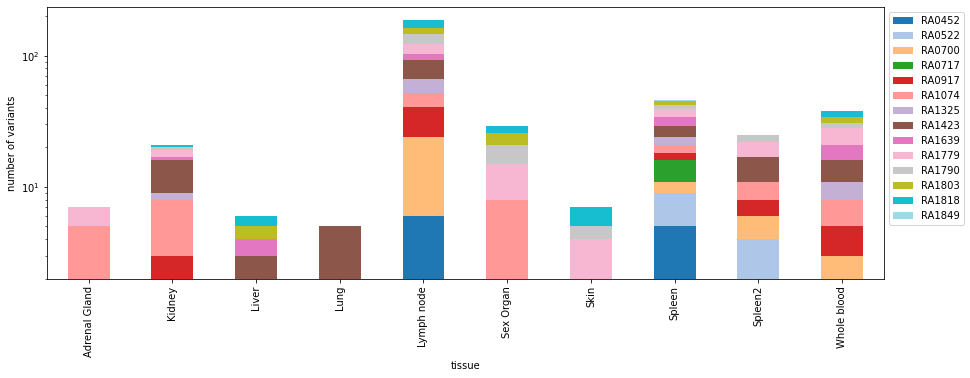

In [191]:
isnvs_set_final.groupby(['tissue', 'animal']).size().unstack().plot(kind='bar', stacked=True,figsize=(15,5),colormap="tab20")
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('number of variants')
plt.yscale('log')


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


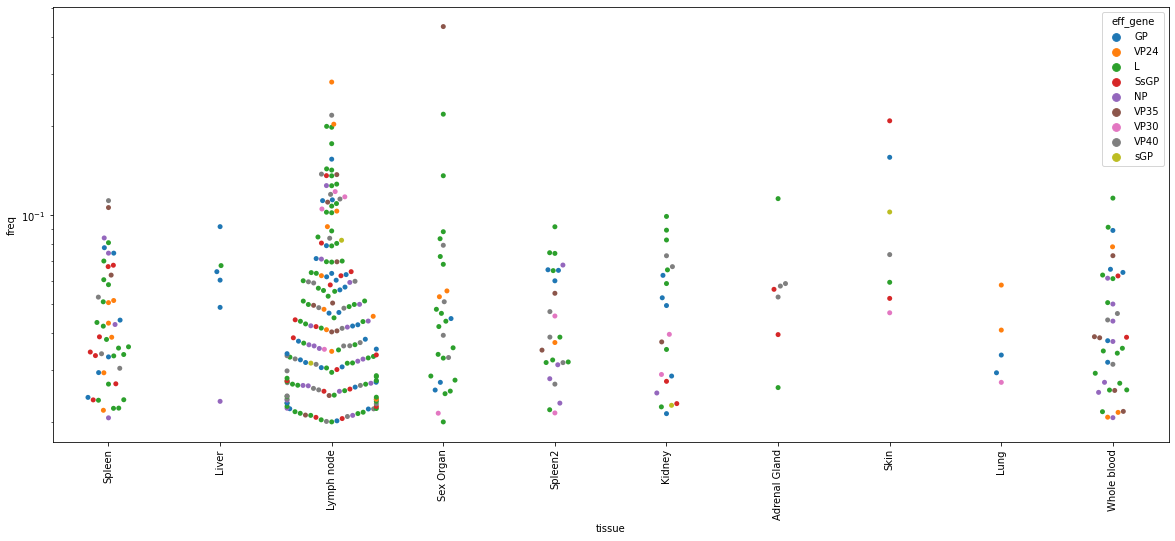

In [192]:
fig,ax = plt.subplots()
fig.set_size_inches(20, 8)

g = sns.swarmplot(x='tissue',y='freq',data=isnvs_set_final,hue='eff_gene')
plt.xticks(rotation=90)
plt.yscale('log')

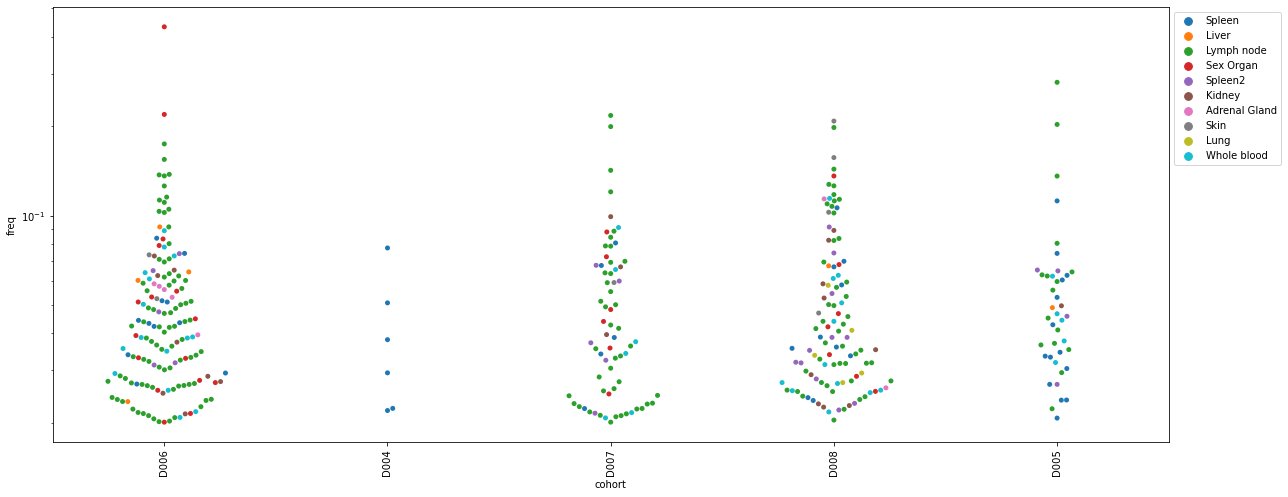

In [193]:
plt.rcParams.update({'text.color': 'black'})

fig,ax = plt.subplots()
fig.set_size_inches(20, 8)

g = sns.swarmplot(x='cohort',y='freq',data=isnvs_set_final,hue='tissue')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


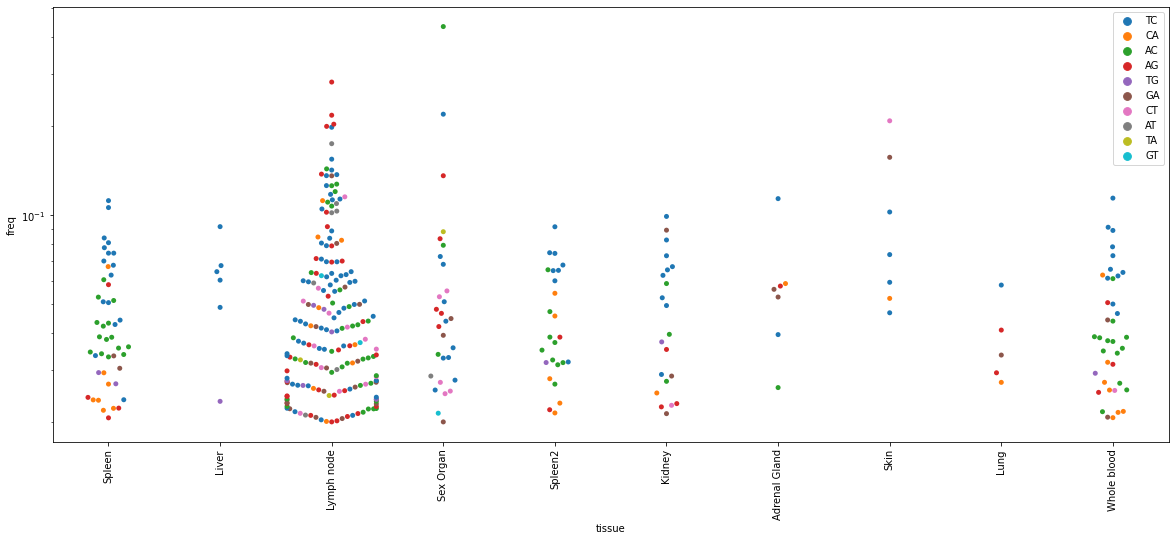

In [194]:
plt.rcParams.update({'text.color': 'black'})

fig,ax = plt.subplots()
fig.set_size_inches(20, 8)

g = sns.swarmplot(x='tissue',y='freq',data=isnvs_set_final,hue='alleles')
plt.xticks(rotation=90)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))

In [195]:
eff_types_by_tis = pd.DataFrame(index=range(len(list(set(isnvs_set_final['eff_type'])))),columns=list(set(isnvs_set_final['tissue'])))
eff_types_by_tis.index = (list(set(isnvs_set_final['eff_type'])))

alleles_by_tis = pd.DataFrame(index=range(len(list(set(isnvs_set_final['alleles'])))),columns=list(set(isnvs_set_final['tissue'])))
alleles_by_tis.index = (list(set(isnvs_set_final['alleles'])))

eff_gene_by_tis = pd.DataFrame(index=range(len(list(set(isnvs_set_final['eff_gene'])))),columns=list(set(isnvs_set_final['tissue'])))
eff_gene_by_tis.index = (list(set(isnvs_set_final['eff_gene'])))

for tissue in list(set(isnvs_set_final['tissue'])):
    df = isnvs_set_final[isnvs_set_final['tissue']==tissue]
    for eff_type in list(set(isnvs_set_final['eff_type'])):
        eff_types_by_tis[tissue][eff_type] = len(df[df['eff_type']==eff_type])
    for allele in list(set(isnvs_set_final['alleles'])):
        alleles_by_tis[tissue][allele] = len(df[df['alleles']==allele])
    for eff_gene in list(set(isnvs_set_final['eff_gene'])):
        eff_gene_by_tis[tissue][eff_gene] = len(df[df['eff_gene']==eff_gene])
    #print(df['eff_gene'].value_counts())
    #eff_types_by_tis[tissue] = df['eff_gene'].value_counts()
    
eff_gene_by_tis = eff_gene_by_tis[['Kidney','Lymph node','PBMC','Spleen','Whole blood']]
#alleles_by_tis = alleles_by_tis[['Kidney','Lymph node','PBMC','Spleen','Whole blood']]
eff_types_by_tis = eff_types_by_tis[['Kidney','Lymph node','PBMC','Spleen','Whole blood']]


KeyError: "['PBMC'] not in index"

In [ ]:
eff_types_by_tis.sum().plot.bar(figsize=(10,10))
plt.ylabel('number of variants')
#plt.yscale('log')

In [ ]:
eff_types_by_tis.transpose().plot.bar(stacked=True,figsize=(20,10),colormap="tab20")
plt.rcParams.update({'text.color': 'white'})
eff_types_by_tis.plot.pie(subplots=True, figsize=(30, 30),legend=False,label=None,colormap="tab20")

In [ ]:
plt.rcParams.update({'text.color': 'black'})
alleles_by_tis.transpose().plot.bar(stacked=True,figsize=(20,10),colormap="tab20")

plt.rcParams.update({'text.color': 'white'})
alleles_by_tis.plot.pie(subplots=True, figsize=(30, 30),legend=False,colormap="tab20")

In [ ]:
plt.rcParams.update({'text.color': 'black'})


In [ ]:
cmap = ['blue','orange','red','green','purple','brown','pink','aqua','lime','lime','black','grey','brown']
for tissue,color in zip(list(set(isnvs_set_final['tissue'])),cmap):
    df_temp = isnvs_set_final[isnvs_set_final['tissue']==tissue]
    num_variants = []
    frac_GT = []
    for samp in list(set(df_temp['description'])):
        df_temp2 = df_temp[df_temp['description']==samp]
        num_variants.append(len(df_temp2))
        df_temp3 = df_temp2[df_temp2['alleles']=='GT']
        if len(df_temp2) != 0:
            frac = len(df_temp3)/len(df_temp2)
        else:
            frac = 0
        frac_GT.append(frac)
    plt.scatter(num_variants,frac_GT,label=tissue,color=color)
    
plt.xscale('log')
plt.legend(bbox_to_anchor=(1,1))
#plt.xlim(15,1000)
plt.ylabel('proportion GT mutations')
plt.xlabel('number of variants')

In [ ]:
cmap = ['blue','orange','red','green','purple','brown','pink','aqua','lime','lime','black','grey','brown']

for tissue,color in zip(list(set(isnvs_set_final['tissue'])),cmap):
    df_temp = isnvs_set_final[isnvs_set_final['tissue']==tissue]
    num_variants = []
    frac_GT = []
    for samp in list(set(df_temp['description'])):
        df_temp2 = df_temp[df_temp['description']==samp]
        num_variants.append(len(df_temp2))
        df_temp3 = df_temp2[df_temp2['alleles']=='CA']
        if len(df_temp2) != 0:
            frac = len(df_temp3)/len(df_temp2)
        else:
            frac = 0
        frac_GT.append(frac)
    plt.scatter(num_variants,frac_GT,label=tissue,color=color)
    
plt.xscale('log')
plt.legend(bbox_to_anchor=(1,1))
#plt.xlim(15,1000)
plt.ylabel('proportion CA mutations')
plt.xlabel('number of variants')

In [ ]:
for tissue in list(set(isnvs_set_final['tissue'])):
    df_temp = isnvs_set_final[isnvs_set_final['tissue']==tissue]
    num_variants = []
    frac_GT = []
    for samp in list(set(df_temp['description'])):
        df_temp2 = df_temp[df_temp['description']==samp]
        num_variants.append(len(df_temp2))
        df_temp3 = df_temp2[df_temp2['alleles']=='AG']
        if len(df_temp2) != 0:
            frac = len(df_temp3)/len(df_temp2)
        else:
            frac = 0
        frac_GT.append(frac)
    plt.scatter(num_variants,frac_GT,label=tissue)
    
plt.xscale('log')
plt.legend(bbox_to_anchor=(1,1))

In [ ]:
lung_df = isnvs_set_final[isnvs_set_final['tissue']=='Lung']

for sample in list(set(lung_df['A_ID'])):
    print(sample)
    df_temp = lung_df[lung_df['A_ID']==sample]
    print(df_temp['alleles'].value_counts())

In [ ]:
spleen1_df = isnvs_set_final[isnvs_set_final['tissue']=='Spleen']

for sample in list(set(spleen1_df['A_ID'])):
    print(sample)
    df_temp = spleen1_df[spleen1_df['A_ID']==sample]
    print(df_temp['alleles'].value_counts())

In [ ]:
spleen2_df = isnvs_set_final[isnvs_set_final['tissue']=='Spleen2']

for sample in list(set(spleen2_df['A_ID'])):
    print(sample)
    df_temp = spleen2_df[spleen2_df['A_ID']==sample]
    print(df_temp['alleles'].value_counts())

In [ ]:
kid_df = isnvs_set_final[isnvs_set_final['tissue']=='Kidney']

for sample in list(set(kid_df['A_ID'])):
    print(sample)
    df_temp = kid_df[kid_df['A_ID']==sample]
    print(df_temp['alleles'].value_counts())

In [ ]:
wb_df = isnvs_set_final[isnvs_set_final['tissue']=='Whole blood']

for sample in list(set(wb_df['A_ID'])):
    print(sample)
    df_temp = wb_df[wb_df['A_ID']==sample]
    print(df_temp['alleles'].value_counts())

In [ ]:
ln_df = isnvs_set_final[isnvs_set_final['tissue']=='Lymph node']

for sample in list(set(ln_df['A_ID'])):
    print(sample)
    df_temp = ln_df[ln_df['A_ID']==sample]
    print(df_temp['alleles'].value_counts())

In [ ]:
plt.rcParams.update({'text.color': 'black'})
eff_gene_by_tis.transpose().plot.bar(stacked=True,figsize=(20,10),colormap="tab20")
eff_gene_by_tis.plot.pie(subplots=True, figsize=(30, 30),legend=False,colormap="tab20")


#### shannon entropy calc

In [ ]:
isnvs_set_final.head()

In [ ]:
def calc_entropy(df):
    entropy = 0
    for variant in list(df['freq']):
        calc = variant*np.log(variant)
        entropy=entropy+calc
    return(-entropy)

# example 
calc_entropy(isnvs_set_final[isnvs_set_final['description']=='Spleen_RA1803_D006'])

## connectivity plots!

In [ ]:
test2

In [ ]:
test3

In [ ]:
isnvs_set_final[isnvs_set_final['POS']==169]

In [ ]:
list(set(isnvs_set_final['tissue']))

In [ ]:
limited_set = isnvs_set_final[(isnvs_set_final['tissue']=='Lymph node')|(isnvs_set_final['tissue']=='Kidney')|(isnvs_set_final['tissue']=='Whole blood')|(isnvs_set_final['tissue']=='Spleen')|(isnvs_set_final['tissue']=='PBMC')]
limited_set

In [ ]:
one_samp = limited_set[limited_set['animal']=='RA1779']
test = one_samp[['POS','A_ID']].set_index('POS')
test1 = pd.get_dummies(test['A_ID'])
test2 = test1.reset_index()
test3 = test2.groupby(['POS']).sum()
test4 = test3[test3['A0071']>0]
test4.sum()

In [ ]:
one_samp = limited_set[limited_set['animal']=='RA1779']
test = one_samp[['POS','A_ID']].set_index('POS')
test1 = pd.get_dummies(test['A_ID'])
test2 = test1.reset_index()
test3 = test2.groupby(['POS']).sum()
test4 = test3[test3['A0078']>0]
test4.sum()

In [ ]:
def quant_duplicates(df):
    df_binary = df[['POS','description']]
    df_binary = df_binary.set_index('POS')
    df_binary = pd.get_dummies(df_binary['description'])
    df_binary = df_binary.reset_index()
    df_binary = df_binary.groupby(['POS']).sum()
    
    names = list(df_binary)
    N = len(list(df_binary))
    mat_binary = [ [ 0 for i in range(N) ] for j in range(N) ]
    
    for i,sample in zip(range(N),list(df_binary)):
        df_subset = df_binary[df_binary[sample]>0]
        mat_binary[i] = list(df_subset.sum())
        #this part gives diagonal as iSNVs not shared..
        mat_binary[i][i] = (df_subset.sum(axis=1)==1).sum()
        #this sets diagonal to 0
        #mat[i][i] = 0
    
    return(df_binary,mat_binary)

# example 
quant_duplicates(isnvs_set_final[isnvs_set_final['animal']=='RA0700'])

In [ ]:
isnvs_set_final = isnvs_set_final[(isnvs_set_final['tissue']!='Spleen2')&(isnvs_set_final['tissue']!='PBMC')]


In [ ]:
isnvs_set_final[isnvs_set_final['animal']=='RA1423']

In [ ]:
for animal in list(set(isnvs_set_final['animal'])):
    print(animal)
    df_temp = isnvs_set_final[isnvs_set_final['animal']==animal]
    print(df_temp['cohort'].iloc[0])
    print(list(set(df_temp['tissue'])))

In [31]:
# big function to make the relevant matrices (binary, freq, depth)

def matrix_builder_lofreq(df):
    
    df_binary = df[['POS','description']]
    df_binary = df_binary.set_index('POS')
    df_binary = pd.get_dummies(df_binary['description'])
    df_binary = df_binary.reset_index()
    df_binary = df_binary.groupby(['POS']).sum()
    
    names = list(df)
    N = len(list(df))
    mat_binary = [ [ 0 for i in range(N) ] for j in range(N) ]
    
    for i,sample in zip(range(N),list(df_binary)):
        df_subset = df_binary[df_binary[sample]>0]
        mat_binary[i] = list(df_subset.sum())
        #this part gives diagonal as iSNVs not shared..
        mat_binary[i][i] = (df_subset.sum(axis=1)==1).sum()
        #this sets diagonal to 0
        #mat[i][i] = 0
     
    df_freq = df_binary.copy()
    df_freq = df_freq.astype('float')

    for index,row in df.iterrows():
        posit = df['POS'][index]
        sample = df['description'][index]
        freq = df['freq'][index]
        df_freq.at[posit,sample] = freq    
        
    df_depth = df_binary.copy()
    df_depth = df_depth.astype('float')
    
  
    return(df_binary,df_freq)


In [ ]:
all_bin = matrix_builder_lofreq(isnvs_set_final[isnvs_set_final['animal']=='RA1779'])[0]
all_freq = matrix_builder_lofreq(isnvs_set_final[isnvs_set_final['animal']=='RA1779'])[1]

sns.clustermap(all_freq.corr(),vmin=0,vmax=1,cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))

In [ ]:
8 -- 2
7 -- 2
6 -- 4
5 -- 1?

# Day 8
quant_duplicates(limited_set[limited_set['animal']=='RA1779'])

In [ ]:
#pip install plotly
import plotly.graph_objects as go


In [ ]:
# D8 1779 plot

source = [0,0,0,0,
          1,1,1,1,
         2,2,2,2,
         3,3,3,3,]

target = [4,5,6,7,
         4,5,6,7,
         4,5,6,7,
         4,5,6,7,]
value = [30, 6, 13, 2, 
         2, 12, 14, 7, 
         11, 15, 488, 7, 
         2, 14, 13, 0]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#a6cee3','#1f78b4','#b2df8a','#33a02c']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()


In [ ]:
# Day 8
quant_duplicates(limited_set[limited_set['animal']=='RA1423'])

In [ ]:
# D8 1423 plot

source = [0,0,0,0,
          1,1,1,1,
         2,2,2,2,
         3,3,3,3,]

target = [4,5,6,7,
         4,5,6,7,
         4,5,6,7,
         4,5,6,7,]
value = [152, 13, 90, 4,
         7, 37, 11, 6, 
         86, 12, 257, 5, 
         4, 12, 10, 1]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#a6cee3','#1f78b4','#b2df8a','#33a02c']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()


In [ ]:
# Day 7
quant_duplicates(limited_set[limited_set['animal']=='RA1790'])

In [ ]:
# D7 - 1790 plot

source = [0,0,0,0,
          1,1,1,1,
         2,2,2,2,
         3,3,3,3,]

target = [4,5,6,7,
         4,5,6,7,
         4,5,6,7,
         4,5,6,7,]
value = [8, 3, 6, 1, 
         1, 30, 7, 4, 
         5, 8, 504, 6, 
         1, 8, 10, 3]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#a6cee3','#1f78b4','#b2df8a','#33a02c']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [ ]:
# Day 7
quant_duplicates(limited_set[limited_set['animal']=='RA0700'])

In [ ]:
# D7 - 0700 plot

source = [0,0,0,0,
          1,1,1,1,
         2,2,2,2,
         3,3,3,3,]

target = [4,5,6,7,
         4,5,6,7,
         4,5,6,7,
         4,5,6,7,]
value = [37, 7, 82, 6,
         3, 16, 8, 8, 
         76, 8, 531, 10, 
         3, 8, 10, 0]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#a6cee3','#1f78b4','#b2df8a','#33a02c']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [ ]:
# Day 6
quant_duplicates(limited_set[limited_set['animal']=='RA0917'])

In [ ]:
# D6 - 0917 plot

source = [0,0,0,0,
          1,1,1,1,
         2,2,2,2,
         3,3,3,3,]

target = [4,5,6,7,
         4,5,6,7,
         4,5,6,7,
         4,5,6,7,]
value = [8, 1, 2, 1,
         1, 27, 8, 6, 
         2, 11, 275, 6, 
         1, 12, 11, 0]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#a6cee3','#1f78b4','#b2df8a','#33a02c']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [ ]:
# Day 6
quant_duplicates(limited_set[limited_set['animal']=='RA1818'])

In [ ]:
# D6 - 1818 plot

source = [0,0,0,0,
          1,1,1,1,
         2,2,2,2,
         3,3,3,3,]

target = [4,5,6,7,
         4,5,6,7,
         4,5,6,7,
         4,5,6,7,]
value = [46, 3, 1, 2, 
         1, 25, 4, 10, 
         1, 11, 1, 9, 
         1, 12, 5, 3]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#a6cee3','#1f78b4','#b2df8a','#33a02c']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [ ]:
# Day 5
quant_duplicates(limited_set[limited_set['animal']=='RA0452'])

In [ ]:
# D6 - 1818 plot

source = [0,0,0,0,
          1,1,1,1,
         2,2,2,2,
         3,3,3,3,]

target = [4,5,6,7,
         4,5,6,7,
         4,5,6,7,
         4,5,6,7,]
value = [0,0,0,0,
         0,6, 1, 2, 
         0,2, 5, 3, 
         0,2, 2, 4]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#a6cee3','#1f78b4','#b2df8a','#33a02c']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [ ]:
# Day 5
quant_duplicates(limited_set[limited_set['animal']=='RA1639'])

In [ ]:
# D6 - 1818 plot

source = [0,0,0,0,
          1,1,1,1,
         2,2,2,2,
         3,3,3,3,]

target = [4,5,6,7,
         4,5,6,7,
         4,5,6,7,
         4,5,6,7,]
value = [6, 0, 0, 0, 
         0, 8, 6, 6, 
         0, 7, 1, 5, 
         0, 7, 5, 2]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#a6cee3','#1f78b4','#b2df8a','#33a02c']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [ ]:
# Day 4
quant_duplicates(limited_set[limited_set['animal']=='RA0717'])

In [ ]:
# D6 - 1818 plot

source = [0,0,0,0,
          1,1,1,1,
         2,2,2,2,
         3,3,3,3,]

target = [4,5,6,7,
         4,5,6,7,
         4,5,6,7,
         4,5,6,7,]
value = [0,0,0,0,
         0,0,0,0,
        0,0,10, 2,
        0,0,2,0]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#a6cee3','#1f78b4','#b2df8a','#33a02c']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [ ]:
quant_duplicates(isnvs_set_final[isnvs_set_final['animal']=='RA1423'])

In [ ]:
source = [0,0,0,0,0,0,0,0,
          1,1,1,1,1,1,1,1,
         2,2,2,2,2,2,2,2,
         3,3,3,3,3,3,3,3,
         4,4,4,4,4,4,4,4,
         5,5,5,5,5,5,5,5,
         6,6,6,6,6,6,6,6,
         7,7,7,7,7,7,7,7]
target = [8,9,10,11,12,13,14,15,
         8,9,10,11,12,13,14,15,
         8,9,10,11,12,13,14,15,
         8,9,10,11,12,13,14,15,
         8,9,10,11,12,13,14,15,
         8,9,10,11,12,13,14,15,
         8,9,10,11,12,13,14,15,
         8,9,10,11,12,13,14,15]
value = [15, 0, 0, 0, 0, 0, 0, 0,
        0, 45, 1, 3, 0, 2, 1, 2,
        0, 1, 0, 3, 0, 1, 1, 2,
        0, 1, 1, 25, 0, 5, 4, 10,
        0, 0, 0, 0, 5, 0, 0, 0,
        0, 2, 1, 12, 0, 2, 5, 10,
        0, 1, 1, 11, 0, 5, 0, 9,
        0, 1, 1, 12, 0, 5, 5, 3]

color_node = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#cab2d6','#6a3d9a','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#cab2d6','#6a3d9a']
color_link = ['#a6cee3','#a6cee3','#a6cee3','#a6cee3','#a6cee3','#a6cee3',
              '#1f78b4','#1f78b4','#1f78b4','#1f78b4','#1f78b4','#1f78b4','#1f78b4','#1f78b4','#1f78b4','#1f78b4',
              '#b2df8a','#b2df8a','#b2df8a','#b2df8a','#b2df8a','#b2df8a','#b2df8a','#b2df8a',
             '#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c','#33a02c',
             '#fb9a99','#fb9a99','#fb9a99','#fb9a99','#fb9a99','#fb9a99','#fb9a99','#fb9a99','#fb9a99',
             '#e31a1c','#e31a1c','#e31a1c','#e31a1c','#e31a1c','#e31a1c','#e31a1c',
             '#cab2d6','#cab2d6','#cab2d6','#cab2d6','#cab2d6','#cab2d6','#cab2d6','#cab2d6','#cab2d6',
             '#6a3d9a','#6a3d9a','#6a3d9a','#6a3d9a','#6a3d9a','#6a3d9a','#6a3d9a','#6a3d9a','#6a3d9a','#6a3d9a']

link = dict(source = source, target = target, value = value,color=color_link)
node = dict(pad=10, thickness=10,color=color_node)
data = go.Sankey(link = link, node=node)
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [ ]:
quant_duplicates(isnvs_set_final[isnvs_set_final['animal']=='RA0700'])

In [ ]:
for animal in list(set(isnvs_set_final['animal'])):
    print(animal)
    print(quant_duplicates(isnvs_set_final[isnvs_set_final['animal']==animal])[1])
    

# SKIP HERE TO SIMPLY REGENERATE FIGURES

In [3]:
shared_df = pd.read_table('gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/shared_variants.csv',sep=',')
shared_df.head()

animal  shared  total  perc shared Unnamed: 4
0  RA1423     4.0    5.0          0.8     spleen
1  RA1423     4.0    5.0          0.8         WB
2  RA1423     2.0    5.0          0.4        LN1
3  RA1423     2.0    5.0          0.4        LN2
4  RA1423     2.0    5.0          0.4     kidney

In [4]:
shared_df = pd.read_table('gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/shared_variants_a.csv',sep=',')
shared_df.head()

#CHROM   POS           type REF ALT  QUAL FILTER  \
0  KU182905.1   502     synonymous   G   A   150   PASS   
1  KU182905.1   502     synonymous   G   A   508   PASS   
2  KU182905.1   502     synonymous   G   A   350   PASS   
3  KU182905.1  5077  nonsynonymous   A   G   861   PASS   
4  KU182905.1  5077  nonsynonymous   A   G  2145   PASS   

                                           INFO                   description  \
0        DP=262;AF=0.030534;SB=5;DP4=157,97,7,1      Lymph node 1_RA1790_D007   
1      DP=835;AF=0.033533;SB=3;DP4=525,273,23,8            Spleen_RA1639_D005   
2       DP=406;AF=0.044335;SB=4;DP4=243,142,9,9  Whole blood_D005_RA1639_D005   
3   DP=1982;AF=0.024723;SB=0;DP4=685,1245,18,32      Lymph node 2_RA0700_D007   
4  DP=5310;AF=0.024294;SB=7;DP4=2031,3138,59,71            Spleen_RA1423_D008   

   animal cohort              tissue  depth      freq  qual  \
0  RA1790   D007     Lymph node (ax)    262  0.030534  SB=5   
1  RA1639   D005              Spleen    835  0.033533  SB=3   
2  RA1639   D005  Whole blood (D005)    406  0.044335  SB=4   
3  RA0700   D007    Lymph node (ing)   1982  0.024723  SB=0   
4  RA1423   D008              Spleen   5310  0.024294  SB=7   

                 reads  variant_reads alleles  
0       DP4=157,97,7,1              8      GA  
1     DP4=525,273,23,8             28      GA  
2      DP4=243,142,9,9             18      GA  
3   DP4=685,1245,18,32             49      AG  
4  DP4=2031,3138,59,71            129      AG

In [5]:
sing_df = pd.read_table('gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/emergent_variants_all_annotated.csv',sep=',')
sing_df.head()

#CHROM   POS gene gene_transcript gene_note           type ID REF ALT  \
0  KU182905.1   169  UTR              NP  NP 5'UTR      noncoding  .   A   G   
1  KU182905.1   169  UTR              NP  NP 5'UTR      noncoding  .   A   G   
2  KU182905.1   169  UTR              NP  NP 5'UTR      noncoding  .   A   G   
3  KU182905.1  1856   NP              NP       NaN  nonsynonymous  .   G   A   
4  KU182905.1  2340   NP              NP       NaN  nonsynonymous  .   A   T   

   QUAL  ...                   description  animal cohort              tissue  \
0   569  ...            Spleen_RA1779_D008  RA1779   D008              Spleen   
1   149  ...      Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)   
2   148  ...  Whole blood_D008_RA1779_D008  RA1779   D008  Whole blood (D008)   
3   989  ...      Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)   
4  2907  ...      Lymph node 3_RA1818_D006  RA1818   D006    Lymph node (mes)   

  depth      freq   qual                reads variant_reads alleles  
0   463  0.058315   SB=6      DP4=422,12,27,2            27      AG  
1   268  0.029851   SB=2       DP4=238,22,7,1             8      AG  
2   138  0.050725  SB=14        DP4=126,4,6,2             7      AG  
3  2394  0.025480   SB=5    DP4=2036,290,62,5            61      GA  
4  5438  0.030158  SB=17  DP4=910,4355,42,130           164      AT  

[5 rows x 22 columns]

In [6]:
shared_df

#CHROM    POS           type REF ALT  QUAL FILTER  \
0    KU182905.1    502     synonymous   G   A   150   PASS   
1    KU182905.1    502     synonymous   G   A   508   PASS   
2    KU182905.1    502     synonymous   G   A   350   PASS   
3    KU182905.1   5077  nonsynonymous   A   G   861   PASS   
4    KU182905.1   5077  nonsynonymous   A   G  2145   PASS   
..          ...    ...            ...  ..  ..   ...    ...   
121  KU182905.1  16239     synonymous   G   A   163   PASS   
122  KU182905.1  16526  nonsynonymous   A   C  2318   PASS   
123  KU182905.1  16526  nonsynonymous   A   C   342   PASS   
124  KU182905.1  16526  nonsynonymous   A   C   725   PASS   
125  KU182905.1  16526  nonsynonymous   A   C  3603   PASS   

                                             INFO  \
0          DP=262;AF=0.030534;SB=5;DP4=157,97,7,1   
1        DP=835;AF=0.033533;SB=3;DP4=525,273,23,8   
2         DP=406;AF=0.044335;SB=4;DP4=243,142,9,9   
3     DP=1982;AF=0.024723;SB=0;DP4=685,1245,18,32   
4    DP=5310;AF=0.024294;SB=7;DP4=2031,3138,59,71   
..                                            ...   
121        DP=467;AF=0.021413;SB=3;DP4=374,81,8,3   
122   DP=2730;AF=0.043956;SB=2;DP4=1893,713,93,30   
123      DP=571;AF=0.033275;SB=0;DP4=428,123,15,4   
124   DP=1549;AF=0.027114;SB=0;DP4=1127,377,34,10   
125    DP=1162;AF=0.127367;SB=2;DP4=641,365,95,61   

                      description  animal cohort              tissue  depth  \
0        Lymph node 1_RA1790_D007  RA1790   D007     Lymph node (ax)    262   
1              Spleen_RA1639_D005  RA1639   D005              Spleen    835   
2    Whole blood_D005_RA1639_D005  RA1639   D005  Whole blood (D005)    406   
3        Lymph node 2_RA0700_D007  RA0700   D007    Lymph node (ing)   1982   
4              Spleen_RA1423_D008  RA1423   D008              Spleen   5310   
..                            ...     ...    ...                 ...    ...   
121            Kidney_RA1074_D006  RA1074   D006              Kidney    467   
122      Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)   2730   
123            Spleen_RA0522_D005  RA0522   D005              Spleen    571   
124      Lymph node 2_RA1818_D006  RA1818   D006    Lymph node (ing)   1549   
125      Lymph node 1_RA1423_D008  RA1423   D008     Lymph node (ax)   1162   

         freq  qual                reads  variant_reads alleles  
0    0.030534  SB=5       DP4=157,97,7,1              8      GA  
1    0.033533  SB=3     DP4=525,273,23,8             28      GA  
2    0.044335  SB=4      DP4=243,142,9,9             18      GA  
3    0.024723  SB=0   DP4=685,1245,18,32             49      AG  
4    0.024294  SB=7  DP4=2031,3138,59,71            129      AG  
..        ...   ...                  ...            ...     ...  
121  0.021413  SB=3       DP4=374,81,8,3             10      GA  
122  0.043956  SB=2   DP4=1893,713,93,30            120      AC  
123  0.033275  SB=0     DP4=428,123,15,4             19      AC  
124  0.027114  SB=0   DP4=1127,377,34,10             42      AC  
125  0.127367  SB=2    DP4=641,365,95,61            148      AC  

[126 rows x 18 columns]

In [7]:
all_df = pd.concat([sing_df,shared_df])

In [8]:
stock_df = pd.read_table('gs://fc-1938e4b2-7a5d-462d-8cbc-e2bae0e3f066/stock_full.csv',sep=',')

In [9]:
stock_df

Unnamed: 0    POS replicate_x rep3_ref rep3_alt  rep3_freq  rep3_depth  \
0            0    564  S4.GDJM5.1        A        G   0.007935     16006.0   
1            1    688  S4.GDJM5.1        C        T   0.005683     17421.0   
2            3   1588  S4.GDJM5.1        G        A   0.006109     12114.0   
3            4   2829  S4.GDJM5.1        G        A   0.006442      2639.0   
4            5   3485  S4.GDJM5.1        G        A   0.010544     10432.0   
5            6   4435  S4.GDJM5.1        C        T   0.006207      4833.0   
6            7   4715  S4.GDJM5.1        G        A   0.006792     17963.0   
7            9   6231  S4.GDJM5.1        T        C   0.020884     12833.0   
8           10   6325  S4.GDJM5.1        T        C   0.006813     15998.0   
9           11   6384  S4.GDJM5.1        C        A   0.007687     21075.0   
10          12   6424  S4.GDJM5.1        T        C   0.009313     24267.0   
11          13   7648  S4.GDJM5.1        A        C   0.007025     20641.0   
12          14   7668  S4.GDJM5.1        T        C   0.107932     21180.0   
13          15   8050  S4.GDJM5.1        A        C   0.012489      6886.0   
14          17   9163  S4.GDJM5.1        G        A   0.006640     11145.0   
15          19  10343  S4.GDJM5.1        C        A   0.022430      9942.0   
16          20  11282  S4.GDJM5.1        A        C   0.049569      1392.0   
17          21  11497  S4.GDJM5.1        G        A   0.027741      4542.0   
18          22  12064  S4.GDJM5.1        G        A   0.015324      5547.0   
19          23  15303  S4.GDJM5.1        G        A   0.008092      5190.0   
20          25  16526  S4.GDJM5.1        A        C   0.015109      7148.0   

    rep3_variant_reads replicate_y rep2_ref rep2_alt  rep2_freq  rep2_depth  \
0                127.0  S3.GDJM5.1        A        G   0.008083     16579.0   
1                 99.0  S3.GDJM5.1        C        T   0.006049     18516.0   
2                 74.0  S3.GDJM5.1        G        A   0.006968     12486.0   
3                 17.0  S3.GDJM5.1        G        A   0.007887      2409.0   
4                110.0  S3.GDJM5.1        G        A   0.010116     10973.0   
5                 30.0  S3.GDJM5.1        C        T   0.007174      4182.0   
6                122.0  S3.GDJM5.1        G        A   0.006822     19055.0   
7                268.0  S3.GDJM5.1        T        C   0.019904     13364.0   
8                109.0  S3.GDJM5.1        T        C   0.007474     16724.0   
9                162.0  S3.GDJM5.1        C        A   0.007143     22398.0   
10               226.0  S3.GDJM5.1        T        C   0.008591     25958.0   
11               145.0  S3.GDJM5.1        A        C   0.007462     21577.0   
12              2286.0  S3.GDJM5.1        T        C   0.112221     22028.0   
13                86.0  S3.GDJM5.1        A        C   0.011616      6629.0   
14                74.0  S3.GDJM5.1        G        A   0.006643     11742.0   
15               223.0  S3.GDJM5.1        C        A   0.021262     10253.0   
16                69.0  S3.GDJM5.1        A        C   0.043702      1167.0   
17               126.0  S3.GDJM5.1        G        A   0.025353      3826.0   
18                85.0  S3.GDJM5.1        G        A   0.018583      5704.0   
19                42.0  S3.GDJM5.1        G        A   0.007037      5116.0   
20               108.0  S3.GDJM5.1        A        C   0.015474      7238.0   

    rep2_variant_reads  merged_freq  
0                134.0     0.008010  
1                112.0     0.005871  
2                 87.0     0.006545  
3                 19.0     0.007132  
4                111.0     0.010325  
5                 30.0     0.006656  
6                130.0     0.006807  
7                266.0     0.020384  
8                125.0     0.007151  
9                160.0     0.007407  
10               223.0     0.008940  
11               161.0     0.007248  
12              2472.0     0.110118  
13              

In [10]:
shared_df

#CHROM    POS           type REF ALT  QUAL FILTER  \
0    KU182905.1    502     synonymous   G   A   150   PASS   
1    KU182905.1    502     synonymous   G   A   508   PASS   
2    KU182905.1    502     synonymous   G   A   350   PASS   
3    KU182905.1   5077  nonsynonymous   A   G   861   PASS   
4    KU182905.1   5077  nonsynonymous   A   G  2145   PASS   
..          ...    ...            ...  ..  ..   ...    ...   
121  KU182905.1  16239     synonymous   G   A   163   PASS   
122  KU182905.1  16526  nonsynonymous   A   C  2318   PASS   
123  KU182905.1  16526  nonsynonymous   A   C   342   PASS   
124  KU182905.1  16526  nonsynonymous   A   C   725   PASS   
125  KU182905.1  16526  nonsynonymous   A   C  3603   PASS   

                                             INFO  \
0          DP=262;AF=0.030534;SB=5;DP4=157,97,7,1   
1        DP=835;AF=0.033533;SB=3;DP4=525,273,23,8   
2         DP=406;AF=0.044335;SB=4;DP4=243,142,9,9   
3     DP=1982;AF=0.024723;SB=0;DP4=685,1245,18,32   
4    DP=5310;AF=0.024294;SB=7;DP4=2031,3138,59,71   
..                                            ...   
121        DP=467;AF=0.021413;SB=3;DP4=374,81,8,3   
122   DP=2730;AF=0.043956;SB=2;DP4=1893,713,93,30   
123      DP=571;AF=0.033275;SB=0;DP4=428,123,15,4   
124   DP=1549;AF=0.027114;SB=0;DP4=1127,377,34,10   
125    DP=1162;AF=0.127367;SB=2;DP4=641,365,95,61   

                      description  animal cohort              tissue  depth  \
0        Lymph node 1_RA1790_D007  RA1790   D007     Lymph node (ax)    262   
1              Spleen_RA1639_D005  RA1639   D005              Spleen    835   
2    Whole blood_D005_RA1639_D005  RA1639   D005  Whole blood (D005)    406   
3        Lymph node 2_RA0700_D007  RA0700   D007    Lymph node (ing)   1982   
4              Spleen_RA1423_D008  RA1423   D008              Spleen   5310   
..                            ...     ...    ...                 ...    ...   
121            Kidney_RA1074_D006  RA1074   D006              Kidney    467   
122      Lymph node 3_RA1779_D008  RA1779   D008    Lymph node (mes)   2730   
123            Spleen_RA0522_D005  RA0522   D005              Spleen    571   
124      Lymph node 2_RA1818_D006  RA1818   D006    Lymph node (ing)   1549   
125      Lymph node 1_RA1423_D008  RA1423   D008     Lymph node (ax)   1162   

         freq  qual                reads  variant_reads alleles  
0    0.030534  SB=5       DP4=157,97,7,1              8      GA  
1    0.033533  SB=3     DP4=525,273,23,8             28      GA  
2    0.044335  SB=4      DP4=243,142,9,9             18      GA  
3    0.024723  SB=0   DP4=685,1245,18,32             49      AG  
4    0.024294  SB=7  DP4=2031,3138,59,71            129      AG  
..        ...   ...                  ...            ...     ...  
121  0.021413  SB=3       DP4=374,81,8,3             10      GA  
122  0.043956  SB=2   DP4=1893,713,93,30            120      AC  
123  0.033275  SB=0     DP4=428,123,15,4             19      AC  
124  0.027114  SB=0   DP4=1127,377,34,10             42      AC  
125  0.127367  SB=2    DP4=641,365,95,61            148      AC  

[126 rows x 18 columns]

In [11]:
len(sing_df)

112

In [12]:
len(sing_stock_df)

NameError: name 'sing_stock_df' is not defined

In [11]:
len(set(list(shared_df["POS"])))

11

In [12]:
len(set(list(sing_df["POS"])))

100

In [13]:
len(set(list(shared_df["POS"])))

11

In [14]:
len(set(list(all_df["POS"])))

111

In [15]:
set(list(all_df[all_df['POS'].isin(list(set(stock_df['POS'])))]['POS']))

{6231, 7648, 7668, 8050, 10343, 11282, 12064, 16526}

In [16]:
len(set(list(all_df[all_df['POS'].isin(list(set(stock_df['POS'])))]['POS'])))


8

In [17]:
len(set(list(all_df[~all_df['POS'].isin(list(set(stock_df['POS'])))]['POS'])))


103

In [13]:
sing_stock_df = all_df[~all_df['POS'].isin(list(set(stock_df['POS'])))]

## FIGURE 3E

ValueError: Could not interpret input 'Unnamed: 4'

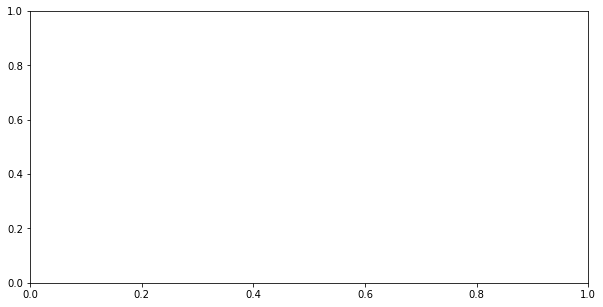

In [15]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['#BC80BD','#FDB462','#ed830c','#f5b771','#e64e9b','#BEBADA','#CCEBC5','#CCEBC5','#CCEBC5']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.violinplot(x='Unnamed: 4',y='perc shared',data=shared_df,cut=0,
                   order=['spleen','WB','kidney','LN1','LN2','LN3','SO','skin'],
                   palette=['#BC80BD','#CCEBC5','#BEBADA','#C56900','#FF9F06','#FFDFA5','#e64e9b','#D9D9D9'],
                   inner=None)
g = sns.swarmplot(x='Unnamed: 4',y='perc shared',data=shared_df[(shared_df['animal']=='RA1423')|(shared_df['animal']=='RA1779')],
                   order=['spleen','WB','kidney','LN1','LN2','LN3','SO','skin'],color='black',s=10,alpha=0.8,marker='^')
g = sns.swarmplot(x='Unnamed: 4',y='perc shared',data=shared_df[(shared_df['animal']=='RA1790')|(shared_df['animal']=='RA0700')],
                   order=['spleen','WB','kidney','LN1','LN2','LN3','SO','skin'],color='black',s=10,alpha=0.8,marker='v')
g = sns.swarmplot(x='Unnamed: 4',y='perc shared',data=shared_df[(shared_df['animal']=='RA0917')|(shared_df['animal']=='RA1818')],
                   order=['spleen','WB','kidney','LN1','LN2','LN3','SO','skin'],color='black',s=10,alpha=0.8,marker='o')

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(0,1.1)

## FIGURE 3C

In [14]:
sing_stock_df['tissue'] = sing_stock_df['tissue'].replace({'Whole blood (D005)': 'Whole blood', 'Whole blood (D006)': 'Whole blood','Whole blood (D008)': 'Whole blood'})
sing_stock_df['type'] = sing_stock_df['type'].replace({'syonymous': 'synonymous'})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
sing_stock_df['tissue'].value_counts()

Lymph node (mes)    38
Lymph node (ing)    30
Lymph node (ax)     21
Spleen              11
Whole blood          9
Kidney               8
Sex Organ            6
Name: tissue, dtype: int64

In [16]:
sing_stock_df[sing_stock_df['freq']>0.05]['tissue'].value_counts()

Lymph node (ing)    11
Lymph node (ax)      9
Lymph node (mes)     4
Spleen               1
Whole blood          1
Sex Organ            1
Kidney               1
Name: tissue, dtype: int64

In [17]:
sing_stock_df['type'].value_counts()

nonsynonymous    47
synonymous       39
noncoding        37
Name: type, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(0.0, 0.3)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 42.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


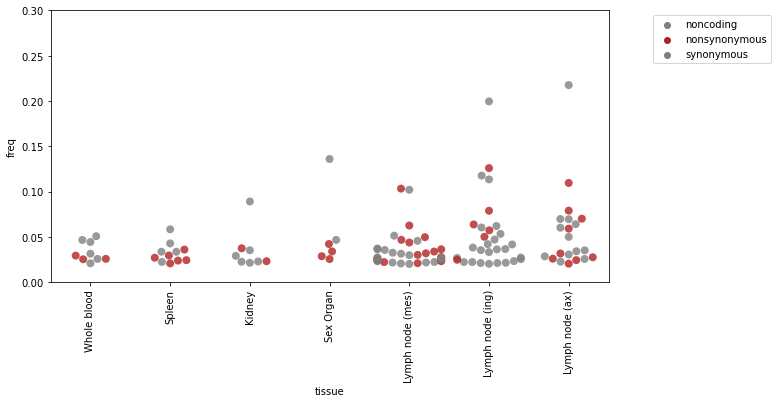

In [60]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['grey','firebrick','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.swarmplot(x='tissue',y='freq',order=['Whole blood','Spleen','Kidney','Sex Organ','Lymph node (mes)','Lymph node (ing)','Lymph node (ax)'],data=sing_stock_df,hue='type',palette=cmap_test,alpha=0.8,s=8)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.3,1))
plt.ylim(0,0.3)



In [61]:
sing_stock_df[(sing_stock_df['freq']>0.05)&(sing_stock_df['tissue']=='Lymph node (ing)')]['type'].value_counts()

noncoding        5
nonsynonymous    5
synonymous       1
Name: type, dtype: int64

In [62]:
sing_stock_df[sing_stock_df['tissue']=='Kidney']

#CHROM    POS  gene gene_transcript   gene_note           type   ID  \
7    KU182905.1   2458    NP              NP         NaN  nonsynonymous    .   
35   KU182905.1   5796   UTR            VP40  VP40 3'UTR      noncoding    .   
55   KU182905.1   8565  VP30            VP30         NaN     synonymous    .   
82   KU182905.1  13188     L               L         NaN     synonymous    .   
87   KU182905.1  14298     L               L         NaN     synonymous    .   
101  KU182905.1  17496     L               L         NaN     synonymous    .   
5    KU182905.1   5077   NaN             NaN         NaN  nonsynonymous  NaN   
121  KU182905.1  16239   NaN             NaN         NaN     synonymous  NaN   

    REF ALT  QUAL  ...         description  animal cohort  tissue depth  \
7     T   G   630  ...  Kidney_RA1074_D006  RA1074   D006  Kidney   856   
35    C   T   158  ...  Kidney_RA1423_D008  RA1423   D008  Kidney   394   
55    T   C  1793  ...  Kidney_RA1423_D008  RA1423   D008  Kidney  3479   
82    A   G   214  ...  Kidney_RA1423_D008  RA1423   D008  Kidney   312   
87    G   A  3679  ...  Kidney_RA1423_D008  RA1423   D008  Kidney  1830   
101   A   G   280  ...  Kidney_RA1423_D008  RA1423   D008  Kidney   709   
5     A   G  1733  ...  Kidney_RA1423_D008  RA1423   D008  Kidney  4363   
121   G   A   163  ...  Kidney_RA1074_D006  RA1074   D006  Kidney   467   

         freq   qual                reads variant_reads alleles  
7    0.037383   SB=1    DP4=415,398,22,19            32      TG  
35   0.022843   SB=0      DP4=144,238,4,8             9      CT  
55   0.029031  SB=11  DP4=1335,1987,55,58           101      TC  
82   0.035256   SB=6       DP4=201,97,7,7            11      AG  
87   0.089071  SB=20  DP4=1177,480,139,34           163      GA  
101  0.022567   SB=0     DP4=373,311,11,9            16      AG  
5    0.023149   SB=8  DP4=1658,2578,34,73           101      AG  
121  0.021413   SB=3       DP4=374,81,8,3            10      GA  

[8 rows x 22 columns]

In [63]:
# let's do some ratios
# in the lymph nodes, for variants above 5% frequency, what is the ratio of synonymous to nonsynonymous mutations?
ln_df_5 = sing_stock_df[(sing_stock_df['freq']>0.05)&sing_stock_df['tissue'].isin(['Lymph node (ing)', 'Lymph node (mes)', 'Lymph node (ax)'])]
print(ln_df_5['type'].value_counts())
print(ln_df_5['type'].value_counts()[0]/ln_df_5['type'].value_counts()[2])

nonsynonymous    11
noncoding         7
synonymous        6
Name: type, dtype: int64
1.8333333333333333


In [18]:
ln_tissues = ['Lymph node (ing)', 'Lymph node (mes)', 'Lymph node (ax)']
for tissue in ln_tissues:
    print(tissue)
    curr_high = sing_stock_df[(sing_stock_df['freq']>0.05)&sing_stock_df['tissue'].isin([tissue])]
    curr_low = sing_stock_df[(sing_stock_df['freq']<0.05)&sing_stock_df['tissue'].isin([tissue])]
    print('HIGH')
    print(curr_high['type'].value_counts())
    print(sum(curr_high['type'].isin(['nonsynonymous']))/sum(curr_high['type'].isin(['synonymous', 'nonsynonymous'])))
    print('LOW')
    print(curr_low['type'].value_counts())
    print(sum(curr_low['type'].isin(['nonsynonymous']))/sum(curr_low['type'].isin(['synonymous', 'nonsynonymous'])))

Lymph node (ing)
HIGH
noncoding        5
nonsynonymous    5
synonymous       1
Name: type, dtype: int64
0.8333333333333334
LOW
noncoding        9
synonymous       9
nonsynonymous    1
Name: type, dtype: int64
0.1
Lymph node (mes)
HIGH
nonsynonymous    2
synonymous       2
Name: type, dtype: int64
0.5
LOW
nonsynonymous    15
synonymous       11
noncoding         8
Name: type, dtype: int64
0.5769230769230769
Lymph node (ax)
HIGH
nonsynonymous    4
synonymous       3
noncoding        2
Name: type, dtype: int64
0.5714285714285714
LOW
nonsynonymous    5
noncoding        3
synonymous       3
Name: type, dtype: int64
0.625


In [150]:
# we need to do a test where we see if the ratios are different between high and low
# permutation test, where we shuffle the high and low labels and then see how often we get a ratio difference this large
trials = 10000
ln_tissues = ['Lymph node (ing)']
for tissue in ln_tissues:
    print(tissue)
    curr = sing_stock_df[sing_stock_df['tissue'].isin([tissue])&sing_stock_df['type'].isin(['synonymous', 'nonsynonymous'])]
    curr['label'] = curr['freq'] > 0.05
    comparison = []
    for N in range(1, trials):
        idx = np.random.permutation(len(curr['label']))
        curr['label_perm'] = list(curr.iloc[idx]['label'])
        curr_high = curr[curr['label_perm']]
        curr_low = curr[~curr['label_perm']]
        high_share = sum(curr_high['type'].isin(['nonsynonymous']))/sum(curr_high['type'].isin(['synonymous', 'nonsynonymous']))
        low_share = sum(curr_low['type'].isin(['nonsynonymous']))/sum(curr_low['type'].isin(['synonymous', 'nonsynonymous']))
        comparison.append(high_share-low_share)
    print(sum(np.array(comparison) > 0.73)/trials) # the calculated percent difference, one tail

Lymph node (ing)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


0.0091


In [151]:
# we need to do a test where we see if the ratios are different between high and low
# permutation test, where we shuffle the high and low labels and then see how often we get a ratio difference this large
trials = 10000
ln_tissues = ['Lymph node (ax)']
for tissue in ln_tissues:
    print(tissue)
    curr = sing_stock_df[sing_stock_df['tissue'].isin([tissue])&sing_stock_df['type'].isin(['synonymous', 'nonsynonymous'])]
    curr['label'] = curr['freq'] > 0.05
    comparison = []
    for N in range(1, trials):
        idx = np.random.permutation(len(curr['label']))
        curr['label_perm'] = list(curr.iloc[idx]['label'])
        curr_high = curr[curr['label_perm']]
        curr_low = curr[~curr['label_perm']]
        high_share = sum(curr_high['type'].isin(['nonsynonymous']))/sum(curr_high['type'].isin(['synonymous', 'nonsynonymous']))
        low_share = sum(curr_low['type'].isin(['nonsynonymous']))/sum(curr_low['type'].isin(['synonymous', 'nonsynonymous']))
        comparison.append(high_share-low_share)
    print(sum(np.array(comparison) < -0.06)/trials) # the calculated percent difference, one tail

Lymph node (ax)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


0.3285


In [152]:
# we need to do a test where we see if the ratios are different between high and low
# permutation test, where we shuffle the high and low labels and then see how often we get a ratio difference this large
trials = 10000
ln_tissues = ['Lymph node (mes)']
for tissue in ln_tissues:
    print(tissue)
    # there was zero division occurring due to the noncoding, fixed it
    curr = sing_stock_df[sing_stock_df['tissue'].isin([tissue])&sing_stock_df['type'].isin(['synonymous', 'nonsynonymous'])]
    curr['label'] = curr['freq'] > 0.05
    comparison = []
    for N in range(1, trials):
        idx = np.random.permutation(len(curr['label']))
        curr['label_perm'] = list(curr.iloc[idx]['label'])
        curr_high = curr[curr['label_perm']]
        curr_low = curr[~curr['label_perm']]
        high_share = sum(curr_high['type'].isin(['nonsynonymous']))/sum(curr_high['type'].isin(['synonymous', 'nonsynonymous']))
        low_share = sum(curr_low['type'].isin(['nonsynonymous']))/sum(curr_low['type'].isin(['synonymous', 'nonsynonymous']))
        comparison.append(high_share-low_share)
    print(sum(np.array(comparison) < -0.07)/trials) # the calculated percent difference, one tail

Lymph node (mes)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


0.5846


In [153]:
# and then another test to see if the ratios differ from the nul 3:1 ratio
# can use a binomial exacttest for this, basically checking if the probability of "success" matches
from scipy.stats import binomtest

In [154]:
ln_tissues = ['Lymph node (ing)', 'Lymph node (mes)', 'Lymph node (ax)']
for tissue in ln_tissues:
    print(tissue)
    curr_high = sing_stock_df[(sing_stock_df['freq']>0.05)&sing_stock_df['tissue'].isin([tissue])]
    curr_low = sing_stock_df[(sing_stock_df['freq']<0.05)&sing_stock_df['tissue'].isin([tissue])]
    print('HIGH')
    print(curr_high['type'].value_counts())
    print(sum(curr_high['type'].isin(['nonsynonymous']))/sum(curr_high['type'].isin(['synonymous', 'nonsynonymous'])))
    print('LOW')
    print(curr_low['type'].value_counts())
    print(sum(curr_low['type'].isin(['nonsynonymous']))/sum(curr_low['type'].isin(['synonymous', 'nonsynonymous'])))

Lymph node (ing)
HIGH
noncoding        5
nonsynonymous    5
synonymous       1
Name: type, dtype: int64
0.8333333333333334
LOW
noncoding        9
synonymous       9
nonsynonymous    1
Name: type, dtype: int64
0.1
Lymph node (mes)
HIGH
nonsynonymous    2
synonymous       2
Name: type, dtype: int64
0.5
LOW
nonsynonymous    15
synonymous       11
noncoding         8
Name: type, dtype: int64
0.5769230769230769
Lymph node (ax)
HIGH
nonsynonymous    4
synonymous       3
noncoding        2
Name: type, dtype: int64
0.5714285714285714
LOW
nonsynonymous    5
noncoding        3
synonymous       3
Name: type, dtype: int64
0.625


In [155]:
# high freq ing
binomtest(5, n=6, p=0.75, alternative='greater')

BinomTestResult(k=5, n=6, alternative='greater', proportion_estimate=0.8333333333333334, pvalue=0.533935546875)

In [157]:
# low freq ing
binomtest(1, n=10, p=0.75, alternative='less')

BinomTestResult(k=1, n=10, alternative='less', proportion_estimate=0.1, pvalue=2.956390380859375e-05)

In [158]:
# high freq mes
binomtest(2, n=4, p=0.75, alternative='less')

BinomTestResult(k=2, n=4, alternative='less', proportion_estimate=0.5, pvalue=0.26171875)

In [159]:
# low freq mes
binomtest(15, n=26, p=0.75, alternative='less')

BinomTestResult(k=15, n=26, alternative='less', proportion_estimate=0.5769230769230769, pvalue=0.04008449962674554)

In [160]:
# high freq ax
binomtest(4, n=7, p=0.75, alternative='less')

BinomTestResult(k=4, n=7, alternative='less', proportion_estimate=0.5714285714285714, pvalue=0.24359130859375)

In [161]:
# low freq ax
binomtest(5, n=8, p=0.75, alternative='less')

BinomTestResult(k=5, n=8, alternative='less', proportion_estimate=0.625, pvalue=0.3214569091796875)

In [167]:
# gene-wise?
sing_stock_df['gene'].value_counts()

L            29
UTR          27
GP           15
VP40         10
NP            9
noncoding     8
VP30          6
VP35          4
VP24          3
Name: gene, dtype: int64

In [169]:
# for L, GP, VP40, NP: what is variant ratio of N:S?
genes = ['L', 'GP', 'VP40', 'NP']
for gene in genes:
    print(gene)
    curr_gene = sing_stock_df[sing_stock_df['gene'].isin([gene])]
    print(curr_gene['type'].value_counts())
    print(sum(curr_gene['type'].isin(['nonsynonymous']))/sum(curr_gene['type'].isin(['synonymous', 'nonsynonymous'])))

L
synonymous       18
nonsynonymous    11
Name: type, dtype: int64
0.3793103448275862
GP
nonsynonymous    11
synonymous        4
Name: type, dtype: int64
0.7333333333333333
VP40
nonsynonymous    9
synonymous       1
Name: type, dtype: int64
0.9
NP
nonsynonymous    7
noncoding        2
Name: type, dtype: int64
1.0


In [170]:
# L
binomtest(11, n=29, p=0.75, alternative='less')

BinomTestResult(k=11, n=29, alternative='less', proportion_estimate=0.3793103448275862, pvalue=2.6161832762716664e-05)

In [171]:
# GP
binomtest(11, n=15, p=0.75, alternative='less')

BinomTestResult(k=11, n=15, alternative='less', proportion_estimate=0.7333333333333333, pvalue=0.5387131236493587)

In [1]:
# VP40
binomtest(9, n=10, p=0.75, alternative='greater')

NameError: name 'binomtest' is not defined

In [173]:
# NP
binomtest(7, n=7, p=0.75, alternative='greater')

BinomTestResult(k=7, n=7, alternative='greater', proportion_estimate=1.0, pvalue=0.13348388671875)

In [ ]:
# do a test where we check difference in ratios of low-freq to high-freq by tissue
# this is an ANOVA (multi chi-square)

In [20]:
sing_stock_df['tissue'].value_counts()

Lymph node (mes)    38
Lymph node (ing)    30
Lymph node (ax)     21
Spleen              11
Whole blood          9
Kidney               8
Sex Organ            6
Name: tissue, dtype: int64

In [ ]:
ltissues = ['Lymph node (ing)', 'Lymph node (mes)', 'Lymph node (ax)', 'Spleen', 'Whole blood', 'Kidney', 'Sex Organ']
for tissue in ln_tissues:
    print(tissue)
    curr_high = sing_stock_df[(sing_stock_df['freq']>0.05)&sing_stock_df['tissue'].isin([tissue])]
    curr_low = sing_stock_df[(sing_stock_df['freq']<0.05)&sing_stock_df['tissue'].isin([tissue])]
    print('HIGH')
    print(curr_high['type'].value_counts())
    print(sum(curr_high['type'].isin(['nonsynonymous']))/sum(curr_high['type'].isin(['synonymous', 'nonsynonymous'])))
    print('LOW')
    print(curr_low['type'].value_counts())
    print(sum(curr_low['type'].isin(['nonsynonymous']))/sum(curr_low['type'].isin(['synonymous', 'nonsynonymous'])))

## FIGURE 3D

In [27]:
sing_stock_df

#CHROM    POS gene gene_transcript gene_note           type   ID REF  \
0    KU182905.1    169  UTR              NP  NP 5'UTR      noncoding    .   A   
1    KU182905.1    169  UTR              NP  NP 5'UTR      noncoding    .   A   
2    KU182905.1    169  UTR              NP  NP 5'UTR      noncoding    .   A   
3    KU182905.1   1856   NP              NP       NaN  nonsynonymous    .   G   
4    KU182905.1   2340   NP              NP       NaN  nonsynonymous    .   A   
..          ...    ...  ...             ...       ...            ...  ...  ..   
117  KU182905.1  12066  NaN             NaN       NaN  nonsynonymous  NaN   T   
118  KU182905.1  12066  NaN             NaN       NaN  nonsynonymous  NaN   T   
119  KU182905.1  16239  NaN             NaN       NaN     synonymous  NaN   G   
120  KU182905.1  16239  NaN             NaN       NaN     synonymous  NaN   G   
121  KU182905.1  16239  NaN             NaN       NaN     synonymous  NaN   G   

    ALT  QUAL  ...                   description  animal cohort  \
0     G   569  ...            Spleen_RA1779_D008  RA1779   D008   
1     G   149  ...      Lymph node 3_RA1779_D008  RA1779   D008   
2     G   148  ...  Whole blood_D008_RA1779_D008  RA1779   D008   
3     A   989  ...      Lymph node 3_RA1779_D008  RA1779   D008   
4     T  2907  ...      Lymph node 3_RA1818_D006  RA1818   D006   
..   ..   ...  ...                           ...     ...    ...   
117   C   153  ...      Lymph node 1_RA1779_D008  RA1779   D008   
118   C   227  ...            Spleen_RA0452_D005  RA0452   D005   
119   A   286  ...      Lymph node 3_RA0700_D007  RA0700   D007   
120   A   875  ...      Lymph node 2_RA1790_D007  RA1790   D007   
121   A   163  ...            Kidney_RA1074_D006  RA1074   D006   

               tissue depth      freq   qual                reads  \
0              Spleen   463  0.058315   SB=6      DP4=422,12,27,2   
1    Lymph node (mes)   268  0.029851   SB=2       DP4=238,22,7,1   
2         Whole blood   138  0.050725  SB=14        DP4=126,4,6,2   
3    Lymph node (mes)  2394  0.025480   SB=5    DP4=2036,290,62,5   
4    Lymph node (mes)  5438  0.030158  SB=17  DP4=910,4355,42,130   
..                ...   ...       ...    ...                  ...   
117   Lymph node (ax)   441  0.020408   SB=9       DP4=338,94,5,4   
118            Spleen   545  0.023853  SB=10      DP4=373,157,7,8   
119  Lymph node (mes)   822  0.023114  SB=19     DP4=642,160,11,9   
120  Lymph node (ing)  2277  0.023276   SB=9   DP4=1646,566,42,22   
121            Kidney   467  0.021413   SB=3       DP4=374,81,8,3   

    variant_reads alleles  
0              27      AG  
1               8      AG  
2               7      AG  
3              61      GA  
4             164      AT  
..            ...     ...  
117             9      TC  
118            13      TC  
119            19      GA  
120            53      GA  
121            10      GA  

[123 rows x 22 columns]

In [45]:
df_numvars

tissue  Kidney  Lymph node (ax)  Lymph node (ing)  Lymph node (mes)  \
animal                                                                
RA0452     NaN              NaN               NaN               NaN   
RA0700     NaN              2.0               4.0               5.0   
RA0717     NaN              NaN               NaN               NaN   
RA0917     NaN              4.0               3.0               3.0   
RA1074     2.0              NaN               NaN               1.0   
RA1325     NaN              NaN               NaN               4.0   
RA1423     6.0              1.0               7.0               8.0   
RA1639     NaN              NaN               NaN               NaN   
RA1779     NaN              4.0               NaN               8.0   
RA1790     NaN              9.0               6.0               4.0   
RA1818     NaN              1.0              10.0               5.0   

tissue  Sex Organ  Spleen  Whole blood  
animal                                  
RA0452        NaN     2.0          NaN  
RA0700        NaN     NaN          NaN  
RA0717        NaN     2.0          NaN  
RA0917        NaN     NaN          NaN  
RA1074        NaN     1.0          1.0  
RA1325        NaN     NaN          NaN  
RA1423        NaN     2.0          2.0  
RA1639        NaN     2.0          2.0  
RA1779        6.0     2.0          3.0  
RA1790        NaN     NaN          NaN  
RA1818        NaN     NaN          1.0

In [52]:
df_numvars = sing_stock_df.groupby(['animal','tissue']).size().unstack()

df_numvars['Skin'] = len(df_numvars)*[np.nan]
df_numvars['Skin']['RA1818'] = 0
df_numvars['Spleen']['RA0917'] = 0
df_numvars['Whole blood']['RA0917'] = 0
df_numvars['Spleen']['RA0700'] = 0
df_numvars['Kidney']['RA0700'] = 0
df_numvars['Whole blood']['RA0700'] = 0
df_numvars['Spleen']['RA1790'] = 0
df_numvars['Whole blood']['RA1790'] = 0
df_numvars.loc['RA1803'] = 8*[np.nan] 
df_numvars.loc['RA0522'] = 8*[np.nan] 
df_numvars['Spleen']['RA0522'] = 0
df_numvars['Spleen']['RA1803'] = 0
df_numvars['Whole blood']['RA1803'] = 0
df_numvars['Liver'] = len(df_numvars)*[np.nan]
df_numvars['Liver']['RA1803'] = 0

df_numvars

tissue  Kidney  Lymph node (ax)  Lymph node (ing)  Lymph node (mes)  \
animal                                                                
RA0452     NaN              NaN               NaN               NaN   
RA0700     0.0              2.0               4.0               5.0   
RA0717     NaN              NaN               NaN               NaN   
RA0917     NaN              4.0               3.0               3.0   
RA1074     2.0              NaN               NaN               1.0   
RA1325     NaN              NaN               NaN               4.0   
RA1423     6.0              1.0               7.0               8.0   
RA1639     NaN              NaN               NaN               NaN   
RA1779     NaN              4.0               NaN               8.0   
RA1790     NaN              9.0               6.0               4.0   
RA1818     NaN              1.0              10.0               5.0   
RA1803     NaN              NaN               NaN               NaN   
RA0522     NaN              NaN               NaN               NaN   

tissue  Sex Organ  Spleen  Whole blood  Skin  Liver  
animal                                               
RA0452        NaN     2.0          NaN   NaN    NaN  
RA0700        NaN     0.0          0.0   NaN    NaN  
RA0717        NaN     2.0          NaN   NaN    NaN  
RA0917        NaN     0.0          0.0   NaN    NaN  
RA1074        NaN     1.0          1.0   NaN    NaN  
RA1325        NaN     NaN          NaN   NaN    NaN  
RA1423        NaN     2.0          2.0   NaN    NaN  
RA1639        NaN     2.0          2.0   NaN    NaN  
RA1779        6.0     2.0          3.0   NaN    NaN  
RA1790        NaN     0.0          0.0   NaN    NaN  
RA1818        NaN     NaN          1.0   0.0    NaN  
RA1803        NaN     0.0          0.0   NaN    0.0  
RA0522        NaN     0.0          NaN   NaN    NaN

In [32]:
df_numvars = sing_df.groupby(['animal','tissue']).size().unstack()
df_numvars['Skin'] = len(df_numvars)*[np.nan]
df_numvars['Whole blood (D007)'] = len(df_numvars)*[np.nan]
df_numvars['Skin']['RA1818'] = 0
df_numvars['Spleen']['RA0917'] = 0
df_numvars['Whole blood (D006)']['RA0917'] = 0
df_numvars['Spleen']['RA0700'] = 0
df_numvars['Kidney']['RA0700'] = 0
df_numvars['Whole blood (D007)']['RA0700'] = 0
df_numvars['Spleen']['RA1790'] = 0
df_numvars['Whole blood (D007)']['RA1790'] = 0
df_numvars.loc['RA1803'] = 11*[np.nan] 
df_numvars.loc['RA0522'] = 11*[np.nan] 
df_numvars['Spleen']['RA0522'] = 0
df_numvars['Spleen']['RA1803'] = 0
df_numvars['Liver'] = len(df_numvars)*[np.nan]
df_numvars['Liver']['RA1803'] = 0
df_numvars['Whole blood (D006)']['RA1803'] = 0

df_numvars

tissue  Kidney  Lymph node (ax)  Lymph node (ing)  Lymph node (mes)  \
animal                                                                
RA0452     NaN              NaN               NaN               NaN   
RA0700     0.0              2.0               3.0               4.0   
RA0717     NaN              NaN               NaN               NaN   
RA0917     NaN              4.0               3.0               3.0   
RA1074     1.0              NaN               NaN               1.0   
RA1325     NaN              NaN               NaN               4.0   
RA1423     5.0              1.0               7.0               9.0   
RA1639     NaN              NaN               NaN               NaN   
RA1779     NaN              3.0               NaN               8.0   
RA1790     NaN              8.0               5.0               4.0   
RA1818     NaN              1.0              10.0               5.0   
RA1803     NaN              NaN               NaN               NaN   
RA0522     NaN              NaN               NaN               NaN   

tissue  Sex Organ  Spleen  Whole blood (D005)  Whole blood (D006)  \
animal                                                              
RA0452        NaN     1.0                 NaN                 NaN   
RA0700        NaN     0.0                 NaN                 NaN   
RA0717        NaN     2.0                 NaN                 NaN   
RA0917        NaN     0.0                 NaN                 0.0   
RA1074        NaN     1.0                 NaN                 1.0   
RA1325        NaN     NaN                 NaN                 NaN   
RA1423        NaN     1.0                 NaN                 NaN   
RA1639        NaN     1.0                 1.0                 NaN   
RA1779        6.0     2.0                 NaN                 NaN   
RA1790        NaN     0.0                 NaN                 NaN   
RA1818        NaN     NaN                 NaN                 1.0   
RA1803        NaN     0.0                 NaN                 0.0   
RA0522        NaN     0.0                 NaN                 NaN   

tissue  Whole blood (D008)  Skin  Whole blood (D007)  Liver  
animal                                                       
RA0452                 NaN   NaN                 NaN    NaN  
RA0700                 NaN   NaN                 0.0    NaN  
RA0717                 NaN   NaN                 NaN    NaN  
RA0917                 NaN   NaN                 NaN    NaN  
RA1074                 NaN   NaN                 NaN    NaN  
RA1325                 NaN   NaN                 NaN    NaN  
RA1423                 1.0   NaN                 NaN    NaN  
RA1639                 NaN   NaN                 NaN    NaN  
RA1779                 3.0   NaN                 NaN    NaN  
RA1790                 NaN   NaN                 0.0    NaN  
RA1818                 NaN   0.0                 NaN    NaN  
RA1803                 NaN   NaN                 NaN    0.0  
RA0522                 NaN   NaN                 NaN    NaN

tissue
Kidney               8.0
Lymph node (ax)     21.0
Lymph node (ing)    30.0
Lymph node (mes)    38.0
Sex Organ            6.0
Spleen              11.0
Whole blood          9.0
Skin                 0.0
Liver                0.0
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'RA0717'),
  Text(1, 0, 'RA0522'),
  Text(2, 0, 'RA0452'),
  Text(3, 0, 'RA1639'),
  Text(4, 0, 'RA1803'),
  Text(5, 0, 'RA1074'),
  Text(6, 0, 'RA1325'),
  Text(7, 0, 'RA0917'),
  Text(8, 0, 'RA1818'),
  Text(9, 0, 'RA0700'),
  Text(10, 0, 'RA1790'),
  Text(11, 0, 'RA1779'),
  Text(12, 0, 'RA1423')])

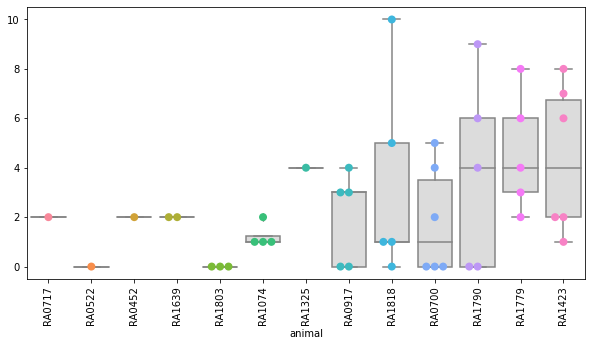

In [54]:
fig,ax = plt.subplots()
fig.set_size_inches(10, 5)
cmap_test = ['grey','firebrick','lightcoral','grey','mediumblue','grey','grey','cornflowerblue','grey']

#g = sns.swarmplot(x='cohort',y='freq',order=['D003','D004','D005','D006','D007','D008','D-30','NTC'],data=isnvs_set_final,hue='eff_type',palette=cmap_test)
g = sns.boxplot(data=df_numvars.T,order=['RA0717','RA0522','RA0452','RA1639','RA1803','RA1074','RA1325','RA0917','RA1818','RA0700','RA1790','RA1779','RA1423'],color='gainsboro')
g = sns.swarmplot(data=df_numvars.T,order=['RA0717','RA0522','RA0452','RA1639','RA1803','RA1074','RA1325','RA0917','RA1818','RA0700','RA1790','RA1779','RA1423'],s=8)
plt.xticks(rotation=90)
#plt.ylim(0,11)

## FIGURE 3F

In [205]:
# big function to make the relevant matrices (binary, freq, depth)

def matrix_builder_lofreq(df):
    
    df_binary = df[['POS','description']]
    df_binary = df_binary.set_index('POS')
    df_binary = pd.get_dummies(df_binary['description'])
    df_binary = df_binary.reset_index()
    df_binary = df_binary.groupby(['POS']).sum()
    
    names = list(df)
    N = len(list(df))
    mat_binary = [ [ 0 for i in range(N) ] for j in range(N) ]
    
    for i,sample in zip(range(N),list(df_binary)):
        df_subset = df_binary[df_binary[sample]>0]
        mat_binary[i] = list(df_subset.sum())
        #this part gives diagonal as iSNVs not shared..
        mat_binary[i][i] = (df_subset.sum(axis=1)==1).sum()
        #this sets diagonal to 0
        #mat[i][i] = 0
     
    df_freq = df_binary.copy()
    df_freq = df_freq.astype('float')

    for index,row in df.iterrows():
        posit = df['POS'][index]
        sample = df['description'][index]
        freq = df['freq'][index]
        df_freq.at[posit,sample] = freq    
        
    df_depth = df_binary.copy()
    df_depth = df_depth.astype('float')
    
  
    return(df_binary,df_freq)


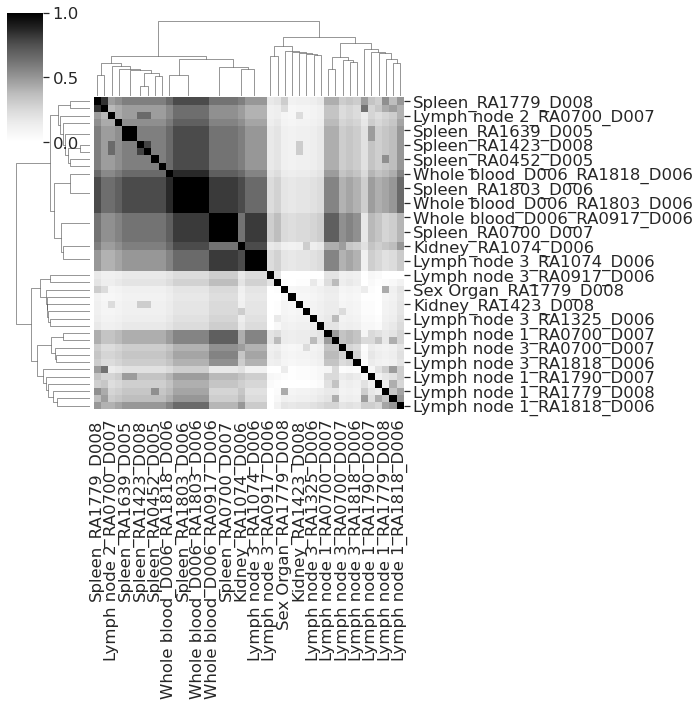

In [211]:
all_bin = matrix_builder_lofreq(lofreq_isnvs_hc[(lofreq_isnvs_hc['tissue']!='Liver')&(lofreq_isnvs_hc['tissue']!='Skin (nonrash)')])[0]
all_freq = matrix_builder_lofreq(lofreq_isnvs_hc)[1]

sns.set(font_scale = 1.5)
fig = sns.clustermap(all_bin.corr(),vmin=0,vmax=1,cmap='Greys')


## FIGURE 3A

In [76]:
vars_count = []
vars_non = []
vars_adar = []
vars_nonadar = []
vars_transit = []
vars_transvers = []

for i in range(18959):
    low = i
    high = i+300
    df_temp = sing_stock_df[(sing_stock_df['POS']>low)&(sing_stock_df['POS']<high)]
    df_temp.drop_duplicates(subset ="POS",keep = False, inplace = True)
    df_temp2 = df_temp[df_temp['type']=='nonsynonymous']
    vars_count.append(len(df_temp))
    vars_non.append(len(df_temp2))
    df_temp3 = df_temp[(df_temp['alleles']=='AG')|(df_temp['alleles']=='TC')]
    df_temp4 = df_temp[(df_temp['alleles']=='CT')|(df_temp['alleles']=='GA')]
    transvers = len(df_temp) - (len(df_temp3) + len(df_temp4))
    vars_adar.append(len(df_temp3))
    vars_nonadar.append(len(df_temp4))
    vars_transvers.append(transvers)
    vars_transit.append(len(df_temp3) + len(df_temp4))
    

(0.0, 7.0)

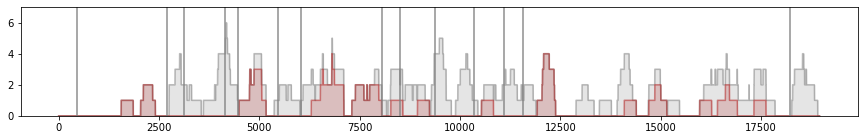

In [77]:
plt.figure(figsize=(15,2))

plt.plot(range(18959),vars_count,color='grey',alpha=0.5)
plt.fill_between(range(18959),vars_count,color='grey',alpha=0.2)

plt.plot(range(18959),vars_non,color='firebrick',alpha=0.5)
plt.fill_between(range(18959),vars_non,color='firebrick',alpha=0.2)

plt.axvline(x=470,color='grey',alpha=0.9)
plt.axvline(x=2689,color='grey',alpha=0.9)

plt.axvline(x=3129,color='grey',alpha=0.9)
plt.axvline(x=4151,color='grey',alpha=0.9)

plt.axvline(x=4479,color='grey',alpha=0.9)
plt.axvline(x=5459,color='grey',alpha=0.9)

plt.axvline(x=6039,color='grey',alpha=0.9)
plt.axvline(x=8068,color='grey',alpha=0.9)

plt.axvline(x=8509,color='grey',alpha=0.9)
plt.axvline(x=9375,color='grey',alpha=0.9)

plt.axvline(x=10345,color='grey',alpha=0.9)
plt.axvline(x=11100,color='grey',alpha=0.9)

plt.axvline(x=11581,color='grey',alpha=0.9)
plt.axvline(x=18219,color='grey',alpha=0.9)

#plt.xlim(0,19000)
plt.ylim(0,7)

## SUPP FIG 8

A

In [ ]:
all_bin = matrix_builder_lofreq(lofreq_isnvs_rep)[0]
all_freq = matrix_builder_lofreq(lofreq_isnvs_rep)[1]

sns.clustermap(all_freq.corr(method='spearman'),vmin=0,vmax=1,cmap='Greys')

B

## SUPP FIG 9

In [57]:
sing_stock_df[105:]

#CHROM    POS       gene gene_transcript gene_note           type  \
106  KU182905.1  18411  noncoding             NaN   trailer      noncoding   
107  KU182905.1  18562  noncoding             NaN   trailer      noncoding   
108  KU182905.1  18584  noncoding             NaN   trailer      noncoding   
109  KU182905.1  18631  noncoding             NaN   trailer      noncoding   
110  KU182905.1  18831  noncoding             NaN   trailer      noncoding   
111  KU182905.1  18911  noncoding             NaN   trailer      noncoding   
0    KU182905.1    502        NaN             NaN       NaN     synonymous   
1    KU182905.1    502        NaN             NaN       NaN     synonymous   
2    KU182905.1    502        NaN             NaN       NaN     synonymous   
3    KU182905.1   5077        NaN             NaN       NaN  nonsynonymous   
4    KU182905.1   5077        NaN             NaN       NaN  nonsynonymous   
5    KU182905.1   5077        NaN             NaN       NaN  nonsynonymous   
6    KU182905.1   5077        NaN             NaN       NaN  nonsynonymous   
117  KU182905.1  12066        NaN             NaN       NaN  nonsynonymous   
118  KU182905.1  12066        NaN             NaN       NaN  nonsynonymous   
119  KU182905.1  16239        NaN             NaN       NaN     synonymous   
120  KU182905.1  16239        NaN             NaN       NaN     synonymous   
121  KU182905.1  16239        NaN             NaN       NaN     synonymous   

      ID REF ALT  QUAL  ...                   description  animal cohort  \
106    .   A   G   113  ...  Whole blood_D008_RA1779_D008  RA1779   D008   
107    .   G   T  3765  ...      Lymph node 3_RA1423_D008  RA1423   D008   
108    .   C   T   110  ...  Whole blood_D008_RA1423_D008  RA1423   D008   
109    .   T   C   867  ...            Spleen_RA1423_D008  RA1423   D008   
110    .   T   C   136  ...      Lymph node 3_RA1790_D007  RA1790   D007   
111    .   G   A   104  ...  Whole blood_D006_RA1818_D006  RA1818   D006   
0    NaN   G   A   150  ...      Lymph node 1_RA1790_D007  RA1790   D007   
1    NaN   G   A   508  ...            Spleen_RA1639_D005  RA1639   D005   
2    NaN   G   A   350  ...  Whole blood_D005_RA1639_D005  RA1639   D005   
3    NaN   A   G   861  ...      Lymph node 2_RA0700_D007  RA0700   D007   
4    NaN   A   G  2145  ...            Spleen_RA1423_D008  RA1423   D008   
5    NaN   A   G  1733  ...            Kidney_RA1423_D008  RA1423   D008   
6    NaN   A   G   519  ...  Whole blood_D008_RA1423_D008  RA1423   D008   
117  NaN   T   C   153  ...      Lymph node 1_RA1779_D008  RA1779   D008   
118  NaN   T   C   227  ...            Spleen_RA0452_D005  RA0452   D005   
119  NaN   G   A   286  ...      Lymph node 3_RA0700_D007  RA0700   D007   
120  NaN   G   A   875  ...      Lymph node 2_RA1790_D007  RA1790   D007   
121  NaN   G   A   163  ...            Kidney_RA1074_D006  RA1074   D006   

               tissue depth      freq   qual                 reads  \
106       Whole blood   191  0.031414   SB=6        DP4=83,102,1,5   
107  Lymph node (mes)  5756  0.037179  SB=39  DP4=4431,1092,160,71   
108       Whole blood   234  0.025641   SB=5        DP4=186,39,4,2   
109            Spleen  1428  0.033613  SB=21    DP4=1185,191,37,15   
110  Lymph node (mes)   197  0.035533   SB=0         DP4=0,190,0,7   
111       Whole blood   288  0.020833   SB=0         DP4=0,282,0,6   
0     Lymph node (ax)   262  0.030534   SB=5        DP4=157,97,7,1   
1              Spleen   835  0.033533   SB=3      DP4=525,273,23,8   
2         Whole blood   406  0.044335   SB=4       DP4=243,142,9,9   
3    Lymph node (ing)  1982  0.024723   SB=0    DP4=685,1245,18,32   
4              Spleen  5310  0.024294   SB=7   DP4=2031,3138,59,71   
5              Kidney  4363  0.023149   SB=8   DP4=1658,2578,34,73   
6         Whole blood  1148  0.025261   SB=0     DP4=409,708,11,18   
117   Lymph node (ax)   441  0.020408   SB=9        DP4=338,94,5,4   
118            Spleen   545  0.

In [58]:
sing_df

#CHROM    POS       gene gene_transcript gene_note           type ID  \
0    KU182905.1    169        UTR              NP  NP 5'UTR      noncoding  .   
1    KU182905.1    169        UTR              NP  NP 5'UTR      noncoding  .   
2    KU182905.1    169        UTR              NP  NP 5'UTR      noncoding  .   
3    KU182905.1   1856         NP              NP       NaN  nonsynonymous  .   
4    KU182905.1   2340         NP              NP       NaN  nonsynonymous  .   
..          ...    ...        ...             ...       ...            ... ..   
107  KU182905.1  18562  noncoding             NaN   trailer      noncoding  .   
108  KU182905.1  18584  noncoding             NaN   trailer      noncoding  .   
109  KU182905.1  18631  noncoding             NaN   trailer      noncoding  .   
110  KU182905.1  18831  noncoding             NaN   trailer      noncoding  .   
111  KU182905.1  18911  noncoding             NaN   trailer      noncoding  .   

    REF ALT  QUAL  ...                   description  animal cohort  \
0     A   G   569  ...            Spleen_RA1779_D008  RA1779   D008   
1     A   G   149  ...      Lymph node 3_RA1779_D008  RA1779   D008   
2     A   G   148  ...  Whole blood_D008_RA1779_D008  RA1779   D008   
3     G   A   989  ...      Lymph node 3_RA1779_D008  RA1779   D008   
4     A   T  2907  ...      Lymph node 3_RA1818_D006  RA1818   D006   
..   ..  ..   ...  ...                           ...     ...    ...   
107   G   T  3765  ...      Lymph node 3_RA1423_D008  RA1423   D008   
108   C   T   110  ...  Whole blood_D008_RA1423_D008  RA1423   D008   
109   T   C   867  ...            Spleen_RA1423_D008  RA1423   D008   
110   T   C   136  ...      Lymph node 3_RA1790_D007  RA1790   D007   
111   G   A   104  ...  Whole blood_D006_RA1818_D006  RA1818   D006   

                 tissue depth      freq   qual                 reads  \
0                Spleen   463  0.058315   SB=6       DP4=422,12,27,2   
1      Lymph node (mes)   268  0.029851   SB=2        DP4=238,22,7,1   
2    Whole blood (D008)   138  0.050725  SB=14         DP4=126,4,6,2   
3      Lymph node (mes)  2394  0.025480   SB=5     DP4=2036,290,62,5   
4      Lymph node (mes)  5438  0.030158  SB=17   DP4=910,4355,42,130   
..                  ...   ...       ...    ...                   ...   
107    Lymph node (mes)  5756  0.037179  SB=39  DP4=4431,1092,160,71   
108  Whole blood (D008)   234  0.025641   SB=5        DP4=186,39,4,2   
109              Spleen  1428  0.033613  SB=21    DP4=1185,191,37,15   
110    Lymph node (mes)   197  0.035533   SB=0         DP4=0,190,0,7   
111  Whole blood (D006)   288  0.020833   SB=0         DP4=0,282,0,6   

    variant_reads alleles  
0              27      AG  
1               8      AG  
2               7      AG  
3              61      GA  
4             164      AT  
..            ...     ...  
107           214      GT  
108             6      CT  
109            48      TC  
110             7      TC  
111             6      GA  

[112 rows x 22 columns]

In [59]:
sing_stock_df

#CHROM    POS gene gene_transcript gene_note           type   ID REF  \
0    KU182905.1    169  UTR              NP  NP 5'UTR      noncoding    .   A   
1    KU182905.1    169  UTR              NP  NP 5'UTR      noncoding    .   A   
2    KU182905.1    169  UTR              NP  NP 5'UTR      noncoding    .   A   
3    KU182905.1   1856   NP              NP       NaN  nonsynonymous    .   G   
4    KU182905.1   2340   NP              NP       NaN  nonsynonymous    .   A   
..          ...    ...  ...             ...       ...            ...  ...  ..   
117  KU182905.1  12066  NaN             NaN       NaN  nonsynonymous  NaN   T   
118  KU182905.1  12066  NaN             NaN       NaN  nonsynonymous  NaN   T   
119  KU182905.1  16239  NaN             NaN       NaN     synonymous  NaN   G   
120  KU182905.1  16239  NaN             NaN       NaN     synonymous  NaN   G   
121  KU182905.1  16239  NaN             NaN       NaN     synonymous  NaN   G   

    ALT  QUAL  ...                   description  animal cohort  \
0     G   569  ...            Spleen_RA1779_D008  RA1779   D008   
1     G   149  ...      Lymph node 3_RA1779_D008  RA1779   D008   
2     G   148  ...  Whole blood_D008_RA1779_D008  RA1779   D008   
3     A   989  ...      Lymph node 3_RA1779_D008  RA1779   D008   
4     T  2907  ...      Lymph node 3_RA1818_D006  RA1818   D006   
..   ..   ...  ...                           ...     ...    ...   
117   C   153  ...      Lymph node 1_RA1779_D008  RA1779   D008   
118   C   227  ...            Spleen_RA0452_D005  RA0452   D005   
119   A   286  ...      Lymph node 3_RA0700_D007  RA0700   D007   
120   A   875  ...      Lymph node 2_RA1790_D007  RA1790   D007   
121   A   163  ...            Kidney_RA1074_D006  RA1074   D006   

               tissue depth      freq   qual                reads  \
0              Spleen   463  0.058315   SB=6      DP4=422,12,27,2   
1    Lymph node (mes)   268  0.029851   SB=2       DP4=238,22,7,1   
2         Whole blood   138  0.050725  SB=14        DP4=126,4,6,2   
3    Lymph node (mes)  2394  0.025480   SB=5    DP4=2036,290,62,5   
4    Lymph node (mes)  5438  0.030158  SB=17  DP4=910,4355,42,130   
..                ...   ...       ...    ...                  ...   
117   Lymph node (ax)   441  0.020408   SB=9       DP4=338,94,5,4   
118            Spleen   545  0.023853  SB=10      DP4=373,157,7,8   
119  Lymph node (mes)   822  0.023114  SB=19     DP4=642,160,11,9   
120  Lymph node (ing)  2277  0.023276   SB=9   DP4=1646,566,42,22   
121            Kidney   467  0.021413   SB=3       DP4=374,81,8,3   

    variant_reads alleles  
0              27      AG  
1               8      AG  
2               7      AG  
3              61      GA  
4             164      AT  
..            ...     ...  
117             9      TC  
118            13      TC  
119            19      GA  
120            53      GA  
121            10      GA  

[123 rows x 22 columns]

In [71]:
sing_stock_df['gene'].value_counts()

L            29
UTR          27
GP           15
VP40         10
NP            9
noncoding     8
VP30          6
VP35          4
VP24          3
Name: gene, dtype: int64

In [79]:
sing_stock_df[sing_stock_df['gene']=='NP']

#CHROM   POS gene gene_transcript gene_note           type ID REF ALT  \
3   KU182905.1  1856   NP              NP       NaN  nonsynonymous  .   G   A   
4   KU182905.1  2340   NP              NP       NaN  nonsynonymous  .   A   T   
5   KU182905.1  2408   NP              NP       NaN  nonsynonymous  .   T   G   
6   KU182905.1  2458   NP              NP       NaN  nonsynonymous  .   T   G   
7   KU182905.1  2458   NP              NP       NaN  nonsynonymous  .   T   G   
8   KU182905.1  2458   NP              NP       NaN  nonsynonymous  .   T   G   
9   KU182905.1  2458   NP              NP       NaN  nonsynonymous  .   T   G   
10  KU182905.1  2997   NP              NP  NP 3'UTR      noncoding  .   T   C   
11  KU182905.1  2997   NP              NP  NP 3'UTR      noncoding  .   T   C   

    QUAL  ...                   description  animal cohort            tissue  \
3    989  ...      Lymph node 3_RA1779_D008  RA1779   D008  Lymph node (mes)   
4   2907  ...      Lymph node 3_RA1818_D006  RA1818   D006  Lymph node (mes)   
5    361  ...      Lymph node 3_RA1779_D008  RA1779   D008  Lymph node (mes)   
6    441  ...           Spleen2_RA1074_D006  RA1074   D006            Spleen   
7    630  ...            Kidney_RA1074_D006  RA1074   D006            Kidney   
8    960  ...      Lymph node 3_RA1074_D006  RA1074   D006  Lymph node (mes)   
9   2434  ...  Whole blood_D006_RA1074_D006  RA1074   D006       Whole blood   
10  1894  ...            Spleen_RA1639_D005  RA1639   D005            Spleen   
11  1522  ...  Whole blood_D005_RA1639_D005  RA1639   D005       Whole blood   

   depth      freq   qual                 reads variant_reads alleles  
3   2394  0.025480   SB=5     DP4=2036,290,62,5            61      GA  
4   5438  0.030158  SB=17   DP4=910,4355,42,130           164      AT  
5    723  0.027663   SB=2      DP4=304,398,7,14            20      TG  
6    926  0.026998   SB=0     DP4=534,365,17,10            25      TG  
7    856  0.037383   SB=1     DP4=415,398,22,19            32      TG  
8   2422  0.023947   SB=0    DP4=518,1840,14,50            58      TG  
9   4846  0.029303  SB=17  DP4=2870,1824,107,44           142      TG  
10  2290  0.042795   SB=2    DP4=819,1362,43,63            98      TC  
11  1652  0.046610   SB=2    DP4=502,1069,28,53            77      TC  

[9 rows x 22 columns]

In [78]:
sing_stock_df.groupby(["gene", "type"]).size()

gene       type         
GP         nonsynonymous    11
           synonymous        4
L          nonsynonymous    11
           synonymous       18
NP         noncoding         2
           nonsynonymous     7
UTR        noncoding        27
VP24       nonsynonymous     1
           synonymous        2
VP30       nonsynonymous     2
           synonymous        4
VP35       synonymous        4
VP40       nonsynonymous     9
           synonymous        1
noncoding  noncoding         8
dtype: int64

In [68]:
sing_stock_df['gene_transcript'].value_counts()

L       30
GP      17
VP40    14
NP      12
VP30    11
VP35    10
VP24     9
Name: gene_transcript, dtype: int64

In [69]:
sing_stock_df['gene_note'].value_counts()

trailer       7
VP35 3'UTR    4
VP30 3'UTR    4
NP 5'UTR      3
VP24 5'UTR    3
VP24 3'UTR    3
NP 3'UTR      2
VP35 5'UTR    2
VP40 5'UTR    2
VP40 3'UTR    2
GP 5'UTR      1
GP 3'UTR      1
VP30 5'UTR    1
L 5'UTR       1
Name: gene_note, dtype: int64